# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [2]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# tf.contrib.eager.enable_eager_execution()

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import (
    GaugeModel, check_else_make_dir, save_params_to_pkl_file
)

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

## Define parameters

In [4]:
tf.reset_default_graph()

params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 6,
    'rand': False,
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 1,
    'eps': 0.1,
    'loss_scale': 0.1,
    #'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.96,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    'annealing_steps': 1,
    'annealing_factor': 0.9999,
    #'beta': 3.,
    'beta_init': 3.,
    'beta_final': 4.,
#--------------------- Training parameters ---------------------------
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'print_steps': 1,
    'training_samples_steps': 1000,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    #'conv_net': True,
    'network_arch': 'conv3D',
    'data_format': 'channels_last',
    'hmc': True,
    'eps_trainable': False,
    'metric': 'cos_diff',
    'aux': True,
    'clip_grads': False,
    'clip_value': 1.,
    'using_hvd': False
}

## Create model

In [5]:
os.environ["KMP_BLOCKTIME"] = str(0)
os.environ["KMP_SETTINGS"] = str(1)
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"] = str(2)
config = tf.ConfigProto()
tf.reset_default_graph()

In [6]:
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_181/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_181/eval_info
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_181/eval_info/samples
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_181/eval_info/training
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_181/eval_info/training/samples
time_size: 8
space_size: 8
link_type: U1
dim: 2
num_samples: 6
rand: False
num_steps: 1
eps: 0.1
loss_scale: 0.1
learning_rate_init: 0.001
learning_rate_decay_steps: 1000
learning_rate_decay_rate: 0.96
annealing: True
annealing_steps: 1
annealing_factor: 0.9999
beta_init: 3.0
beta_final: 4.0
train_steps: 10000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 1000
training_samples_length: 100
network_arch: conv3D
data_format: channels_last
hmc: True
eps_trainable: False
metric: cos_diff
aux: True
clip_grads: False
clip_value: 1.

In [5]:
model.train(model.train_steps)

Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_180/eval_info/training/intermediate_beta
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
     1/10000      -37.36         1303         0.4583          0.1            3           0.001    
     2/10000       335.4        0.8301       0.001269        0.101           3           0.001    
     3/10000       404.6        0.8623        0.01636       0.1005           3           0.001    
     4/10000       316.1        0.9121        0.1863        0.09975          3           0.001    
     5/10000        294          1.014        0.1366        0.09917          3           0.001    
     6/10000      -45.15         1.169        0.7187        0.09844          3           0.001 

    80/10000      -61.89         0.847         0.926        0.1119           3           0.001    
    81/10000      -60.09        0.9331        0.8869        0.1125           3           0.001    
    82/10000      -61.79        0.9379        0.8638         0.113           3           0.001    
    83/10000      -66.64        0.9703        0.9579        0.1136           3           0.001    
    84/10000      -63.11        0.9222        0.8077        0.1142           3           0.001    
    85/10000      -64.34         1.025        0.8658        0.1149           3           0.001    
    86/10000      -66.54        0.8827        0.9044        0.1155           3           0.001    
    87/10000      -65.01        0.8355        0.8159        0.1161           3           0.001    
    88/10000      -71.11        0.8406        0.9355        0.1167           3           0.001    
    89/10000      -66.56        0.8789        0.7995        0.1173           3           0.001    
    90/100

   163/10000      -111.1        0.8216        0.4587        0.1715           3           0.001    
   164/10000      -127.1        0.9419        0.5926        0.1723           3           0.001    
   165/10000      -104.9        0.8547        0.3077        0.1731           3           0.001    
   166/10000      -125.2        0.8362         0.514        0.1739           3           0.001    
   167/10000      -139.8        0.8721         0.672        0.1747           3           0.001    
   168/10000      -142.9        0.8092         0.705        0.1754           3           0.001    
   169/10000      -127.6        0.8313        0.5375        0.1762           3           0.001    
   170/10000      -139.7        0.9629        0.6617         0.177           3           0.001    
   171/10000      -122.1        0.8871        0.4133        0.1779           3           0.001    
   172/10000      -152.5        0.9857        0.7509        0.1787           3           0.001    
   173/100

   246/10000      -196.8        0.8432        0.3624         0.23            3           0.001    
   247/10000      -154.2        0.8116        0.02486       0.2305           3           0.001    
   248/10000       12.51        0.9364        0.06445        0.231           3           0.001    
   249/10000      -150.2         1.003        0.3356        0.2314           3           0.001    
   250/10000      -173.2        0.8063         0.175        0.2315           3           0.001    
   251/10000      -182.3        0.8361         0.18         0.2317           3           0.001    
   252/10000      -179.8        0.8088         0.187        0.2319           3           0.001    
   253/10000       -155         0.9284        0.02704       0.2322           3           0.001    
   254/10000      -183.7        0.9305        0.1513        0.2326           3           0.001    
   255/10000      -196.2        0.7995        0.3073        0.2329           3           0.001    
   256/100

   329/10000      -259.4        0.8478        0.3419        0.2408           3           0.001    
   330/10000      -260.8        0.8386        0.2484        0.2411           3           0.001    
   331/10000      -244.3        0.8418        0.08708       0.2416           3           0.001    
   332/10000      -325.8        0.8714        0.3649        0.2421           3           0.001    
   333/10000      -386.8        0.8927        0.1606        0.2427           3           0.001    
   334/10000      -535.6        0.8479        0.1786        0.2435           3           0.001    
   335/10000      -549.8        0.8468        0.1689        0.2446           3           0.001    
   336/10000       448.7        0.7991        0.02581        0.245           3           0.001    
   337/10000      -414.9        0.8004        0.2613        0.2436           3           0.001    
   338/10000      -602.7        0.8331        0.3387        0.2422           3           0.001    
   339/100

   412/10000      -50.69        0.8624        0.09449       0.2347           3           0.001    
   413/10000      -231.7        0.8243        0.4592        0.2341           3           0.001    
   414/10000      -226.2        0.7391        0.4628        0.2336           3           0.001    
   415/10000      -222.1         0.784        0.4056        0.2332           3           0.001    
   416/10000      -212.6        0.7754        0.4473        0.2328           3           0.001    
   417/10000      -239.1        0.8539        0.5844        0.2325           3           0.001    
   418/10000      -216.5         0.935        0.3992        0.2323           3           0.001    
   419/10000      -169.6        0.8707        0.1636        0.2321           3           0.001    
   420/10000       -213         0.8435        0.5137        0.2319           3           0.001    
   421/10000      -198.3        0.8115         0.357        0.2317           3           0.001    
   422/100

   495/10000      -186.7        0.8259        0.3078        0.2359           3           0.001    
   496/10000       -189         0.8877        0.2311        0.2359           3           0.001    
   497/10000       -226         0.8686        0.4734        0.2358           3           0.001    
   498/10000      -238.5         0.855        0.5462        0.2358           3           0.001    
   499/10000      -160.7        0.8136        0.09827       0.2358           3           0.001    
   500/10000      -112.4        0.8263        0.1305        0.2359           3           0.001    
   501/10000       -198         0.9177        0.2453        0.2358           3           0.001    
   502/10000      -206.5        0.8535        0.3317        0.2358           3           0.001    
   503/10000      -156.6         0.863        0.08829       0.2358           3           0.001    
   504/10000      -211.4        0.8153        0.3718        0.2359           3           0.001    
   505/100

   578/10000      -189.3        0.8191        0.1044        0.2407           3           0.001    
   579/10000      -205.2        0.7962        0.2027        0.2408           3           0.001    
   580/10000      -250.9         0.843        0.6693        0.2409           3           0.001    
   581/10000      -256.8        0.8606        0.5132        0.2409           3           0.001    
   582/10000      -193.6        0.8453        0.1717        0.2409           3           0.001    
   583/10000       -240         0.8725        0.4395         0.241           3           0.001    
   584/10000      -177.4        0.8203         0.174        0.2411           3           0.001    
   585/10000      -205.4        0.8294        0.1969        0.2411           3           0.001    
   586/10000      -242.8        0.8668        0.5014        0.2412           3           0.001    
   587/10000       -187         0.8588        0.1163        0.2412           3           0.001    
   588/100

   661/10000       -509         0.8234        0.2376        0.2462           3           0.001    
   662/10000       -477         0.8369        0.03633       0.2462           3           0.001    
   663/10000      -544.2        0.8911        0.3315        0.2463           3           0.001    
   664/10000       -631         0.8744        0.2358        0.2464           3           0.001    
   665/10000      -553.9         0.927        0.3235        0.2466           3           0.001    
   666/10000      -733.8        0.8459        0.3703        0.2469           3           0.001    
   667/10000      -383.1        0.8224        0.1861        0.2472           3           0.001    
   668/10000       50.01        0.8318        0.3125        0.2476           3           0.001    
   669/10000       50.84        0.8263       0.007821       0.2481           3           0.001    
   670/10000      -529.2        0.8927        0.1972        0.2474           3           0.001    
   671/100

   744/10000      -161.9        0.8312        0.06561       0.2286           3           0.001    
   745/10000      -118.9        0.8637        0.1435        0.2287           3           0.001    
   746/10000      -159.4         0.822        0.08345       0.2287           3           0.001    
   747/10000      -206.9         0.912        0.4008        0.2287           3           0.001    
   748/10000      -146.4        0.8234        0.0488        0.2288           3           0.001    
   749/10000      -199.2        0.8859         0.372        0.2289           3           0.001    
   750/10000       -150         0.9148        0.0157        0.2289           3           0.001    
   751/10000      -161.7        0.8942        0.1356         0.229           3           0.001    
   752/10000      -183.8        0.7979        0.2382         0.229           3           0.001    
   753/10000      -177.4        0.8569        0.1894        0.2291           3           0.001    
   754/100

   827/10000      -198.7        0.8602         0.339        0.2332           3           0.001    
   828/10000      -197.9        0.8684         0.344        0.2333           3           0.001    
   829/10000      -216.4        0.7951        0.4423        0.2333           3           0.001    
   830/10000       -160         0.8357        0.06788       0.2334           3           0.001    
   831/10000       -226         0.9055        0.4895        0.2335           3           0.001    
   832/10000       -189         0.9032        0.2174        0.2335           3           0.001    
   833/10000      -187.8        0.8284        0.2497        0.2336           3           0.001    
   834/10000      -185.6        0.8373        0.2025        0.2336           3           0.001    
   835/10000      -179.5        0.7956        0.1532        0.2337           3           0.001    
   836/10000      -193.3        0.8055        0.2526        0.2338           3           0.001    
   837/100

   910/10000      -210.7        0.8747        0.3457        0.2367           3           0.001    
   911/10000      -170.8         1.036        0.1024        0.2368           3           0.001    
   912/10000      -184.9        0.8848        0.1332        0.2368           3           0.001    
   913/10000      -195.5        0.8483        0.2026        0.2368           3           0.001    
   914/10000      -226.5        0.8163         0.402        0.2369           3           0.001    
   915/10000       -216         0.9063        0.4054        0.2369           3           0.001    
   916/10000      -170.7        0.9187        0.09414        0.237           3           0.001    
   917/10000      -160.3        0.9411        0.02342        0.237           3           0.001    
   918/10000      -179.3         0.812         0.131        0.2371           3           0.001    
   919/10000      -218.2        0.8162        0.3925        0.2371           3           0.001    
   920/100

   993/10000      -243.1         0.874        0.5249        0.2407           3           0.001    
   994/10000      -179.1        0.8318        0.06713       0.2408           3           0.001    
   995/10000      -214.6        0.8694         0.312        0.2409           3           0.001    
   996/10000      -226.9        0.8407        0.4128        0.2409           3           0.001    
   997/10000      -222.9        0.8669        0.4003         0.241           3           0.001    
   998/10000      -208.7         0.858        0.2704         0.241           3           0.001    
   999/10000      -212.7        0.8322        0.3568        0.2411           3           0.001    
--------------------------------------------------------------------------------
Running sampler for 100 steps at beta = 4.0...
step:      0/100    beta:   4    accept prob (avg):     1     step size: 0.2411   time/step: 234.5 

step:     10/100    beta:   4    accept prob (avg):  0.3612   step size: 0.241

  1057/10000      -229.7        0.8824        0.3751        0.2439           3          0.00096   
  1058/10000      -184.4        0.8425        0.06469       0.2439           3          0.00096   
  1059/10000      -191.6        0.8251        0.1304         0.244           3          0.00096   
  1060/10000      -187.9        0.8717         0.129         0.244           3          0.00096   
  1061/10000      -207.7        0.8917        0.2346        0.2441           3          0.00096   
  1062/10000      -161.4         0.829        0.09772       0.2441           3          0.00096   
  1063/10000      -100.6        0.8682        0.05174       0.2441           3          0.00096   
  1064/10000      -167.9        0.8263        0.01253       0.2441           3          0.00096   
  1065/10000      -201.7        0.8519        0.1801        0.2441           3          0.00096   
  1066/10000      -195.9        0.8385        0.1713        0.2441           3          0.00096   
  1067/100

  1140/10000      -190.2        0.8205        0.2048        0.2457           3          0.00096   
  1141/10000      -192.7        0.9876        0.1175        0.2457           3          0.00096   
  1142/10000      -211.1        0.9175        0.2883        0.2457           3          0.00096   
  1143/10000      -197.7        0.8665        0.1739        0.2457           3          0.00096   
  1144/10000      -213.6        0.8628         0.243        0.2457           3          0.00096   
  1145/10000      -174.4         0.924        0.0656        0.2457           3          0.00096   
  1146/10000      -187.3         0.918        0.08511       0.2457           3          0.00096   
  1147/10000      -255.9        0.9183        0.5955        0.2458           3          0.00096   
  1148/10000      -168.2        0.8254        0.06404       0.2458           3          0.00096   
  1149/10000      -196.4        0.8205        0.1061        0.2458           3          0.00096   
  1150/100

  1223/10000      -184.6        0.8639        0.1743        0.2491           3          0.00096   
  1224/10000      -204.1        0.9752        0.1848        0.2491           3          0.00096   
  1225/10000      -248.2        0.8312        0.4433        0.2492           3          0.00096   
  1226/10000      -202.6        0.8327        0.1605        0.2492           3          0.00096   
  1227/10000      -177.6        0.8666        0.01541       0.2492           3          0.00096   
  1228/10000      -240.9        0.8487        0.3231        0.2493           3          0.00096   
  1229/10000      -191.8        0.8431        0.07188       0.2493           3          0.00096   
  1230/10000      -168.2        0.8168        0.0208        0.2493           3          0.00096   
  1231/10000      -222.6        0.8276        0.2909        0.2493           3          0.00096   
  1232/10000      -210.6        0.8775        0.2164        0.2493           3          0.00096   
  1233/100

  1306/10000      -234.2         1.031        0.3057         0.251           3          0.00096   
  1307/10000      -205.5        0.8391         0.247         0.251           3          0.00096   
  1308/10000      -189.9        0.8472        0.04228        0.251           3          0.00096   
  1309/10000       -37.3        0.8591        0.04722       0.2509           3          0.00096   
  1310/10000      -202.7        0.8711        0.04179       0.2509           3          0.00096   
  1311/10000      -193.3        0.8564        0.02885       0.2508           3          0.00096   
  1312/10000      -215.9        0.8481        0.2678        0.2508           3          0.00096   
  1313/10000      -194.5        0.8913        0.05554       0.2508           3          0.00096   
  1314/10000       -240         0.9018        0.3037        0.2507           3          0.00096   
  1315/10000      -170.4        0.8266        0.03554       0.2507           3          0.00096   
  1316/100

  1389/10000      -183.6        0.8486        0.07903       0.2527           3          0.00096   
  1390/10000       -272         0.8345         0.507        0.2527           3          0.00096   
  1391/10000      -193.1        0.8442        0.06164       0.2527           3          0.00096   
  1392/10000       -204          0.851        0.1381        0.2528           3          0.00096   
  1393/10000       -218         0.7661        0.2552        0.2528           3          0.00096   
  1394/10000      -201.6         0.77         0.07927       0.2528           3          0.00096   
  1395/10000      -247.5        0.8678        0.3454        0.2528           3          0.00096   
  1396/10000      -191.7        0.9115        0.06716       0.2529           3          0.00096   
  1397/10000      -212.7        0.9947        0.2085        0.2529           3          0.00096   
  1398/10000      -197.1         1.251        0.0692         0.253           3          0.00096   
  1399/100

  1472/10000      -245.5        0.8762        0.3014         0.256           3          0.00096   
  1473/10000      -240.1        0.8687        0.2144        0.2561           3          0.00096   
  1474/10000      -238.5        0.8501        0.3656        0.2561           3          0.00096   
  1475/10000      -231.4        0.8356        0.2703        0.2562           3          0.00096   
  1476/10000       -279         0.8328        0.5026        0.2563           3          0.00096   
  1477/10000      -265.1        0.8864        0.4045        0.2563           3          0.00096   
  1478/10000      -290.7        0.9178        0.5724        0.2564           3          0.00096   
  1479/10000      -224.9        0.8937        0.1837        0.2565           3          0.00096   
  1480/10000       -227         0.8015        0.1849        0.2566           3          0.00096   
  1481/10000       -186         0.8495         0.173        0.2567           3          0.00096   
  1482/100

  1555/10000      -221.1        0.9336        0.1944        0.2554           3          0.00096   
  1556/10000       -225         0.8938        0.2017        0.2554           3          0.00096   
  1557/10000       -197         0.7973        0.05996       0.2554           3          0.00096   
  1558/10000      -225.7        0.8386         0.232        0.2554           3          0.00096   
  1559/10000      -219.2        0.8925        0.1604        0.2555           3          0.00096   
  1560/10000      -215.6        0.9257        0.2366        0.2555           3          0.00096   
  1561/10000      -191.8        0.8908        0.01952       0.2555           3          0.00096   
  1562/10000      -206.5         1.041        0.0608        0.2555           3          0.00096   
  1563/10000       -219         0.9849        0.1504        0.2556           3          0.00096   
  1564/10000      -220.8        0.9542        0.1772        0.2556           3          0.00096   
  1565/100

  1638/10000      -258.8        0.8264        0.3436        0.2586           3          0.00096   
  1639/10000      -230.2        0.8941        0.2176        0.2587           3          0.00096   
  1640/10000      -216.3        0.8824        0.1716        0.2588           3          0.00096   
  1641/10000      -190.6        0.8127        0.01931       0.2588           3          0.00096   
  1642/10000      -225.7        0.8217        0.1913        0.2589           3          0.00096   
  1643/10000       -232         0.8487        0.1864         0.259           3          0.00096   
  1644/10000       -265         0.8718         0.342        0.2591           3          0.00096   
  1645/10000      -138.1        0.9267        0.05502       0.2592           3          0.00096   
  1646/10000      -224.2        0.8388        0.1992        0.2592           3          0.00096   
  1647/10000      -187.6        0.8386        0.01967       0.2592           3          0.00096   
  1648/100

  1721/10000      -238.3        0.8997        0.2929        0.2564           3          0.00096   
  1722/10000      -196.5         0.959        0.01984       0.2564           3          0.00096   
  1723/10000      -190.5         1.155        0.1687        0.2564           3          0.00096   
  1724/10000      -187.5        0.9036       0.009369       0.2565           3          0.00096   
  1725/10000      -191.5        0.8468        0.01687       0.2565           3          0.00096   
  1726/10000      -194.3        0.7936        0.02653       0.2566           3          0.00096   
  1727/10000      -161.3        0.8879        0.06037       0.2566           3          0.00096   
  1728/10000      -228.2        0.8623        0.1969        0.2566           3          0.00096   
  1729/10000       -200         0.8832        0.02448       0.2566           3          0.00096   
  1730/10000      -177.1         0.795       0.005973       0.2566           3          0.00096   
  1731/100

  1804/10000      -225.6        0.8218        0.2218        0.2582           3          0.00096   
  1805/10000      -181.3        0.7817        0.03415       0.2583           3          0.00096   
  1806/10000       -223         0.8128        0.1719        0.2584           3          0.00096   
  1807/10000      -181.7        0.8402         0.171        0.2585           3          0.00096   
  1808/10000      -219.7        0.8846        0.1468        0.2585           3          0.00096   
  1809/10000      -209.4        0.9387        0.06064       0.2585           3          0.00096   
  1810/10000      -200.5         0.813        0.0694        0.2586           3          0.00096   
  1811/10000      -241.4        0.8581        0.3634        0.2586           3          0.00096   
  1812/10000      -231.5        0.8911        0.2499        0.2586           3          0.00096   
  1813/10000      -261.3        0.9239        0.3297        0.2586           3          0.00096   
  1814/100

  1887/10000      -215.8        0.8472        0.3399        0.2614           3          0.00096   
  1888/10000      -242.4        0.8611        0.2552        0.2614           3          0.00096   
  1889/10000      -232.9        0.8673        0.1755        0.2615           3          0.00096   
  1890/10000      -246.1         0.827        0.3377        0.2615           3          0.00096   
  1891/10000      -203.1        0.8246        0.02577       0.2616           3          0.00096   
  1892/10000      -197.7        0.8102        0.2278        0.2616           3          0.00096   
  1893/10000      -203.4        0.8485        0.0829        0.2617           3          0.00096   
  1894/10000       -235         0.8326        0.2151        0.2617           3          0.00096   
  1895/10000      -200.8        0.8726        0.02397       0.2618           3          0.00096   
  1896/10000      -234.9        0.7949        0.1964        0.2618           3          0.00096   
  1897/100

  1970/10000      -183.9        0.8692        0.02686       0.2622           3          0.00096   
  1971/10000      -231.7        0.8551        0.2865        0.2621           3          0.00096   
  1972/10000      -212.4        0.8466        0.1264         0.262           3          0.00096   
  1973/10000      -197.9         0.865        0.03582       0.2618           3          0.00096   
  1974/10000      -213.5        0.8394        0.1629        0.2616           3          0.00096   
  1975/10000      -208.1        0.8029        0.04516       0.2615           3          0.00096   
  1976/10000      -197.8        0.8235        0.07679       0.2613           3          0.00096   
  1977/10000      -226.7        0.8209        0.2009        0.2612           3          0.00096   
  1978/10000      -270.3         0.855        0.4314        0.2611           3          0.00096   
  1979/10000       -246         0.8494        0.2534         0.261           3          0.00096   
  1980/100

  2034/10000      -218.5        0.8248        0.1035         0.26            3         0.0009216  
  2035/10000      -218.3        0.8077        0.1384        0.2599           3         0.0009216  
  2036/10000      -81.64        0.8377        0.1822        0.2598           3         0.0009216  
  2037/10000      -196.5         1.014        0.2126        0.2597           3         0.0009216  
  2038/10000      -243.8        0.9549        0.2063        0.2595           3         0.0009216  
  2039/10000      -159.7        0.9119        0.03163       0.2594           3         0.0009216  
  2040/10000      -182.4        0.8797        0.01326       0.2592           3         0.0009216  
  2041/10000      -267.4         1.195        0.3876        0.2591           3         0.0009216  
  2042/10000      -243.7        0.8748        0.2861         0.259           3         0.0009216  
  2043/10000      -246.7        0.8452        0.2987        0.2589           3         0.0009216  
  2044/100

  2117/10000       -227         0.8755        0.1764        0.2593           3         0.0009216  
  2118/10000      -204.6         0.807        0.1154        0.2593           3         0.0009216  
  2119/10000      -212.6        0.8472        0.05789       0.2593           3         0.0009216  
  2120/10000      -210.7         0.942        0.2766        0.2594           3         0.0009216  
  2121/10000      -241.7         0.912        0.2557        0.2593           3         0.0009216  
  2122/10000      -239.6        0.8188        0.3381        0.2593           3         0.0009216  
  2123/10000      -222.3         0.837        0.1726        0.2593           3         0.0009216  
  2124/10000      -188.1        0.8296        0.02229       0.2593           3         0.0009216  
  2125/10000      -242.9        0.9055        0.2592        0.2593           3         0.0009216  
  2126/10000      -189.4        0.9474        0.08086       0.2593           3         0.0009216  
  2127/100

  2200/10000      -194.8        0.9111        0.1048        0.2569           3         0.0009216  
  2201/10000       -248         0.8193        0.3507        0.2569           3         0.0009216  
  2202/10000      -201.8         0.799         0.044         0.257           3         0.0009216  
  2203/10000      -193.6        0.8157        0.02245        0.257           3         0.0009216  
  2204/10000      -252.6        0.8242        0.3567        0.2571           3         0.0009216  
  2205/10000      -253.3        0.9411        0.3414        0.2572           3         0.0009216  
  2206/10000      -94.25         0.819        0.1224        0.2572           3         0.0009216  
  2207/10000      -195.4        0.8295        0.1092        0.2572           3         0.0009216  
  2208/10000      -229.7        0.7939        0.2273        0.2572           3         0.0009216  
  2209/10000      -207.4        0.8102        0.09298       0.2572           3         0.0009216  
  2210/100

  2283/10000      -219.1         0.84         0.1835        0.2592           3         0.0009216  
  2284/10000      -221.7        0.8704        0.2509        0.2593           3         0.0009216  
  2285/10000      -201.7        0.8798        0.0736        0.2593           3         0.0009216  
  2286/10000      -254.6         0.85         0.3484        0.2594           3         0.0009216  
  2287/10000       -220         0.8586        0.2151        0.2594           3         0.0009216  
  2288/10000      -230.5        0.8312        0.1737        0.2595           3         0.0009216  
  2289/10000      -195.2        0.8083       0.004837       0.2596           3         0.0009216  
  2290/10000       -240         0.8874         0.238        0.2597           3         0.0009216  
  2291/10000      -208.6        0.8504        0.04868       0.2598           3         0.0009216  
  2292/10000      -186.2        0.8489        0.2137        0.2599           3         0.0009216  
  2293/100

  2366/10000      -274.8        0.8044        0.3991        0.2615           3         0.0009216  
  2367/10000      -277.1        0.8674        0.3582        0.2613           3         0.0009216  
  2368/10000      -269.7        0.8353        0.3902        0.2612           3         0.0009216  
  2369/10000      -253.6        0.8329        0.2696        0.2612           3         0.0009216  
  2370/10000      -235.6        0.8462        0.2189        0.2611           3         0.0009216  
  2371/10000      -252.5        0.8365        0.3872         0.261           3         0.0009216  
  2372/10000      -274.4        0.8717         0.432         0.261           3         0.0009216  
  2373/10000       -167         0.8623        0.09461       0.2609           3         0.0009216  
  2374/10000      -249.8        0.8412        0.2549        0.2608           3         0.0009216  
  2375/10000       -212         0.9062        0.2391        0.2607           3         0.0009216  
  2376/100

  2449/10000      -207.7        0.8314        0.07049       0.2596           3         0.0009216  
  2450/10000      -206.3        0.8104        0.04896       0.2595           3         0.0009216  
  2451/10000      -227.4        0.8909        0.1748        0.2595           3         0.0009216  
  2452/10000      -225.9        0.8585        0.1675        0.2595           3         0.0009216  
  2453/10000      -220.3        0.7755        0.1685        0.2595           3         0.0009216  
  2454/10000      -238.1        0.8532        0.2418        0.2594           3         0.0009216  
  2455/10000      -194.1        0.8027        0.1193        0.2594           3         0.0009216  
  2456/10000      -198.1        0.8597        0.02181       0.2592           3         0.0009216  
  2457/10000      -228.4        0.8507        0.2005        0.2591           3         0.0009216  
  2458/10000      -195.2         0.852        0.03782       0.2591           3         0.0009216  
  2459/100

  2532/10000      -231.2        0.8409        0.2342        0.2585           3         0.0009216  
  2533/10000       -257         0.8365        0.3824        0.2585           3         0.0009216  
  2534/10000       -226         0.8227        0.2133        0.2586           3         0.0009216  
  2535/10000      -231.3        0.7551        0.2197        0.2586           3         0.0009216  
  2536/10000      -223.6        0.7393        0.1934        0.2587           3         0.0009216  
  2537/10000      -272.6        0.7987        0.4252        0.2588           3         0.0009216  
  2538/10000      -275.4        0.7705        0.5161        0.2588           3         0.0009216  
  2539/10000       -238          0.81         0.1965        0.2589           3         0.0009216  
  2540/10000      -192.5        0.8738        0.0685        0.2591           3         0.0009216  
  2541/10000      -290.5        0.8218        0.5322        0.2592           3         0.0009216  
  2542/100

  2615/10000      -215.9        0.8046        0.0756        0.2624           3         0.0009216  
  2616/10000      -242.6        0.8436        0.2741        0.2623           3         0.0009216  
  2617/10000      -204.7        0.8393        0.02902       0.2622           3         0.0009216  
  2618/10000      -240.6        0.8823        0.2652        0.2621           3         0.0009216  
  2619/10000      -244.9        0.8745        0.2674        0.2621           3         0.0009216  
  2620/10000       -230         0.8309        0.1628         0.262           3         0.0009216  
  2621/10000      -258.9         0.838        0.3612         0.262           3         0.0009216  
  2622/10000      -263.6        0.8337        0.3202         0.262           3         0.0009216  
  2623/10000      -261.2        0.8792        0.3504        0.2621           3         0.0009216  
  2624/10000      -222.6         0.896        0.1797        0.2621           3         0.0009216  
  2625/100

  2698/10000      -240.5        0.9972         0.263        0.2594           3         0.0009216  
  2699/10000      -220.1        0.8042        0.1364        0.2596           3         0.0009216  
  2700/10000      -255.5        0.8457        0.2725        0.2597           3         0.0009216  
  2701/10000      -283.4        0.8165        0.4697        0.2598           3         0.0009216  
  2702/10000      -236.2        0.8838        0.2855        0.2599           3         0.0009216  
  2703/10000      -227.3        0.8375        0.2145         0.26            3         0.0009216  
  2704/10000      -268.8        0.8194        0.3993        0.2601           3         0.0009216  
  2705/10000      -227.6        0.7962        0.2051        0.2603           3         0.0009216  
  2706/10000      -213.4        0.8493        0.08512       0.2604           3         0.0009216  
  2707/10000      -266.3        0.8261        0.3404        0.2606           3         0.0009216  
  2708/100

  2781/10000      -235.4        0.8038        0.1839        0.2668           3         0.0009216  
  2782/10000      -240.5        0.9103        0.2082        0.2669           3         0.0009216  
  2783/10000      -259.6        0.8663        0.2257        0.2669           3         0.0009216  
  2784/10000      -275.2        0.9335        0.3368         0.267           3         0.0009216  
  2785/10000      -242.6        0.8827         0.171        0.2671           3         0.0009216  
  2786/10000      -275.4         1.113        0.3436        0.2672           3         0.0009216  
  2787/10000      -242.3        0.9417        0.1817        0.2674           3         0.0009216  
  2788/10000      -319.2        0.9945        0.5681        0.2676           3         0.0009216  
  2789/10000       -277         0.8522         0.33         0.2678           3         0.0009216  
  2790/10000      -230.7        0.8252        0.1216        0.2679           3         0.0009216  
  2791/100

  2864/10000      -238.6        0.7937        0.2711        0.2601           3         0.0009216  
  2865/10000       -225         0.8238        0.1574         0.26            3         0.0009216  
  2866/10000      -226.3        0.8965        0.1944        0.2598           3         0.0009216  
  2867/10000      -223.6        0.8121        0.1729        0.2597           3         0.0009216  
  2868/10000      -229.8        0.8415        0.1961        0.2596           3         0.0009216  
  2869/10000       -247         0.8237        0.2184        0.2595           3         0.0009216  
  2870/10000      -267.6         0.825         0.33         0.2595           3         0.0009216  
  2871/10000       -215         0.8087        0.1099        0.2594           3         0.0009216  
  2872/10000      -277.1        0.8721        0.4509        0.2594           3         0.0009216  
  2873/10000      -229.5        0.7844        0.2261        0.2595           3         0.0009216  
  2874/100

  2947/10000      -221.7        0.8325        0.1782        0.2583           3         0.0009216  
  2948/10000       -206         0.8346        0.09113       0.2583           3         0.0009216  
  2949/10000      -237.8        0.8277        0.3166        0.2584           3         0.0009216  
  2950/10000      -217.6        0.8015        0.2014        0.2586           3         0.0009216  
  2951/10000      -251.1        0.8696        0.2753        0.2587           3         0.0009216  
  2952/10000      -264.9        0.9376        0.3954        0.2588           3         0.0009216  
  2953/10000      -280.5        0.9799        0.4918        0.2589           3         0.0009216  
  2954/10000      -265.5        0.8992        0.4138         0.259           3         0.0009216  
  2955/10000      -214.6         1.012        0.1969        0.2591           3         0.0009216  
  2956/10000      -248.6        0.8738        0.3399        0.2591           3         0.0009216  
  2957/100

  3011/10000      -225.8        0.8297        0.1837        0.2683           3         0.0008847  
  3012/10000      -37.54        0.9164        0.01016       0.2683           3         0.0008847  
  3013/10000      -216.5        0.8773        0.08866       0.2682           3         0.0008847  
  3014/10000      -219.4        0.8051        0.04831        0.268           3         0.0008847  
  3015/10000      -221.7        0.8276        0.05473       0.2679           3         0.0008847  
  3016/10000      -214.1         0.833        0.05932       0.2679           3         0.0008847  
  3017/10000      -227.4        0.7973        0.1141        0.2678           3         0.0008847  
  3018/10000      -214.7        0.8762        0.03811       0.2678           3         0.0008847  
  3019/10000      -225.8        0.9584        0.0367        0.2677           3         0.0008847  
  3020/10000      -193.8        0.7826       0.009621       0.2677           3         0.0008847  
  3021/100

  3094/10000      -242.1        0.8111        0.2109        0.2706           3         0.0008847  
  3095/10000      -291.3        0.8649        0.3874        0.2707           3         0.0008847  
  3096/10000      -226.5        0.8606        0.04618       0.2708           3         0.0008847  
  3097/10000      -255.2         0.877        0.2351        0.2708           3         0.0008847  
  3098/10000      -298.3        0.8876        0.4113        0.2709           3         0.0008847  
  3099/10000      -209.9        0.8371        0.02522        0.271           3         0.0008847  
  3100/10000      -183.4        0.8162       0.005147       0.2711           3         0.0008847  
  3101/10000      -277.4        0.8596        0.3434        0.2712           3         0.0008847  
  3102/10000      -231.4        0.8846        0.1431        0.2712           3         0.0008847  
  3103/10000      -268.7        0.8258        0.2915        0.2713           3         0.0008847  
  3104/100

  3177/10000       -269         0.8328        0.2533        0.2701           3         0.0008847  
  3178/10000      -259.5        0.8081        0.2651        0.2701           3         0.0008847  
  3179/10000      -318.4        0.8273        0.4385        0.2701           3         0.0008847  
  3180/10000      -158.4        0.8185        0.0247        0.2701           3         0.0008847  
  3181/10000      -272.1        0.8432        0.2536        0.2699           3         0.0008847  
  3182/10000      -309.1        0.8727         0.429        0.2697           3         0.0008847  
  3183/10000      -235.5         0.837         0.445        0.2695           3         0.0008847  
  3184/10000      -249.2        0.8372        0.2088        0.2693           3         0.0008847  
  3185/10000      -222.6        0.8035        0.1961        0.2692           3         0.0008847  
  3186/10000      -257.3        0.9457        0.2285        0.2691           3         0.0008847  
  3187/100

  3260/10000      -264.4         1.012        0.3446        0.2642           3         0.0008847  
  3261/10000      -189.1        0.9257        0.1914        0.2642           3         0.0008847  
  3262/10000      -297.8        0.8114        0.5226        0.2642           3         0.0008847  
  3263/10000       -313         0.8225        0.5058        0.2641           3         0.0008847  
  3264/10000       -276         0.8391        0.3828        0.2641           3         0.0008847  
  3265/10000      -218.5        0.8881        0.2118        0.2641           3         0.0008847  
  3266/10000      -259.9        0.8722        0.3213        0.2641           3         0.0008847  
  3267/10000      -297.2         0.787        0.4477        0.2641           3         0.0008847  
  3268/10000      -287.5        0.8293        0.4707        0.2641           3         0.0008847  
  3269/10000      -230.9        0.8547        0.1967        0.2641           3         0.0008847  
  3270/100

  3343/10000      -205.1         0.859       0.009893       0.2685           3         0.0008847  
  3344/10000      -259.9         0.818        0.2558        0.2687           3         0.0008847  
  3345/10000      -223.5        0.8499        0.07684       0.2688           3         0.0008847  
  3346/10000      -286.1        0.9021         0.373         0.269           3         0.0008847  
  3347/10000      -233.3        0.8932        0.2274        0.2691           3         0.0008847  
  3348/10000      -273.4        0.8572        0.3543        0.2693           3         0.0008847  
  3349/10000      -302.4        0.9387        0.3874        0.2695           3         0.0008847  
  3350/10000      -222.6        0.9197        0.05128       0.2698           3         0.0008847  
  3351/10000      -288.5         1.105        0.3955         0.27            3         0.0008847  
  3352/10000      -228.8        0.9216        0.3979        0.2702           3         0.0008847  
  3353/100

  3426/10000      -260.3         0.896        0.2022        0.2695           3         0.0008847  
  3427/10000      -279.4        0.8499        0.3652        0.2695           3         0.0008847  
  3428/10000       -340         0.8071        0.5664        0.2696           3         0.0008847  
  3429/10000      -262.3        0.8375        0.2556        0.2697           3         0.0008847  
  3430/10000      -285.4        0.8141        0.3927        0.2698           3         0.0008847  
  3431/10000      -314.1        0.8719        0.5156        0.2699           3         0.0008847  
  3432/10000      -208.9        0.8764        0.02609       0.2701           3         0.0008847  
  3433/10000      -316.9        0.8767        0.5251        0.2703           3         0.0008847  
  3434/10000      -320.3        0.8116        0.5164        0.2705           3         0.0008847  
  3435/10000      -323.9        0.8089         0.535        0.2708           3         0.0008847  
  3436/100

  3509/10000      -201.5        0.8544        0.01301       0.2655           3         0.0008847  
  3510/10000      -228.5        0.8122        0.1212        0.2654           3         0.0008847  
  3511/10000      -214.5        0.8425        0.04114       0.2653           3         0.0008847  
  3512/10000      -247.2         0.861         0.205        0.2653           3         0.0008847  
  3513/10000      -222.3        0.8173        0.1746        0.2653           3         0.0008847  
  3514/10000      -232.6        0.8076        0.1704        0.2653           3         0.0008847  
  3515/10000      -254.5        0.8616        0.3717        0.2654           3         0.0008847  
  3516/10000      -226.8        0.8748        0.1186        0.2654           3         0.0008847  
  3517/10000      -186.8        0.8561        0.1374        0.2653           3         0.0008847  
  3518/10000      -207.3        0.8269        0.03534       0.2651           3         0.0008847  
  3519/100

  3592/10000      -236.6        0.8293        0.2084        0.2673           3         0.0008847  
  3593/10000      -259.6        0.8562        0.2492        0.2675           3         0.0008847  
  3594/10000      -282.3        0.8664        0.3936        0.2676           3         0.0008847  
  3595/10000      -212.4        0.9566       0.006464       0.2678           3         0.0008847  
  3596/10000      -233.3        0.8459        0.1809         0.268           3         0.0008847  
  3597/10000      -257.9        0.8302         0.228        0.2682           3         0.0008847  
  3598/10000      -202.8        0.8496        0.04812       0.2683           3         0.0008847  
  3599/10000      -201.5        0.8606        0.03346       0.2685           3         0.0008847  
  3600/10000      -276.1        0.8369        0.3401        0.2686           3         0.0008847  
  3601/10000      -275.8        0.8641        0.3351        0.2687           3         0.0008847  
  3602/100

  3675/10000      -270.2        0.8645        0.3099        0.2656           3         0.0008847  
  3676/10000      -245.4        0.8155        0.1958        0.2657           3         0.0008847  
  3677/10000      -215.6        0.8044        0.07796       0.2658           3         0.0008847  
  3678/10000      -285.3        0.8178        0.4199        0.2658           3         0.0008847  
  3679/10000      -243.8        0.8919        0.2486        0.2659           3         0.0008847  
  3680/10000      -237.5        0.8117        0.1855         0.266           3         0.0008847  
  3681/10000      -226.5        0.8478        0.1177        0.2662           3         0.0008847  
  3682/10000      -237.6        0.8181        0.1804        0.2663           3         0.0008847  
  3683/10000      -220.9        0.8473         0.204        0.2664           3         0.0008847  
  3684/10000       -213         0.8265        0.07521       0.2665           3         0.0008847  
  3685/100

  3758/10000      -257.9         1.027        0.2188        0.2693           3         0.0008847  
  3759/10000      -261.1        0.9019        0.3104        0.2692           3         0.0008847  
  3760/10000      -206.8        0.9922        0.05636        0.269           3         0.0008847  
  3761/10000       -278         0.8472        0.3568        0.2689           3         0.0008847  
  3762/10000      -233.4         0.892        0.1736        0.2688           3         0.0008847  
  3763/10000      -248.9        0.8591        0.2491        0.2687           3         0.0008847  
  3764/10000      -273.8        0.8912        0.3893        0.2685           3         0.0008847  
  3765/10000      -219.7        0.8501        0.1727        0.2685           3         0.0008847  
  3766/10000      -214.1        0.8943        0.01758       0.2683           3         0.0008847  
  3767/10000      -275.6        0.8846        0.3351        0.2682           3         0.0008847  
  3768/100

  3841/10000      -247.9        0.8519        0.1578        0.2697           3         0.0008847  
  3842/10000      -252.7        0.8906        0.2085        0.2697           3         0.0008847  
  3843/10000      -254.6        0.8883        0.2302        0.2698           3         0.0008847  
  3844/10000      -199.4         0.833        0.01708       0.2698           3         0.0008847  
  3845/10000      -219.6        0.8266        0.03412       0.2699           3         0.0008847  
  3846/10000      -233.7        0.8229        0.1319        0.2699           3         0.0008847  
  3847/10000      -235.7        0.8807        0.09371        0.27            3         0.0008847  
  3848/10000      -221.7        0.8618        0.07667       0.2701           3         0.0008847  
  3849/10000      -224.5        0.8746        0.05611       0.2702           3         0.0008847  
  3850/10000      -264.3        0.8528        0.2639        0.2703           3         0.0008847  
  3851/100

  3924/10000      -257.4        0.8354        0.3131        0.2621           3         0.0008847  
  3925/10000      -308.2        0.7875        0.5807        0.2622           3         0.0008847  
  3926/10000      -264.4        0.8916        0.3389        0.2623           3         0.0008847  
  3927/10000      -313.5         0.939        0.6027        0.2625           3         0.0008847  
  3928/10000      -276.5        0.8334        0.3472        0.2626           3         0.0008847  
  3929/10000      -223.4        0.8475        0.09285       0.2628           3         0.0008847  
  3930/10000      -197.8         0.856        0.01545        0.263           3         0.0008847  
  3931/10000      -249.2        0.8727        0.2255        0.2632           3         0.0008847  
  3932/10000      -245.7         0.864        0.2542        0.2634           3         0.0008847  
  3933/10000      -280.3        0.9033        0.3719        0.2637           3         0.0008847  
  3934/100

step:     60/100    beta:   4    accept prob (avg): 0.0004411 step size: 0.2597   time/step: 0.1757

step:     70/100    beta:   4    accept prob (avg):  0.1469   step size: 0.2597   time/step: 0.1646

step:     80/100    beta:   4    accept prob (avg):  0.01751  step size: 0.2597   time/step: 0.1758

step:     90/100    beta:   4    accept prob (avg): 0.005545  step size: 0.2597   time/step: 0.1742


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_180/eval_info/training/samples/samples_history_4000_TRAIN_steps_100_beta_4.0.pkl.

 Time to complete run: 17.7894868850708 seconds.
--------------------------------------------------------------------------------
  done. took: 17.792656898498535.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
-

  4071/10000      -206.8        0.8255       0.008439       0.2644           3         0.0008493  
  4072/10000      -250.1        0.8494        0.2428        0.2646           3         0.0008493  
  4073/10000      -242.3        0.8067        0.2125        0.2648           3         0.0008493  
  4074/10000      -235.6        0.8723        0.1449         0.265           3         0.0008493  
  4075/10000       -231         0.9062        0.1884        0.2652           3         0.0008493  
  4076/10000      -230.9         0.814        0.1902        0.2654           3         0.0008493  
  4077/10000      -261.7        0.8308        0.3364        0.2655           3         0.0008493  
  4078/10000      -246.9        0.8448        0.1816        0.2656           3         0.0008493  
  4079/10000      -271.1        0.8409         0.355        0.2658           3         0.0008493  
  4080/10000      -208.1        0.8625        0.03153        0.266           3         0.0008493  
  4081/100

  4154/10000      -263.2         0.78         0.2156         0.27            3         0.0008493  
  4155/10000      -253.1        0.8361        0.2112        0.2699           3         0.0008493  
  4156/10000      -214.9        0.7962        0.06897       0.2699           3         0.0008493  
  4157/10000      -240.4        0.8314        0.09595       0.2698           3         0.0008493  
  4158/10000      -281.2        0.8298        0.3648        0.2698           3         0.0008493  
  4159/10000       -237         0.8854        0.1468        0.2698           3         0.0008493  
  4160/10000      -251.5        0.8958        0.2476        0.2698           3         0.0008493  
  4161/10000      -277.5        0.8957        0.3363        0.2698           3         0.0008493  
  4162/10000      -238.2         0.823         0.164        0.2699           3         0.0008493  
  4163/10000      -310.6        0.8553        0.5078        0.2698           3         0.0008493  
  4164/100

  4237/10000       -238         0.8389        0.3054        0.2673           3         0.0008493  
  4238/10000      -307.4        0.8952        0.5026        0.2675           3         0.0008493  
  4239/10000      -167.9        0.8799        0.03873       0.2677           3         0.0008493  
  4240/10000      -252.2        0.8434        0.1887        0.2677           3         0.0008493  
  4241/10000       -223         0.8546        0.1819        0.2678           3         0.0008493  
  4242/10000      -247.8        0.8154        0.2017        0.2679           3         0.0008493  
  4243/10000      -283.9        0.8847         0.402         0.268           3         0.0008493  
  4244/10000      -249.4        0.9157        0.2032        0.2681           3         0.0008493  
  4245/10000      -247.8        0.9057        0.2183        0.2683           3         0.0008493  
  4246/10000      -279.5        0.8898        0.3598        0.2684           3         0.0008493  
  4247/100

  4320/10000      -112.5        0.8795        0.07549       0.2697           3         0.0008493  
  4321/10000      -248.7        0.8279        0.3407        0.2692           3         0.0008493  
  4322/10000      -254.6        0.8232        0.2301        0.2686           3         0.0008493  
  4323/10000      -249.5        0.9048         0.212        0.2681           3         0.0008493  
  4324/10000      -257.3         1.037        0.2666        0.2677           3         0.0008493  
  4325/10000      -235.3         1.069        0.2166        0.2673           3         0.0008493  
  4326/10000      -195.8         1.149        0.02321        0.267           3         0.0008493  
  4327/10000      -215.8         1.15         0.06924       0.2668           3         0.0008493  
  4328/10000      -250.1        0.9551        0.2197        0.2666           3         0.0008493  
  4329/10000       -235          0.956        0.1823        0.2664           3         0.0008493  
  4330/100

  4403/10000      -178.3         0.925        0.01267       0.2694           3         0.0008493  
  4404/10000       -278          1.031        0.3175        0.2694           3         0.0008493  
  4405/10000      -261.7         1.22         0.2928        0.2693           3         0.0008493  
  4406/10000      -299.6        0.9426        0.4559        0.2692           3         0.0008493  
  4407/10000      -292.9        0.9122         0.402        0.2691           3         0.0008493  
  4408/10000      -265.1         0.873        0.3926         0.269           3         0.0008493  
  4409/10000      -204.1         0.754        0.04822        0.269           3         0.0008493  
  4410/10000      -218.2        0.8397        0.2488         0.269           3         0.0008493  
  4411/10000      -219.9        0.8343        0.06131       0.2687           3         0.0008493  
  4412/10000      -228.9        0.8702        0.1679        0.2685           3         0.0008493  
  4413/100

  4486/10000       -245         0.8624        0.2615        0.2678           3         0.0008493  
  4487/10000      -288.5        0.8772        0.4238        0.2675           3         0.0008493  
  4488/10000      -295.6        0.8312        0.4517        0.2673           3         0.0008493  
  4489/10000      -262.5        0.8176        0.2706         0.267           3         0.0008493  
  4490/10000      -197.2        0.8165       0.007145       0.2668           3         0.0008493  
  4491/10000       -284          0.841        0.3717        0.2667           3         0.0008493  
  4492/10000      -252.5        0.9329        0.2238        0.2666           3         0.0008493  
  4493/10000      -228.5        0.9487        0.1748        0.2666           3         0.0008493  
  4494/10000      -232.9         1.087        0.2101        0.2665           3         0.0008493  
  4495/10000      -245.9         1.159        0.2106        0.2664           3         0.0008493  
  4496/100

  4569/10000      -244.4        0.8337        0.2203        0.2654           3         0.0008493  
  4570/10000      -290.8        0.8623         0.455        0.2657           3         0.0008493  
  4571/10000      -231.8         0.906        0.2436        0.2659           3         0.0008493  
  4572/10000      -264.4        0.8587         0.312        0.2662           3         0.0008493  
  4573/10000      -287.9        0.8543        0.4062        0.2664           3         0.0008493  
  4574/10000       -257         0.8124        0.3415        0.2667           3         0.0008493  
  4575/10000      -289.8        0.7837        0.5076         0.267           3         0.0008493  
  4576/10000       -244         0.8023        0.2214        0.2672           3         0.0008493  
  4577/10000      -259.1        0.8791        0.2792        0.2674           3         0.0008493  
  4578/10000      -287.9        0.8723        0.3845        0.2676           3         0.0008493  
  4579/100

  4652/10000      -213.8        0.8192        0.06709       0.2652           3         0.0008493  
  4653/10000      -209.5        0.8558        0.0185        0.2653           3         0.0008493  
  4654/10000      -262.3         0.906        0.4161        0.2655           3         0.0008493  
  4655/10000      -185.1        0.8874        0.02852       0.2656           3         0.0008493  
  4656/10000       -266         0.8751        0.3539        0.2657           3         0.0008493  
  4657/10000      -254.5        0.8661        0.2757        0.2658           3         0.0008493  
  4658/10000      -210.4        0.8458        0.04902       0.2659           3         0.0008493  
  4659/10000      -244.8        0.8964        0.1793        0.2661           3         0.0008493  
  4660/10000      -240.3        0.8402        0.1848        0.2663           3         0.0008493  
  4661/10000       -244         0.8798        0.2025        0.2665           3         0.0008493  
  4662/100

  4735/10000      -172.3        0.8576        0.04031       0.2676           3         0.0008493  
  4736/10000      -252.1        0.8773         0.28         0.2677           3         0.0008493  
  4737/10000      -221.9        0.8416        0.06431       0.2678           3         0.0008493  
  4738/10000      -210.4        0.8106        0.08347       0.2679           3         0.0008493  
  4739/10000      -229.8        0.9116        0.08013       0.2679           3         0.0008493  
  4740/10000      -244.4        0.9492        0.1551        0.2679           3         0.0008493  
  4741/10000      -231.4        0.9216        0.09627       0.2679           3         0.0008493  
  4742/10000      -236.8        0.8328        0.1731        0.2679           3         0.0008493  
  4743/10000      -249.8        0.8011        0.2191        0.2679           3         0.0008493  
  4744/10000      -232.8        0.8063        0.1558         0.268           3         0.0008493  
  4745/100

  4818/10000      -193.2        0.8605        0.01349       0.2657           3         0.0008493  
  4819/10000      -253.5        0.8054        0.2519        0.2657           3         0.0008493  
  4820/10000      -223.2        0.8845        0.07978       0.2658           3         0.0008493  
  4821/10000       -281         0.8271        0.3762         0.266           3         0.0008493  
  4822/10000      -232.7        0.8363        0.1141        0.2661           3         0.0008493  
  4823/10000      -229.5        0.8326        0.1881        0.2662           3         0.0008493  
  4824/10000       -280         0.8458        0.4145        0.2664           3         0.0008493  
  4825/10000      -286.6        0.8928        0.4393        0.2666           3         0.0008493  
  4826/10000      -263.2        0.8284        0.3558        0.2667           3         0.0008493  
  4827/10000      -315.1        0.8286        0.5373         0.267           3         0.0008493  
  4828/100

  4901/10000       -226         0.9349        0.1367        0.2672           3         0.0008493  
  4902/10000      -227.3        0.8738        0.1055        0.2671           3         0.0008493  
  4903/10000      -227.8        0.8563        0.1143        0.2671           3         0.0008493  
  4904/10000      -211.6        0.8929        0.2914        0.2671           3         0.0008493  
  4905/10000      -246.3         0.891        0.2354        0.2668           3         0.0008493  
  4906/10000       -243         0.8029        0.2888        0.2666           3         0.0008493  
  4907/10000      -204.6        0.8384        0.01896       0.2664           3         0.0008493  
  4908/10000      -213.6        0.8325         0.327        0.2663           3         0.0008493  
  4909/10000      -273.3        0.8516         0.346        0.2659           3         0.0008493  
  4910/10000      -207.3        0.8926        0.03584       0.2657           3         0.0008493  
  4911/100

  4984/10000      -202.7        0.8552        0.03046       0.2669           3         0.0008493  
  4985/10000       -225         0.7964        0.1122         0.267           3         0.0008493  
  4986/10000      -228.1        0.7417        0.1789         0.267           3         0.0008493  
  4987/10000      -205.7        0.8482        0.0117        0.2669           3         0.0008493  
  4988/10000      -193.2        0.8166        0.00809        0.267           3         0.0008493  
  4989/10000      -263.6        0.8969        0.3004        0.2669           3         0.0008493  
  4990/10000      -198.6        0.9383        0.01359       0.2669           3         0.0008493  
  4991/10000      -231.4         1.084        0.1258        0.2669           3         0.0008493  
  4992/10000      -215.8         1.03         0.07313       0.2669           3         0.0008493  
  4993/10000      -254.1        0.8167        0.2577        0.2669           3         0.0008493  
  4994/100

  5048/10000      -236.7        0.7927        0.2646        0.2649           3         0.0008154  
  5049/10000      -220.4        0.8349        0.1898        0.2649           3         0.0008154  
  5050/10000      -297.2        0.8276        0.4953         0.265           3         0.0008154  
  5051/10000      -215.5        0.9015        0.0535        0.2651           3         0.0008154  
  5052/10000       -188          0.815        0.1507        0.2652           3         0.0008154  
  5053/10000      -260.5        0.8283        0.3233        0.2652           3         0.0008154  
  5054/10000      -251.7        0.7976        0.3379        0.2651           3         0.0008154  
  5055/10000       -213         0.8894        0.0672        0.2651           3         0.0008154  
  5056/10000      -228.3        0.8662        0.1307         0.265           3         0.0008154  
  5057/10000      -213.2         0.808        0.03884        0.265           3         0.0008154  
  5058/100

  5131/10000      -207.4        0.9307        0.06092       0.2642           3         0.0008154  
  5132/10000      -278.2        0.7974         0.429        0.2644           3         0.0008154  
  5133/10000      -238.5        0.8413        0.2027        0.2647           3         0.0008154  
  5134/10000      -212.9        0.8493        0.1099        0.2648           3         0.0008154  
  5135/10000      -249.5        0.8574        0.2441         0.265           3         0.0008154  
  5136/10000      -285.4        0.8807        0.4104        0.2652           3         0.0008154  
  5137/10000      -241.6        0.8282        0.2364        0.2653           3         0.0008154  
  5138/10000      -247.9        0.8496        0.2279        0.2655           3         0.0008154  
  5139/10000      -240.1        0.8522        0.2151        0.2657           3         0.0008154  
  5140/10000       -254         0.8407        0.3967        0.2659           3         0.0008154  
  5141/100

  5214/10000       -239          0.889        0.1979        0.2667           3         0.0008154  
  5215/10000      -267.2        0.8248        0.3667        0.2666           3         0.0008154  
  5216/10000      -233.2        0.8233        0.1892        0.2665           3         0.0008154  
  5217/10000      -254.4         0.913        0.2292        0.2664           3         0.0008154  
  5218/10000      -217.3        0.8977        0.1025        0.2664           3         0.0008154  
  5219/10000      -241.1         1.019        0.3384        0.2664           3         0.0008154  
  5220/10000       -306          1.251        0.5058        0.2663           3         0.0008154  
  5221/10000       -228         0.9318        0.1037        0.2663           3         0.0008154  
  5222/10000      -255.6         1.004        0.2391        0.2663           3         0.0008154  
  5223/10000      -223.4        0.9265        0.3068        0.2664           3         0.0008154  
  5224/100

  5297/10000      -235.2         1.252        0.1402        0.2715           3         0.0008154  
  5298/10000      -236.8        0.9455        0.1236        0.2716           3         0.0008154  
  5299/10000      -126.7        0.8351        0.2474        0.2717           3         0.0008154  
  5300/10000      -241.1        0.8522        0.1836        0.2715           3         0.0008154  
  5301/10000      -207.5        0.8876        0.01783       0.2714           3         0.0008154  
  5302/10000      -220.3        0.9913        0.04258       0.2714           3         0.0008154  
  5303/10000      -260.5         0.853        0.2335        0.2713           3         0.0008154  
  5304/10000      -232.5        0.8643        0.04369       0.2713           3         0.0008154  
  5305/10000      -201.1        0.9263        0.05364       0.2714           3         0.0008154  
  5306/10000      -279.5        0.8998        0.2671        0.2713           3         0.0008154  
  5307/100

  5380/10000      -240.4        0.8041        0.2079        0.2662           3         0.0008154  
  5381/10000       -331         0.9112         0.646        0.2663           3         0.0008154  
  5382/10000      -244.5        0.8761        0.2057        0.2663           3         0.0008154  
  5383/10000      -282.3        0.8046        0.4135        0.2663           3         0.0008154  
  5384/10000      -258.2        0.9168        0.3049        0.2662           3         0.0008154  
  5385/10000      -233.8        0.8934        0.1514        0.2661           3         0.0008154  
  5386/10000      -207.9        0.9571        0.02062       0.2661           3         0.0008154  
  5387/10000      -220.5         1.071        0.1176        0.2661           3         0.0008154  
  5388/10000      -236.9         1.047        0.2582        0.2662           3         0.0008154  
  5389/10000      -258.6        0.8497        0.2694        0.2662           3         0.0008154  
  5390/100

  5463/10000       -278         0.8317        0.3435        0.2676           3         0.0008154  
  5464/10000      -215.6        0.8261        0.1863        0.2678           3         0.0008154  
  5465/10000      -259.8        0.8724        0.2287         0.268           3         0.0008154  
  5466/10000      -244.3        0.8405        0.1886        0.2682           3         0.0008154  
  5467/10000      -227.8        0.8628        0.1293        0.2685           3         0.0008154  
  5468/10000      -257.9        0.8309        0.3562        0.2687           3         0.0008154  
  5469/10000      -241.5        0.8382        0.3098        0.2688           3         0.0008154  
  5470/10000      -187.5        0.8608        0.01537       0.2689           3         0.0008154  
  5471/10000      -225.6        0.8545        0.1051        0.2691           3         0.0008154  
  5472/10000       -187         0.8782        0.06873       0.2692           3         0.0008154  
  5473/100

  5546/10000      -225.8        0.9438        0.1295        0.2653           3         0.0008154  
  5547/10000      -285.5        0.8722        0.4186        0.2653           3         0.0008154  
  5548/10000      -251.9        0.8121        0.2539        0.2653           3         0.0008154  
  5549/10000      -275.7        0.8451         0.435        0.2653           3         0.0008154  
  5550/10000      -266.4        0.8489        0.3701        0.2654           3         0.0008154  
  5551/10000      -275.5        0.8563        0.3944        0.2654           3         0.0008154  
  5552/10000      -263.6         0.87         0.2964        0.2655           3         0.0008154  
  5553/10000      -204.8        0.8355        0.03158       0.2656           3         0.0008154  
  5554/10000      -330.5        0.8576        0.6233        0.2657           3         0.0008154  
  5555/10000      -245.6        0.8489        0.2187        0.2658           3         0.0008154  
  5556/100

  5629/10000      -234.3        0.8761        0.1763        0.2661           3         0.0008154  
  5630/10000      -202.8        0.8028        0.02773       0.2661           3         0.0008154  
  5631/10000      -201.9        0.8186        0.08503       0.2662           3         0.0008154  
  5632/10000      -255.5        0.8066        0.2561        0.2662           3         0.0008154  
  5633/10000      -223.5        0.8787        0.07356       0.2663           3         0.0008154  
  5634/10000      -269.2        0.8996        0.3223        0.2664           3         0.0008154  
  5635/10000       -225         0.8986        0.1132        0.2665           3         0.0008154  
  5636/10000      -228.1        0.8716        0.1412        0.2666           3         0.0008154  
  5637/10000      -228.4        0.8043        0.1252        0.2668           3         0.0008154  
  5638/10000      -304.1        0.8117        0.5034        0.2669           3         0.0008154  
  5639/100

  5712/10000      -239.3         1.024        0.1629        0.2692           3         0.0008154  
  5713/10000       -202         0.9103        0.01889       0.2693           3         0.0008154  
  5714/10000      -253.5        0.8356        0.2041        0.2693           3         0.0008154  
  5715/10000      -265.5        0.8153        0.2661        0.2695           3         0.0008154  
  5716/10000       -212         0.8617        0.0174        0.2696           3         0.0008154  
  5717/10000      -233.9         0.905        0.1403        0.2697           3         0.0008154  
  5718/10000      -214.2        0.9554        0.03221       0.2698           3         0.0008154  
  5719/10000      -253.7        0.9291         0.208         0.27            3         0.0008154  
  5720/10000      -218.2        0.8686        0.03701       0.2701           3         0.0008154  
  5721/10000      -288.4        0.8218        0.3632        0.2703           3         0.0008154  
  5722/100

  5795/10000       -278         0.8299        0.3374        0.2691           3         0.0008154  
  5796/10000      -275.2        0.8489        0.3419        0.2692           3         0.0008154  
  5797/10000      -230.8        0.8955        0.09617       0.2693           3         0.0008154  
  5798/10000      -245.9        0.8412        0.1845        0.2694           3         0.0008154  
  5799/10000      -224.8        0.8875        0.08853       0.2695           3         0.0008154  
  5800/10000       -243         0.8529        0.1885        0.2697           3         0.0008154  
  5801/10000      -225.3        0.8082        0.1193        0.2699           3         0.0008154  
  5802/10000      -283.2        0.8625        0.3047         0.27            3         0.0008154  
  5803/10000      -206.1        0.8567        0.0204        0.2702           3         0.0008154  
  5804/10000      -229.6        0.9028        0.1608        0.2703           3         0.0008154  
  5805/100

  5878/10000       -261         0.8728         0.279        0.2694           3         0.0008154  
  5879/10000       -256          0.876         0.25         0.2694           3         0.0008154  
  5880/10000       -305         0.8085        0.4805        0.2693           3         0.0008154  
  5881/10000      -246.9        0.8326        0.1928        0.2693           3         0.0008154  
  5882/10000      -235.9        0.9337        0.1226        0.2692           3         0.0008154  
  5883/10000      -226.9        0.9163        0.1736        0.2691           3         0.0008154  
  5884/10000      -249.5        0.8569        0.2511        0.2691           3         0.0008154  
  5885/10000      -208.7        0.8336        0.08527       0.2691           3         0.0008154  
  5886/10000      -257.8        0.8356        0.3817         0.269           3         0.0008154  
  5887/10000      -266.9        0.8818        0.2713        0.2689           3         0.0008154  
  5888/100

  5961/10000      -226.2        0.8882        0.1766        0.2654           3         0.0008154  
  5962/10000       -271         0.9074        0.3756        0.2656           3         0.0008154  
  5963/10000      -279.1         1.123        0.3817        0.2658           3         0.0008154  
  5964/10000      -234.7         1.032        0.2889         0.266           3         0.0008154  
  5965/10000      -235.6        0.8194        0.1198        0.2662           3         0.0008154  
  5966/10000      -215.5        0.8192        0.1685        0.2664           3         0.0008154  
  5967/10000      -230.1        0.8929        0.3345        0.2666           3         0.0008154  
  5968/10000      -218.7        0.8476        0.06734       0.2668           3         0.0008154  
  5969/10000      -279.9        0.8274        0.4155         0.267           3         0.0008154  
  5970/10000      -242.6        0.8506        0.1703        0.2672           3         0.0008154  
  5971/100

  6025/10000       -257         0.8231        0.2571        0.2703           3         0.0007828  
  6026/10000      -281.2        0.8352        0.3548        0.2705           3         0.0007828  
  6027/10000      -208.7        0.8267        0.0655        0.2707           3         0.0007828  
  6028/10000      -218.9        0.9071        0.1078        0.2709           3         0.0007828  
  6029/10000      -305.5        0.9047        0.5091         0.271           3         0.0007828  
  6030/10000      -281.2        0.8223         0.365        0.2712           3         0.0007828  
  6031/10000      -338.4        0.8388        0.6775        0.2714           3         0.0007828  
  6032/10000      -196.8        0.8025        0.01932       0.2716           3         0.0007828  
  6033/10000      -276.8        0.8437        0.3658        0.2718           3         0.0007828  
  6034/10000      -217.4        0.8002        0.1311        0.2719           3         0.0007828  
  6035/100

  6108/10000       -207         0.8507        0.03756       0.2653           3         0.0007828  
  6109/10000      -236.8        0.8459        0.2383        0.2649           3         0.0007828  
  6110/10000      -242.9        0.8576        0.2351        0.2645           3         0.0007828  
  6111/10000       -258         0.9379        0.3128        0.2642           3         0.0007828  
  6112/10000       -228          0.889        0.1898        0.2639           3         0.0007828  
  6113/10000      -251.8        0.8099        0.2287        0.2637           3         0.0007828  
  6114/10000      -285.7        0.8255        0.4412        0.2636           3         0.0007828  
  6115/10000      -292.5        0.8695         0.461        0.2635           3         0.0007828  
  6116/10000      -209.5        0.9304        0.06012       0.2635           3         0.0007828  
  6117/10000      -269.3         0.887        0.3728        0.2635           3         0.0007828  
  6118/100

  6191/10000      -226.7        0.8314        0.1231        0.2666           3         0.0007828  
  6192/10000      -287.9        0.8321        0.4183        0.2667           3         0.0007828  
  6193/10000      -211.4        0.8509        0.08756       0.2668           3         0.0007828  
  6194/10000      -246.5        0.8608        0.2158        0.2669           3         0.0007828  
  6195/10000      -222.5         0.873        0.1463         0.267           3         0.0007828  
  6196/10000      -194.2        0.9015        0.1259         0.267           3         0.0007828  
  6197/10000      -209.7        0.8368        0.2255        0.2669           3         0.0007828  
  6198/10000      -246.9         0.851        0.2058        0.2668           3         0.0007828  
  6199/10000      -246.8        0.8893        0.2373        0.2667           3         0.0007828  
  6200/10000      -272.2         0.849        0.4091        0.2666           3         0.0007828  
  6201/100

  6274/10000      -258.4        0.8445        0.3358        0.2648           3         0.0007828  
  6275/10000      -207.5        0.8778        0.07081       0.2646           3         0.0007828  
  6276/10000       -230         0.9572        0.1767        0.2645           3         0.0007828  
  6277/10000      -265.7        0.9982        0.3248        0.2644           3         0.0007828  
  6278/10000      -257.5         1.213        0.2439        0.2642           3         0.0007828  
  6279/10000      -226.1        0.9126        0.1574         0.264           3         0.0007828  
  6280/10000      -234.6         0.847        0.1488        0.2638           3         0.0007828  
  6281/10000      -235.3        0.9917        0.1843        0.2637           3         0.0007828  
  6282/10000      -332.7        0.8519        0.6721        0.2636           3         0.0007828  
  6283/10000      -258.8        0.8282         0.346        0.2636           3         0.0007828  
  6284/100

  6357/10000      -284.4         0.855         0.43         0.2636           3         0.0007828  
  6358/10000      -195.2        0.8431        0.02601       0.2638           3         0.0007828  
  6359/10000      -246.9        0.8797        0.2273        0.2641           3         0.0007828  
  6360/10000      -249.3        0.8566         0.244        0.2643           3         0.0007828  
  6361/10000      -255.3        0.8163        0.2971        0.2646           3         0.0007828  
  6362/10000      -270.9         0.814        0.3465        0.2648           3         0.0007828  
  6363/10000      -239.3        0.8367        0.1761         0.265           3         0.0007828  
  6364/10000      -196.5        0.8491        0.09083       0.2652           3         0.0007828  
  6365/10000       -212         0.9577        0.0513        0.2653           3         0.0007828  
  6366/10000      -249.6         0.992        0.2429        0.2655           3         0.0007828  
  6367/100

  6440/10000      -248.8         1.054        0.1663        0.2714           3         0.0007828  
  6441/10000      -251.7         1.219        0.1746        0.2716           3         0.0007828  
  6442/10000      -274.5         1.259        0.3494        0.2717           3         0.0007828  
  6443/10000      -275.7        0.8688        0.3099        0.2718           3         0.0007828  
  6444/10000      -189.8        0.9254        0.2167        0.2719           3         0.0007828  
  6445/10000      -248.5        0.9009        0.2023        0.2716           3         0.0007828  
  6446/10000      -241.3        0.8391        0.1196        0.2714           3         0.0007828  
  6447/10000       -224         0.9067        0.06705       0.2713           3         0.0007828  
  6448/10000       -248         0.8017        0.2188        0.2712           3         0.0007828  
  6449/10000      -210.2        0.9776        0.3357        0.2711           3         0.0007828  
  6450/100

  6523/10000      -266.8        0.8152        0.3479        0.2724           3         0.0007828  
  6524/10000      -265.3        0.7966        0.3417        0.2727           3         0.0007828  
  6525/10000      -204.1        0.8194        0.05815       0.2729           3         0.0007828  
  6526/10000      -180.2        0.8638        0.5301        0.2729           3         0.0007828  
  6527/10000      -219.9        0.9011         0.176        0.2728           3         0.0007828  
  6528/10000      -298.9        0.9006        0.3807        0.2725           3         0.0007828  
  6529/10000       -239          0.883         0.174        0.2723           3         0.0007828  
  6530/10000      -255.8        0.8843        0.5182        0.2721           3         0.0007828  
  6531/10000      -244.5        0.7611        0.2042        0.2717           3         0.0007828  
  6532/10000      -226.5        0.8301        0.07509       0.2713           3         0.0007828  
  6533/100

  6606/10000      -263.4        0.9117        0.1827        0.2708           3         0.0007828  
  6607/10000      -220.3        0.9353        0.03188       0.2709           3         0.0007828  
  6608/10000      -237.2         1.149        0.1384         0.271           3         0.0007828  
  6609/10000      -248.5         1.171        0.2039        0.2712           3         0.0007828  
  6610/10000      -204.8        0.8581        0.02862       0.2714           3         0.0007828  
  6611/10000       -253         0.9022        0.2214        0.2716           3         0.0007828  
  6612/10000      -282.7        0.8665        0.3017        0.2718           3         0.0007828  
  6613/10000      -285.8        0.8283        0.3506         0.272           3         0.0007828  
  6614/10000      -333.5        0.8214        0.5591        0.2721           3         0.0007828  
  6615/10000      -266.4        0.8281        0.2698        0.2722           3         0.0007828  
  6616/100

  6689/10000      -237.9        0.8375        0.2199        0.2664           3         0.0007828  
  6690/10000      -235.5        0.8271        0.2229        0.2663           3         0.0007828  
  6691/10000      -283.5        0.8539        0.4293        0.2662           3         0.0007828  
  6692/10000      -240.4        0.9039        0.2274        0.2662           3         0.0007828  
  6693/10000      -248.9        0.9126        0.3952        0.2662           3         0.0007828  
  6694/10000      -208.8        0.8696        0.09381       0.2662           3         0.0007828  
  6695/10000      -265.7         0.807        0.3427        0.2661           3         0.0007828  
  6696/10000      -251.9        0.8512        0.2715        0.2661           3         0.0007828  
  6697/10000       -252         0.8301        0.2413        0.2661           3         0.0007828  
  6698/10000      -235.9        0.8909         0.14         0.2661           3         0.0007828  
  6699/100

  6772/10000      -294.6        0.8814        0.4074        0.2691           3         0.0007828  
  6773/10000      -226.1        0.8385        0.1848        0.2691           3         0.0007828  
  6774/10000      -303.6        0.8027        0.5031        0.2692           3         0.0007828  
  6775/10000       -263         0.8502        0.3005        0.2692           3         0.0007828  
  6776/10000      -230.3        0.7875        0.06245       0.2692           3         0.0007828  
  6777/10000      -218.2        0.8996        0.04599       0.2693           3         0.0007828  
  6778/10000      -243.6        0.8633        0.2135        0.2693           3         0.0007828  
  6779/10000      -243.1        0.8269        0.1901        0.2693           3         0.0007828  
  6780/10000      -249.7        0.7938         0.186        0.2694           3         0.0007828  
  6781/10000      -258.4        0.8039        0.2358        0.2695           3         0.0007828  
  6782/100

  6855/10000      -225.4        0.8415       0.008002       0.2719           3         0.0007828  
  6856/10000      -227.7        0.8969        0.06519        0.272           3         0.0007828  
  6857/10000      -275.4        0.9102        0.3522        0.2721           3         0.0007828  
  6858/10000      -312.1        0.8426        0.4233        0.2723           3         0.0007828  
  6859/10000      -241.7        0.8327        0.1728        0.2725           3         0.0007828  
  6860/10000      -251.2        0.8427        0.1744        0.2727           3         0.0007828  
  6861/10000      -325.9        0.8794        0.5502        0.2729           3         0.0007828  
  6862/10000       -338         0.8525         0.57         0.2732           3         0.0007828  
  6863/10000       -298         0.8175        0.3578        0.2735           3         0.0007828  
  6864/10000      -243.4        0.8324        0.1742        0.2738           3         0.0007828  
  6865/100

  6938/10000      -258.5        0.8251        0.1841        0.2707           3         0.0007828  
  6939/10000      -268.8        0.8317         0.285        0.2706           3         0.0007828  
  6940/10000      -282.6        0.8207        0.3796        0.2704           3         0.0007828  
  6941/10000      -194.6        0.8487        0.07669       0.2703           3         0.0007828  
  6942/10000      -302.6        0.8254        0.4656        0.2702           3         0.0007828  
  6943/10000      -291.5        0.8575        0.4742        0.2701           3         0.0007828  
  6944/10000      -292.7        0.8426        0.3789        0.2699           3         0.0007828  
  6945/10000      -172.9        0.7842         0.313        0.2697           3         0.0007828  
  6946/10000      -200.4        0.8181        0.2229        0.2693           3         0.0007828  
  6947/10000      -289.8        0.8839        0.4397        0.2687           3         0.0007828  
  6948/100

  7002/10000      -267.2        0.8526         0.329        0.2674           3         0.0007514  
  7003/10000      -207.9         0.825        0.08975       0.2673           3         0.0007514  
  7004/10000      -260.6        0.8873        0.3374        0.2672           3         0.0007514  
  7005/10000      -241.2        0.8467        0.1799        0.2672           3         0.0007514  
  7006/10000      -253.9        0.8006        0.3729        0.2671           3         0.0007514  
  7007/10000      -276.2        0.8402        0.3747        0.2669           3         0.0007514  
  7008/10000      -245.4         0.893        0.2313        0.2666           3         0.0007514  
  7009/10000      -216.7        0.8174        0.1629        0.2664           3         0.0007514  
  7010/10000      -209.4        0.8496        0.05559        0.266           3         0.0007514  
  7011/10000      -267.4        0.8065        0.3138        0.2658           3         0.0007514  
  7012/100

  7085/10000      -288.3        0.8369        0.3462        0.2707           3         0.0007514  
  7086/10000      -231.7        0.8732        0.1126        0.2708           3         0.0007514  
  7087/10000      -318.6        0.8418        0.5152         0.271           3         0.0007514  
  7088/10000      -292.8        0.8389        0.4201        0.2712           3         0.0007514  
  7089/10000      -199.2        0.8694       0.004872       0.2714           3         0.0007514  
  7090/10000      -235.3        0.8397        0.06314       0.2716           3         0.0007514  
  7091/10000      -215.5        0.7895         0.033        0.2718           3         0.0007514  
  7092/10000      -235.7        0.7827        0.1691         0.272           3         0.0007514  
  7093/10000      -217.9         0.832        0.03909       0.2722           3         0.0007514  
  7094/10000      -224.9        0.8257        0.04487       0.2724           3         0.0007514  
  7095/100

  7168/10000      -235.3        0.8865        0.1677        0.2686           3         0.0007514  
  7169/10000       -241         0.8434        0.2138        0.2685           3         0.0007514  
  7170/10000      -265.5        0.8747        0.3375        0.2685           3         0.0007514  
  7171/10000      -209.6         0.833        0.05696       0.2685           3         0.0007514  
  7172/10000      -241.1        0.8754        0.1617        0.2685           3         0.0007514  
  7173/10000      -241.5        0.8464        0.2845        0.2685           3         0.0007514  
  7174/10000      -248.5        0.8492        0.1793        0.2684           3         0.0007514  
  7175/10000      -237.9        0.8226        0.1774        0.2683           3         0.0007514  
  7176/10000      -203.2        0.8198        0.07431       0.2683           3         0.0007514  
  7177/10000       -255         0.8463         0.205        0.2684           3         0.0007514  
  7178/100

  7251/10000      -271.5        0.8691        0.3403        0.2684           3         0.0007514  
  7252/10000      -301.1        0.9216        0.4819        0.2686           3         0.0007514  
  7253/10000      -277.9        0.8465        0.3648        0.2687           3         0.0007514  
  7254/10000      -259.1        0.8011        0.2271        0.2688           3         0.0007514  
  7255/10000      -237.4        0.8347        0.2466         0.269           3         0.0007514  
  7256/10000      -261.3        0.8192        0.3536        0.2691           3         0.0007514  
  7257/10000      -283.6        0.9792        0.3779        0.2692           3         0.0007514  
  7258/10000      -237.4        0.9799        0.1519        0.2692           3         0.0007514  
  7259/10000      -274.2         0.838        0.3374        0.2693           3         0.0007514  
  7260/10000      -248.2        0.7927        0.1853        0.2694           3         0.0007514  
  7261/100

  7334/10000      -285.3         0.915        0.3407        0.2685           3         0.0007514  
  7335/10000      -180.6        0.9504        0.3484        0.2686           3         0.0007514  
  7336/10000      -247.9         1.19         0.2061        0.2683           3         0.0007514  
  7337/10000       -239         0.9862        0.2004        0.2681           3         0.0007514  
  7338/10000      -208.1        0.8411        0.01073        0.268           3         0.0007514  
  7339/10000      -209.6        0.8074        0.06391       0.2679           3         0.0007514  
  7340/10000      -244.5        0.8274        0.1817        0.2679           3         0.0007514  
  7341/10000      -280.3         0.842        0.3815        0.2678           3         0.0007514  
  7342/10000      -239.9        0.8337        0.1677        0.2679           3         0.0007514  
  7343/10000      -301.9        0.8784        0.5342        0.2679           3         0.0007514  
  7344/100

  7417/10000      -252.2        0.8321        0.2867        0.2653           3         0.0007514  
  7418/10000      -273.6        0.8156        0.3462        0.2653           3         0.0007514  
  7419/10000       -295          0.811        0.5341        0.2654           3         0.0007514  
  7420/10000      -279.1        0.8337        0.3642        0.2656           3         0.0007514  
  7421/10000      -259.5        0.8625        0.4322        0.2657           3         0.0007514  
  7422/10000      -287.8        0.8979        0.4119        0.2658           3         0.0007514  
  7423/10000      -323.2         0.869        0.5579        0.2659           3         0.0007514  
  7424/10000      -216.4        0.8992        0.1676         0.266           3         0.0007514  
  7425/10000      -243.7        0.9897         0.215        0.2662           3         0.0007514  
  7426/10000      -301.8        0.9929        0.5055        0.2664           3         0.0007514  
  7427/100

  7500/10000      -191.8        0.7537        0.2337        0.2665           3         0.0007514  
  7501/10000      -232.2        0.8998        0.1262        0.2665           3         0.0007514  
  7502/10000      -265.5        0.9123        0.5036        0.2665           3         0.0007514  
  7503/10000      -200.9        0.8844       0.008468       0.2664           3         0.0007514  
  7504/10000       -290         0.8874        0.5118        0.2663           3         0.0007514  
  7505/10000      -259.5         1.019        0.4133        0.2662           3         0.0007514  
  7506/10000      -246.9         1.222        0.2309        0.2662           3         0.0007514  
  7507/10000      -256.4        0.9446        0.3371        0.2662           3         0.0007514  
  7508/10000      -221.9        0.8295        0.1949        0.2662           3         0.0007514  
  7509/10000      -239.6        0.8305        0.1734        0.2662           3         0.0007514  
  7510/100

  7583/10000      -248.6         0.829        0.1964        0.2694           3         0.0007514  
  7584/10000      -104.4        0.9217        0.3644        0.2696           3         0.0007514  
  7585/10000      -293.4        0.8898         0.435        0.2698           3         0.0007514  
  7586/10000      -254.7        0.8577        0.2197        0.2699           3         0.0007514  
  7587/10000      -275.2        0.8249        0.3195         0.27            3         0.0007514  
  7588/10000      -288.9        0.8427        0.4007        0.2701           3         0.0007514  
  7589/10000       -270          0.829        0.3204        0.2703           3         0.0007514  
  7590/10000      -324.7        0.8621        0.5345        0.2705           3         0.0007514  
  7591/10000      -276.8        0.8143        0.3041        0.2708           3         0.0007514  
  7592/10000      -230.8        0.8898        0.2564        0.2711           3         0.0007514  
  7593/100

  7666/10000      -300.3        0.8423        0.5475        0.2623           3         0.0007514  
  7667/10000      -293.3        0.8054        0.5136        0.2624           3         0.0007514  
  7668/10000      -250.7        0.9205        0.2639        0.2625           3         0.0007514  
  7669/10000       -230         0.9697         0.197        0.2628           3         0.0007514  
  7670/10000      -278.5        0.9664        0.4589         0.263           3         0.0007514  
  7671/10000      -235.3        0.8998        0.2051        0.2631           3         0.0007514  
  7672/10000      -295.8        0.9836        0.5329        0.2633           3         0.0007514  
  7673/10000      -222.7         1.265        0.1687        0.2635           3         0.0007514  
  7674/10000      -341.3        0.9913        0.7555        0.2636           3         0.0007514  
  7675/10000      -238.8        0.9258        0.1716        0.2639           3         0.0007514  
  7676/100

  7749/10000      -228.2        0.8595        0.1001        0.2666           3         0.0007514  
  7750/10000       -216         0.8626        0.08589       0.2663           3         0.0007514  
  7751/10000      -237.8         0.838        0.2387        0.2661           3         0.0007514  
  7752/10000       -257         0.8197        0.4253         0.266           3         0.0007514  
  7753/10000       -314          0.834        0.5982        0.2659           3         0.0007514  
  7754/10000      -271.8        0.8759        0.4231        0.2659           3         0.0007514  
  7755/10000      -275.2        0.8517        0.3465        0.2659           3         0.0007514  
  7756/10000       -237          0.836        0.2191        0.2659           3         0.0007514  
  7757/10000      -255.6        0.8394         0.275         0.266           3         0.0007514  
  7758/10000      -299.1        0.7959        0.4984        0.2661           3         0.0007514  
  7759/100

  7832/10000      -274.1        0.8227        0.3496        0.2666           3         0.0007514  
  7833/10000       -258         0.8386        0.2474        0.2668           3         0.0007514  
  7834/10000      -231.9        0.8879        0.1868         0.267           3         0.0007514  
  7835/10000      -184.1        0.8709        0.02131       0.2673           3         0.0007514  
  7836/10000      -141.2        0.8647        0.1689        0.2674           3         0.0007514  
  7837/10000      -238.3         0.809        0.1965        0.2672           3         0.0007514  
  7838/10000      -256.3        0.8323        0.2523         0.267           3         0.0007514  
  7839/10000       -243         0.9164        0.2796        0.2669           3         0.0007514  
  7840/10000      -242.8         0.868        0.1756        0.2669           3         0.0007514  
  7841/10000      -233.7        0.8845         0.359        0.2669           3         0.0007514  
  7842/100

  7915/10000      -335.6        0.8379        0.6732        0.2631           3         0.0007514  
  7916/10000      -318.6        0.8257        0.6244        0.2631           3         0.0007514  
  7917/10000      -244.8         0.781        0.2101        0.2631           3         0.0007514  
  7918/10000      -244.1        0.7657        0.2716        0.2632           3         0.0007514  
  7919/10000       -267         0.8073        0.3582        0.2633           3         0.0007514  
  7920/10000      -265.7        0.8058        0.3228        0.2634           3         0.0007514  
  7921/10000      -246.7        0.8494        0.2934        0.2636           3         0.0007514  
  7922/10000      -300.2        0.7955        0.5789        0.2637           3         0.0007514  
  7923/10000      -240.7        0.8558        0.2705        0.2638           3         0.0007514  
  7924/10000      -221.2        0.8318         0.23         0.2639           3         0.0007514  
  7925/100

  7998/10000      -242.9        0.9199        0.3718        0.2602           3         0.0007514  
  7999/10000       -252          0.945        0.3085        0.2604           3         0.0007514  
--------------------------------------------------------------------------------
Running sampler for 100 steps at beta = 4.0...
step:      0/100    beta:   4    accept prob (avg):     1     step size: 0.2605   time/step: 0.4417

step:     10/100    beta:   4    accept prob (avg): 0.000333  step size: 0.2605   time/step: 0.1565

step:     20/100    beta:   4    accept prob (avg): 0.001448  step size: 0.2605   time/step: 0.2013

step:     30/100    beta:   4    accept prob (avg):   0.129   step size: 0.2605   time/step: 0.1686

step:     40/100    beta:   4    accept prob (avg):  0.1668   step size: 0.2605   time/step: 0.164 

step:     50/100    beta:   4    accept prob (avg):  0.1671   step size: 0.2605   time/step: 0.169 

step:     60/100    beta:   4    accept prob (avg):  0.0578   step s

  8062/10000      -288.1        0.8309        0.3914        0.2704           3         0.0007214  
  8063/10000      -296.2        0.8099        0.3562        0.2706           3         0.0007214  
  8064/10000      -352.5        0.8244        0.6632        0.2708           3         0.0007214  
  8065/10000      -267.7        0.8503        0.3376         0.271           3         0.0007214  
  8066/10000      -263.9        0.8308        0.2398        0.2712           3         0.0007214  
  8067/10000       -225         0.8542        0.0765        0.2714           3         0.0007214  
  8068/10000      -296.4        0.8566        0.3693        0.2716           3         0.0007214  
  8069/10000      -297.8        0.8447        0.4014        0.2717           3         0.0007214  
  8070/10000      -286.9        0.8481        0.3518        0.2718           3         0.0007214  
  8071/10000      -255.1        0.8741        0.2182        0.2719           3         0.0007214  
  8072/100

  8145/10000      -254.4        0.8217        0.2097        0.2733           3         0.0007214  
  8146/10000      -284.6        0.8409        0.3396        0.2731           3         0.0007214  
  8147/10000      -281.1        0.8174        0.3463         0.273           3         0.0007214  
  8148/10000      -243.7         0.884        0.1833         0.273           3         0.0007214  
  8149/10000      -273.6        0.7946        0.3004         0.273           3         0.0007214  
  8150/10000      -296.6        0.7999        0.3786        0.2729           3         0.0007214  
  8151/10000      -232.1        0.8712        0.1113        0.2729           3         0.0007214  
  8152/10000      -174.8        0.8477        0.1927        0.2729           3         0.0007214  
  8153/10000      -296.6         0.832        0.5068        0.2726           3         0.0007214  
  8154/10000       -289         0.7999        0.3279        0.2723           3         0.0007214  
  8155/100

  8228/10000      -290.7        0.8362        0.3865        0.2704           3         0.0007214  
  8229/10000      -240.3        0.8047        0.1773        0.2706           3         0.0007214  
  8230/10000      -286.5         0.777        0.3808        0.2709           3         0.0007214  
  8231/10000      -319.6        0.9252        0.5031        0.2711           3         0.0007214  
  8232/10000      -356.5         1.019         0.745        0.2714           3         0.0007214  
  8233/10000      -313.6         1.19         0.5036        0.2717           3         0.0007214  
  8234/10000      -297.7         1.057        0.3822        0.2719           3         0.0007214  
  8235/10000      -271.4        0.8532        0.2858        0.2722           3         0.0007214  
  8236/10000      -292.3        0.9135        0.3532        0.2725           3         0.0007214  
  8237/10000      -244.5        0.9338        0.1573        0.2727           3         0.0007214  
  8238/100

  8311/10000      -337.9        0.8387        0.6147        0.2721           3         0.0007214  
  8312/10000      -277.1        0.8674        0.3111         0.272           3         0.0007214  
  8313/10000      -300.5        0.8135        0.4116         0.272           3         0.0007214  
  8314/10000      -267.9        0.8612        0.2436        0.2719           3         0.0007214  
  8315/10000      -275.6        0.8461        0.3079         0.272           3         0.0007214  
  8316/10000      -325.4        0.8148        0.5561        0.2719           3         0.0007214  
  8317/10000      -378.1        0.8752        0.7922         0.272           3         0.0007214  
  8318/10000      -267.8        0.9659         0.225        0.2719           3         0.0007214  
  8319/10000      -309.5        0.9348         0.49         0.2719           3         0.0007214  
  8320/10000      -279.1         1.125        0.3428         0.272           3         0.0007214  
  8321/100

  8394/10000      -351.4        0.8062        0.6594        0.2706           3         0.0007214  
  8395/10000      -296.3         0.849        0.3911        0.2709           3         0.0007214  
  8396/10000      -291.2        0.8807        0.3656        0.2712           3         0.0007214  
  8397/10000      -260.8        0.9813        0.4436        0.2715           3         0.0007214  
  8398/10000      -258.5        0.9229        0.2759        0.2717           3         0.0007214  
  8399/10000      -211.8        0.9466        0.04777       0.2719           3         0.0007214  
  8400/10000      -266.3         1.103        0.2104        0.2721           3         0.0007214  
  8401/10000      -259.2        0.8849        0.2188        0.2723           3         0.0007214  
  8402/10000       -340         0.8427         0.569        0.2725           3         0.0007214  
  8403/10000      -290.1        0.8244        0.3743        0.2727           3         0.0007214  
  8404/100

  8477/10000      -247.3        0.8295        0.1921        0.2738           3         0.0007214  
  8478/10000      -233.2        0.7397        0.1676        0.2739           3         0.0007214  
  8479/10000      -228.9        0.7263        0.2186         0.274           3         0.0007214  
  8480/10000       -238          0.75         0.02691       0.2742           3         0.0007214  
  8481/10000      -165.4        0.7833        0.1885        0.2743           3         0.0007214  
  8482/10000       -252          0.892        0.1944        0.2741           3         0.0007214  
  8483/10000      -249.6        0.8023        0.1683        0.2739           3         0.0007214  
  8484/10000      -143.1        0.8298        0.4162        0.2737           3         0.0007214  
  8485/10000      -252.5        0.8123        0.1859        0.2734           3         0.0007214  
  8486/10000      -291.7        0.8467        0.3335         0.273           3         0.0007214  
  8487/100

  8560/10000       -232         0.9093        0.2216        0.2639           3         0.0007214  
  8561/10000      -213.2        0.8683        0.09799        0.264           3         0.0007214  
  8562/10000      -251.3        0.8752        0.2859        0.2641           3         0.0007214  
  8563/10000      -306.7        0.8775         0.571        0.2641           3         0.0007214  
  8564/10000      -257.5         0.995        0.3698        0.2642           3         0.0007214  
  8565/10000       -266         0.8726        0.3495        0.2643           3         0.0007214  
  8566/10000       -338          0.942         0.676        0.2645           3         0.0007214  
  8567/10000      -132.8         1.105        0.3481        0.2647           3         0.0007214  
  8568/10000      -293.1        0.9756        0.4619        0.2647           3         0.0007214  
  8569/10000      -235.7        0.9139        0.1734        0.2646           3         0.0007214  
  8570/100

  8643/10000       -167         0.9294        0.2519        0.2711           3         0.0007214  
  8644/10000       -253         0.9721         0.352        0.2704           3         0.0007214  
  8645/10000      -289.1        0.8856        0.3369         0.27            3         0.0007214  
  8646/10000      -256.5        0.8151         0.191        0.2696           3         0.0007214  
  8647/10000      -224.7        0.8566        0.1018        0.2693           3         0.0007214  
  8648/10000      -273.5        0.9442         0.351        0.2691           3         0.0007214  
  8649/10000      -246.3        0.9312        0.1396        0.2689           3         0.0007214  
  8650/10000      -183.4         0.874        0.2142        0.2687           3         0.0007214  
  8651/10000      -206.2        0.8515        0.1684        0.2685           3         0.0007214  
  8652/10000      -239.4        0.9133        0.1763        0.2681           3         0.0007214  
  8653/100

  8726/10000      -282.2        0.8442        0.3168        0.2718           3         0.0007214  
  8727/10000      -274.1        0.8648        0.2329        0.2718           3         0.0007214  
  8728/10000      -298.7        0.8487        0.4081        0.2719           3         0.0007214  
  8729/10000      -229.8        0.8748        0.08183       0.2719           3         0.0007214  
  8730/10000      -247.9        0.8231        0.1784         0.272           3         0.0007214  
  8731/10000      -354.8        0.8223        0.6825        0.2721           3         0.0007214  
  8732/10000       -326         0.8468        0.5357        0.2721           3         0.0007214  
  8733/10000      -314.9        0.8508        0.5014        0.2723           3         0.0007214  
  8734/10000      -293.1        0.8533        0.3973        0.2725           3         0.0007214  
  8735/10000      -293.1        0.8215        0.5174        0.2726           3         0.0007214  
  8736/100

  8809/10000      -235.3         0.809        0.1156        0.2715           3         0.0007214  
  8810/10000      -288.4        0.8457        0.3696        0.2717           3         0.0007214  
  8811/10000      -186.2        0.8941        0.04257       0.2718           3         0.0007214  
  8812/10000      -234.8        0.8376        0.1735        0.2718           3         0.0007214  
  8813/10000      -309.3        0.8932        0.4774        0.2717           3         0.0007214  
  8814/10000      -285.7        0.8249        0.3618        0.2717           3         0.0007214  
  8815/10000       -276          0.799        0.3314        0.2717           3         0.0007214  
  8816/10000      -307.3        0.8831        0.4579        0.2716           3         0.0007214  
  8817/10000      -230.6        0.8622        0.1111        0.2716           3         0.0007214  
  8818/10000       -241         0.9105        0.1254        0.2716           3         0.0007214  
  8819/100

  8892/10000      -221.9        0.8317        0.03974       0.2681           3         0.0007214  
  8893/10000      -282.7        0.8675        0.3424        0.2681           3         0.0007214  
  8894/10000      -276.1        0.8903        0.3534        0.2682           3         0.0007214  
  8895/10000      -212.6        0.8422        0.06123       0.2683           3         0.0007214  
  8896/10000      -277.1         0.916        0.3973        0.2684           3         0.0007214  
  8897/10000      -310.3         0.908        0.5044        0.2685           3         0.0007214  
  8898/10000      -254.8        0.8925        0.2053        0.2686           3         0.0007214  
  8899/10000       -278         0.8816        0.2964        0.2687           3         0.0007214  
  8900/10000      -261.5        0.8393        0.3529        0.2688           3         0.0007214  
  8901/10000      -213.7        0.8498        0.06623       0.2689           3         0.0007214  
  8902/100

  8975/10000      -250.1        0.8441        0.1517         0.27            3         0.0007214  
  8976/10000      -244.9        0.8939        0.1832        0.2701           3         0.0007214  
  8977/10000      -239.9        0.8842        0.1634        0.2701           3         0.0007214  
  8978/10000      -216.3        0.7882        0.04343       0.2702           3         0.0007214  
  8979/10000      -275.8         0.862        0.3666        0.2703           3         0.0007214  
  8980/10000      -256.6        0.8582        0.2316        0.2704           3         0.0007214  
  8981/10000      -246.4        0.8213        0.1863        0.2706           3         0.0007214  
  8982/10000       -117         0.7965        0.1865        0.2707           3         0.0007214  
  8983/10000      -177.5        0.8561        0.02525       0.2707           3         0.0007214  
  8984/10000      -216.2        0.8449        0.02265       0.2707           3         0.0007214  
  8985/100

  9039/10000      -280.9        0.8338         0.356         0.271           3         0.0006925  
  9040/10000      -199.9        0.8075       0.003238        0.271           3         0.0006925  
  9041/10000      -203.4        0.8253        0.01527       0.2711           3         0.0006925  
  9042/10000      -239.2        0.8906        0.2053        0.2711           3         0.0006925  
  9043/10000      -218.1        0.8329        0.01958       0.2712           3         0.0006925  
  9044/10000      -260.9        0.8514        0.1839        0.2713           3         0.0006925  
  9045/10000      -158.4        0.8071       0.008379       0.2714           3         0.0006925  
  9046/10000      -207.3        0.8257        0.02955       0.2713           3         0.0006925  
  9047/10000      -222.8        0.7974        0.01567       0.2712           3         0.0006925  
  9048/10000      -204.7        0.8829        0.04462       0.2711           3         0.0006925  
  9049/100

  9122/10000      -257.8        0.8388        0.2287        0.2683           3         0.0006925  
  9123/10000      -294.5        0.8351        0.4968        0.2684           3         0.0006925  
  9124/10000      -271.1        0.8201        0.3516        0.2685           3         0.0006925  
  9125/10000       -286         0.9372         0.395        0.2686           3         0.0006925  
  9126/10000      -268.7        0.8043        0.2296        0.2688           3         0.0006925  
  9127/10000      -265.9        0.7823        0.2971         0.269           3         0.0006925  
  9128/10000      -250.3         0.805        0.2034        0.2691           3         0.0006925  
  9129/10000      -280.8         0.837        0.3574        0.2693           3         0.0006925  
  9130/10000      -281.3         0.859        0.3579        0.2694           3         0.0006925  
  9131/10000      -307.3        0.8541        0.5325        0.2696           3         0.0006925  
  9132/100

  9205/10000      -265.9        0.8303        0.2683        0.2681           3         0.0006925  
  9206/10000      -249.8        0.8048        0.1888        0.2681           3         0.0006925  
  9207/10000      -296.5        0.8468        0.4815        0.2682           3         0.0006925  
  9208/10000      -271.6        0.8184         0.339        0.2683           3         0.0006925  
  9209/10000      -254.7        0.8708        0.2539        0.2685           3         0.0006925  
  9210/10000      -279.9        0.8753        0.3565        0.2686           3         0.0006925  
  9211/10000      -258.9         0.816        0.2437        0.2688           3         0.0006925  
  9212/10000      -257.1        0.8102        0.2098         0.269           3         0.0006925  
  9213/10000      -253.9        0.8781        0.2608        0.2692           3         0.0006925  
  9214/10000      -321.9        0.8591        0.5615        0.2694           3         0.0006925  
  9215/100

  9288/10000      -251.8        0.9046        0.2263        0.2654           3         0.0006925  
  9289/10000      -207.5        0.8804        0.03885       0.2656           3         0.0006925  
  9290/10000      -211.4        0.8425        0.08923       0.2657           3         0.0006925  
  9291/10000       -239         0.8375        0.1601        0.2658           3         0.0006925  
  9292/10000      -254.8        0.8224        0.2432        0.2658           3         0.0006925  
  9293/10000      -263.2        0.8887        0.3544        0.2659           3         0.0006925  
  9294/10000      -241.1        0.8247        0.1891         0.266           3         0.0006925  
  9295/10000      -257.1         0.83         0.2717         0.266           3         0.0006925  
  9296/10000      -305.7        0.8072         0.454        0.2661           3         0.0006925  
  9297/10000      -216.6        0.8299        0.1071        0.2662           3         0.0006925  
  9298/100

  9371/10000      -177.2        0.8824        0.05303       0.2681           3         0.0006925  
  9372/10000      -305.1        0.8257        0.5029        0.2682           3         0.0006925  
  9373/10000      -236.3        0.8141        0.3409        0.2683           3         0.0006925  
  9374/10000      -221.2        0.8245        0.09276       0.2684           3         0.0006925  
  9375/10000      -249.1        0.8177        0.2568        0.2685           3         0.0006925  
  9376/10000      -232.2        0.8398        0.1696        0.2686           3         0.0006925  
  9377/10000      -283.9        0.8072         0.375        0.2687           3         0.0006925  
  9378/10000      -210.3        0.8505        0.03759       0.2689           3         0.0006925  
  9379/10000      -207.4        0.8207        0.03634       0.2691           3         0.0006925  
  9380/10000      -253.8        0.8314        0.2857        0.2693           3         0.0006925  
  9381/100

  9454/10000      -250.9        0.9338        0.2514        0.2667           3         0.0006925  
  9455/10000      -309.8        0.9597        0.4908        0.2668           3         0.0006925  
  9456/10000      -323.3         1.062        0.6416        0.2669           3         0.0006925  
  9457/10000      -235.6         1.202        0.1775         0.267           3         0.0006925  
  9458/10000      -268.9        0.8296        0.3267        0.2672           3         0.0006925  
  9459/10000      -252.2        0.8292        0.2535        0.2673           3         0.0006925  
  9460/10000      -253.2        0.7654        0.2317        0.2674           3         0.0006925  
  9461/10000       -251         0.8923        0.2158        0.2675           3         0.0006925  
  9462/10000      -282.6         0.861        0.3522        0.2675           3         0.0006925  
  9463/10000      -281.5        0.8371         0.361        0.2676           3         0.0006925  
  9464/100

  9537/10000       -263         0.8343        0.2167        0.2706           3         0.0006925  
  9538/10000      -216.1        0.7981        0.07377       0.2706           3         0.0006925  
  9539/10000      -252.5        0.8266        0.2287        0.2707           3         0.0006925  
  9540/10000      -322.9        0.7901        0.5489        0.2708           3         0.0006925  
  9541/10000      -274.1        0.8504        0.3365         0.271           3         0.0006925  
  9542/10000      -278.3        0.8564        0.2761        0.2712           3         0.0006925  
  9543/10000      -225.5        0.8332        0.08211       0.2714           3         0.0006925  
  9544/10000       -289         0.9142        0.3975        0.2716           3         0.0006925  
  9545/10000      -282.8        0.9558        0.3839        0.2717           3         0.0006925  
  9546/10000      -265.3         1.083        0.3867        0.2719           3         0.0006925  
  9547/100

  9620/10000      -282.9        0.8553        0.4133        0.2681           3         0.0006925  
  9621/10000      -272.2        0.9526         0.516        0.2683           3         0.0006925  
  9622/10000       -215         0.9506        0.04068       0.2686           3         0.0006925  
  9623/10000      -256.1        0.8297        0.2337        0.2689           3         0.0006925  
  9624/10000      -302.5        0.8318        0.4688        0.2691           3         0.0006925  
  9625/10000      -225.4        0.8809        0.3349        0.2693           3         0.0006925  
  9626/10000      -235.8        0.8841        0.2072        0.2693           3         0.0006925  
  9627/10000      -222.8        0.8847        0.05863       0.2692           3         0.0006925  
  9628/10000      -230.9        0.8438        0.1832        0.2691           3         0.0006925  
  9629/10000      -240.6        0.8357        0.3239         0.269           3         0.0006925  
  9630/100

  9703/10000      -238.1        0.8273        0.1754        0.2697           3         0.0006925  
  9704/10000      -227.1        0.8848        0.05849       0.2695           3         0.0006925  
  9705/10000      -241.1        0.8198        0.1778        0.2693           3         0.0006925  
  9706/10000      -228.2        0.8816        0.1121        0.2692           3         0.0006925  
  9707/10000      -230.3         0.829        0.07587       0.2691           3         0.0006925  
  9708/10000       -229         0.8382        0.1322         0.269           3         0.0006925  
  9709/10000      -236.5        0.8581        0.1988        0.2689           3         0.0006925  
  9710/10000      -293.4        0.9025        0.3909        0.2688           3         0.0006925  
  9711/10000      -248.9        0.8999        0.2144        0.2687           3         0.0006925  
  9712/10000      -227.4        0.8314        0.1134        0.2687           3         0.0006925  
  9713/100

  9786/10000      -177.6        0.8103        0.02139       0.2625           3         0.0006925  
  9787/10000      -235.1        0.7982        0.1989        0.2625           3         0.0006925  
  9788/10000      -245.2        0.8137        0.2693        0.2624           3         0.0006925  
  9789/10000      -286.7        0.8503        0.4408        0.2624           3         0.0006925  
  9790/10000      -295.9        0.8489        0.4928        0.2624           3         0.0006925  
  9791/10000      -228.1        0.8514        0.1268        0.2624           3         0.0006925  
  9792/10000      -271.2        0.8609        0.3636        0.2624           3         0.0006925  
  9793/10000      -314.5        0.8536        0.5795        0.2624           3         0.0006925  
  9794/10000      -288.2        0.8294        0.5333        0.2624           3         0.0006925  
  9795/10000      -267.5         0.836        0.3577        0.2625           3         0.0006925  
  9796/100

  9869/10000      -252.3        0.8647        0.2892        0.2666           3         0.0006925  
  9870/10000      -202.3        0.8374        0.07709       0.2666           3         0.0006925  
  9871/10000      -285.3        0.8424        0.4065        0.2666           3         0.0006925  
  9872/10000      -289.2         0.854        0.4215        0.2667           3         0.0006925  
  9873/10000      -344.1        0.8154        0.7031        0.2666           3         0.0006925  
  9874/10000      -263.6        0.7974        0.3593        0.2667           3         0.0006925  
  9875/10000      -313.5        0.8226        0.5306        0.2667           3         0.0006925  
  9876/10000      -235.5        0.8024        0.2469        0.2669           3         0.0006925  
  9877/10000      -263.7        0.8032        0.3401         0.267           3         0.0006925  
  9878/10000      -255.4        0.8241        0.2847        0.2672           3         0.0006925  
  9879/100

  9952/10000      -187.4        0.8827       0.006454       0.2646           3         0.0006925  
  9953/10000      -183.3        0.8459        0.01462       0.2648           3         0.0006925  
  9954/10000      -241.1        0.8692        0.1939         0.265           3         0.0006925  
  9955/10000      -236.3        0.8476        0.1732        0.2652           3         0.0006925  
  9956/10000      -208.2        0.8302        0.04545       0.2655           3         0.0006925  
  9957/10000      -237.5        0.8437        0.1762        0.2658           3         0.0006925  
  9958/10000      -206.4        0.8742        0.02388        0.266           3         0.0006925  
  9959/10000      -198.2        0.8771        0.01005       0.2663           3         0.0006925  
  9960/10000       -206          0.818       0.009755       0.2665           3         0.0006925  
  9961/10000      -266.3        0.8083        0.3086        0.2668           3         0.0006925  
  9962/100

In [7]:
#betas = [2., 4.]
betas = [model.beta_final]

In [8]:
run_steps = [500, 1000, 5000, 10000]#, 20000]#, 50000]#, 6000#, 10000]

In [9]:
# for 8x8 lattice, run 20000 eval steps in ~14m 20s
# for 8x8 lattice, run 30000 eval steps in ~21m 31s
# for 8x8 lattice, run 50000 eval steps in ~40m 12s
for beta in betas:
    for steps in run_steps:
        model.run(steps, beta=beta)

Running sampler for 500 steps at beta = 4.0...
step:      0/500    beta:   4    accept prob (avg):   0.986   step size:  0.1     time/step:  45.2 

step:     10/500    beta:   4    accept prob (avg):  0.9949   step size:  0.1     time/step: 0.0297

step:     20/500    beta:   4    accept prob (avg):  0.9721   step size:  0.1     time/step: 0.03152

step:     30/500    beta:   4    accept prob (avg):  0.9726   step size:  0.1     time/step: 0.0311

step:     40/500    beta:   4    accept prob (avg):  0.9731   step size:  0.1     time/step: 0.03034

step:     50/500    beta:   4    accept prob (avg):  0.9821   step size:  0.1     time/step: 0.03251

step:     60/500    beta:   4    accept prob (avg):  0.9696   step size:  0.1     time/step: 0.03115

step:     70/500    beta:   4    accept prob (avg):  0.9658   step size:  0.1     time/step: 0.04208

step:     80/500    beta:   4    accept prob (avg):  0.9546   step size:  0.1     time/step: 0.03292

step:     90/500    beta:   4    accep

step:    270/1000   beta:   4    accept prob (avg):  0.9206   step size:  0.1     time/step: 0.03073

step:    280/1000   beta:   4    accept prob (avg):  0.8643   step size:  0.1     time/step: 0.03019

step:    290/1000   beta:   4    accept prob (avg):   0.962   step size:  0.1     time/step: 0.03072

step:    300/1000   beta:   4    accept prob (avg):  0.9579   step size:  0.1     time/step: 0.03064

step:    310/1000   beta:   4    accept prob (avg):  0.9119   step size:  0.1     time/step: 0.03114

step:    320/1000   beta:   4    accept prob (avg):  0.9163   step size:  0.1     time/step: 0.0328

step:    330/1000   beta:   4    accept prob (avg):  0.9597   step size:  0.1     time/step: 0.03175

step:    340/1000   beta:   4    accept prob (avg):  0.9881   step size:  0.1     time/step: 0.03585

step:    350/1000   beta:   4    accept prob (avg):  0.9785   step size:  0.1     time/step: 0.0295

step:    360/1000   beta:   4    accept prob (avg):  0.9636   step size:  0.1     ti

step:     50/5000   beta:   4    accept prob (avg):  0.9845   step size:  0.1     time/step: 0.03544

step:     60/5000   beta:   4    accept prob (avg):  0.9537   step size:  0.1     time/step: 0.03047

step:     70/5000   beta:   4    accept prob (avg):  0.9539   step size:  0.1     time/step: 0.03137

step:     80/5000   beta:   4    accept prob (avg):  0.9726   step size:  0.1     time/step: 0.03128

step:     90/5000   beta:   4    accept prob (avg):  0.9468   step size:  0.1     time/step: 0.03183

step:    100/5000   beta:   4    accept prob (avg):  0.9445   step size:  0.1     time/step: 0.02943

step:    110/5000   beta:   4    accept prob (avg):  0.9913   step size:  0.1     time/step: 0.04455

step:    120/5000   beta:   4    accept prob (avg):  0.9648   step size:  0.1     time/step: 0.03032

step:    130/5000   beta:   4    accept prob (avg):   0.957   step size:  0.1     time/step: 0.06484

step:    140/5000   beta:   4    accept prob (avg):  0.9288   step size:  0.1     

step:    860/5000   beta:   4    accept prob (avg):  0.9639   step size:  0.1     time/step: 0.03126

step:    870/5000   beta:   4    accept prob (avg):  0.9315   step size:  0.1     time/step: 0.03211

step:    880/5000   beta:   4    accept prob (avg):  0.9591   step size:  0.1     time/step: 0.03074

step:    890/5000   beta:   4    accept prob (avg):   0.971   step size:  0.1     time/step: 0.03084

step:    900/5000   beta:   4    accept prob (avg):  0.9184   step size:  0.1     time/step: 0.03063

step:    910/5000   beta:   4    accept prob (avg):  0.9401   step size:  0.1     time/step: 0.03132

step:    920/5000   beta:   4    accept prob (avg):   0.91    step size:  0.1     time/step: 0.03109

step:    930/5000   beta:   4    accept prob (avg):  0.9577   step size:  0.1     time/step: 0.03096

step:    940/5000   beta:   4    accept prob (avg):  0.9312   step size:  0.1     time/step: 0.03018

step:    950/5000   beta:   4    accept prob (avg):  0.8206   step size:  0.1     

step:   1670/5000   beta:   4    accept prob (avg):  0.9836   step size:  0.1     time/step: 0.03408

step:   1680/5000   beta:   4    accept prob (avg):  0.9275   step size:  0.1     time/step: 0.03164

step:   1690/5000   beta:   4    accept prob (avg):  0.9161   step size:  0.1     time/step: 0.0336

step:   1700/5000   beta:   4    accept prob (avg):  0.9324   step size:  0.1     time/step: 0.02956

step:   1710/5000   beta:   4    accept prob (avg):  0.9509   step size:  0.1     time/step: 0.02782

step:   1720/5000   beta:   4    accept prob (avg):  0.9465   step size:  0.1     time/step: 0.03532

step:   1730/5000   beta:   4    accept prob (avg):  0.8799   step size:  0.1     time/step: 0.03177

step:   1740/5000   beta:   4    accept prob (avg):  0.9186   step size:  0.1     time/step: 0.03106

step:   1750/5000   beta:   4    accept prob (avg):  0.9771   step size:  0.1     time/step: 0.03535

step:   1760/5000   beta:   4    accept prob (avg):  0.9516   step size:  0.1     t

step:   2480/5000   beta:   4    accept prob (avg):  0.9155   step size:  0.1     time/step: 0.03651

step:   2490/5000   beta:   4    accept prob (avg):  0.9187   step size:  0.1     time/step: 0.03144

step:   2500/5000   beta:   4    accept prob (avg):  0.9552   step size:  0.1     time/step: 0.03383

step:   2510/5000   beta:   4    accept prob (avg):  0.9366   step size:  0.1     time/step: 0.03263

step:   2520/5000   beta:   4    accept prob (avg):  0.9178   step size:  0.1     time/step: 0.03229

step:   2530/5000   beta:   4    accept prob (avg):  0.9441   step size:  0.1     time/step: 0.02971

step:   2540/5000   beta:   4    accept prob (avg):  0.9155   step size:  0.1     time/step: 0.0316

step:   2550/5000   beta:   4    accept prob (avg):  0.9238   step size:  0.1     time/step: 0.03039

step:   2560/5000   beta:   4    accept prob (avg):  0.9376   step size:  0.1     time/step: 0.03042

step:   2570/5000   beta:   4    accept prob (avg):  0.9938   step size:  0.1     t

step:   3290/5000   beta:   4    accept prob (avg):  0.9308   step size:  0.1     time/step: 0.03829

step:   3300/5000   beta:   4    accept prob (avg):  0.9689   step size:  0.1     time/step: 0.04021

step:   3310/5000   beta:   4    accept prob (avg):  0.9619   step size:  0.1     time/step: 0.03854

step:   3320/5000   beta:   4    accept prob (avg):  0.9512   step size:  0.1     time/step: 0.03743

step:   3330/5000   beta:   4    accept prob (avg):  0.9924   step size:  0.1     time/step: 0.03903

step:   3340/5000   beta:   4    accept prob (avg):  0.9711   step size:  0.1     time/step: 0.05146

step:   3350/5000   beta:   4    accept prob (avg):  0.8451   step size:  0.1     time/step: 0.03773

step:   3360/5000   beta:   4    accept prob (avg):  0.9901   step size:  0.1     time/step: 0.03803

step:   3370/5000   beta:   4    accept prob (avg):  0.9635   step size:  0.1     time/step: 0.03713

step:   3380/5000   beta:   4    accept prob (avg):  0.9762   step size:  0.1     

step:   4100/5000   beta:   4    accept prob (avg):  0.9371   step size:  0.1     time/step: 0.0376

step:   4110/5000   beta:   4    accept prob (avg):  0.9394   step size:  0.1     time/step: 0.03971

step:   4120/5000   beta:   4    accept prob (avg):  0.8905   step size:  0.1     time/step: 0.03774

step:   4130/5000   beta:   4    accept prob (avg):  0.9067   step size:  0.1     time/step: 0.04019

step:   4140/5000   beta:   4    accept prob (avg):  0.9649   step size:  0.1     time/step: 0.0355

step:   4150/5000   beta:   4    accept prob (avg):  0.9584   step size:  0.1     time/step: 0.03927

step:   4160/5000   beta:   4    accept prob (avg):  0.9877   step size:  0.1     time/step: 0.03856

step:   4170/5000   beta:   4    accept prob (avg):   0.958   step size:  0.1     time/step: 0.0377

step:   4180/5000   beta:   4    accept prob (avg):  0.9756   step size:  0.1     time/step: 0.03744

step:   4190/5000   beta:   4    accept prob (avg):  0.9696   step size:  0.1     tim

step:   4910/5000   beta:   4    accept prob (avg):  0.9128   step size:  0.1     time/step: 0.03576

step:   4920/5000   beta:   4    accept prob (avg):  0.9653   step size:  0.1     time/step: 0.03162

step:   4930/5000   beta:   4    accept prob (avg):  0.9799   step size:  0.1     time/step: 0.03071

step:   4940/5000   beta:   4    accept prob (avg):  0.9188   step size:  0.1     time/step: 0.03165

step:   4950/5000   beta:   4    accept prob (avg):  0.9187   step size:  0.1     time/step: 0.03366

step:   4960/5000   beta:   4    accept prob (avg):  0.8984   step size:  0.1     time/step: 0.02953

step:   4970/5000   beta:   4    accept prob (avg):   0.936   step size:  0.1     time/step: 0.03177

step:   4980/5000   beta:   4    accept prob (avg):  0.9502   step size:  0.1     time/step: 0.03122

step:   4990/5000   beta:   4    accept prob (avg):  0.8834   step size:  0.1     time/step: 0.03244


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_181/eval_info/sa

step:    690/1e+04  beta:   4    accept prob (avg):  0.8888   step size:  0.1     time/step: 0.03416

step:    700/1e+04  beta:   4    accept prob (avg):  0.9889   step size:  0.1     time/step: 0.02957

step:    710/1e+04  beta:   4    accept prob (avg):  0.8853   step size:  0.1     time/step: 0.0328

step:    720/1e+04  beta:   4    accept prob (avg):  0.8744   step size:  0.1     time/step: 0.03015

step:    730/1e+04  beta:   4    accept prob (avg):   0.939   step size:  0.1     time/step: 0.04714

step:    740/1e+04  beta:   4    accept prob (avg):  0.8895   step size:  0.1     time/step: 0.04176

step:    750/1e+04  beta:   4    accept prob (avg):  0.9587   step size:  0.1     time/step: 0.04232

step:    760/1e+04  beta:   4    accept prob (avg):  0.9606   step size:  0.1     time/step: 0.04637

step:    770/1e+04  beta:   4    accept prob (avg):  0.8906   step size:  0.1     time/step: 0.062 

step:    780/1e+04  beta:   4    accept prob (avg):  0.9503   step size:  0.1     ti

step:   1500/1e+04  beta:   4    accept prob (avg):  0.9517   step size:  0.1     time/step: 0.04462

step:   1510/1e+04  beta:   4    accept prob (avg):  0.9844   step size:  0.1     time/step: 0.03436

step:   1520/1e+04  beta:   4    accept prob (avg):  0.9126   step size:  0.1     time/step: 0.0438

step:   1530/1e+04  beta:   4    accept prob (avg):  0.8751   step size:  0.1     time/step: 0.03168

step:   1540/1e+04  beta:   4    accept prob (avg):  0.8956   step size:  0.1     time/step: 0.02935

step:   1550/1e+04  beta:   4    accept prob (avg):  0.9179   step size:  0.1     time/step: 0.03807

step:   1560/1e+04  beta:   4    accept prob (avg):  0.9831   step size:  0.1     time/step: 0.0359

step:   1570/1e+04  beta:   4    accept prob (avg):  0.9267   step size:  0.1     time/step: 0.03044

step:   1580/1e+04  beta:   4    accept prob (avg):  0.8913   step size:  0.1     time/step: 0.04965

step:   1590/1e+04  beta:   4    accept prob (avg):  0.9781   step size:  0.1     ti

step:   2310/1e+04  beta:   4    accept prob (avg):  0.9993   step size:  0.1     time/step: 0.04938

step:   2320/1e+04  beta:   4    accept prob (avg):  0.8995   step size:  0.1     time/step: 0.04225

step:   2330/1e+04  beta:   4    accept prob (avg):  0.9439   step size:  0.1     time/step: 0.03096

step:   2340/1e+04  beta:   4    accept prob (avg):  0.9326   step size:  0.1     time/step: 0.03697

step:   2350/1e+04  beta:   4    accept prob (avg):  0.9158   step size:  0.1     time/step: 0.0333

step:   2360/1e+04  beta:   4    accept prob (avg):  0.9212   step size:  0.1     time/step: 0.03026

step:   2370/1e+04  beta:   4    accept prob (avg):  0.9497   step size:  0.1     time/step: 0.03154

step:   2380/1e+04  beta:   4    accept prob (avg):  0.9407   step size:  0.1     time/step: 0.03045

step:   2390/1e+04  beta:   4    accept prob (avg):  0.9222   step size:  0.1     time/step: 0.03079

step:   2400/1e+04  beta:   4    accept prob (avg):  0.9482   step size:  0.1     t

step:   3120/1e+04  beta:   4    accept prob (avg):  0.9645   step size:  0.1     time/step: 0.02974

step:   3130/1e+04  beta:   4    accept prob (avg):  0.9503   step size:  0.1     time/step: 0.02984

step:   3140/1e+04  beta:   4    accept prob (avg):   0.903   step size:  0.1     time/step: 0.04209

step:   3150/1e+04  beta:   4    accept prob (avg):   0.897   step size:  0.1     time/step: 0.03382

step:   3160/1e+04  beta:   4    accept prob (avg):  0.9393   step size:  0.1     time/step: 0.03584

step:   3170/1e+04  beta:   4    accept prob (avg):  0.9781   step size:  0.1     time/step: 0.03547

step:   3180/1e+04  beta:   4    accept prob (avg):  0.8656   step size:  0.1     time/step: 0.03431

step:   3190/1e+04  beta:   4    accept prob (avg):  0.9476   step size:  0.1     time/step: 0.0355

step:   3200/1e+04  beta:   4    accept prob (avg):  0.9583   step size:  0.1     time/step: 0.03507

step:   3210/1e+04  beta:   4    accept prob (avg):   0.906   step size:  0.1     t

step:   3930/1e+04  beta:   4    accept prob (avg):   0.957   step size:  0.1     time/step: 0.03449

step:   3940/1e+04  beta:   4    accept prob (avg):   0.927   step size:  0.1     time/step: 0.03333

step:   3950/1e+04  beta:   4    accept prob (avg):  0.9466   step size:  0.1     time/step: 0.03369

step:   3960/1e+04  beta:   4    accept prob (avg):  0.9294   step size:  0.1     time/step: 0.03353

step:   3970/1e+04  beta:   4    accept prob (avg):   0.945   step size:  0.1     time/step: 0.03512

step:   3980/1e+04  beta:   4    accept prob (avg):  0.9115   step size:  0.1     time/step: 0.03018

step:   3990/1e+04  beta:   4    accept prob (avg):  0.9423   step size:  0.1     time/step: 0.03287

step:   4000/1e+04  beta:   4    accept prob (avg):  0.9669   step size:  0.1     time/step: 0.03128

step:   4010/1e+04  beta:   4    accept prob (avg):  0.9654   step size:  0.1     time/step: 0.03361

step:   4020/1e+04  beta:   4    accept prob (avg):   0.967   step size:  0.1     

step:   4740/1e+04  beta:   4    accept prob (avg):  0.9992   step size:  0.1     time/step: 0.03065

step:   4750/1e+04  beta:   4    accept prob (avg):  0.8839   step size:  0.1     time/step: 0.02702

step:   4760/1e+04  beta:   4    accept prob (avg):  0.9278   step size:  0.1     time/step: 0.03058

step:   4770/1e+04  beta:   4    accept prob (avg):  0.9591   step size:  0.1     time/step: 0.0428

step:   4780/1e+04  beta:   4    accept prob (avg):  0.9812   step size:  0.1     time/step: 0.03816

step:   4790/1e+04  beta:   4    accept prob (avg):  0.9188   step size:  0.1     time/step: 0.05161

step:   4800/1e+04  beta:   4    accept prob (avg):  0.9761   step size:  0.1     time/step: 0.02854

step:   4810/1e+04  beta:   4    accept prob (avg):  0.9118   step size:  0.1     time/step: 0.02938

step:   4820/1e+04  beta:   4    accept prob (avg):  0.9323   step size:  0.1     time/step: 0.0291

step:   4830/1e+04  beta:   4    accept prob (avg):  0.9574   step size:  0.1     ti

step:   5550/1e+04  beta:   4    accept prob (avg):  0.9443   step size:  0.1     time/step: 0.03269

step:   5560/1e+04  beta:   4    accept prob (avg):  0.9286   step size:  0.1     time/step: 0.03264

step:   5570/1e+04  beta:   4    accept prob (avg):  0.9699   step size:  0.1     time/step: 0.03327

step:   5580/1e+04  beta:   4    accept prob (avg):     1     step size:  0.1     time/step: 0.03333

step:   5590/1e+04  beta:   4    accept prob (avg):  0.9701   step size:  0.1     time/step: 0.03305

step:   5600/1e+04  beta:   4    accept prob (avg):  0.9268   step size:  0.1     time/step: 0.03279

step:   5610/1e+04  beta:   4    accept prob (avg):  0.9469   step size:  0.1     time/step: 0.03318

step:   5620/1e+04  beta:   4    accept prob (avg):  0.9358   step size:  0.1     time/step: 0.03351

step:   5630/1e+04  beta:   4    accept prob (avg):  0.9323   step size:  0.1     time/step: 0.03655

step:   5640/1e+04  beta:   4    accept prob (avg):  0.9559   step size:  0.1     

step:   6360/1e+04  beta:   4    accept prob (avg):  0.9612   step size:  0.1     time/step: 0.05046

step:   6370/1e+04  beta:   4    accept prob (avg):  0.9657   step size:  0.1     time/step: 0.03554

step:   6380/1e+04  beta:   4    accept prob (avg):  0.9829   step size:  0.1     time/step: 0.03531

step:   6390/1e+04  beta:   4    accept prob (avg):  0.9315   step size:  0.1     time/step: 0.03591

step:   6400/1e+04  beta:   4    accept prob (avg):  0.8836   step size:  0.1     time/step: 0.03317

step:   6410/1e+04  beta:   4    accept prob (avg):  0.9786   step size:  0.1     time/step: 0.03335

step:   6420/1e+04  beta:   4    accept prob (avg):  0.9402   step size:  0.1     time/step: 0.03359

step:   6430/1e+04  beta:   4    accept prob (avg):  0.9167   step size:  0.1     time/step: 0.03265

step:   6440/1e+04  beta:   4    accept prob (avg):  0.9939   step size:  0.1     time/step: 0.03335

step:   6450/1e+04  beta:   4    accept prob (avg):   0.927   step size:  0.1     

step:   7170/1e+04  beta:   4    accept prob (avg):     1     step size:  0.1     time/step: 0.03498

step:   7180/1e+04  beta:   4    accept prob (avg):  0.9617   step size:  0.1     time/step: 0.03405

step:   7190/1e+04  beta:   4    accept prob (avg):  0.9461   step size:  0.1     time/step: 0.03397

step:   7200/1e+04  beta:   4    accept prob (avg):  0.9473   step size:  0.1     time/step: 0.03305

step:   7210/1e+04  beta:   4    accept prob (avg):  0.9258   step size:  0.1     time/step: 0.04144

step:   7220/1e+04  beta:   4    accept prob (avg):  0.9722   step size:  0.1     time/step: 0.03417

step:   7230/1e+04  beta:   4    accept prob (avg):  0.9253   step size:  0.1     time/step: 0.02938

step:   7240/1e+04  beta:   4    accept prob (avg):  0.9607   step size:  0.1     time/step: 0.02865

step:   7250/1e+04  beta:   4    accept prob (avg):  0.9887   step size:  0.1     time/step: 0.04605

step:   7260/1e+04  beta:   4    accept prob (avg):  0.9427   step size:  0.1     

step:   7980/1e+04  beta:   4    accept prob (avg):  0.9624   step size:  0.1     time/step: 0.03189

step:   7990/1e+04  beta:   4    accept prob (avg):  0.9637   step size:  0.1     time/step: 0.03111

step:   8000/1e+04  beta:   4    accept prob (avg):  0.9339   step size:  0.1     time/step: 0.03196

step:   8010/1e+04  beta:   4    accept prob (avg):  0.8799   step size:  0.1     time/step: 0.0312

step:   8020/1e+04  beta:   4    accept prob (avg):  0.8684   step size:  0.1     time/step: 0.03274

step:   8030/1e+04  beta:   4    accept prob (avg):  0.9249   step size:  0.1     time/step: 0.03353

step:   8040/1e+04  beta:   4    accept prob (avg):  0.8133   step size:  0.1     time/step: 0.03322

step:   8050/1e+04  beta:   4    accept prob (avg):   0.919   step size:  0.1     time/step: 0.03356

step:   8060/1e+04  beta:   4    accept prob (avg):  0.9558   step size:  0.1     time/step: 0.03366

step:   8070/1e+04  beta:   4    accept prob (avg):  0.9703   step size:  0.1     t

step:   8790/1e+04  beta:   4    accept prob (avg):  0.9747   step size:  0.1     time/step: 0.03114

step:   8800/1e+04  beta:   4    accept prob (avg):  0.9369   step size:  0.1     time/step: 0.02953

step:   8810/1e+04  beta:   4    accept prob (avg):  0.9565   step size:  0.1     time/step: 0.03016

step:   8820/1e+04  beta:   4    accept prob (avg):   0.896   step size:  0.1     time/step: 0.0306

step:   8830/1e+04  beta:   4    accept prob (avg):  0.9525   step size:  0.1     time/step: 0.02957

step:   8840/1e+04  beta:   4    accept prob (avg):  0.9639   step size:  0.1     time/step: 0.02832

step:   8850/1e+04  beta:   4    accept prob (avg):  0.8744   step size:  0.1     time/step: 0.03028

step:   8860/1e+04  beta:   4    accept prob (avg):  0.9344   step size:  0.1     time/step: 0.03084

step:   8870/1e+04  beta:   4    accept prob (avg):  0.9674   step size:  0.1     time/step: 0.02995

step:   8880/1e+04  beta:   4    accept prob (avg):  0.8829   step size:  0.1     t

step:   9600/1e+04  beta:   4    accept prob (avg):  0.8954   step size:  0.1     time/step: 0.03331

step:   9610/1e+04  beta:   4    accept prob (avg):  0.9755   step size:  0.1     time/step: 0.03333

step:   9620/1e+04  beta:   4    accept prob (avg):  0.9375   step size:  0.1     time/step: 0.03404

step:   9630/1e+04  beta:   4    accept prob (avg):   0.953   step size:  0.1     time/step: 0.03554

step:   9640/1e+04  beta:   4    accept prob (avg):  0.8866   step size:  0.1     time/step: 0.03329

step:   9650/1e+04  beta:   4    accept prob (avg):  0.9238   step size:  0.1     time/step: 0.03325

step:   9660/1e+04  beta:   4    accept prob (avg):  0.9154   step size:  0.1     time/step: 0.036 

step:   9670/1e+04  beta:   4    accept prob (avg):  0.9836   step size:  0.1     time/step: 0.03297

step:   9680/1e+04  beta:   4    accept prob (avg):  0.9916   step size:  0.1     time/step: 0.03369

step:   9690/1e+04  beta:   4    accept prob (avg):  0.8907   step size:  0.1     t

In [ ]:
model.run(20000, beta=model.beta_final)

Running sampler for 20000 steps at beta = 4.0...
step:      0/2e+04  beta:   4    accept prob (avg):  0.9725   step size:  0.1     time/step: 0.03822

step:     10/2e+04  beta:   4    accept prob (avg):  0.9429   step size:  0.1     time/step: 0.03467

step:     20/2e+04  beta:   4    accept prob (avg):  0.9809   step size:  0.1     time/step: 0.03998

step:     30/2e+04  beta:   4    accept prob (avg):  0.9311   step size:  0.1     time/step: 0.044 

step:     40/2e+04  beta:   4    accept prob (avg):  0.9652   step size:  0.1     time/step: 0.04232

step:     50/2e+04  beta:   4    accept prob (avg):  0.9164   step size:  0.1     time/step: 0.04093

step:     60/2e+04  beta:   4    accept prob (avg):  0.9014   step size:  0.1     time/step: 0.0293

step:     70/2e+04  beta:   4    accept prob (avg):  0.9236   step size:  0.1     time/step: 0.03113

step:     80/2e+04  beta:   4    accept prob (avg):  0.9383   step size:  0.1     time/step: 0.03103

step:     90/2e+04  beta:   4    ac

step:    800/2e+04  beta:   4    accept prob (avg):  0.8918   step size:  0.1     time/step: 0.03208

step:    810/2e+04  beta:   4    accept prob (avg):   0.961   step size:  0.1     time/step: 0.03112

step:    820/2e+04  beta:   4    accept prob (avg):  0.9511   step size:  0.1     time/step: 0.03161

step:    830/2e+04  beta:   4    accept prob (avg):  0.9087   step size:  0.1     time/step: 0.03068

step:    840/2e+04  beta:   4    accept prob (avg):  0.9379   step size:  0.1     time/step: 0.03221

step:    850/2e+04  beta:   4    accept prob (avg):  0.9837   step size:  0.1     time/step: 0.02982

step:    860/2e+04  beta:   4    accept prob (avg):  0.9048   step size:  0.1     time/step: 0.03009

step:    870/2e+04  beta:   4    accept prob (avg):   0.964   step size:  0.1     time/step: 0.03068

step:    880/2e+04  beta:   4    accept prob (avg):  0.9793   step size:  0.1     time/step: 0.03525

step:    890/2e+04  beta:   4    accept prob (avg):  0.9548   step size:  0.1     

step:   1610/2e+04  beta:   4    accept prob (avg):  0.8669   step size:  0.1     time/step: 0.03809

step:   1620/2e+04  beta:   4    accept prob (avg):   0.961   step size:  0.1     time/step: 0.0373

step:   1630/2e+04  beta:   4    accept prob (avg):   0.996   step size:  0.1     time/step: 0.03703

step:   1640/2e+04  beta:   4    accept prob (avg):   0.952   step size:  0.1     time/step: 0.03726

step:   1650/2e+04  beta:   4    accept prob (avg):  0.9588   step size:  0.1     time/step: 0.0382

step:   1660/2e+04  beta:   4    accept prob (avg):   0.974   step size:  0.1     time/step: 0.04324

step:   1670/2e+04  beta:   4    accept prob (avg):  0.9536   step size:  0.1     time/step: 0.04015

step:   1680/2e+04  beta:   4    accept prob (avg):  0.9652   step size:  0.1     time/step: 0.03551

step:   1690/2e+04  beta:   4    accept prob (avg):  0.9221   step size:  0.1     time/step: 0.03725

step:   1700/2e+04  beta:   4    accept prob (avg):  0.9784   step size:  0.1     ti

In [10]:
model.run(30000, beta=model.beta_final)

Running sampler for 30000 steps at beta = 4.0...
step:      0/3e+04  beta:   4    accept prob (avg):     1     step size: 0.272    time/step: 0.2155

step:     10/3e+04  beta:   4    accept prob (avg): 0.007645  step size: 0.272    time/step: 0.3318

step:     20/3e+04  beta:   4    accept prob (avg): 0.008848  step size: 0.272    time/step: 0.2528

step:     30/3e+04  beta:   4    accept prob (avg):  0.03582  step size: 0.272    time/step: 0.3645

step:     40/3e+04  beta:   4    accept prob (avg):  0.1662   step size: 0.272    time/step: 0.2752

step:     50/3e+04  beta:   4    accept prob (avg):  0.03586  step size: 0.272    time/step: 0.2992

step:     60/3e+04  beta:   4    accept prob (avg): 0.003186  step size: 0.272    time/step: 0.3885

step:     70/3e+04  beta:   4    accept prob (avg): 0.001443  step size: 0.272    time/step: 0.267 

step:     80/3e+04  beta:   4    accept prob (avg):  0.1183   step size: 0.272    time/step: 0.2666

step:     90/3e+04  beta:   4    accept pr

step:    810/3e+04  beta:   4    accept prob (avg): 7.794e-06 step size: 0.272    time/step: 0.4121

step:    820/3e+04  beta:   4    accept prob (avg): 0.009927  step size: 0.272    time/step: 0.2585

step:    830/3e+04  beta:   4    accept prob (avg): 3.078e-05 step size: 0.272    time/step: 0.3463

step:    840/3e+04  beta:   4    accept prob (avg):  0.01144  step size: 0.272    time/step: 0.209 

step:    850/3e+04  beta:   4    accept prob (avg):  0.07635  step size: 0.272    time/step: 0.377 

step:    860/3e+04  beta:   4    accept prob (avg): 0.001397  step size: 0.272    time/step: 0.3823

step:    870/3e+04  beta:   4    accept prob (avg): 0.001613  step size: 0.272    time/step: 0.4521

step:    880/3e+04  beta:   4    accept prob (avg): 3.822e-05 step size: 0.272    time/step: 0.2985

step:    890/3e+04  beta:   4    accept prob (avg):  0.1598   step size: 0.272    time/step: 0.3784

step:    900/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step

step:   1630/3e+04  beta:   4    accept prob (avg): 0.004225  step size: 0.272    time/step: 0.2045

step:   1640/3e+04  beta:   4    accept prob (avg):  0.1863   step size: 0.272    time/step: 0.4303

step:   1650/3e+04  beta:   4    accept prob (avg): 0.001945  step size: 0.272    time/step: 0.2181

step:   1660/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step: 0.3002

step:   1670/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step: 0.1936

step:   1680/3e+04  beta:   4    accept prob (avg): 0.005832  step size: 0.272    time/step: 0.2269

step:   1690/3e+04  beta:   4    accept prob (avg): 0.000767  step size: 0.272    time/step: 0.1972

step:   1700/3e+04  beta:   4    accept prob (avg): 0.0003989 step size: 0.272    time/step: 0.2508

step:   1710/3e+04  beta:   4    accept prob (avg):  0.03276  step size: 0.272    time/step: 0.4849

step:   1720/3e+04  beta:   4    accept prob (avg): 0.0008612 step size: 0.272    time/step

step:   2450/3e+04  beta:   4    accept prob (avg): 0.0001928 step size: 0.272    time/step: 0.1949

step:   2460/3e+04  beta:   4    accept prob (avg): 0.0007563 step size: 0.272    time/step: 0.1865

step:   2470/3e+04  beta:   4    accept prob (avg):  0.2799   step size: 0.272    time/step: 0.2112

step:   2480/3e+04  beta:   4    accept prob (avg): 0.003662  step size: 0.272    time/step: 0.1884

step:   2490/3e+04  beta:   4    accept prob (avg): 8.432e-05 step size: 0.272    time/step: 0.1958

step:   2500/3e+04  beta:   4    accept prob (avg): 0.001929  step size: 0.272    time/step: 0.1992

step:   2510/3e+04  beta:   4    accept prob (avg): 0.004976  step size: 0.272    time/step: 0.2001

step:   2520/3e+04  beta:   4    accept prob (avg): 0.0007401 step size: 0.272    time/step: 0.195 

step:   2530/3e+04  beta:   4    accept prob (avg):  0.0199   step size: 0.272    time/step: 0.1869

step:   2540/3e+04  beta:   4    accept prob (avg):  0.03085  step size: 0.272    time/step

step:   3270/3e+04  beta:   4    accept prob (avg):  0.1679   step size: 0.272    time/step: 0.2024

step:   3280/3e+04  beta:   4    accept prob (avg):  0.1509   step size: 0.272    time/step: 0.2183

step:   3290/3e+04  beta:   4    accept prob (avg): 0.004181  step size: 0.272    time/step: 0.2216

step:   3300/3e+04  beta:   4    accept prob (avg): 0.0001425 step size: 0.272    time/step: 0.2114

step:   3310/3e+04  beta:   4    accept prob (avg): 0.0008706 step size: 0.272    time/step: 0.1918

step:   3320/3e+04  beta:   4    accept prob (avg): 0.0008145 step size: 0.272    time/step: 0.198 

step:   3330/3e+04  beta:   4    accept prob (avg): 0.003518  step size: 0.272    time/step: 0.2483

step:   3340/3e+04  beta:   4    accept prob (avg):  0.0047   step size: 0.272    time/step: 0.2106

step:   3350/3e+04  beta:   4    accept prob (avg): 0.001035  step size: 0.272    time/step: 0.2161

step:   3360/3e+04  beta:   4    accept prob (avg): 0.0007955 step size: 0.272    time/step

step:   4090/3e+04  beta:   4    accept prob (avg):  0.01063  step size: 0.272    time/step: 0.2288

step:   4100/3e+04  beta:   4    accept prob (avg): 2.259e-05 step size: 0.272    time/step: 0.1973

step:   4110/3e+04  beta:   4    accept prob (avg):  0.1693   step size: 0.272    time/step: 0.1982

step:   4120/3e+04  beta:   4    accept prob (avg):  0.01065  step size: 0.272    time/step: 0.2173

step:   4130/3e+04  beta:   4    accept prob (avg):  0.00434  step size: 0.272    time/step: 0.2025

step:   4140/3e+04  beta:   4    accept prob (avg):  0.1676   step size: 0.272    time/step: 0.2267

step:   4150/3e+04  beta:   4    accept prob (avg): 0.0009163 step size: 0.272    time/step: 0.2028

step:   4160/3e+04  beta:   4    accept prob (avg):  0.02727  step size: 0.272    time/step: 0.1952

step:   4170/3e+04  beta:   4    accept prob (avg):  0.2862   step size: 0.272    time/step: 0.1991

step:   4180/3e+04  beta:   4    accept prob (avg):  0.09016  step size: 0.272    time/step

step:   4910/3e+04  beta:   4    accept prob (avg):  0.1767   step size: 0.272    time/step: 0.1955

step:   4920/3e+04  beta:   4    accept prob (avg): 0.0006022 step size: 0.272    time/step: 0.2316

step:   4930/3e+04  beta:   4    accept prob (avg): 0.002758  step size: 0.272    time/step: 0.2186

step:   4940/3e+04  beta:   4    accept prob (avg):  0.09451  step size: 0.272    time/step: 0.2065

step:   4950/3e+04  beta:   4    accept prob (avg): 0.005204  step size: 0.272    time/step: 0.2385

step:   4960/3e+04  beta:   4    accept prob (avg): 0.0003379 step size: 0.272    time/step: 0.2499

step:   4970/3e+04  beta:   4    accept prob (avg):  0.00616  step size: 0.272    time/step: 0.1987

step:   4980/3e+04  beta:   4    accept prob (avg): 8.648e-06 step size: 0.272    time/step: 0.2196

step:   4990/3e+04  beta:   4    accept prob (avg): 0.000511  step size: 0.272    time/step: 0.1942

step:   5000/3e+04  beta:   4    accept prob (avg):  0.1675   step size: 0.272    time/step

step:   5730/3e+04  beta:   4    accept prob (avg): 0.008907  step size: 0.272    time/step: 0.2263

step:   5740/3e+04  beta:   4    accept prob (avg): 0.0007151 step size: 0.272    time/step: 0.2012

step:   5750/3e+04  beta:   4    accept prob (avg): 0.008018  step size: 0.272    time/step: 0.2152

step:   5760/3e+04  beta:   4    accept prob (avg): 0.005253  step size: 0.272    time/step: 0.2127

step:   5770/3e+04  beta:   4    accept prob (avg): 0.000419  step size: 0.272    time/step: 0.197 

step:   5780/3e+04  beta:   4    accept prob (avg):  0.01705  step size: 0.272    time/step: 0.2099

step:   5790/3e+04  beta:   4    accept prob (avg): 0.0006244 step size: 0.272    time/step: 0.2087

step:   5800/3e+04  beta:   4    accept prob (avg): 0.001815  step size: 0.272    time/step: 0.2089

step:   5810/3e+04  beta:   4    accept prob (avg): 0.0002197 step size: 0.272    time/step: 0.2093

step:   5820/3e+04  beta:   4    accept prob (avg): 0.002817  step size: 0.272    time/step

step:   6550/3e+04  beta:   4    accept prob (avg):  0.02647  step size: 0.272    time/step: 0.1973

step:   6560/3e+04  beta:   4    accept prob (avg):  0.1725   step size: 0.272    time/step: 0.1896

step:   6570/3e+04  beta:   4    accept prob (avg): 0.003561  step size: 0.272    time/step: 0.1971

step:   6580/3e+04  beta:   4    accept prob (avg):  0.1699   step size: 0.272    time/step: 0.1899

step:   6590/3e+04  beta:   4    accept prob (avg): 0.000704  step size: 0.272    time/step: 0.1921

step:   6600/3e+04  beta:   4    accept prob (avg): 0.0003052 step size: 0.272    time/step: 0.1872

step:   6610/3e+04  beta:   4    accept prob (avg): 0.0006975 step size: 0.272    time/step: 0.1883

step:   6620/3e+04  beta:   4    accept prob (avg):  0.01136  step size: 0.272    time/step: 0.1966

step:   6630/3e+04  beta:   4    accept prob (avg): 1.555e-06 step size: 0.272    time/step: 0.1954

step:   6640/3e+04  beta:   4    accept prob (avg): 0.002968  step size: 0.272    time/step

step:   7370/3e+04  beta:   4    accept prob (avg):  0.01959  step size: 0.272    time/step: 0.2081

step:   7380/3e+04  beta:   4    accept prob (avg): 2.386e-05 step size: 0.272    time/step:  0.24 

step:   7390/3e+04  beta:   4    accept prob (avg):  0.0753   step size: 0.272    time/step: 0.2522

step:   7400/3e+04  beta:   4    accept prob (avg): 0.001494  step size: 0.272    time/step: 0.2327

step:   7410/3e+04  beta:   4    accept prob (avg):  0.01482  step size: 0.272    time/step: 0.2293

step:   7420/3e+04  beta:   4    accept prob (avg): 0.009458  step size: 0.272    time/step: 0.2004

step:   7430/3e+04  beta:   4    accept prob (avg): 0.0001992 step size: 0.272    time/step:  0.2  

step:   7440/3e+04  beta:   4    accept prob (avg):   0.167   step size: 0.272    time/step: 0.2241

step:   7450/3e+04  beta:   4    accept prob (avg):  0.00408  step size: 0.272    time/step: 0.2175

step:   7460/3e+04  beta:   4    accept prob (avg):  0.0845   step size: 0.272    time/step

step:   8190/3e+04  beta:   4    accept prob (avg): 0.002691  step size: 0.272    time/step: 0.1912

step:   8200/3e+04  beta:   4    accept prob (avg): 0.003567  step size: 0.272    time/step: 0.1835

step:   8210/3e+04  beta:   4    accept prob (avg): 0.0001193 step size: 0.272    time/step: 0.1954

step:   8220/3e+04  beta:   4    accept prob (avg): 0.003062  step size: 0.272    time/step: 0.2556

step:   8230/3e+04  beta:   4    accept prob (avg): 9.998e-06 step size: 0.272    time/step: 0.1958

step:   8240/3e+04  beta:   4    accept prob (avg): 0.005781  step size: 0.272    time/step: 0.1997

step:   8250/3e+04  beta:   4    accept prob (avg): 1.691e-05 step size: 0.272    time/step: 0.2117

step:   8260/3e+04  beta:   4    accept prob (avg): 0.003641  step size: 0.272    time/step: 0.203 

step:   8270/3e+04  beta:   4    accept prob (avg): 0.004211  step size: 0.272    time/step: 0.2019

step:   8280/3e+04  beta:   4    accept prob (avg): 0.0004148 step size: 0.272    time/step

step:   9010/3e+04  beta:   4    accept prob (avg): 1.872e-05 step size: 0.272    time/step: 0.2158

step:   9020/3e+04  beta:   4    accept prob (avg): 0.0001834 step size: 0.272    time/step: 0.2559

step:   9030/3e+04  beta:   4    accept prob (avg): 0.0005611 step size: 0.272    time/step: 0.2205

step:   9040/3e+04  beta:   4    accept prob (avg): 0.0004333 step size: 0.272    time/step: 0.2144

step:   9050/3e+04  beta:   4    accept prob (avg): 2.657e-06 step size: 0.272    time/step: 0.1966

step:   9060/3e+04  beta:   4    accept prob (avg):  0.03242  step size: 0.272    time/step: 0.2004

step:   9070/3e+04  beta:   4    accept prob (avg):  0.00228  step size: 0.272    time/step: 0.206 

step:   9080/3e+04  beta:   4    accept prob (avg): 3.153e-05 step size: 0.272    time/step: 0.1938

step:   9090/3e+04  beta:   4    accept prob (avg): 0.0004259 step size: 0.272    time/step: 0.2116

step:   9100/3e+04  beta:   4    accept prob (avg): 2.059e-06 step size: 0.272    time/step

step:   9830/3e+04  beta:   4    accept prob (avg): 0.0002704 step size: 0.272    time/step: 0.2039

step:   9840/3e+04  beta:   4    accept prob (avg):  0.02072  step size: 0.272    time/step: 0.2004

step:   9850/3e+04  beta:   4    accept prob (avg): 0.008598  step size: 0.272    time/step: 0.2057

step:   9860/3e+04  beta:   4    accept prob (avg): 0.000406  step size: 0.272    time/step: 0.2361

step:   9870/3e+04  beta:   4    accept prob (avg): 5.021e-05 step size: 0.272    time/step: 0.2013

step:   9880/3e+04  beta:   4    accept prob (avg):  0.1684   step size: 0.272    time/step: 0.2321

step:   9890/3e+04  beta:   4    accept prob (avg):  0.1098   step size: 0.272    time/step: 0.2191

step:   9900/3e+04  beta:   4    accept prob (avg): 0.000607  step size: 0.272    time/step: 0.1986

step:   9910/3e+04  beta:   4    accept prob (avg): 0.0006132 step size: 0.272    time/step: 0.1964

step:   9920/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step

step: 1.063e+04/3e+04  beta:   4    accept prob (avg):  0.01191  step size: 0.272    time/step: 0.189 

step: 1.064e+04/3e+04  beta:   4    accept prob (avg): 3.357e-05 step size: 0.272    time/step: 0.1947

step: 1.065e+04/3e+04  beta:   4    accept prob (avg): 1.703e-05 step size: 0.272    time/step: 0.2103

step: 1.066e+04/3e+04  beta:   4    accept prob (avg):  0.02698  step size: 0.272    time/step: 0.2255

step: 1.067e+04/3e+04  beta:   4    accept prob (avg):  0.3418   step size: 0.272    time/step: 0.2041

step: 1.068e+04/3e+04  beta:   4    accept prob (avg): 0.000668  step size: 0.272    time/step: 0.1894

step: 1.069e+04/3e+04  beta:   4    accept prob (avg):  0.1218   step size: 0.272    time/step: 0.1972

step: 1.07e+04/3e+04  beta:   4    accept prob (avg): 0.005856  step size: 0.272    time/step: 0.2086

step: 1.071e+04/3e+04  beta:   4    accept prob (avg):  0.01651  step size: 0.272    time/step: 0.1889

step: 1.072e+04/3e+04  beta:   4    accept prob (avg):  0.1672   

step: 1.142e+04/3e+04  beta:   4    accept prob (avg):  0.01998  step size: 0.272    time/step: 0.251 

step: 1.143e+04/3e+04  beta:   4    accept prob (avg):  0.2102   step size: 0.272    time/step: 0.1881

step: 1.144e+04/3e+04  beta:   4    accept prob (avg):  0.00241  step size: 0.272    time/step: 0.2186

step: 1.145e+04/3e+04  beta:   4    accept prob (avg): 0.001713  step size: 0.272    time/step: 0.1844

step: 1.146e+04/3e+04  beta:   4    accept prob (avg):  0.01586  step size: 0.272    time/step: 0.255 

step: 1.147e+04/3e+04  beta:   4    accept prob (avg): 0.000145  step size: 0.272    time/step: 0.1912

step: 1.148e+04/3e+04  beta:   4    accept prob (avg):  0.1681   step size: 0.272    time/step: 0.1927

step: 1.149e+04/3e+04  beta:   4    accept prob (avg):  0.1698   step size: 0.272    time/step: 0.2038

step: 1.15e+04/3e+04  beta:   4    accept prob (avg):  0.01298  step size: 0.272    time/step: 0.1922

step: 1.151e+04/3e+04  beta:   4    accept prob (avg): 0.006759  

step: 1.221e+04/3e+04  beta:   4    accept prob (avg): 2.837e-05 step size: 0.272    time/step: 0.1985

step: 1.222e+04/3e+04  beta:   4    accept prob (avg): 0.0002143 step size: 0.272    time/step: 0.1912

step: 1.223e+04/3e+04  beta:   4    accept prob (avg): 0.001817  step size: 0.272    time/step: 0.1848

step: 1.224e+04/3e+04  beta:   4    accept prob (avg): 0.001259  step size: 0.272    time/step: 0.1912

step: 1.225e+04/3e+04  beta:   4    accept prob (avg): 0.000323  step size: 0.272    time/step: 0.1941

step: 1.226e+04/3e+04  beta:   4    accept prob (avg):  0.01578  step size: 0.272    time/step: 0.2025

step: 1.227e+04/3e+04  beta:   4    accept prob (avg): 0.005555  step size: 0.272    time/step: 0.1872

step: 1.228e+04/3e+04  beta:   4    accept prob (avg): 0.004086  step size: 0.272    time/step: 0.1868

step: 1.229e+04/3e+04  beta:   4    accept prob (avg): 6.079e-05 step size: 0.272    time/step: 0.1955

step: 1.23e+04/3e+04  beta:   4    accept prob (avg):  0.01054  

step: 1.3e+04/3e+04  beta:   4    accept prob (avg): 1.654e-06 step size: 0.272    time/step: 0.2044

step: 1.301e+04/3e+04  beta:   4    accept prob (avg):  0.01675  step size: 0.272    time/step: 0.1898

step: 1.302e+04/3e+04  beta:   4    accept prob (avg): 0.001122  step size: 0.272    time/step: 0.2022

step: 1.303e+04/3e+04  beta:   4    accept prob (avg):  0.00267  step size: 0.272    time/step: 0.1914

step: 1.304e+04/3e+04  beta:   4    accept prob (avg):  0.1668   step size: 0.272    time/step: 0.1925

step: 1.305e+04/3e+04  beta:   4    accept prob (avg): 9.818e-05 step size: 0.272    time/step: 0.1879

step: 1.306e+04/3e+04  beta:   4    accept prob (avg): 0.001907  step size: 0.272    time/step: 0.1837

step: 1.307e+04/3e+04  beta:   4    accept prob (avg):  0.01463  step size: 0.272    time/step: 0.207 

step: 1.308e+04/3e+04  beta:   4    accept prob (avg): 0.004326  step size: 0.272    time/step: 0.2059

step: 1.309e+04/3e+04  beta:   4    accept prob (avg): 0.002333  s

step: 1.379e+04/3e+04  beta:   4    accept prob (avg): 0.0002438 step size: 0.272    time/step: 0.2747

step: 1.38e+04/3e+04  beta:   4    accept prob (avg):  0.01052  step size: 0.272    time/step: 0.2142

step: 1.381e+04/3e+04  beta:   4    accept prob (avg):  0.03707  step size: 0.272    time/step: 0.1989

step: 1.382e+04/3e+04  beta:   4    accept prob (avg): 5.273e-05 step size: 0.272    time/step: 0.1925

step: 1.383e+04/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step: 0.2101

step: 1.384e+04/3e+04  beta:   4    accept prob (avg): 0.001411  step size: 0.272    time/step: 0.2119

step: 1.385e+04/3e+04  beta:   4    accept prob (avg): 0.003707  step size: 0.272    time/step: 0.2201

step: 1.386e+04/3e+04  beta:   4    accept prob (avg): 0.004259  step size: 0.272    time/step: 0.1918

step: 1.387e+04/3e+04  beta:   4    accept prob (avg): 0.0001919 step size: 0.272    time/step: 0.1961

step: 1.388e+04/3e+04  beta:   4    accept prob (avg):  0.01582  

step: 1.458e+04/3e+04  beta:   4    accept prob (avg):  0.3123   step size: 0.272    time/step: 0.2294

step: 1.459e+04/3e+04  beta:   4    accept prob (avg):  0.01397  step size: 0.272    time/step: 0.2018

step: 1.46e+04/3e+04  beta:   4    accept prob (avg): 8.899e-05 step size: 0.272    time/step: 0.2723

step: 1.461e+04/3e+04  beta:   4    accept prob (avg):  0.1791   step size: 0.272    time/step: 0.2195

step: 1.462e+04/3e+04  beta:   4    accept prob (avg):  0.1788   step size: 0.272    time/step: 0.2008

step: 1.463e+04/3e+04  beta:   4    accept prob (avg):   0.215   step size: 0.272    time/step: 0.2128

step: 1.464e+04/3e+04  beta:   4    accept prob (avg): 0.002349  step size: 0.272    time/step: 0.2128

step: 1.465e+04/3e+04  beta:   4    accept prob (avg):  0.08813  step size: 0.272    time/step: 0.2377

step: 1.466e+04/3e+04  beta:   4    accept prob (avg):  0.00121  step size: 0.272    time/step: 0.2266

step: 1.467e+04/3e+04  beta:   4    accept prob (avg): 0.004908  

step: 1.537e+04/3e+04  beta:   4    accept prob (avg): 0.007752  step size: 0.272    time/step: 0.2247

step: 1.538e+04/3e+04  beta:   4    accept prob (avg):  0.1437   step size: 0.272    time/step: 0.2772

step: 1.539e+04/3e+04  beta:   4    accept prob (avg): 0.001818  step size: 0.272    time/step: 0.2222

step: 1.54e+04/3e+04  beta:   4    accept prob (avg):  0.1756   step size: 0.272    time/step: 0.2127

step: 1.541e+04/3e+04  beta:   4    accept prob (avg): 0.0001793 step size: 0.272    time/step: 0.2531

step: 1.542e+04/3e+04  beta:   4    accept prob (avg):   0.167   step size: 0.272    time/step: 0.2153

step: 1.543e+04/3e+04  beta:   4    accept prob (avg): 0.001089  step size: 0.272    time/step: 0.2393

step: 1.544e+04/3e+04  beta:   4    accept prob (avg): 0.007571  step size: 0.272    time/step: 0.2081

step: 1.545e+04/3e+04  beta:   4    accept prob (avg):  0.00047  step size: 0.272    time/step: 0.2514

step: 1.546e+04/3e+04  beta:   4    accept prob (avg): 2.166e-05 

step: 1.616e+04/3e+04  beta:   4    accept prob (avg): 0.003908  step size: 0.272    time/step: 0.2101

step: 1.617e+04/3e+04  beta:   4    accept prob (avg):  0.00597  step size: 0.272    time/step: 0.2156

step: 1.618e+04/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step: 0.2185

step: 1.619e+04/3e+04  beta:   4    accept prob (avg):  0.01147  step size: 0.272    time/step: 0.1994

step: 1.62e+04/3e+04  beta:   4    accept prob (avg): 2.451e-05 step size: 0.272    time/step: 0.2116

step: 1.621e+04/3e+04  beta:   4    accept prob (avg): 0.0001352 step size: 0.272    time/step: 0.195 

step: 1.622e+04/3e+04  beta:   4    accept prob (avg):  0.01497  step size: 0.272    time/step: 0.1952

step: 1.623e+04/3e+04  beta:   4    accept prob (avg): 0.006062  step size: 0.272    time/step: 0.2286

step: 1.624e+04/3e+04  beta:   4    accept prob (avg): 0.0003081 step size: 0.272    time/step: 0.2037

step: 1.625e+04/3e+04  beta:   4    accept prob (avg):  0.01201  

step: 1.695e+04/3e+04  beta:   4    accept prob (avg): 0.002272  step size: 0.272    time/step: 0.1823

step: 1.696e+04/3e+04  beta:   4    accept prob (avg):  0.02321  step size: 0.272    time/step: 0.2054

step: 1.697e+04/3e+04  beta:   4    accept prob (avg): 0.0002547 step size: 0.272    time/step: 0.2163

step: 1.698e+04/3e+04  beta:   4    accept prob (avg): 0.001838  step size: 0.272    time/step:  0.2  

step: 1.699e+04/3e+04  beta:   4    accept prob (avg): 7.99e-05  step size: 0.272    time/step: 0.2052

step: 1.7e+04/3e+04  beta:   4    accept prob (avg): 0.0006412 step size: 0.272    time/step: 0.2016

step: 1.701e+04/3e+04  beta:   4    accept prob (avg):  0.2967   step size: 0.272    time/step: 0.205 

step: 1.702e+04/3e+04  beta:   4    accept prob (avg):  0.01794  step size: 0.272    time/step: 0.2262

step: 1.703e+04/3e+04  beta:   4    accept prob (avg): 0.001899  step size: 0.272    time/step: 0.1748

step: 1.704e+04/3e+04  beta:   4    accept prob (avg):  0.01047  s

step: 1.774e+04/3e+04  beta:   4    accept prob (avg):  0.02954  step size: 0.272    time/step: 0.1947

step: 1.775e+04/3e+04  beta:   4    accept prob (avg):  0.00497  step size: 0.272    time/step: 0.2843

step: 1.776e+04/3e+04  beta:   4    accept prob (avg): 0.001385  step size: 0.272    time/step: 0.3875

step: 1.777e+04/3e+04  beta:   4    accept prob (avg): 9.688e-05 step size: 0.272    time/step: 0.3778

step: 1.778e+04/3e+04  beta:   4    accept prob (avg): 2.475e-05 step size: 0.272    time/step: 0.2312

step: 1.779e+04/3e+04  beta:   4    accept prob (avg): 0.001875  step size: 0.272    time/step: 0.2363

step: 1.78e+04/3e+04  beta:   4    accept prob (avg): 1.268e-05 step size: 0.272    time/step: 0.1606

step: 1.781e+04/3e+04  beta:   4    accept prob (avg): 0.005461  step size: 0.272    time/step: 0.1845

step: 1.782e+04/3e+04  beta:   4    accept prob (avg): 1.456e-05 step size: 0.272    time/step: 0.1842

step: 1.783e+04/3e+04  beta:   4    accept prob (avg): 0.000979  

step: 1.853e+04/3e+04  beta:   4    accept prob (avg): 0.002855  step size: 0.272    time/step: 0.2622

step: 1.854e+04/3e+04  beta:   4    accept prob (avg): 0.002647  step size: 0.272    time/step: 0.2843

step: 1.855e+04/3e+04  beta:   4    accept prob (avg):  0.02875  step size: 0.272    time/step: 0.2731

step: 1.856e+04/3e+04  beta:   4    accept prob (avg): 0.001001  step size: 0.272    time/step: 0.3045

step: 1.857e+04/3e+04  beta:   4    accept prob (avg):  0.03979  step size: 0.272    time/step: 0.3036

step: 1.858e+04/3e+04  beta:   4    accept prob (avg): 0.005984  step size: 0.272    time/step: 0.4213

step: 1.859e+04/3e+04  beta:   4    accept prob (avg):  0.06435  step size: 0.272    time/step: 0.2138

step: 1.86e+04/3e+04  beta:   4    accept prob (avg): 0.0001013 step size: 0.272    time/step: 0.3253

step: 1.861e+04/3e+04  beta:   4    accept prob (avg): 0.0001214 step size: 0.272    time/step: 0.3256

step: 1.862e+04/3e+04  beta:   4    accept prob (avg): 0.000156  

step: 1.932e+04/3e+04  beta:   4    accept prob (avg):  0.00408  step size: 0.272    time/step: 0.3443

step: 1.933e+04/3e+04  beta:   4    accept prob (avg): 0.001923  step size: 0.272    time/step: 0.2428

step: 1.934e+04/3e+04  beta:   4    accept prob (avg):  0.00294  step size: 0.272    time/step: 0.3438

step: 1.935e+04/3e+04  beta:   4    accept prob (avg): 0.002851  step size: 0.272    time/step: 0.2461

step: 1.936e+04/3e+04  beta:   4    accept prob (avg): 0.0001142 step size: 0.272    time/step: 0.3373

step: 1.937e+04/3e+04  beta:   4    accept prob (avg): 0.003963  step size: 0.272    time/step: 0.3307

step: 1.938e+04/3e+04  beta:   4    accept prob (avg): 0.000251  step size: 0.272    time/step: 0.3659

step: 1.939e+04/3e+04  beta:   4    accept prob (avg): 0.0008313 step size: 0.272    time/step: 0.4139

step: 1.94e+04/3e+04  beta:   4    accept prob (avg): 0.0002049 step size: 0.272    time/step: 0.2869

step: 1.941e+04/3e+04  beta:   4    accept prob (avg): 0.0004962 

step: 2.011e+04/3e+04  beta:   4    accept prob (avg): 0.001979  step size: 0.272    time/step: 0.3735

step: 2.012e+04/3e+04  beta:   4    accept prob (avg): 0.002824  step size: 0.272    time/step: 0.1961

step: 2.013e+04/3e+04  beta:   4    accept prob (avg):  0.1186   step size: 0.272    time/step: 0.3452

step: 2.014e+04/3e+04  beta:   4    accept prob (avg): 0.004676  step size: 0.272    time/step: 0.3031

step: 2.015e+04/3e+04  beta:   4    accept prob (avg): 0.002004  step size: 0.272    time/step: 0.3029

step: 2.016e+04/3e+04  beta:   4    accept prob (avg):  0.3347   step size: 0.272    time/step: 0.3811

step: 2.017e+04/3e+04  beta:   4    accept prob (avg):  0.02241  step size: 0.272    time/step: 0.2909

step: 2.018e+04/3e+04  beta:   4    accept prob (avg):  0.03102  step size: 0.272    time/step: 0.3633

step: 2.019e+04/3e+04  beta:   4    accept prob (avg): 0.0001373 step size: 0.272    time/step: 0.3371

step: 2.02e+04/3e+04  beta:   4    accept prob (avg):  0.1163   

step: 2.09e+04/3e+04  beta:   4    accept prob (avg): 1.197e-05 step size: 0.272    time/step: 0.3479

step: 2.091e+04/3e+04  beta:   4    accept prob (avg): 4.045e-05 step size: 0.272    time/step:  0.4  

step: 2.092e+04/3e+04  beta:   4    accept prob (avg): 0.0004614 step size: 0.272    time/step: 0.2701

step: 2.093e+04/3e+04  beta:   4    accept prob (avg): 8.873e-05 step size: 0.272    time/step: 0.3905

step: 2.094e+04/3e+04  beta:   4    accept prob (avg): 5.359e-05 step size: 0.272    time/step: 0.4069

step: 2.095e+04/3e+04  beta:   4    accept prob (avg): 8.737e-05 step size: 0.272    time/step: 0.4006

step: 2.096e+04/3e+04  beta:   4    accept prob (avg): 0.001491  step size: 0.272    time/step: 0.2228

step: 2.097e+04/3e+04  beta:   4    accept prob (avg): 0.005235  step size: 0.272    time/step: 0.3364

step: 2.098e+04/3e+04  beta:   4    accept prob (avg):   0.016   step size: 0.272    time/step: 0.2311

step: 2.099e+04/3e+04  beta:   4    accept prob (avg):  0.05105  

step: 2.169e+04/3e+04  beta:   4    accept prob (avg): 0.0005862 step size: 0.272    time/step: 0.3285

step: 2.17e+04/3e+04  beta:   4    accept prob (avg):  0.0035   step size: 0.272    time/step: 0.4014

step: 2.171e+04/3e+04  beta:   4    accept prob (avg):  0.1672   step size: 0.272    time/step: 0.2351

step: 2.172e+04/3e+04  beta:   4    accept prob (avg): 1.771e-05 step size: 0.272    time/step: 0.3972

step: 2.173e+04/3e+04  beta:   4    accept prob (avg):  0.1647   step size: 0.272    time/step: 0.3166

step: 2.174e+04/3e+04  beta:   4    accept prob (avg): 0.006415  step size: 0.272    time/step: 0.2114

step: 2.175e+04/3e+04  beta:   4    accept prob (avg):  0.03443  step size: 0.272    time/step: 0.3405

step: 2.176e+04/3e+04  beta:   4    accept prob (avg): 0.004406  step size: 0.272    time/step: 0.2356

step: 2.177e+04/3e+04  beta:   4    accept prob (avg):  0.02164  step size: 0.272    time/step: 0.3539

step: 2.178e+04/3e+04  beta:   4    accept prob (avg): 0.004075  

step: 2.248e+04/3e+04  beta:   4    accept prob (avg):  0.1672   step size: 0.272    time/step: 0.2003

step: 2.249e+04/3e+04  beta:   4    accept prob (avg): 0.0006132 step size: 0.272    time/step: 0.3046

step: 2.25e+04/3e+04  beta:   4    accept prob (avg): 0.001243  step size: 0.272    time/step: 0.3257

step: 2.251e+04/3e+04  beta:   4    accept prob (avg): 0.000959  step size: 0.272    time/step: 0.2911

step: 2.252e+04/3e+04  beta:   4    accept prob (avg): 0.001802  step size: 0.272    time/step: 0.2925

step: 2.253e+04/3e+04  beta:   4    accept prob (avg): 6.565e-05 step size: 0.272    time/step: 0.343 

step: 2.254e+04/3e+04  beta:   4    accept prob (avg): 0.007969  step size: 0.272    time/step: 0.2858

step: 2.255e+04/3e+04  beta:   4    accept prob (avg):  0.01055  step size: 0.272    time/step: 0.3231

step: 2.256e+04/3e+04  beta:   4    accept prob (avg): 3.383e-05 step size: 0.272    time/step: 0.2398

step: 2.257e+04/3e+04  beta:   4    accept prob (avg): 0.0004583 

step: 2.327e+04/3e+04  beta:   4    accept prob (avg): 0.0001456 step size: 0.272    time/step: 0.3236

step: 2.328e+04/3e+04  beta:   4    accept prob (avg): 4.882e-05 step size: 0.272    time/step: 0.369 

step: 2.329e+04/3e+04  beta:   4    accept prob (avg): 0.0002076 step size: 0.272    time/step: 0.3511

step: 2.33e+04/3e+04  beta:   4    accept prob (avg):  0.1672   step size: 0.272    time/step: 0.2076

step: 2.331e+04/3e+04  beta:   4    accept prob (avg): 2.701e-05 step size: 0.272    time/step: 0.3239

step: 2.332e+04/3e+04  beta:   4    accept prob (avg): 6.61e-05  step size: 0.272    time/step: 0.3378

step: 2.333e+04/3e+04  beta:   4    accept prob (avg): 0.004869  step size: 0.272    time/step: 0.3671

step: 2.334e+04/3e+04  beta:   4    accept prob (avg): 0.0009844 step size: 0.272    time/step: 0.364 

step: 2.335e+04/3e+04  beta:   4    accept prob (avg): 4.318e-05 step size: 0.272    time/step: 0.2767

step: 2.336e+04/3e+04  beta:   4    accept prob (avg): 0.006155  

step: 2.406e+04/3e+04  beta:   4    accept prob (avg):  0.1672   step size: 0.272    time/step: 0.2842

step: 2.407e+04/3e+04  beta:   4    accept prob (avg): 0.001206  step size: 0.272    time/step: 0.2183

step: 2.408e+04/3e+04  beta:   4    accept prob (avg): 4.28e-06  step size: 0.272    time/step: 0.3279

step: 2.409e+04/3e+04  beta:   4    accept prob (avg):  0.00046  step size: 0.272    time/step: 0.2719

step: 2.41e+04/3e+04  beta:   4    accept prob (avg):  0.1075   step size: 0.272    time/step: 0.3591

step: 2.411e+04/3e+04  beta:   4    accept prob (avg):  0.07799  step size: 0.272    time/step: 0.3459

step: 2.412e+04/3e+04  beta:   4    accept prob (avg):  0.1663   step size: 0.272    time/step: 0.3141

step: 2.413e+04/3e+04  beta:   4    accept prob (avg): 0.0001841 step size: 0.272    time/step: 0.2889

step: 2.414e+04/3e+04  beta:   4    accept prob (avg): 0.0001991 step size: 0.272    time/step: 0.3537

step: 2.415e+04/3e+04  beta:   4    accept prob (avg): 0.003568  

step: 2.485e+04/3e+04  beta:   4    accept prob (avg): 0.009251  step size: 0.272    time/step: 0.2802

step: 2.486e+04/3e+04  beta:   4    accept prob (avg): 0.002653  step size: 0.272    time/step: 0.3344

step: 2.487e+04/3e+04  beta:   4    accept prob (avg): 0.001408  step size: 0.272    time/step: 0.2088

step: 2.488e+04/3e+04  beta:   4    accept prob (avg): 0.0008544 step size: 0.272    time/step: 0.3794

step: 2.489e+04/3e+04  beta:   4    accept prob (avg): 4.427e-05 step size: 0.272    time/step: 0.4213

step: 2.49e+04/3e+04  beta:   4    accept prob (avg):  0.05207  step size: 0.272    time/step: 0.3707

step: 2.491e+04/3e+04  beta:   4    accept prob (avg): 0.0003769 step size: 0.272    time/step: 0.2908

step: 2.492e+04/3e+04  beta:   4    accept prob (avg):  0.02753  step size: 0.272    time/step: 0.3705

step: 2.493e+04/3e+04  beta:   4    accept prob (avg): 0.005297  step size: 0.272    time/step: 0.3532

step: 2.494e+04/3e+04  beta:   4    accept prob (avg):  0.05307  

step: 2.564e+04/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step: 0.3125

step: 2.565e+04/3e+04  beta:   4    accept prob (avg):  0.1688   step size: 0.272    time/step: 0.2034

step: 2.566e+04/3e+04  beta:   4    accept prob (avg): 1.475e-05 step size: 0.272    time/step: 0.357 

step: 2.567e+04/3e+04  beta:   4    accept prob (avg): 6.175e-05 step size: 0.272    time/step: 0.3782

step: 2.568e+04/3e+04  beta:   4    accept prob (avg): 0.0008906 step size: 0.272    time/step:  0.27 

step: 2.569e+04/3e+04  beta:   4    accept prob (avg): 2.295e-06 step size: 0.272    time/step: 0.365 

step: 2.57e+04/3e+04  beta:   4    accept prob (avg): 3.231e-05 step size: 0.272    time/step: 0.3419

step: 2.571e+04/3e+04  beta:   4    accept prob (avg): 0.0003121 step size: 0.272    time/step: 0.3571

step: 2.572e+04/3e+04  beta:   4    accept prob (avg):  0.01469  step size: 0.272    time/step: 0.3239

step: 2.573e+04/3e+04  beta:   4    accept prob (avg):  0.1667   

step: 2.643e+04/3e+04  beta:   4    accept prob (avg):   0.17    step size: 0.272    time/step: 0.3293

step: 2.644e+04/3e+04  beta:   4    accept prob (avg): 0.0005418 step size: 0.272    time/step: 0.2869

step: 2.645e+04/3e+04  beta:   4    accept prob (avg): 0.001913  step size: 0.272    time/step: 0.3396

step: 2.646e+04/3e+04  beta:   4    accept prob (avg): 2.85e-05  step size: 0.272    time/step: 0.3389

step: 2.647e+04/3e+04  beta:   4    accept prob (avg): 0.0003257 step size: 0.272    time/step: 0.3125

step: 2.648e+04/3e+04  beta:   4    accept prob (avg): 0.004269  step size: 0.272    time/step: 0.3254

step: 2.649e+04/3e+04  beta:   4    accept prob (avg): 0.003102  step size: 0.272    time/step: 0.289 

step: 2.65e+04/3e+04  beta:   4    accept prob (avg):  0.02013  step size: 0.272    time/step: 0.2385

step: 2.651e+04/3e+04  beta:   4    accept prob (avg): 9.85e-05  step size: 0.272    time/step: 0.1954

step: 2.652e+04/3e+04  beta:   4    accept prob (avg):  0.3338   

step: 2.722e+04/3e+04  beta:   4    accept prob (avg): 0.003209  step size: 0.272    time/step: 0.1835

step: 2.723e+04/3e+04  beta:   4    accept prob (avg):  0.1851   step size: 0.272    time/step: 0.3687

step: 2.724e+04/3e+04  beta:   4    accept prob (avg): 0.000743  step size: 0.272    time/step: 0.346 

step: 2.725e+04/3e+04  beta:   4    accept prob (avg): 0.009732  step size: 0.272    time/step: 0.2908

step: 2.726e+04/3e+04  beta:   4    accept prob (avg):  0.01104  step size: 0.272    time/step: 0.3233

step: 2.727e+04/3e+04  beta:   4    accept prob (avg):  0.1669   step size: 0.272    time/step: 0.2311

step: 2.728e+04/3e+04  beta:   4    accept prob (avg):  0.04658  step size: 0.272    time/step: 0.4143

step: 2.729e+04/3e+04  beta:   4    accept prob (avg):  0.1667   step size: 0.272    time/step: 0.3804

step: 2.73e+04/3e+04  beta:   4    accept prob (avg):  0.1675   step size: 0.272    time/step: 0.3038

step: 2.731e+04/3e+04  beta:   4    accept prob (avg):  0.1681   

step: 2.801e+04/3e+04  beta:   4    accept prob (avg): 0.004867  step size: 0.272    time/step: 0.2533

step: 2.802e+04/3e+04  beta:   4    accept prob (avg): 2.194e-05 step size: 0.272    time/step: 0.1773

step: 2.803e+04/3e+04  beta:   4    accept prob (avg):  0.01994  step size: 0.272    time/step: 0.2643

step: 2.804e+04/3e+04  beta:   4    accept prob (avg): 6.652e-05 step size: 0.272    time/step: 0.2514

step: 2.805e+04/3e+04  beta:   4    accept prob (avg):  0.09683  step size: 0.272    time/step: 0.2374

step: 2.806e+04/3e+04  beta:   4    accept prob (avg): 0.0001763 step size: 0.272    time/step: 0.209 

step: 2.807e+04/3e+04  beta:   4    accept prob (avg): 0.001312  step size: 0.272    time/step: 0.325 

step: 2.808e+04/3e+04  beta:   4    accept prob (avg): 0.001153  step size: 0.272    time/step: 0.3347

step: 2.809e+04/3e+04  beta:   4    accept prob (avg): 0.0001148 step size: 0.272    time/step: 0.3314

step: 2.81e+04/3e+04  beta:   4    accept prob (avg): 0.001349  

step: 2.88e+04/3e+04  beta:   4    accept prob (avg): 0.005765  step size: 0.272    time/step: 0.4019

step: 2.881e+04/3e+04  beta:   4    accept prob (avg): 0.003501  step size: 0.272    time/step: 0.3063

step: 2.882e+04/3e+04  beta:   4    accept prob (avg):  0.0257   step size: 0.272    time/step: 0.3609

step: 2.883e+04/3e+04  beta:   4    accept prob (avg): 0.001418  step size: 0.272    time/step: 0.368 

step: 2.884e+04/3e+04  beta:   4    accept prob (avg):  0.01622  step size: 0.272    time/step: 0.3358

step: 2.885e+04/3e+04  beta:   4    accept prob (avg):  0.2749   step size: 0.272    time/step: 0.2917

step: 2.886e+04/3e+04  beta:   4    accept prob (avg): 0.001106  step size: 0.272    time/step: 0.3255

step: 2.887e+04/3e+04  beta:   4    accept prob (avg): 0.0005811 step size: 0.272    time/step: 0.3298

step: 2.888e+04/3e+04  beta:   4    accept prob (avg): 0.003888  step size: 0.272    time/step: 0.3187

step: 2.889e+04/3e+04  beta:   4    accept prob (avg): 0.0007209 

step: 2.959e+04/3e+04  beta:   4    accept prob (avg): 0.0002344 step size: 0.272    time/step: 0.3199

step: 2.96e+04/3e+04  beta:   4    accept prob (avg):  0.1672   step size: 0.272    time/step: 0.2909

step: 2.961e+04/3e+04  beta:   4    accept prob (avg): 0.001518  step size: 0.272    time/step: 0.1975

step: 2.962e+04/3e+04  beta:   4    accept prob (avg):  0.01638  step size: 0.272    time/step: 0.3558

step: 2.963e+04/3e+04  beta:   4    accept prob (avg):  0.00126  step size: 0.272    time/step: 0.1903

step: 2.964e+04/3e+04  beta:   4    accept prob (avg):  0.01385  step size: 0.272    time/step: 0.3302

step: 2.965e+04/3e+04  beta:   4    accept prob (avg): 0.0002907 step size: 0.272    time/step: 0.1973

step: 2.966e+04/3e+04  beta:   4    accept prob (avg): 0.0006628 step size: 0.272    time/step: 0.3747

step: 2.967e+04/3e+04  beta:   4    accept prob (avg):  0.02458  step size: 0.272    time/step: 0.3569

step: 2.968e+04/3e+04  beta:   4    accept prob (avg): 0.002385  

In [12]:
model.dynamics.momentum_fn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_x1 (Conv3D)             multiple                  144       
_________________________________________________________________
max_pool_x1 (MaxPooling3D)   multiple                  0         
_________________________________________________________________
conv_v1 (Conv3D)             multiple                  144       
_________________________________________________________________
max_pool_x1 (MaxPooling3D)   multiple                  0         
_________________________________________________________________
conv_x2 (Conv3D)             multiple                  4128      
_________________________________________________________________
max_pool_x1 (MaxPooling3D)   multiple                  0         
_________________________________________________________________
conv_v2 (Conv3D)             multiple                  4128      
__________

In [8]:
model.run(20000)

Running sampler for 20000 steps at beta = 4.0...
step:      0/2e+04  accept prob (avg):     1     step size: 0.08993   time/step: 0.04779

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/2e+04  accept prob (avg):  0.8842   step size: 0.08993   time/step: 0.04247

accept prob: [1.         1.         0.9539354  0.90508956 0.5927547  0.8533248 ]


step:     20/2e+04  accept prob (avg):  0.8328   step size: 0.08993   time/step: 0.04687

accept prob: [0.95033014 0.5006613  0.73647714 0.8582611  1.         0.9509041 ]


step:     30/2e+04  accept prob (avg):  0.9092   step size: 0.08993   time/step: 0.04534

accept prob: [1.        1.        1.        0.8681169 0.5870615 1.       ]


step:     40/2e+04  accept prob (avg):  0.8546   step size: 0.08993   time/step: 0.04004

accept prob: [0.99699545 0.83959126 0.9043937  0.79943985 0.70546854 0.88190883]


step:     50/2e+04  accept prob (avg):  0.9772   step size: 0.08993   time/step: 0.03731

accept prob: [0.98230004 0.95346683 1.         0.9

step:    480/2e+04  accept prob (avg):  0.9775   step size: 0.08993   time/step: 0.03958

accept prob: [1.         1.         0.989415   0.88989973 0.98547214 1.        ]


step:    490/2e+04  accept prob (avg):  0.9334   step size: 0.08993   time/step: 0.04764

accept prob: [0.80668193 0.8413528  1.         0.9525554  1.         1.        ]


step:    500/2e+04  accept prob (avg):  0.9736   step size: 0.08993   time/step: 0.04043

accept prob: [1.         0.96131706 0.9286792  0.9513844  1.         1.        ]


step:    510/2e+04  accept prob (avg):  0.9527   step size: 0.08993   time/step: 0.04634

accept prob: [1.         0.81330734 0.90261465 1.         1.         1.        ]


step:    520/2e+04  accept prob (avg):  0.9571   step size: 0.08993   time/step: 0.04373

accept prob: [0.8872777  1.         0.90103847 1.         0.9868614  0.9673052 ]


step:    530/2e+04  accept prob (avg):  0.8639   step size: 0.08993   time/step: 0.04288

accept prob: [0.7771899 0.8597268 0.8267477 1

step:    960/2e+04  accept prob (avg):  0.9262   step size: 0.08993   time/step: 0.0422

accept prob: [1.         0.876828   1.         0.8635309  0.90270996 0.91429496]


step:    970/2e+04  accept prob (avg):  0.9197   step size: 0.08993   time/step: 0.04262

accept prob: [0.87862676 1.         0.7738168  1.         0.8656599  1.        ]


step:    980/2e+04  accept prob (avg):  0.9008   step size: 0.08993   time/step: 0.04301

accept prob: [0.95719695 1.         0.5093581  1.         0.9383892  1.        ]


step:    990/2e+04  accept prob (avg):  0.9362   step size: 0.08993   time/step: 0.04471

accept prob: [0.7751132 0.8423176 1.        1.        1.        1.       ]


step:   1000/2e+04  accept prob (avg):  0.9415   step size: 0.08993   time/step: 0.05009

accept prob: [0.87990797 1.         0.96191096 0.9911382  1.         0.81575185]


step:   1010/2e+04  accept prob (avg):  0.9478   step size: 0.08993   time/step: 0.04173

accept prob: [1.         0.8410321  0.98053294 1.   

step:   1410/2e+04  accept prob (avg):  0.8098   step size: 0.08993   time/step: 0.04598

accept prob: [9.2413333e-30 9.6205825e-01 1.0000000e+00 1.0000000e+00 8.9702278e-01
 1.0000000e+00]


step:   1420/2e+04  accept prob (avg):  0.7748   step size: 0.08993   time/step: 0.0362

accept prob: [3.4065504e-23 7.3298031e-01 1.0000000e+00 1.0000000e+00 9.1572338e-01
 1.0000000e+00]


step:   1430/2e+04  accept prob (avg):  0.7993   step size: 0.08993   time/step: 0.03774

accept prob: [3.9710615e-20 8.5443652e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 9.4134057e-01]


step:   1440/2e+04  accept prob (avg):  0.7782   step size: 0.08993   time/step: 0.03837

accept prob: [5.0488756e-26 1.0000000e+00 8.4227663e-01 1.0000000e+00 8.2721829e-01
 1.0000000e+00]


step:   1450/2e+04  accept prob (avg):  0.8097   step size: 0.08993   time/step: 0.03699

accept prob: [5.871916e-07 1.000000e+00 1.000000e+00 9.654636e-01 1.000000e+00
 8.928146e-01]


step:   1460/2e+04  accept prob (avg):  0.8225 

step:   1840/2e+04  accept prob (avg):  0.7431   step size: 0.08993   time/step: 0.038 

accept prob: [3.6533578e-30 1.0000000e+00 6.5951270e-01 1.0000000e+00 9.3215585e-01
 8.6722916e-01]


step:   1850/2e+04  accept prob (avg):  0.7804   step size: 0.08993   time/step: 0.03902

accept prob: [6.9728760e-23 1.0000000e+00 8.9348155e-01 1.0000000e+00 9.8021835e-01
 8.0867112e-01]


step:   1860/2e+04  accept prob (avg):  0.8167   step size: 0.08993   time/step: 0.04405

accept prob: [1.823670e-19 9.190575e-01 9.948432e-01 1.000000e+00 1.000000e+00
 9.860795e-01]


step:   1870/2e+04  accept prob (avg):  0.7276   step size: 0.08993   time/step: 0.04046

accept prob: [3.6802476e-27 9.0253371e-01 1.0000000e+00 8.6004138e-01 8.2584429e-01
 7.7717882e-01]


step:   1880/2e+04  accept prob (avg):  0.7888   step size: 0.08993   time/step: 0.03807

accept prob: [5.2646897e-15 9.8274529e-01 1.0000000e+00 1.0000000e+00 9.2241901e-01
 8.2790512e-01]


step:   1890/2e+04  accept prob (avg):  0.7827 

step:   2270/2e+04  accept prob (avg):  0.8303   step size: 0.08993   time/step: 0.0391

accept prob: [4.9845473e-22 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 9.8154461e-01]


step:   2280/2e+04  accept prob (avg):  0.6385   step size: 0.08993   time/step: 0.03814

accept prob: [2.0941665e-21 8.5638613e-01 5.5941055e-03 1.0000000e+00 1.0000000e+00
 9.6876669e-01]


step:   2290/2e+04  accept prob (avg):  0.7755   step size: 0.08993   time/step: 0.03713

accept prob: [4.7563416e-15 1.0000000e+00 8.3018923e-01 1.0000000e+00 8.5957336e-01
 9.6322018e-01]


step:   2300/2e+04  accept prob (avg):   0.809   step size: 0.08993   time/step: 0.03641

accept prob: [9.5196195e-19 9.4685459e-01 9.7349405e-01 9.3342388e-01 1.0000000e+00
 1.0000000e+00]


step:   2310/2e+04  accept prob (avg):  0.7522   step size: 0.08993   time/step: 0.03582

accept prob: [8.6812597e-16 9.3036884e-01 9.5053136e-01 1.0000000e+00 7.6787680e-01
 8.6437601e-01]


step:   2320/2e+04  accept prob (avg):  0

step:   2700/2e+04  accept prob (avg):  0.7844   step size: 0.08993   time/step: 0.03637

accept prob: [9.3881622e-28 1.0000000e+00 9.0529454e-01 1.0000000e+00 1.0000000e+00
 8.0110592e-01]


step:   2710/2e+04  accept prob (avg):   0.767   step size: 0.08993   time/step: 0.03801

accept prob: [6.5932680e-19 9.6134895e-01 1.0000000e+00 8.7093908e-01 7.8047746e-01
 9.8906022e-01]


step:   2720/2e+04  accept prob (avg):  0.7935   step size: 0.08993   time/step: 0.03499

accept prob: [2.4785606e-20 9.8960251e-01 1.0000000e+00 1.0000000e+00 7.7111226e-01
 1.0000000e+00]


step:   2730/2e+04  accept prob (avg):  0.7717   step size: 0.08993   time/step: 0.03396

accept prob: [3.1806239e-12 9.6820325e-01 9.5786774e-01 8.9759207e-01 1.0000000e+00
 8.0661744e-01]


step:   2740/2e+04  accept prob (avg):  0.7951   step size: 0.08993   time/step: 0.03506

accept prob: [1.1257791e-18 1.0000000e+00 8.0005306e-01 9.7026432e-01 1.0000000e+00
 1.0000000e+00]


step:   2750/2e+04  accept prob (avg):  

step:   3130/2e+04  accept prob (avg):   0.819   step size: 0.08993   time/step: 0.04097

accept prob: [8.3022373e-20 1.0000000e+00 1.0000000e+00 1.0000000e+00 9.1388285e-01
 1.0000000e+00]


step:   3140/2e+04  accept prob (avg):  0.7874   step size: 0.08993   time/step: 0.04068

accept prob: [2.857827e-20 9.289314e-01 9.125515e-01 1.000000e+00 9.441990e-01
 9.389884e-01]


step:   3150/2e+04  accept prob (avg):  0.7892   step size: 0.08993   time/step: 0.04296

accept prob: [1.6525652e-19 1.0000000e+00 9.1030419e-01 9.4366950e-01 8.8102823e-01
 1.0000000e+00]


step:   3160/2e+04  accept prob (avg):  0.8026   step size: 0.08993   time/step: 0.03708

accept prob: [6.0796531e-21 9.0350473e-01 9.9142253e-01 1.0000000e+00 1.0000000e+00
 9.2058915e-01]


step:   3170/2e+04  accept prob (avg):  0.7304   step size: 0.08993   time/step: 0.03653

accept prob: [5.2241645e-20 8.0174685e-01 1.0000000e+00 7.9466480e-01 1.0000000e+00
 7.8599125e-01]


step:   3180/2e+04  accept prob (avg):   0.814

step:   3560/2e+04  accept prob (avg):  0.5803   step size: 0.08993   time/step: 0.04313

accept prob: [1.2466015e-22 9.5493221e-01 1.0000000e+00 8.1092250e-01 7.1583384e-01
 1.0711790e-15]


step:   3570/2e+04  accept prob (avg):  0.6278   step size: 0.08993   time/step: 0.03914

accept prob: [7.5577450e-20 1.0000000e+00 1.0000000e+00 8.7989926e-01 8.8715780e-01
 3.0281275e-15]


step:   3580/2e+04  accept prob (avg):  0.6215   step size: 0.08993   time/step: 0.04436

accept prob: [5.0927750e-15 1.0000000e+00 9.0046501e-01 8.6522812e-01 9.6314383e-01
 1.4663199e-29]


step:   3590/2e+04  accept prob (avg):  0.6328   step size: 0.08993   time/step: 0.04139

accept prob: [7.6918291e-20 7.9660535e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 5.6898742e-25]


step:   3600/2e+04  accept prob (avg):  0.5986   step size: 0.08993   time/step: 0.03806

accept prob: [1.8945670e-19 7.4926615e-01 1.0000000e+00 1.0000000e+00 8.4237635e-01
 1.4038985e-14]


step:   3610/2e+04  accept prob (avg):  

step:   3990/2e+04  accept prob (avg):  0.5073   step size: 0.08993   time/step: 0.03702

accept prob: [3.2882524e-17 1.0000000e+00 8.9803052e-01 1.4606088e-01 1.0000000e+00
 2.3227105e-16]


step:   4000/2e+04  accept prob (avg):  0.6388   step size: 0.08993   time/step: 0.03632

accept prob: [6.7007275e-26 8.3290315e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 2.3120053e-16]


step:   4010/2e+04  accept prob (avg):  0.6395   step size: 0.08993   time/step: 0.0398

accept prob: [1.4316156e-21 1.0000000e+00 1.0000000e+00 1.0000000e+00 8.3692336e-01
 7.2390510e-34]


step:   4020/2e+04  accept prob (avg):  0.6075   step size: 0.08993   time/step: 0.03854

accept prob: [8.5146852e-15 8.2316494e-01 1.0000000e+00 9.9207032e-01 8.2968473e-01
 2.2900161e-17]


step:   4030/2e+04  accept prob (avg):   0.623   step size: 0.08993   time/step: 0.04129

accept prob: [2.1502280e-33 9.9712145e-01 8.3131343e-01 9.0974844e-01 1.0000000e+00
 2.0461207e-16]


step:   4040/2e+04  accept prob (avg):  0

step:   4420/2e+04  accept prob (avg):  0.4891   step size: 0.08993   time/step: 0.04712

accept prob: [1.1291227e-15 9.9573767e-01 9.3890458e-01 8.7743175e-08 1.0000000e+00
 3.6960418e-15]


step:   4430/2e+04  accept prob (avg):  0.4982   step size: 0.08993   time/step: 0.04299

accept prob: [6.8183529e-20 1.0000000e+00 1.0000000e+00 3.2524849e-06 9.8907882e-01
 6.1984033e-29]


step:   4440/2e+04  accept prob (avg):  0.4949   step size: 0.08993   time/step: 0.04316

accept prob: [3.3021144e-26 1.0000000e+00 9.6910673e-01 1.1649740e-07 1.0000000e+00
 1.9120875e-18]


step:   4450/2e+04  accept prob (avg):  0.4554   step size: 0.08993   time/step: 0.04719

accept prob: [6.0283136e-29 1.0000000e+00 7.7887446e-01 4.8570030e-11 9.5350218e-01
 8.2523186e-27]


step:   4460/2e+04  accept prob (avg):  0.4569   step size: 0.08993   time/step: 0.04273

accept prob: [1.1864465e-31 1.0000000e+00 8.4686166e-01 9.6608095e-12 8.9457506e-01
 2.6513552e-15]


step:   4470/2e+04  accept prob (avg):  

step:   4850/2e+04  accept prob (avg):  0.4616   step size: 0.08993   time/step: 0.05135

accept prob: [1.4745490e-21 9.6045357e-01 8.7133366e-01 5.4529059e-21 9.3795741e-01
 2.1504910e-25]


step:   4860/2e+04  accept prob (avg):  0.4997   step size: 0.08993   time/step: 0.05845

accept prob: [9.3322585e-33 1.0000000e+00 9.9816555e-01 5.2549209e-14 1.0000000e+00
 4.3382026e-16]


step:   4870/2e+04  accept prob (avg):  0.4859   step size: 0.08993   time/step: 0.0416

accept prob: [4.3227102e-11 1.0000000e+00 1.0000000e+00 2.1367756e-12 9.1515970e-01
 3.2397187e-17]


step:   4880/2e+04  accept prob (avg):  0.4967   step size: 0.08993   time/step: 0.04697

accept prob: [2.4296487e-19 1.0000000e+00 1.0000000e+00 4.4323460e-09 9.8024309e-01
 1.4529119e-22]


step:   4890/2e+04  accept prob (avg):  0.4554   step size: 0.08993   time/step: 0.0446

accept prob: [1.3181639e-18 8.1115031e-01 9.8326379e-01 2.5670083e-08 9.3805671e-01
 4.1047552e-14]


step:   4900/2e+04  accept prob (avg):  0.

step:   5280/2e+04  accept prob (avg):  0.4687   step size: 0.08993   time/step: 0.0452

accept prob: [4.6115578e-20 9.6301663e-01 1.0000000e+00 1.8573085e-09 8.4948301e-01
 1.3998039e-19]


step:   5290/2e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04341

accept prob: [2.133917e-19 1.000000e+00 1.000000e+00 6.156726e-11 1.000000e+00
 3.642697e-23]


step:   5300/2e+04  accept prob (avg):  0.4218   step size: 0.08993   time/step: 0.04539

accept prob: [2.7974155e-19 1.0000000e+00 7.3541504e-01 4.1014633e-07 7.9524761e-01
 4.0498347e-26]


step:   5310/2e+04  accept prob (avg):  0.4853   step size: 0.08993   time/step: 0.03554

accept prob: [1.4867790e-19 9.3890017e-01 9.8334533e-01 6.7530113e-11 9.8932117e-01
 5.1990974e-19]


step:   5320/2e+04  accept prob (avg):  0.4393   step size: 0.08993   time/step: 0.05259

accept prob: [1.1333110e-18 8.6621177e-01 1.0000000e+00 4.3998168e-07 7.6960361e-01
 5.1619527e-16]


step:   5330/2e+04  accept prob (avg):    0.5  

step:   5710/2e+04  accept prob (avg):  0.4667   step size: 0.08993   time/step: 0.04109

accept prob: [6.8985031e-16 9.8871672e-01 8.1131399e-01 1.4426918e-07 1.0000000e+00
 5.6182716e-16]


step:   5720/2e+04  accept prob (avg):  0.4746   step size: 0.08993   time/step: 0.04301

accept prob: [1.4010013e-18 1.0000000e+00 9.9047768e-01 5.8954186e-19 8.5705578e-01
 1.3476762e-15]


step:   5730/2e+04  accept prob (avg):  0.4596   step size: 0.08993   time/step: 0.04114

accept prob: [1.2633166e-25 1.0000000e+00 7.6292211e-01 1.7607786e-07 9.9475253e-01
 3.9569187e-07]


step:   5740/2e+04  accept prob (avg):  0.4648   step size: 0.08993   time/step: 0.03955

accept prob: [2.6047924e-20 9.0978038e-01 9.7436869e-01 1.8114739e-06 9.0453017e-01
 6.3598097e-15]


step:   5750/2e+04  accept prob (avg):  0.4773   step size: 0.08993   time/step: 0.0371

accept prob: [4.6007669e-21 8.6359912e-01 1.0000000e+00 3.9063499e-07 1.0000000e+00
 1.5738128e-14]


step:   5760/2e+04  accept prob (avg):  0

step:   6140/2e+04  accept prob (avg):  0.4899   step size: 0.08993   time/step: 0.03705

accept prob: [9.130615e-20 1.000000e+00 1.000000e+00 5.391840e-06 9.391323e-01
 5.142024e-16]


step:   6150/2e+04  accept prob (avg):  0.4844   step size: 0.08993   time/step: 0.03794

accept prob: [1.83267332e-19 1.00000000e+00 9.16284502e-01 1.18288945e-17
 9.89883602e-01 2.42410448e-18]


step:   6160/2e+04  accept prob (avg):  0.4972   step size: 0.08993   time/step: 0.03641

accept prob: [2.2793015e-20 1.0000000e+00 1.0000000e+00 1.1718386e-06 9.8332179e-01
 7.1459928e-17]


step:   6170/2e+04  accept prob (avg):  0.4823   step size: 0.08993   time/step: 0.03898

accept prob: [2.1554017e-18 1.0000000e+00 1.0000000e+00 2.1794376e-06 8.9352638e-01
 4.2448919e-16]


step:   6180/2e+04  accept prob (avg):  0.5024   step size: 0.08993   time/step: 0.03622

accept prob: [8.5715311e-20 9.9133354e-01 9.0826887e-01 1.4720753e-01 9.6785265e-01
 5.1563150e-27]


step:   6190/2e+04  accept prob (avg):  

step:   6570/2e+04  accept prob (avg):  0.6534   step size: 0.08993   time/step: 0.04513

accept prob: [2.1019078e-19 9.2674416e-01 1.0000000e+00 1.0000000e+00 9.9347138e-01
 5.7062460e-16]


step:   6580/2e+04  accept prob (avg):   0.595   step size: 0.08993   time/step: 0.04873

accept prob: [7.8171354e-19 8.6549973e-01 9.4372475e-01 8.1800777e-01 9.4262600e-01
 1.1158808e-26]


step:   6590/2e+04  accept prob (avg):  0.6543   step size: 0.08993   time/step: 0.04304

accept prob: [2.2547168e-19 1.0000000e+00 9.2581326e-01 1.0000000e+00 1.0000000e+00
 1.5996780e-16]


step:   6600/2e+04  accept prob (avg):  0.6482   step size: 0.08993   time/step: 0.04576

accept prob: [5.2067138e-21 9.2375362e-01 9.6562749e-01 1.0000000e+00 1.0000000e+00
 1.1941891e-15]


step:   6610/2e+04  accept prob (avg):  0.6283   step size: 0.08993   time/step: 0.0437

accept prob: [7.8815037e-21 1.0000000e+00 9.5625263e-01 1.0000000e+00 8.1340230e-01
 1.5400859e-09]


step:   6620/2e+04  accept prob (avg):  0

step:   7000/2e+04  accept prob (avg):   0.65    step size: 0.08993   time/step: 0.04203

accept prob: [1.1370551e-21 1.0000000e+00 8.9989746e-01 1.0000000e+00 1.0000000e+00
 2.1183238e-16]


step:   7010/2e+04  accept prob (avg):  0.6162   step size: 0.08993   time/step: 0.039 

accept prob: [9.0087025e-18 1.0000000e+00 9.3917578e-01 9.3384814e-01 8.2419235e-01
 4.5258380e-17]


step:   7020/2e+04  accept prob (avg):  0.6231   step size: 0.08993   time/step: 0.04151

accept prob: [5.9686186e-20 7.3834890e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.5932600e-30]


step:   7030/2e+04  accept prob (avg):  0.6181   step size: 0.08993   time/step: 0.04266

accept prob: [1.3637120e-24 1.0000000e+00 9.8757231e-01 1.0000000e+00 7.2095269e-01
 4.2172897e-17]


step:   7040/2e+04  accept prob (avg):  0.5628   step size: 0.08993   time/step: 0.0376

accept prob: [2.3130966e-18 7.6597947e-01 8.8538152e-01 9.3062764e-01 7.9483902e-01
 5.1420633e-16]


step:   7050/2e+04  accept prob (avg):   0

step:   7430/2e+04  accept prob (avg):  0.6435   step size: 0.08993   time/step: 0.03898

accept prob: [9.8233201e-12 9.5729250e-01 1.0000000e+00 9.3552291e-01 9.6798605e-01
 2.8345144e-14]


step:   7440/2e+04  accept prob (avg):  0.5686   step size: 0.08993   time/step: 0.0384

accept prob: [2.5820206e-26 1.0000000e+00 7.8152007e-01 8.3541656e-01 7.9464763e-01
 4.9978117e-17]


step:   7450/2e+04  accept prob (avg):  0.5987   step size: 0.08993   time/step: 0.0366

accept prob: [8.1610958e-19 8.4481901e-01 1.0000000e+00 7.6143229e-01 9.8584372e-01
 1.2985163e-16]


step:   7460/2e+04  accept prob (avg):  0.5972   step size: 0.08993   time/step: 0.03686

accept prob: [1.1445576e-21 8.7177116e-01 8.5760564e-01 8.5599107e-01 9.9771720e-01
 6.9043530e-22]


step:   7470/2e+04  accept prob (avg):   0.617   step size: 0.08993   time/step: 0.03678

accept prob: [1.7485414e-20 9.7607499e-01 8.8293505e-01 1.0000000e+00 8.4305120e-01
 8.4014597e-17]


step:   7480/2e+04  accept prob (avg):  0.

step:   7860/2e+04  accept prob (avg):  0.6442   step size: 0.08993   time/step: 0.0469

accept prob: [1.0045269e-15 8.9371616e-01 1.0000000e+00 9.7133040e-01 1.0000000e+00
 3.0062234e-16]


step:   7870/2e+04  accept prob (avg):   0.622   step size: 0.08993   time/step: 0.04745

accept prob: [6.8323435e-25 1.0000000e+00 1.0000000e+00 1.0000000e+00 7.3197955e-01
 4.5463117e-23]


step:   7880/2e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.05512

accept prob: [2.4077859e-23 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 4.4635354e-15]


step:   7890/2e+04  accept prob (avg):  0.6186   step size: 0.08993   time/step: 0.04973

accept prob: [9.8705530e-20 8.5728133e-01 1.0000000e+00 8.5425425e-01 1.0000000e+00
 2.9206155e-19]


step:   7900/2e+04  accept prob (avg):  0.6619   step size: 0.08993   time/step: 0.04391

accept prob: [7.5829269e-20 9.8258072e-01 1.0000000e+00 1.0000000e+00 9.8868805e-01
 1.3185243e-13]


step:   7910/2e+04  accept prob (avg):  0

step:   8290/2e+04  accept prob (avg):  0.6523   step size: 0.08993   time/step: 0.04415

accept prob: [1.1312927e-20 9.1360986e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 3.7796419e-20]


step:   8300/2e+04  accept prob (avg):   0.582   step size: 0.08993   time/step: 0.0485

accept prob: [3.3776127e-18 7.3031622e-01 1.0000000e+00 1.0000000e+00 7.6171809e-01
 1.2057368e-17]


step:   8310/2e+04  accept prob (avg):  0.5782   step size: 0.08993   time/step: 0.04421

accept prob: [1.5802300e-20 8.3486485e-01 9.8415828e-01 8.3733469e-01 8.1305194e-01
 1.0127762e-15]


step:   8320/2e+04  accept prob (avg):  0.6641   step size: 0.08993   time/step: 0.0454

accept prob: [2.9438463e-20 1.0000000e+00 1.0000000e+00 9.8446548e-01 1.0000000e+00
 1.0234644e-15]


step:   8330/2e+04  accept prob (avg):  0.6499   step size: 0.08993   time/step: 0.04182

accept prob: [5.5414939e-13 9.2545092e-01 1.0000000e+00 1.0000000e+00 9.7424299e-01
 4.3593017e-17]


step:   8340/2e+04  accept prob (avg):  0.

step:   8720/2e+04  accept prob (avg):   0.654   step size: 0.08993   time/step: 0.03922

accept prob: [3.1774149e-28 9.5617092e-01 1.0000000e+00 9.7740018e-01 9.9034542e-01
 2.3767424e-14]


step:   8730/2e+04  accept prob (avg):  0.6423   step size: 0.08993   time/step: 0.0368

accept prob: [1.2605156e-24 9.5411420e-01 1.0000000e+00 1.0000000e+00 8.9969921e-01
 5.0696484e-16]


step:   8740/2e+04  accept prob (avg):  0.6482   step size: 0.08993   time/step: 0.03786

accept prob: [3.9544994e-17 9.6434641e-01 9.2474681e-01 1.0000000e+00 1.0000000e+00
 3.0234182e-15]


step:   8750/2e+04  accept prob (avg):   0.64    step size: 0.08993   time/step: 0.04128

accept prob: [9.0755308e-37 1.0000000e+00 1.0000000e+00 8.3984590e-01 1.0000000e+00
 2.7055653e-13]


step:   8760/2e+04  accept prob (avg):  0.6466   step size: 0.08993   time/step: 0.04679

accept prob: [1.6572810e-19 1.0000000e+00 1.0000000e+00 8.7945247e-01 1.0000000e+00
 3.9398507e-16]


step:   8770/2e+04  accept prob (avg):  0

step:   9150/2e+04  accept prob (avg):   0.644   step size: 0.08993   time/step: 0.0439

accept prob: [3.2487622e-19 1.0000000e+00 9.1688478e-01 9.4701004e-01 1.0000000e+00
 1.1948617e-18]


step:   9160/2e+04  accept prob (avg):  0.5823   step size: 0.08993   time/step: 0.04239

accept prob: [1.8843536e-19 7.2169304e-01 9.7271597e-01 8.4708887e-01 9.5259076e-01
 4.5560289e-14]


step:   9170/2e+04  accept prob (avg):  0.5703   step size: 0.08993   time/step: 0.0436

accept prob: [8.5726454e-27 6.9047999e-01 8.4767985e-01 1.0000000e+00 8.8376272e-01
 1.5447699e-16]


step:   9180/2e+04  accept prob (avg):  0.5759   step size: 0.08993   time/step: 0.05067

accept prob: [2.1258711e-21 7.4813324e-01 7.7329957e-01 1.0000000e+00 9.3411893e-01
 1.5149015e-14]


step:   9190/2e+04  accept prob (avg):  0.6096   step size: 0.08993   time/step: 0.04685

accept prob: [8.8674592e-15 9.1942936e-01 1.0000000e+00 8.6782092e-01 8.7025982e-01
 2.1452342e-22]


step:   9200/2e+04  accept prob (avg):   0

step:   9580/2e+04  accept prob (avg):  0.6227   step size: 0.08993   time/step: 0.04476

accept prob: [5.6632438e-16 7.3616195e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.9773882e-32]


step:   9590/2e+04  accept prob (avg):  0.6138   step size: 0.08993   time/step: 0.04387

accept prob: [1.8620015e-20 8.1362796e-01 8.6935049e-01 1.0000000e+00 1.0000000e+00
 1.6323812e-15]


step:   9600/2e+04  accept prob (avg):  0.6399   step size: 0.08993   time/step: 0.04451

accept prob: [3.8874789e-16 8.3948112e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 6.2915597e-18]


step:   9610/2e+04  accept prob (avg):  0.6464   step size: 0.08993   time/step: 0.05038

accept prob: [2.7782079e-20 9.6320873e-01 9.5388371e-01 9.9888200e-01 9.6222091e-01
 7.0286895e-16]


step:   9620/2e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.04722

accept prob: [4.0131551e-19 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 4.7103533e-22]


step:   9630/2e+04  accept prob (avg):  

step: 1.001e+04/2e+04  accept prob (avg):  0.6193   step size: 0.08993   time/step: 0.04373

accept prob: [1.8979739e-19 1.0000000e+00 8.3366311e-01 9.0157604e-01 9.8028576e-01
 1.1412388e-15]


step: 1.002e+04/2e+04  accept prob (avg):  0.6049   step size: 0.08993   time/step: 0.04715

accept prob: [2.7306919e-22 1.0000000e+00 6.8710071e-01 1.0000000e+00 9.4213873e-01
 5.7443544e-17]


step: 1.003e+04/2e+04  accept prob (avg):  0.5796   step size: 0.08993   time/step: 0.04296

accept prob: [1.4729989e-19 9.0568572e-01 8.3224022e-01 7.6255488e-01 9.7721529e-01
 2.2276614e-16]


step: 1.004e+04/2e+04  accept prob (avg):   0.628   step size: 0.08993   time/step: 0.06918

accept prob: [6.9607983e-19 1.0000000e+00 1.0000000e+00 7.6806158e-01 1.0000000e+00
 2.9800893e-15]


step: 1.005e+04/2e+04  accept prob (avg):  0.6126   step size: 0.08993   time/step: 0.04281

accept prob: [3.0723449e-21 1.0000000e+00 8.9387244e-01 9.3074560e-01 8.5099941e-01
 3.9950134e-17]


step: 1.006e+04/2e+04  ac

step: 1.044e+04/2e+04  accept prob (avg):  0.3268   step size: 0.08993   time/step: 0.04376

accept prob: [2.0286179e-24 0.0000000e+00 4.0172528e-15 1.0000000e+00 9.6074313e-01
 7.2417455e-15]


step: 1.045e+04/2e+04  accept prob (avg):  0.3265   step size: 0.08993   time/step: 0.04198

accept prob: [4.443135e-14 0.000000e+00 8.635745e-31 1.000000e+00 9.590728e-01
 3.003826e-17]


step: 1.046e+04/2e+04  accept prob (avg):  0.3287   step size: 0.08993   time/step: 0.07625

accept prob: [1.729611e-24 0.000000e+00 4.505585e-30 9.724339e-01 1.000000e+00
 5.146285e-15]


step: 1.047e+04/2e+04  accept prob (avg):  0.2885   step size: 0.08993   time/step: 0.0431

accept prob: [4.6009751e-22 0.0000000e+00 6.1253593e-18 1.0000000e+00 7.3103064e-01
 3.1587182e-21]


step: 1.048e+04/2e+04  accept prob (avg):   0.284   step size: 0.08993   time/step: 0.0453

accept prob: [3.3149028e-24 0.0000000e+00 3.1626247e-21 1.0000000e+00 7.0419002e-01
 4.6992180e-18]


step: 1.049e+04/2e+04  accept prob (avg

step: 1.087e+04/2e+04  accept prob (avg):  0.3096   step size: 0.08993   time/step: 0.04325

accept prob: [1.3158201e-22 0.0000000e+00 7.1357358e-21 1.0000000e+00 8.5745353e-01
 6.7692560e-16]


step: 1.088e+04/2e+04  accept prob (avg):  0.3313   step size: 0.08993   time/step: 0.0442

accept prob: [1.1534754e-13 0.0000000e+00 8.9807815e-31 1.0000000e+00 9.8778135e-01
 7.6104667e-10]


step: 1.089e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04125

accept prob: [1.3223824e-21 0.0000000e+00 2.0588271e-32 1.0000000e+00 1.0000000e+00
 5.7386145e-25]


step: 1.09e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04284

accept prob: [4.9215566e-21 0.0000000e+00 9.0992775e-22 1.0000000e+00 1.0000000e+00
 9.6851104e-19]


step: 1.091e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04397

accept prob: [7.1391808e-17 0.0000000e+00 1.7062417e-32 1.0000000e+00 1.0000000e+00
 1.9530169e-17]


step: 1.092e+04/2e+04  acce

step: 1.13e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03995

accept prob: [9.2249012e-19 0.0000000e+00 1.0834012e-29 1.0000000e+00 1.0000000e+00
 1.5766309e-18]


step: 1.131e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03639

accept prob: [3.7550833e-19 0.0000000e+00 1.5037749e-14 1.0000000e+00 1.0000000e+00
 2.2032364e-17]


step: 1.132e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03962

accept prob: [8.6858287e-24 0.0000000e+00 2.8049973e-30 1.0000000e+00 1.0000000e+00
 6.3303528e-15]


step: 1.133e+04/2e+04  accept prob (avg):  0.3207   step size: 0.08993   time/step: 0.03626

accept prob: [7.5663913e-22 0.0000000e+00 2.2551716e-20 1.0000000e+00 9.2426723e-01
 2.7199332e-21]


step: 1.134e+04/2e+04  accept prob (avg):  0.2972   step size: 0.08993   time/step: 0.03951

accept prob: [7.3014798e-19 0.0000000e+00 2.6914956e-30 8.9840853e-01 8.8467067e-01
 1.4414590e-19]


step: 1.135e+04/2e+04  acc

step: 1.173e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03711

accept prob: [2.4346575e-20 0.0000000e+00 1.6719766e-32 1.0000000e+00 1.0000000e+00
 2.7234285e-16]


step: 1.174e+04/2e+04  accept prob (avg):  0.3261   step size: 0.08993   time/step: 0.03852

accept prob: [7.1409404e-20 0.0000000e+00 1.7100379e-20 9.5668930e-01 1.0000000e+00
 4.8919714e-18]


step: 1.175e+04/2e+04  accept prob (avg):  0.3099   step size: 0.08993   time/step: 0.03927

accept prob: [1.4610980e-23 0.0000000e+00 1.3741901e-13 1.0000000e+00 8.5949248e-01
 3.4106566e-17]


step: 1.176e+04/2e+04  accept prob (avg):  0.2808   step size: 0.08993   time/step: 0.0396

accept prob: [1.7165288e-19 0.0000000e+00 2.6727883e-18 8.9901501e-01 7.8574139e-01
 2.5096221e-14]


step: 1.177e+04/2e+04  accept prob (avg):  0.2877   step size: 0.08993   time/step: 0.04134

accept prob: [5.4669314e-18 0.0000000e+00 2.2646938e-31 8.0973971e-01 9.1617161e-01
 2.8596322e-16]


step: 1.178e+04/2e+04  acc

step: 1.216e+04/2e+04  accept prob (avg):  0.3316   step size: 0.08993   time/step: 0.04623

accept prob: [2.3991413e-22 0.0000000e+00 1.7410735e-20 9.9605542e-01 9.9356467e-01
 2.1654111e-14]


step: 1.217e+04/2e+04  accept prob (avg):  0.2705   step size: 0.08993   time/step: 0.04317

accept prob: [8.8436548e-20 0.0000000e+00 1.3717793e-30 6.6298211e-01 9.6029359e-01
 2.1477048e-24]


step: 1.218e+04/2e+04  accept prob (avg):  0.3075   step size: 0.08993   time/step: 0.04509

accept prob: [3.7109030e-23 0.0000000e+00 1.3446202e-16 8.4502375e-01 1.0000000e+00
 6.9076635e-17]


step: 1.219e+04/2e+04  accept prob (avg):   0.303   step size: 0.08993   time/step: 0.0467

accept prob: [3.1375788e-23 0.0000000e+00 2.6604228e-30 9.2441189e-01 8.9335030e-01
 2.9195826e-17]


step: 1.22e+04/2e+04  accept prob (avg):  0.3208   step size: 0.08993   time/step: 0.05091

accept prob: [1.2532699e-18 0.0000000e+00 2.3354726e-13 9.2485988e-01 1.0000000e+00
 2.5512429e-15]


step: 1.221e+04/2e+04  acce

step: 1.259e+04/2e+04  accept prob (avg):  0.3175   step size: 0.08993   time/step: 0.0431

accept prob: [3.1389515e-18 0.0000000e+00 7.7324395e-32 9.0473521e-01 1.0000000e+00
 7.1265103e-22]


step: 1.26e+04/2e+04  accept prob (avg):   0.32    step size: 0.08993   time/step: 0.04531

accept prob: [3.9838236e-19 0.0000000e+00 2.6487775e-15 1.0000000e+00 9.2018676e-01
 6.7734851e-18]


step: 1.261e+04/2e+04  accept prob (avg):  0.2839   step size: 0.08993   time/step: 0.04226

accept prob: [4.6335752e-23 0.0000000e+00 1.4361038e-13 1.0000000e+00 7.0348930e-01
 6.9341557e-21]


step: 1.262e+04/2e+04  accept prob (avg):  0.2898   step size: 0.08993   time/step: 0.04507

accept prob: [1.2915517e-22 0.0000000e+00 2.5212797e-30 8.1325942e-01 9.2571396e-01
 1.4530888e-15]


step: 1.263e+04/2e+04  accept prob (avg):  0.2925   step size: 0.08993   time/step: 0.04439

accept prob: [3.8227745e-23 0.0000000e+00 9.7293047e-08 9.6230465e-01 7.9288816e-01
 5.7256141e-14]


step: 1.264e+04/2e+04  acce

step: 1.302e+04/2e+04  accept prob (avg):  0.2952   step size: 0.08993   time/step: 0.04262

accept prob: [1.9823982e-22 0.0000000e+00 2.0973706e-30 9.8901469e-01 7.8224480e-01
 8.5786142e-16]


step: 1.303e+04/2e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04342

accept prob: [1.1026115e-18 0.0000000e+00 1.5230208e-31 1.0000000e+00 2.1463095e-06
 9.3162209e-17]


step: 1.304e+04/2e+04  accept prob (avg):  0.3281   step size: 0.08993   time/step: 0.0426

accept prob: [3.2762290e-19 0.0000000e+00 1.6923140e-29 9.6873003e-01 1.0000000e+00
 4.3460043e-16]


step: 1.305e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04172

accept prob: [2.7475276e-20 0.0000000e+00 6.0035228e-31 1.0000000e+00 1.0000000e+00
 1.0074318e-15]


step: 1.306e+04/2e+04  accept prob (avg):   0.302   step size: 0.08993   time/step: 0.05955

accept prob: [1.0330906e-22 0.0000000e+00 1.5009651e-31 8.1181884e-01 1.0000000e+00
 1.1328668e-05]


step: 1.307e+04/2e+04  acc

step: 1.345e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04376

accept prob: [6.7577369e-27 0.0000000e+00 8.9889001e-32 1.0000000e+00 1.0000000e+00
 2.6072538e-23]


step: 1.346e+04/2e+04  accept prob (avg):  0.3047   step size: 0.08993   time/step: 0.04388

accept prob: [1.4632686e-22 0.0000000e+00 2.4140620e-20 8.2816184e-01 1.0000000e+00
 2.4503854e-20]


step: 1.347e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04169

accept prob: [3.5516862e-21 0.0000000e+00 3.2396461e-16 1.0000000e+00 1.0000000e+00
 6.3313125e-17]


step: 1.348e+04/2e+04  accept prob (avg):  0.3214   step size: 0.08993   time/step: 0.04236

accept prob: [1.3990085e-19 0.0000000e+00 4.3714105e-31 1.0000000e+00 9.2845958e-01
 1.5741101e-14]


step: 1.349e+04/2e+04  accept prob (avg):  0.3195   step size: 0.08993   time/step: 0.0439

accept prob: [3.1378246e-19 0.0000000e+00 2.2816921e-29 9.1698480e-01 1.0000000e+00
 2.5200474e-16]


step: 1.35e+04/2e+04  acce

step: 1.388e+04/2e+04  accept prob (avg):  0.2772   step size: 0.08993   time/step: 0.03746

accept prob: [1.63297830e-31 0.00000000e+00 1.09862675e-11 9.16867375e-01
 7.46305048e-01 1.06990076e-15]


step: 1.389e+04/2e+04  accept prob (avg):  0.2697   step size: 0.08993   time/step: 0.04362

accept prob: [3.5526087e-28 0.0000000e+00 4.3238597e-32 1.0000000e+00 6.1790246e-01
 1.6661149e-22]


step: 1.39e+04/2e+04  accept prob (avg):  0.2845   step size: 0.08993   time/step: 0.03958

accept prob: [2.4315340e-24 0.0000000e+00 2.5381221e-20 8.6506349e-01 8.4189558e-01
 2.6663157e-15]


step: 1.391e+04/2e+04  accept prob (avg):  0.3104   step size: 0.08993   time/step: 0.03687

accept prob: [3.2982328e-21 0.0000000e+00 1.9828545e-27 8.6236137e-01 1.0000000e+00
 1.5622010e-20]


step: 1.392e+04/2e+04  accept prob (avg):  0.3006   step size: 0.08993   time/step: 0.03666

accept prob: [6.1289560e-19 0.0000000e+00 3.7948479e-31 8.5072923e-01 9.5258260e-01
 2.2949572e-17]


step: 1.393e+04/2e+0

step: 1.43e+04/2e+04  accept prob (avg):  0.3149   step size: 0.08993   time/step: 0.04957

accept prob: [1.06930236e-20 0.00000000e+00 2.01789235e-14 1.00000000e+00
 8.89121115e-01 4.65707354e-15]


step: 1.431e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03673

accept prob: [4.6489075e-23 0.0000000e+00 7.8751826e-31 1.0000000e+00 1.0000000e+00
 5.2170453e-16]


step: 1.432e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03783

accept prob: [8.6276562e-21 0.0000000e+00 9.0609908e-32 1.0000000e+00 1.0000000e+00
 2.8475493e-16]


step: 1.433e+04/2e+04  accept prob (avg):  0.3045   step size: 0.08993   time/step: 0.04582

accept prob: [5.9888062e-19 0.0000000e+00 5.6982197e-31 8.2683855e-01 1.0000000e+00
 2.4638102e-18]


step: 1.434e+04/2e+04  accept prob (avg):  0.2982   step size: 0.08993   time/step: 0.04084

accept prob: [4.1761464e-17 0.0000000e+00 8.4189735e-14 8.8829136e-01 9.0080547e-01
 5.2461601e-17]


step: 1.435e+04/2e+0

step: 1.472e+04/2e+04  accept prob (avg):  0.3296   step size: 0.08993   time/step: 0.03685

accept prob: [2.4156882e-16 0.0000000e+00 2.2764369e-25 9.7742683e-01 1.0000000e+00
 8.3317684e-14]


step: 1.473e+04/2e+04  accept prob (avg):  0.3311   step size: 0.08993   time/step: 0.03659

accept prob: [4.6571933e-17 0.0000000e+00 1.5748300e-30 9.8661774e-01 1.0000000e+00
 9.8232433e-16]


step: 1.474e+04/2e+04  accept prob (avg):  0.3178   step size: 0.08993   time/step: 0.03994

accept prob: [2.0998001e-19 0.0000000e+00 9.6777021e-31 9.5720524e-01 9.4949460e-01
 2.6352220e-15]


step: 1.475e+04/2e+04  accept prob (avg):  0.3265   step size: 0.08993   time/step: 0.03823

accept prob: [4.4005985e-27 0.0000000e+00 8.9991402e-21 1.0000000e+00 9.5878458e-01
 5.0230986e-17]


step: 1.476e+04/2e+04  accept prob (avg):  0.2973   step size: 0.08993   time/step: 0.03653

accept prob: [2.2613011e-16 0.0000000e+00 1.0516146e-31 8.2324380e-01 9.6065760e-01
 3.2284788e-25]


step: 1.477e+04/2e+04  ac

step: 1.515e+04/2e+04  accept prob (avg):  0.3149   step size: 0.08993   time/step: 0.03697

accept prob: [3.7648922e-20 0.0000000e+00 3.3200637e-33 1.0000000e+00 8.8957548e-01
 1.8929742e-15]


step: 1.516e+04/2e+04  accept prob (avg):  0.3058   step size: 0.08993   time/step: 0.03974

accept prob: [3.0228152e-06 0.0000000e+00 1.1151769e-29 8.3484590e-01 1.0000000e+00
 1.1975426e-14]


step: 1.517e+04/2e+04  accept prob (avg):  0.3015   step size: 0.08993   time/step: 0.03832

accept prob: [2.8759828e-34 0.0000000e+00 7.0950915e-24 1.0000000e+00 8.0898976e-01
 5.0743113e-16]


step: 1.518e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03841

accept prob: [1.3798801e-19 0.0000000e+00 3.2579632e-31 1.0000000e+00 1.0000000e+00
 1.4651628e-21]


step: 1.519e+04/2e+04  accept prob (avg):  0.2896   step size: 0.08993   time/step: 0.04219

accept prob: [2.1767165e-21 0.0000000e+00 9.8657924e-31 9.0390944e-01 8.3352572e-01
 1.5229860e-16]


step: 1.52e+04/2e+04  acc

step: 1.558e+04/2e+04  accept prob (avg):  0.2828   step size: 0.08993   time/step: 0.04419

accept prob: [5.8018654e-21 0.0000000e+00 2.4527109e-30 7.9775167e-01 8.9931595e-01
 1.3319136e-16]


step: 1.559e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04548

accept prob: [4.1191386e-18 0.0000000e+00 1.1165343e-30 1.0000000e+00 1.0000000e+00
 2.9123759e-16]


step: 1.56e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04195

accept prob: [4.6415078e-20 0.0000000e+00 6.1031579e-32 1.0000000e+00 1.0000000e+00
 1.9449121e-18]


step: 1.561e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.0458

accept prob: [5.660456e-24 0.000000e+00 4.555060e-31 1.000000e+00 1.000000e+00
 5.486157e-16]


step: 1.562e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04896

accept prob: [7.9819601e-20 0.0000000e+00 1.4660116e-30 1.0000000e+00 1.0000000e+00
 1.8043585e-17]


step: 1.563e+04/2e+04  accept pro

step: 1.601e+04/2e+04  accept prob (avg):  0.3162   step size: 0.08993   time/step: 0.04473

accept prob: [8.5413915e-23 0.0000000e+00 2.6935588e-31 1.0000000e+00 8.9746565e-01
 1.5741049e-13]


step: 1.602e+04/2e+04  accept prob (avg):   0.326   step size: 0.08993   time/step: 0.04419

accept prob: [5.6894920e-22 0.0000000e+00 1.3939729e-21 9.5570856e-01 1.0000000e+00
 1.2756281e-15]


step: 1.603e+04/2e+04  accept prob (avg):   0.317   step size: 0.08993   time/step: 0.04466

accept prob: [9.6743600e-20 0.0000000e+00 1.4318657e-30 1.0000000e+00 9.0218246e-01
 7.7994564e-23]


step: 1.604e+04/2e+04  accept prob (avg):  0.3129   step size: 0.08993   time/step: 0.04681

accept prob: [2.0940295e-22 0.0000000e+00 7.5520499e-32 9.9958485e-01 8.7756300e-01
 7.7437415e-18]


step: 1.605e+04/2e+04  accept prob (avg):  0.3212   step size: 0.08993   time/step: 0.04279

accept prob: [2.280206e-20 0.000000e+00 6.465577e-32 1.000000e+00 9.271441e-01
 9.748045e-27]


step: 1.606e+04/2e+04  accept p

step: 1.644e+04/2e+04  accept prob (avg):  0.3145   step size: 0.08993   time/step: 0.04243

accept prob: [4.1125559e-20 0.0000000e+00 1.6947414e-31 9.8060763e-01 9.0661991e-01
 1.7401018e-15]


step: 1.645e+04/2e+04  accept prob (avg):  0.3082   step size: 0.08993   time/step: 0.04277

accept prob: [1.8405612e-20 0.0000000e+00 5.5516621e-20 8.4906280e-01 1.0000000e+00
 2.5511494e-27]


step: 1.646e+04/2e+04  accept prob (avg):  0.2877   step size: 0.08993   time/step: 0.03818

accept prob: [1.4247199e-19 0.0000000e+00 1.2701025e-30 7.2618711e-01 1.0000000e+00
 4.9330674e-18]


step: 1.647e+04/2e+04  accept prob (avg):  0.3131   step size: 0.08993   time/step: 0.04231

accept prob: [3.3152474e-11 0.0000000e+00 4.4191109e-16 8.7840724e-01 1.0000000e+00
 5.4143458e-16]


step: 1.648e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03875

accept prob: [7.2169621e-20 0.0000000e+00 2.0813574e-16 1.0000000e+00 1.0000000e+00
 2.3189036e-16]


step: 1.649e+04/2e+04  ac

step: 1.687e+04/2e+04  accept prob (avg):  0.3187   step size: 0.08993   time/step: 0.04429

accept prob: [1.1951756e-19 0.0000000e+00 2.8953598e-17 1.0000000e+00 9.1221046e-01
 3.7452181e-16]


step: 1.688e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04168

accept prob: [2.1199270e-21 0.0000000e+00 2.5879101e-09 1.0000000e+00 1.0000000e+00
 1.8892203e-14]


step: 1.689e+04/2e+04  accept prob (avg):  0.2948   step size: 0.08993   time/step: 0.04551

accept prob: [1.6815823e-19 0.0000000e+00 6.0703602e-21 8.3904034e-01 9.2977363e-01
 5.9353166e-18]


step: 1.69e+04/2e+04  accept prob (avg):  0.3112   step size: 0.08993   time/step: 0.03681

accept prob: [6.5456967e-21 0.0000000e+00 2.0661197e-14 8.6724961e-01 1.0000000e+00
 1.9314570e-17]


step: 1.691e+04/2e+04  accept prob (avg):  0.2977   step size: 0.08993   time/step: 0.03663

accept prob: [2.2163958e-24 0.0000000e+00 8.4872828e-15 7.8649884e-01 1.0000000e+00
 1.8561200e-15]


step: 1.692e+04/2e+04  acc

step: 1.73e+04/2e+04  accept prob (avg):  0.2714   step size: 0.08993   time/step: 0.04056

accept prob: [3.7726842e-20 0.0000000e+00 9.4571202e-17 7.5523984e-01 8.7327588e-01
 1.7272519e-15]


step: 1.731e+04/2e+04  accept prob (avg):  0.3224   step size: 0.08993   time/step: 0.03833

accept prob: [1.9738065e-19 0.0000000e+00 3.1943636e-31 1.0000000e+00 9.3430501e-01
 1.7921695e-16]


step: 1.732e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03733

accept prob: [3.1043436e-20 0.0000000e+00 1.4885072e-30 1.0000000e+00 1.0000000e+00
 1.0804854e-25]


step: 1.733e+04/2e+04  accept prob (avg):  0.3167   step size: 0.08993   time/step: 0.03683

accept prob: [3.7666752e-19 0.0000000e+00 1.0931173e-18 1.0000000e+00 8.9998770e-01
 2.0020877e-16]


step: 1.734e+04/2e+04  accept prob (avg):  0.2992   step size: 0.08993   time/step: 0.03899

accept prob: [6.8726725e-19 0.0000000e+00 2.5586292e-31 1.0000000e+00 7.9522115e-01
 3.8188130e-29]


step: 1.735e+04/2e+04  acc

step: 1.772e+04/2e+04  accept prob (avg):  0.3251   step size: 0.08993   time/step: 0.04274

accept prob: [1.9752291e-20 0.0000000e+00 1.3383649e-26 1.0000000e+00 9.5081073e-01
 1.2964333e-15]


step: 1.773e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04435

accept prob: [3.11369493e-24 0.00000000e+00 1.03038593e-16 1.00000000e+00
 1.00000000e+00 2.77440083e-16]


step: 1.774e+04/2e+04  accept prob (avg):  0.2965   step size: 0.08993   time/step: 0.03812

accept prob: [5.9276885e-19 0.0000000e+00 1.5130894e-16 1.0000000e+00 7.7915829e-01
 1.0889486e-15]


step: 1.775e+04/2e+04  accept prob (avg):  0.3097   step size: 0.08993   time/step: 0.04336

accept prob: [9.8737866e-36 0.0000000e+00 1.4320611e-13 8.7489808e-01 9.8330218e-01
 9.5235378e-20]


step: 1.776e+04/2e+04  accept prob (avg):  0.3096   step size: 0.08993   time/step: 0.03731

accept prob: [1.5882435e-20 0.0000000e+00 2.6877609e-30 8.7149048e-01 9.8634970e-01
 6.5216231e-20]


step: 1.777e+04/2e+

step: 1.815e+04/2e+04  accept prob (avg):  0.3311   step size: 0.08993   time/step: 0.03845

accept prob: [1.1882197e-20 0.0000000e+00 1.1693495e-09 9.8653620e-01 1.0000000e+00
 5.3324873e-09]


step: 1.816e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.0362

accept prob: [1.6110629e-23 0.0000000e+00 3.2607731e-31 1.0000000e+00 1.0000000e+00
 3.3171933e-16]


step: 1.817e+04/2e+04  accept prob (avg):  0.3188   step size: 0.08993   time/step: 0.03717

accept prob: [8.6642368e-20 0.0000000e+00 4.1390661e-32 1.0000000e+00 9.1255963e-01
 1.2997895e-13]


step: 1.818e+04/2e+04  accept prob (avg):  0.3147   step size: 0.08993   time/step: 0.0362

accept prob: [1.1643671e-19 0.0000000e+00 1.6491670e-31 8.8844061e-01 1.0000000e+00
 2.1491704e-14]


step: 1.819e+04/2e+04  accept prob (avg):   0.331   step size: 0.08993   time/step: 0.03844

accept prob: [8.3922540e-20 0.0000000e+00 4.3548042e-29 9.8571199e-01 1.0000000e+00
 3.6375852e-24]


step: 1.82e+04/2e+04  accep

step: 1.858e+04/2e+04  accept prob (avg):  0.3251   step size: 0.08993   time/step: 0.04395

accept prob: [3.2537900e-16 0.0000000e+00 1.1728120e-31 1.0000000e+00 9.5042378e-01
 7.7542654e-14]


step: 1.859e+04/2e+04  accept prob (avg):   0.314   step size: 0.08993   time/step: 0.04485

accept prob: [9.6273153e-19 0.0000000e+00 2.4893676e-16 1.0000000e+00 8.8399851e-01
 4.0740720e-17]


step: 1.86e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03846

accept prob: [1.3116612e-21 0.0000000e+00 2.7906439e-29 1.0000000e+00 1.0000000e+00
 4.5758366e-16]


step: 1.861e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03941

accept prob: [3.2358988e-19 0.0000000e+00 3.0951962e-32 1.0000000e+00 1.0000000e+00
 1.2593400e-21]


step: 1.862e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03636

accept prob: [1.6191005e-26 0.0000000e+00 4.2174079e-22 1.0000000e+00 1.0000000e+00
 9.2729616e-14]


step: 1.863e+04/2e+04  acc

step: 1.901e+04/2e+04  accept prob (avg):   0.327   step size: 0.08993   time/step: 0.03676

accept prob: [8.3282793e-20 0.0000000e+00 3.8686242e-20 9.6186000e-01 1.0000000e+00
 7.3896652e-18]


step: 1.902e+04/2e+04  accept prob (avg):   0.289   step size: 0.08993   time/step: 0.03971

accept prob: [1.3537683e-20 0.0000000e+00 1.8912284e-29 7.3407519e-01 1.0000000e+00
 1.7548471e-15]


step: 1.903e+04/2e+04  accept prob (avg):   0.319   step size: 0.08993   time/step: 0.04077

accept prob: [2.6383246e-19 0.0000000e+00 6.7612915e-28 9.1429889e-01 1.0000000e+00
 1.3362707e-15]


step: 1.904e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03642

accept prob: [1.5635596e-21 0.0000000e+00 3.3301273e-30 1.0000000e+00 1.0000000e+00
 1.0511460e-15]


step: 1.905e+04/2e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.0375

accept prob: [1.0938645e-17 0.0000000e+00 7.5025217e-31 1.0000000e+00 9.9963665e-01
 5.5976894e-17]


step: 1.906e+04/2e+04  acc

step: 1.944e+04/2e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04388

accept prob: [1.9508374e-15 0.0000000e+00 7.7794387e-28 1.0000000e+00 9.4590827e-29
 2.6798676e-15]


step: 1.945e+04/2e+04  accept prob (avg):  0.1486   step size: 0.08993   time/step: 0.03686

accept prob: [4.1099212e-20 0.0000000e+00 4.3390015e-14 8.9153469e-01 1.8441136e-24
 1.5019496e-17]


step: 1.946e+04/2e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04341

accept prob: [3.1102571e-21 0.0000000e+00 9.7409208e-32 1.0000000e+00 1.7564245e-26
 7.9645179e-16]


step: 1.947e+04/2e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03746

accept prob: [4.8505760e-23 0.0000000e+00 2.8997081e-29 1.0000000e+00 2.8748976e-26
 2.1794860e-26]


step: 1.948e+04/2e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03662

accept prob: [1.30181685e-20 0.00000000e+00 8.78393192e-11 1.00000000e+00
 7.82410835e-21 5.43620081e-16]


step: 1.949e+04/2e+

step: 1.986e+04/2e+04  accept prob (avg):   0.165   step size: 0.08993   time/step: 0.04781

accept prob: [4.7836620e-19 0.0000000e+00 6.2447989e-30 9.9023700e-01 5.0649804e-27
 4.1517601e-19]


step: 1.987e+04/2e+04  accept prob (avg):   0.142   step size: 0.08993   time/step: 0.0453

accept prob: [7.627618e-24 0.000000e+00 7.376101e-30 8.521577e-01 6.503198e-14
 6.729554e-16]


step: 1.988e+04/2e+04  accept prob (avg):  0.1214   step size: 0.08993   time/step: 0.0439

accept prob: [7.4693240e-20 0.0000000e+00 6.3068666e-33 7.2868121e-01 1.8864773e-32
 2.4636708e-13]


step: 1.989e+04/2e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04425

accept prob: [7.09524510e-19 0.00000000e+00 1.02721042e-17 1.00000000e+00
 1.06487024e-26 8.69451633e-16]


step: 1.99e+04/2e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.06036

accept prob: [3.95657780e-19 0.00000000e+00 1.04395374e-10 1.00000000e+00
 7.63119822e-24 3.36374055e-17]


step: 1.991e+04/2e+04 

In [9]:
model.run(30000)

Running sampler for 30000 steps at beta = 4.0...
step:      0/3e+04  accept prob (avg):     1     step size: 0.08993   time/step: 0.05008

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/3e+04  accept prob (avg):  0.8521   step size: 0.08993   time/step: 0.04293

accept prob: [0.89253736 0.8424016  0.79065233 0.92150056 0.6653242  1.        ]


step:     20/3e+04  accept prob (avg):  0.8728   step size: 0.08993   time/step: 0.04591

accept prob: [1.        0.8865208 0.774151  0.9467899 0.774803  0.8546396]


step:     30/3e+04  accept prob (avg):  0.9491   step size: 0.08993   time/step: 0.04815

accept prob: [0.9180949  1.         1.         1.         1.         0.77651757]


step:     40/3e+04  accept prob (avg):  0.9675   step size: 0.08993   time/step: 0.03657

accept prob: [0.9390437 1.        0.8660955 1.        1.        1.       ]


step:     50/3e+04  accept prob (avg):  0.9708   step size: 0.08993   time/step: 0.03762

accept prob: [1.         0.97864634 1.         0.8463154

step:    480/3e+04  accept prob (avg):  0.9477   step size: 0.08993   time/step: 0.03707

accept prob: [0.97713995 1.         1.         0.98902905 1.         0.71987325]


step:    490/3e+04  accept prob (avg):  0.9482   step size: 0.08993   time/step: 0.03831

accept prob: [1.         1.         1.         0.94905096 0.75434756 0.9855686 ]


step:    500/3e+04  accept prob (avg):  0.9493   step size: 0.08993   time/step: 0.0364

accept prob: [1.        0.9137486 1.        0.7820495 1.        1.       ]


step:    510/3e+04  accept prob (avg):  0.9125   step size: 0.08993   time/step: 0.03903

accept prob: [0.96760064 1.         0.78535867 0.9674471  0.8791366  0.8751799 ]


step:    520/3e+04  accept prob (avg):  0.9562   step size: 0.08993   time/step: 0.04376

accept prob: [0.91895235 0.929499   1.         1.         1.         0.8887516 ]


step:    530/3e+04  accept prob (avg):  0.9689   step size: 0.08993   time/step: 0.03541

accept prob: [0.9854748 1.        1.        0.827824

step:    960/3e+04  accept prob (avg):  0.9513   step size: 0.08993   time/step: 0.04047

accept prob: [0.8982067  0.9481665  0.8640133  0.99717575 1.         1.        ]


step:    970/3e+04  accept prob (avg):  0.9445   step size: 0.08993   time/step: 0.03773

accept prob: [1.         0.9545406  1.         1.         0.8325231  0.87979996]


step:    980/3e+04  accept prob (avg):  0.9154   step size: 0.08993   time/step: 0.03616

accept prob: [0.959248   0.6231543  0.91027117 1.         1.         1.        ]


step:    990/3e+04  accept prob (avg):  0.9693   step size: 0.08993   time/step: 0.03661

accept prob: [1.         1.         1.         0.86075807 1.         0.955248  ]


step:   1000/3e+04  accept prob (avg):  0.9521   step size: 0.08993   time/step: 0.03698

accept prob: [1.        1.        0.8257487 1.        0.9422277 0.9446368]


step:   1010/3e+04  accept prob (avg):  0.9841   step size: 0.08993   time/step: 0.03614

accept prob: [0.957937  1.        1.        0.94643

step:   1450/3e+04  accept prob (avg):  0.9902   step size: 0.08993   time/step: 0.03797

accept prob: [1.        1.        0.9409183 1.        1.        1.       ]


step:   1460/3e+04  accept prob (avg):   0.891   step size: 0.08993   time/step: 0.04295

accept prob: [0.75102603 0.929852   1.         0.9466157  1.         0.71835005]


step:   1470/3e+04  accept prob (avg):  0.9728   step size: 0.08993   time/step: 0.04522

accept prob: [1.         1.         0.87033826 1.         1.         0.9664219 ]


step:   1480/3e+04  accept prob (avg):   0.929   step size: 0.08993   time/step: 0.04319

accept prob: [1.         1.         0.9810996  1.         0.76666236 0.82605916]


step:   1490/3e+04  accept prob (avg):  0.9246   step size: 0.08993   time/step: 0.03974

accept prob: [1.         0.86286443 0.7932195  1.         1.         0.8917329 ]


step:   1500/3e+04  accept prob (avg):  0.9385   step size: 0.08993   time/step: 0.03964

accept prob: [1.         0.9098508  0.9796982  1.  

step:   1930/3e+04  accept prob (avg):  0.9849   step size: 0.08993   time/step: 0.04303

accept prob: [1.        1.        0.9993298 1.        0.9750363 0.9350838]


step:   1940/3e+04  accept prob (avg):   0.931   step size: 0.08993   time/step: 0.05353

accept prob: [0.9472628  1.         1.         0.94321615 0.69539464 1.        ]


step:   1950/3e+04  accept prob (avg):  0.9492   step size: 0.08993   time/step: 0.04501

accept prob: [1.        1.        0.9789108 1.        0.9408163 0.7753499]


step:   1960/3e+04  accept prob (avg):  0.9525   step size: 0.08993   time/step: 0.0442

accept prob: [1.        0.7147538 1.        1.        1.        1.       ]


step:   1970/3e+04  accept prob (avg):  0.9257   step size: 0.08993   time/step: 0.04293

accept prob: [0.87870914 0.9662752  0.9853217  0.9569354  0.8065821  0.9606749 ]


step:   1980/3e+04  accept prob (avg):  0.9537   step size: 0.08993   time/step: 0.04426

accept prob: [0.9576813  0.9502056  1.         1.         0.8168

step:   2410/3e+04  accept prob (avg):  0.9256   step size: 0.08993   time/step: 0.05497

accept prob: [1.         0.99590695 1.         0.7433186  1.         0.81415915]


step:   2420/3e+04  accept prob (avg):  0.9151   step size: 0.08993   time/step: 0.04632

accept prob: [0.9325554  0.9464982  1.         0.94383776 0.66742426 1.        ]


step:   2430/3e+04  accept prob (avg):  0.9413   step size: 0.08993   time/step: 0.0479

accept prob: [0.9190573  1.         1.         1.         0.81569475 0.91307056]


step:   2440/3e+04  accept prob (avg):   0.907   step size: 0.08993   time/step: 0.04684

accept prob: [1.         0.9009454  0.9569988  0.8889188  0.8430824  0.85190487]


step:   2450/3e+04  accept prob (avg):  0.9042   step size: 0.08993   time/step: 0.04322

accept prob: [0.9147686 1.        0.7879637 0.7532926 1.        0.9692088]


step:   2460/3e+04  accept prob (avg):  0.9483   step size: 0.08993   time/step: 0.04589

accept prob: [0.9784427  1.         1.         1.   

step:   2890/3e+04  accept prob (avg):  0.8412   step size: 0.08993   time/step: 0.04369

accept prob: [1.         1.         0.7706895  0.9382192  0.78313327 0.55529225]


step:   2900/3e+04  accept prob (avg):  0.9374   step size: 0.08993   time/step: 0.04442

accept prob: [1.        1.        1.        0.8526423 0.7719241 1.       ]


step:   2910/3e+04  accept prob (avg):  0.8982   step size: 0.08993   time/step: 0.04435

accept prob: [1.         0.6556028  0.80905306 0.924521   1.         1.        ]


step:   2920/3e+04  accept prob (avg):  0.9453   step size: 0.08993   time/step: 0.04385

accept prob: [1.        1.        0.7830313 1.        0.9163012 0.9724705]


step:   2930/3e+04  accept prob (avg):  0.9985   step size: 0.08993   time/step: 0.04274

accept prob: [1.         0.99120384 1.         1.         1.         1.        ]


step:   2940/3e+04  accept prob (avg):  0.9357   step size: 0.08993   time/step: 0.04793

accept prob: [1.         1.         0.754966   0.85917056

step:   3370/3e+04  accept prob (avg):  0.8521   step size: 0.08993   time/step: 0.03938

accept prob: [0.9281803  0.9872195  0.97552776 0.34026864 1.         0.88160026]


step:   3380/3e+04  accept prob (avg):  0.9298   step size: 0.08993   time/step: 0.03772

accept prob: [0.83410066 1.         0.8908933  1.         1.         0.8537151 ]


step:   3390/3e+04  accept prob (avg):  0.9613   step size: 0.08993   time/step: 0.03679

accept prob: [1.         0.84622616 1.         0.9705209  0.9510512  1.        ]


step:   3400/3e+04  accept prob (avg):  0.9229   step size: 0.08993   time/step: 0.04019

accept prob: [0.9525406 1.        0.9210949 0.788464  0.8754448 1.       ]


step:   3410/3e+04  accept prob (avg):  0.9535   step size: 0.08993   time/step: 0.04227

accept prob: [1.         0.9744284  0.9724616  1.         0.8117271  0.96256274]


step:   3420/3e+04  accept prob (avg):  0.9909   step size: 0.08993   time/step: 0.04593

accept prob: [1.         1.         0.98323035 1.  

step:   3860/3e+04  accept prob (avg):  0.8969   step size: 0.08993   time/step: 0.04364

accept prob: [1.         0.81843776 1.         0.82745504 0.9499616  0.78569275]


step:   3870/3e+04  accept prob (avg):  0.8783   step size: 0.08993   time/step: 0.04551

accept prob: [0.7218324  1.         0.87936276 0.7882566  1.         0.8805375 ]


step:   3880/3e+04  accept prob (avg):  0.8932   step size: 0.08993   time/step: 0.04228

accept prob: [0.6125789  0.8508962  1.         1.         1.         0.89590263]


step:   3890/3e+04  accept prob (avg):  0.8926   step size: 0.08993   time/step: 0.04506

accept prob: [0.826344   0.8963869  0.9219999  0.87499326 1.         0.83558214]


step:   3900/3e+04  accept prob (avg):  0.9045   step size: 0.08993   time/step: 0.04283

accept prob: [0.68647194 0.9855627  1.         0.8865017  1.         0.8682234 ]


step:   3910/3e+04  accept prob (avg):  0.9687   step size: 0.08993   time/step: 0.05069

accept prob: [1.         1.         0.8124625

step:   4340/3e+04  accept prob (avg):  0.8927   step size: 0.08993   time/step: 0.03839

accept prob: [1.         0.8154345  0.7317466  0.9760432  0.83272403 1.        ]


step:   4350/3e+04  accept prob (avg):  0.9874   step size: 0.08993   time/step: 0.03988

accept prob: [0.9610641  1.         0.96308506 1.         1.         1.        ]


step:   4360/3e+04  accept prob (avg):  0.9352   step size: 0.08993   time/step: 0.03604

accept prob: [0.7986469 1.        1.        0.8428992 1.        0.9699127]


step:   4370/3e+04  accept prob (avg):  0.9583   step size: 0.08993   time/step: 0.04318

accept prob: [1.         1.         1.         0.85823745 0.9349451  0.95666534]


step:   4380/3e+04  accept prob (avg):  0.9074   step size: 0.08993   time/step: 0.04361

accept prob: [1.        0.9757756 1.        0.9398713 0.7569088 0.7718708]


step:   4390/3e+04  accept prob (avg):  0.9226   step size: 0.08993   time/step: 0.0386

accept prob: [0.99503994 0.8075249  1.         1.         

step:   4820/3e+04  accept prob (avg):  0.8428   step size: 0.08993   time/step: 0.03935

accept prob: [0.6971403  0.8396586  1.         1.         0.83202606 0.68782365]


step:   4830/3e+04  accept prob (avg):  0.9313   step size: 0.08993   time/step: 0.03745

accept prob: [0.8597928  0.89347875 0.96081996 0.8927844  1.         0.9809735 ]


step:   4840/3e+04  accept prob (avg):  0.9383   step size: 0.08993   time/step: 0.0382

accept prob: [1.         0.69337624 1.         0.9910868  0.9454814  1.        ]


step:   4850/3e+04  accept prob (avg):  0.9882   step size: 0.08993   time/step: 0.03594

accept prob: [1.        1.        1.        0.9815193 0.9478128 1.       ]


step:   4860/3e+04  accept prob (avg):  0.9204   step size: 0.08993   time/step: 0.04664

accept prob: [0.8663432  0.8844209  0.91414994 0.9556383  0.90207446 1.        ]


step:   4870/3e+04  accept prob (avg):  0.7929   step size: 0.08993   time/step: 0.05693

accept prob: [1.         0.9379043  0.88444966 0.832

step:   5300/3e+04  accept prob (avg):  0.8852   step size: 0.08993   time/step: 0.03897

accept prob: [0.91131896 1.         0.798778   0.83443856 0.936758   0.8297137 ]


step:   5310/3e+04  accept prob (avg):  0.9021   step size: 0.08993   time/step: 0.04276

accept prob: [0.90739506 1.         1.         0.72649336 1.         0.7787925 ]


step:   5320/3e+04  accept prob (avg):  0.9451   step size: 0.08993   time/step: 0.03741

accept prob: [1.        0.9476092 1.        1.        1.        0.7227455]


step:   5330/3e+04  accept prob (avg):   0.926   step size: 0.08993   time/step: 0.03687

accept prob: [1.         1.         0.8695324  0.68663013 1.         1.        ]


step:   5340/3e+04  accept prob (avg):  0.9193   step size: 0.08993   time/step: 0.03671

accept prob: [0.9911249 1.        0.8625876 0.8175265 1.        0.8443767]


step:   5350/3e+04  accept prob (avg):  0.9857   step size: 0.08993   time/step: 0.04675

accept prob: [0.99588406 1.         1.         0.9300911 

step:   5780/3e+04  accept prob (avg):  0.9537   step size: 0.08993   time/step: 0.04249

accept prob: [0.8876237 1.        0.9178318 0.9168728 1.        1.       ]


step:   5790/3e+04  accept prob (avg):  0.9042   step size: 0.08993   time/step: 0.04761

accept prob: [1.         0.80122143 0.9218207  0.8202963  0.88200897 1.        ]


step:   5800/3e+04  accept prob (avg):  0.9669   step size: 0.08993   time/step: 0.04393

accept prob: [0.9695126  0.83207077 1.         1.         1.         1.        ]


step:   5810/3e+04  accept prob (avg):  0.9515   step size: 0.08993   time/step: 0.04337

accept prob: [0.98630047 0.936464   1.         1.         0.7864991  1.        ]


step:   5820/3e+04  accept prob (avg):  0.9415   step size: 0.08993   time/step: 0.04317

accept prob: [0.91639936 1.         0.84449583 0.8958883  0.99215764 1.        ]


step:   5830/3e+04  accept prob (avg):  0.9316   step size: 0.08993   time/step: 0.0465

accept prob: [0.94345415 0.82556266 0.82067037 1.   

step:   6260/3e+04  accept prob (avg):  0.9157   step size: 0.08993   time/step: 0.03835

accept prob: [0.75388926 1.         0.93428594 1.         1.         0.8061967 ]


step:   6270/3e+04  accept prob (avg):  0.8995   step size: 0.08993   time/step: 0.03942

accept prob: [1.         0.77641505 0.96116024 0.9169106  0.83489734 0.90776175]


step:   6280/3e+04  accept prob (avg):   0.894   step size: 0.08993   time/step: 0.04091

accept prob: [1.         0.8790909  1.         0.90836746 0.5766708  1.        ]


step:   6290/3e+04  accept prob (avg):  0.9452   step size: 0.08993   time/step: 0.04047

accept prob: [1.         1.         0.90674454 0.9177775  1.         0.84693223]


step:   6300/3e+04  accept prob (avg):  0.9791   step size: 0.08993   time/step: 0.03847

accept prob: [1.         0.957658   0.91711265 1.         1.         1.        ]


step:   6310/3e+04  accept prob (avg):  0.9144   step size: 0.08993   time/step: 0.03693

accept prob: [0.8334822  0.90818125 1.       

step:   6740/3e+04  accept prob (avg):  0.8017   step size: 0.08993   time/step: 0.0377

accept prob: [9.5135808e-01 9.7075838e-01 9.5518446e-01 9.9774605e-01 2.1340880e-34
 9.3524599e-01]


step:   6750/3e+04  accept prob (avg):  0.8088   step size: 0.08993   time/step: 0.03707

accept prob: [9.2624146e-01 1.0000000e+00 9.2673248e-01 1.0000000e+00 2.3797447e-22
 1.0000000e+00]


step:   6760/3e+04  accept prob (avg):  0.8259   step size: 0.08993   time/step: 0.03744

accept prob: [9.554670e-01 1.000000e+00 1.000000e+00 1.000000e+00 6.655252e-27
 1.000000e+00]


step:   6770/3e+04  accept prob (avg):  0.8323   step size: 0.08993   time/step: 0.04404

accept prob: [1.0000000e+00 1.0000000e+00 9.9392551e-01 1.0000000e+00 8.7772724e-21
 1.0000000e+00]


step:   6780/3e+04  accept prob (avg):  0.8126   step size: 0.08993   time/step: 0.03953

accept prob: [9.1828859e-01 1.0000000e+00 1.0000000e+00 9.5713913e-01 7.0508159e-24
 1.0000000e+00]


step:   6790/3e+04  accept prob (avg):   0.808 

step:   7170/3e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.04011

accept prob: [1.000000e+00 0.000000e+00 1.000000e+00 1.000000e+00 4.514822e-31
 1.000000e+00]


step:   7180/3e+04  accept prob (avg):   0.658   step size: 0.08993   time/step: 0.06535

accept prob: [1.0000000e+00 3.8846544e-35 1.0000000e+00 1.0000000e+00 1.8938674e-25
 9.4817084e-01]


step:   7190/3e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.04092

accept prob: [1. 0. 1. 1. 0. 1.]


step:   7200/3e+04  accept prob (avg):  0.6474   step size: 0.08993   time/step: 0.03638

accept prob: [1.0000000e+00 0.0000000e+00 9.7248077e-01 1.0000000e+00 8.9115931e-19
 9.1179484e-01]


step:   7210/3e+04  accept prob (avg):  0.5764   step size: 0.08993   time/step: 0.03817

accept prob: [8.2428336e-01 0.0000000e+00 9.4584322e-01 7.6066464e-01 2.7508963e-26
 9.2773372e-01]


step:   7220/3e+04  accept prob (avg):  0.6615   step size: 0.08993   time/step: 0.03884

accept prob: [9.6880740

step:   7610/3e+04  accept prob (avg):  0.6333   step size: 0.08993   time/step: 0.04004

accept prob: [1.0000000e+00 1.6014654e-33 1.0000000e+00 8.8641918e-01 0.0000000e+00
 9.1357082e-01]


step:   7620/3e+04  accept prob (avg):  0.5977   step size: 0.08993   time/step: 0.03801

accept prob: [1.0000000e+00 0.0000000e+00 8.6266643e-01 8.9477217e-01 2.9119226e-22
 8.2901853e-01]


step:   7630/3e+04  accept prob (avg):   0.612   step size: 0.08993   time/step: 0.03989

accept prob: [1.0000000e+00 0.0000000e+00 9.6339226e-01 9.0187186e-01 1.6028336e-19
 8.0654085e-01]


step:   7640/3e+04  accept prob (avg):  0.6602   step size: 0.08993   time/step: 0.04501

accept prob: [9.9268401e-01 2.6304687e-32 1.0000000e+00 9.6824783e-01 3.3499569e-35
 1.0000000e+00]


step:   7650/3e+04  accept prob (avg):  0.5668   step size: 0.08993   time/step: 0.03755

accept prob: [9.5435256e-01 0.0000000e+00 8.0348396e-01 7.3350781e-01 1.5725605e-23
 9.0946054e-01]


step:   7660/3e+04  accept prob (avg):  

step:   8050/3e+04  accept prob (avg):  0.6124   step size: 0.08993   time/step: 0.03985

accept prob: [8.3812439e-01 2.7880354e-30 9.6739805e-01 1.0000000e+00 0.0000000e+00
 8.6893421e-01]


step:   8060/3e+04  accept prob (avg):  0.5991   step size: 0.08993   time/step: 0.03827

accept prob: [1.0000000e+00 0.0000000e+00 7.8144234e-01 9.5857829e-01 1.5592321e-25
 8.5467774e-01]


step:   8070/3e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.03807

accept prob: [1.000000e+00 0.000000e+00 1.000000e+00 1.000000e+00 1.962299e-25
 1.000000e+00]


step:   8080/3e+04  accept prob (avg):  0.6334   step size: 0.08993   time/step: 0.04373

accept prob: [9.2254806e-01 7.8436525e-36 9.3744856e-01 9.4048017e-01 1.3801819e-24
 1.0000000e+00]


step:   8090/3e+04  accept prob (avg):  0.6265   step size: 0.08993   time/step: 0.0449

accept prob: [1.0000000e+00 0.0000000e+00 1.0000000e+00 9.2421877e-01 1.9480535e-25
 8.3476800e-01]


step:   8100/3e+04  accept prob (avg):  0.6483 

step:   8480/3e+04  accept prob (avg):  0.4657   step size: 0.08993   time/step: 0.0373

accept prob: [1.04504965e-04 0.00000000e+00 8.14175308e-01 1.00000000e+00
 2.28472669e-26 9.80191112e-01]


step:   8490/3e+04  accept prob (avg):  0.4999   step size: 0.08993   time/step: 0.03774

accept prob: [5.6253051e-05 0.0000000e+00 1.0000000e+00 1.0000000e+00 2.0312885e-25
 9.9929351e-01]


step:   8500/3e+04  accept prob (avg):  0.4857   step size: 0.08993   time/step: 0.04073

accept prob: [1.6611879e-17 0.0000000e+00 9.8959041e-01 1.0000000e+00 4.2091927e-23
 9.2470270e-01]


step:   8510/3e+04  accept prob (avg):  0.4902   step size: 0.08993   time/step: 0.03871

accept prob: [3.3064338e-21 7.4539931e-32 1.0000000e+00 1.0000000e+00 1.8737479e-31
 9.4091552e-01]


step:   8520/3e+04  accept prob (avg):  0.4405   step size: 0.08993   time/step: 0.03892

accept prob: [5.4046672e-05 0.0000000e+00 8.6621946e-01 1.0000000e+00 1.5968486e-24
 7.7644277e-01]


step:   8530/3e+04  accept prob (av

step:   8910/3e+04  accept prob (avg):  0.4174   step size: 0.08993   time/step: 0.03754

accept prob: [7.2636573e-15 0.0000000e+00 9.6544117e-01 6.4255708e-01 1.6290903e-30
 8.9627802e-01]


step:   8920/3e+04  accept prob (avg):  0.4886   step size: 0.08993   time/step: 0.03834

accept prob: [4.1220229e-04 7.4746179e-37 9.9264359e-01 1.0000000e+00 6.0636393e-24
 9.3825692e-01]


step:   8930/3e+04  accept prob (avg):  0.4791   step size: 0.08993   time/step: 0.03991

accept prob: [4.5140086e-10 0.0000000e+00 1.0000000e+00 1.0000000e+00 4.4430671e-29
 8.7437338e-01]


step:   8940/3e+04  accept prob (avg):  0.4459   step size: 0.08993   time/step: 0.04061

accept prob: [4.0653054e-11 1.6840529e-35 8.8547796e-01 9.6668124e-01 7.0418073e-25
 8.2295221e-01]


step:   8950/3e+04  accept prob (avg):  0.4556   step size: 0.08993   time/step: 0.04448

accept prob: [1.7762845e-04 0.0000000e+00 8.4071892e-01 1.0000000e+00 4.9165953e-24
 8.9282078e-01]


step:   8960/3e+04  accept prob (avg):  

step:   9340/3e+04  accept prob (avg):  0.4572   step size: 0.08993   time/step: 0.04951

accept prob: [4.7637505e-11 2.0178610e-22 8.9300978e-01 9.3911362e-01 5.4194609e-27
 9.1107410e-01]


step:   9350/3e+04  accept prob (avg):  0.4405   step size: 0.08993   time/step: 0.05222

accept prob: [2.5934807e-04 0.0000000e+00 1.0000000e+00 8.9112884e-01 3.5729885e-24
 7.5160778e-01]


step:   9360/3e+04  accept prob (avg):  0.4732   step size: 0.08993   time/step: 0.03798

accept prob: [7.473920e-18 0.000000e+00 1.000000e+00 1.000000e+00 9.476419e-29
 8.389719e-01]


step:   9370/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03679

accept prob: [3.0404935e-05 0.0000000e+00 1.0000000e+00 1.0000000e+00 0.0000000e+00
 1.0000000e+00]


step:   9380/3e+04  accept prob (avg):  0.4773   step size: 0.08993   time/step: 0.03694

accept prob: [3.3772752e-12 0.0000000e+00 1.0000000e+00 8.6352110e-01 1.7841836e-29
 1.0000000e+00]


step:   9390/3e+04  accept prob (avg):  0.4732

step:   9770/3e+04  accept prob (avg):   0.448   step size: 0.08993   time/step: 0.03655

accept prob: [2.0395387e-04 0.0000000e+00 1.0000000e+00 9.7194451e-01 1.6422180e-23
 7.1586812e-01]


step:   9780/3e+04  accept prob (avg):  0.4819   step size: 0.08993   time/step: 0.03742

accept prob: [3.5166606e-21 0.0000000e+00 8.9122194e-01 1.0000000e+00 1.6890025e-25
 1.0000000e+00]


step:   9790/3e+04  accept prob (avg):  0.4977   step size: 0.08993   time/step: 0.03788

accept prob: [4.6481611e-05 0.0000000e+00 9.8596054e-01 1.0000000e+00 3.9267747e-27
 1.0000000e+00]


step:   9800/3e+04  accept prob (avg):  0.4352   step size: 0.08993   time/step: 0.04195

accept prob: [3.0722498e-05 0.0000000e+00 7.4036676e-01 9.0420949e-01 2.8216081e-24
 9.6641600e-01]


step:   9810/3e+04  accept prob (avg):  0.4569   step size: 0.08993   time/step: 0.04317

accept prob: [6.6784802e-17 0.0000000e+00 7.9181874e-01 1.0000000e+00 1.0001622e-26
 9.4974214e-01]


step:   9820/3e+04  accept prob (avg):  

step: 1.02e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.0402

accept prob: [1.4350829e-05 0.0000000e+00 1.0000000e+00 1.0000000e+00 3.8207742e-32
 1.0000000e+00]


step: 1.021e+04/3e+04  accept prob (avg):  0.4551   step size: 0.08993   time/step: 0.04561

accept prob: [4.4470511e-05 0.0000000e+00 7.7912623e-01 9.6677399e-01 5.9999727e-24
 9.8459226e-01]


step: 1.022e+04/3e+04  accept prob (avg):  0.4993   step size: 0.08993   time/step: 0.0378

accept prob: [5.5991086e-06 6.5856366e-31 1.0000000e+00 9.9559021e-01 1.5568406e-13
 1.0000000e+00]


step: 1.023e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03983

accept prob: [6.9887146e-06 1.6345098e-33 1.0000000e+00 1.0000000e+00 2.0859580e-25
 1.0000000e+00]


step: 1.024e+04/3e+04  accept prob (avg):  0.4513   step size: 0.08993   time/step: 0.03819

accept prob: [1.3221298e-14 5.6787706e-33 9.2214650e-01 7.8585470e-01 1.1047227e-22
 1.0000000e+00]


step: 1.025e+04/3e+04  accep

step: 1.062e+04/3e+04  accept prob (avg):  0.4314   step size: 0.08993   time/step: 0.0384

accept prob: [6.3933890e-06 3.2489256e-25 8.9470142e-01 8.8369763e-01 1.6611711e-37
 8.1006396e-01]


step: 1.063e+04/3e+04  accept prob (avg):  0.4303   step size: 0.08993   time/step: 0.03672

accept prob: [1.7736725e-06 0.0000000e+00 8.4438920e-01 8.1080145e-01 1.1517217e-23
 9.2679036e-01]


step: 1.064e+04/3e+04  accept prob (avg):  0.4623   step size: 0.08993   time/step: 0.03691

accept prob: [2.9677299e-11 1.3725097e-26 9.3327904e-01 8.4056908e-01 8.0622060e-18
 1.0000000e+00]


step: 1.065e+04/3e+04  accept prob (avg):  0.4961   step size: 0.08993   time/step: 0.09747

accept prob: [5.5872166e-05 0.0000000e+00 9.7651792e-01 1.0000000e+00 4.4052212e-14
 1.0000000e+00]


step: 1.066e+04/3e+04  accept prob (avg):  0.4907   step size: 0.08993   time/step: 0.04876

accept prob: [8.6950211e-05 5.4224015e-33 9.4421166e-01 1.0000000e+00 8.0913589e-24
 1.0000000e+00]


step: 1.067e+04/3e+04  acc

step: 1.105e+04/3e+04  accept prob (avg):  0.4831   step size: 0.08993   time/step: 0.04182

accept prob: [1.3831274e-10 2.4732338e-35 9.3692058e-01 9.6177882e-01 2.6188439e-25
 1.0000000e+00]


step: 1.106e+04/3e+04  accept prob (avg):  0.3974   step size: 0.08993   time/step: 0.03677

accept prob: [2.2818212e-04 6.5555921e-21 1.0000000e+00 7.0844197e-01 0.0000000e+00
 6.7552966e-01]


step: 1.107e+04/3e+04  accept prob (avg):   0.464   step size: 0.08993   time/step: 0.03874

accept prob: [3.0780586e-13 4.3798562e-31 1.0000000e+00 7.8429979e-01 2.4876001e-25
 1.0000000e+00]


step: 1.108e+04/3e+04  accept prob (avg):  0.4409   step size: 0.08993   time/step: 0.0373

accept prob: [3.6243061e-04 1.8167228e-38 8.5905248e-01 7.8612715e-01 5.7825772e-28
 1.0000000e+00]


step: 1.109e+04/3e+04  accept prob (avg):  0.4239   step size: 0.08993   time/step: 0.04364

accept prob: [7.2428006e-06 0.0000000e+00 9.4840139e-01 7.8394520e-01 7.2856321e-16
 8.1085056e-01]


step: 1.11e+04/3e+04  acce

step: 1.148e+04/3e+04  accept prob (avg):  0.4892   step size: 0.08993   time/step: 0.04847

accept prob: [2.5314419e-04 0.0000000e+00 1.0000000e+00 9.3479049e-01 3.5363688e-21
 1.0000000e+00]


step: 1.149e+04/3e+04  accept prob (avg):  0.4387   step size: 0.08993   time/step: 0.04475

accept prob: [8.1684549e-17 0.0000000e+00 6.6981524e-01 1.0000000e+00 1.3326445e-25
 9.6253926e-01]


step: 1.15e+04/3e+04  accept prob (avg):  0.4617   step size: 0.08993   time/step: 0.0503

accept prob: [2.3367305e-08 0.0000000e+00 1.0000000e+00 8.6267430e-01 7.0413636e-29
 9.0781486e-01]


step: 1.151e+04/3e+04  accept prob (avg):  0.4864   step size: 0.08993   time/step: 0.04814

accept prob: [1.0644946e-11 0.0000000e+00 9.1854119e-01 1.0000000e+00 1.8652158e-19
 1.0000000e+00]


step: 1.152e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04642

accept prob: [1.6603881e-04 8.8067147e-37 1.0000000e+00 1.0000000e+00 1.1350696e-37
 1.0000000e+00]


step: 1.153e+04/3e+04  acce

step: 1.191e+04/3e+04  accept prob (avg):  0.4908   step size: 0.08993   time/step: 0.03775

accept prob: [1.6574769e-06 0.0000000e+00 1.0000000e+00 9.4472116e-01 8.8744870e-25
 1.0000000e+00]


step: 1.192e+04/3e+04  accept prob (avg):  0.4666   step size: 0.08993   time/step: 0.03739

accept prob: [1.78316423e-05 1.09773114e-32 1.00000000e+00 7.99372137e-01
 2.01925278e-24 1.00000000e+00]


step: 1.193e+04/3e+04  accept prob (avg):  0.4787   step size: 0.08993   time/step: 0.0374

accept prob: [6.5079453e-06 0.0000000e+00 1.0000000e+00 8.7195492e-01 7.6833828e-20
 1.0000000e+00]


step: 1.194e+04/3e+04  accept prob (avg):  0.4321   step size: 0.08993   time/step: 0.03942

accept prob: [9.1956491e-16 1.4122028e-36 7.2482669e-01 9.3819034e-01 5.2521034e-26
 9.2973346e-01]


step: 1.195e+04/3e+04  accept prob (avg):  0.4299   step size: 0.08993   time/step: 0.04346

accept prob: [4.5086944e-16 0.0000000e+00 6.0952538e-01 9.6995634e-01 2.0549044e-24
 1.0000000e+00]


step: 1.196e+04/3e+0

step: 1.234e+04/3e+04  accept prob (avg):  0.4483   step size: 0.08993   time/step: 0.038 

accept prob: [7.3889038e-05 0.0000000e+00 9.4796699e-01 8.6396629e-01 1.0549721e-19
 8.7778783e-01]


step: 1.235e+04/3e+04  accept prob (avg):   0.446   step size: 0.08993   time/step: 0.03709

accept prob: [1.1100757e-04 0.0000000e+00 1.0000000e+00 7.3340797e-01 3.4994343e-23
 9.4219273e-01]


step: 1.236e+04/3e+04  accept prob (avg):  0.4044   step size: 0.08993   time/step: 0.04511

accept prob: [1.3868180e-04 4.5243927e-30 7.4074113e-01 6.8542504e-01 8.7187841e-26
 1.0000000e+00]


step: 1.237e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03688

accept prob: [2.0877225e-05 0.0000000e+00 1.0000000e+00 1.0000000e+00 4.9411079e-26
 1.0000000e+00]


step: 1.238e+04/3e+04  accept prob (avg):  0.4825   step size: 0.08993   time/step: 0.03559

accept prob: [7.9281795e-05 8.3296094e-36 1.0000000e+00 1.0000000e+00 7.7226093e-28
 8.9474893e-01]


step: 1.239e+04/3e+04  acc

step: 1.277e+04/3e+04  accept prob (avg):  0.4271   step size: 0.08993   time/step: 0.03783

accept prob: [1.6184124e-05 0.0000000e+00 7.2122627e-01 9.7037286e-01 2.0688587e-23
 8.7106389e-01]


step: 1.278e+04/3e+04  accept prob (avg):  0.4696   step size: 0.08993   time/step: 0.04058

accept prob: [2.2434839e-04 0.0000000e+00 9.2786098e-01 9.7894770e-01 7.8411832e-25
 9.1061020e-01]


step: 1.279e+04/3e+04  accept prob (avg):  0.4293   step size: 0.08993   time/step: 0.0389

accept prob: [1.4296660e-04 0.0000000e+00 9.0867072e-01 8.9524901e-01 2.6307805e-24
 7.7172399e-01]


step: 1.28e+04/3e+04  accept prob (avg):  0.4681   step size: 0.08993   time/step: 0.04076

accept prob: [3.2572141e-05 0.0000000e+00 1.0000000e+00 1.0000000e+00 6.8554084e-29
 8.0857462e-01]


step: 1.281e+04/3e+04  accept prob (avg):  0.4703   step size: 0.08993   time/step: 0.04003

accept prob: [8.5740694e-06 0.0000000e+00 8.8561338e-01 1.0000000e+00 1.1132931e-23
 9.3645555e-01]


step: 1.282e+04/3e+04  acce

step: 1.319e+04/3e+04  accept prob (avg):   0.468   step size: 0.08993   time/step: 0.03765

accept prob: [1.7792743e-05 0.0000000e+00 9.7090548e-01 8.9604270e-01 5.8750441e-23
 9.4121921e-01]


step: 1.32e+04/3e+04  accept prob (avg):   0.465   step size: 0.08993   time/step: 0.0379

accept prob: [2.3170426e-12 1.7971192e-31 8.4853846e-01 9.4131464e-01 3.0564524e-25
 1.0000000e+00]


step: 1.321e+04/3e+04  accept prob (avg):  0.4905   step size: 0.08993   time/step: 0.03682

accept prob: [1.4710552e-05 2.0240162e-34 1.0000000e+00 9.4290805e-01 1.9280761e-19
 1.0000000e+00]


step: 1.322e+04/3e+04  accept prob (avg):  0.4026   step size: 0.08993   time/step: 0.03753

accept prob: [9.2538488e-13 0.0000000e+00 1.0000000e+00 8.6780053e-01 5.3838161e-26
 5.4761535e-01]


step: 1.323e+04/3e+04  accept prob (avg):  0.4678   step size: 0.08993   time/step: 0.03662

accept prob: [1.4253150e-04 0.0000000e+00 8.1368268e-01 9.9327093e-01 2.4064270e-23
 1.0000000e+00]


step: 1.324e+04/3e+04  acce

step: 1.362e+04/3e+04  accept prob (avg):  0.4899   step size: 0.08993   time/step: 0.03679

accept prob: [1.9613034e-14 0.0000000e+00 9.3968588e-01 1.0000000e+00 2.7764972e-31
 1.0000000e+00]


step: 1.363e+04/3e+04  accept prob (avg):  0.4747   step size: 0.08993   time/step: 0.03993

accept prob: [1.2696930e-04 0.0000000e+00 8.4832489e-01 1.0000000e+00 3.2528684e-33
 1.0000000e+00]


step: 1.364e+04/3e+04  accept prob (avg):  0.4809   step size: 0.08993   time/step: 0.0436

accept prob: [7.0887631e-16 0.0000000e+00 8.8559234e-01 1.0000000e+00 1.9927284e-26
 1.0000000e+00]


step: 1.365e+04/3e+04  accept prob (avg):  0.4761   step size: 0.08993   time/step: 0.03718

accept prob: [3.5668185e-04 2.7288757e-25 9.5555466e-01 9.4098520e-01 1.7541930e-28
 9.5946658e-01]


step: 1.366e+04/3e+04  accept prob (avg):  0.4689   step size: 0.08993   time/step: 0.05046

accept prob: [2.7209022e-05 8.4118376e-35 9.4175279e-01 8.7191665e-01 6.7788671e-24
 1.0000000e+00]


step: 1.367e+04/3e+04  acc

step: 1.405e+04/3e+04  accept prob (avg):  0.4157   step size: 0.08993   time/step: 0.03914

accept prob: [7.3659776e-06 0.0000000e+00 7.7773863e-01 9.2261147e-01 5.2136819e-24
 7.9397690e-01]


step: 1.406e+04/3e+04  accept prob (avg):  0.4343   step size: 0.08993   time/step: 0.03795

accept prob: [5.9284931e-11 2.5084666e-27 8.9164311e-01 1.0000000e+00 1.1474729e-22
 7.1412456e-01]


step: 1.407e+04/3e+04  accept prob (avg):  0.4703   step size: 0.08993   time/step: 0.03686

accept prob: [1.6872419e-13 7.9367845e-34 1.0000000e+00 1.0000000e+00 6.0166844e-23
 8.2163924e-01]


step: 1.408e+04/3e+04  accept prob (avg):  0.4942   step size: 0.08993   time/step: 0.03824

accept prob: [3.5745944e-18 0.0000000e+00 1.0000000e+00 9.6542507e-01 0.0000000e+00
 1.0000000e+00]


step: 1.409e+04/3e+04  accept prob (avg):  0.4576   step size: 0.08993   time/step: 0.03741

accept prob: [4.8383314e-05 4.0884026e-36 8.2692003e-01 1.0000000e+00 6.3747638e-25
 9.1874826e-01]


step: 1.41e+04/3e+04  acc

step: 1.448e+04/3e+04  accept prob (avg):  0.4754   step size: 0.08993   time/step: 0.04614

accept prob: [4.2174081e-05 0.0000000e+00 8.5216498e-01 1.0000000e+00 5.2921384e-21
 1.0000000e+00]


step: 1.449e+04/3e+04  accept prob (avg):  0.4558   step size: 0.08993   time/step: 0.04267

accept prob: [1.7965288e-03 1.4647645e-38 8.6458969e-01 9.4173706e-01 6.3870141e-38
 9.2649281e-01]


step: 1.45e+04/3e+04  accept prob (avg):  0.4477   step size: 0.08993   time/step: 0.04299

accept prob: [6.2213272e-05 0.0000000e+00 8.3810425e-01 9.6057349e-01 1.1532972e-28
 8.8738817e-01]


step: 1.451e+04/3e+04  accept prob (avg):  0.4583   step size: 0.08993   time/step: 0.0443

accept prob: [2.3944191e-05 7.2710833e-31 1.0000000e+00 8.3410120e-01 3.3733834e-29
 9.1557574e-01]


step: 1.452e+04/3e+04  accept prob (avg):  0.4596   step size: 0.08993   time/step: 0.04545

accept prob: [2.0843682e-09 0.0000000e+00 1.0000000e+00 1.0000000e+00 6.3214098e-27
 7.5777727e-01]


step: 1.453e+04/3e+04  acce

step: 1.491e+04/3e+04  accept prob (avg):  0.4603   step size: 0.08993   time/step: 0.03916

accept prob: [2.8776508e-04 1.2186361e-35 9.6434957e-01 1.0000000e+00 5.7415734e-24
 7.9723281e-01]


step: 1.492e+04/3e+04  accept prob (avg):  0.4789   step size: 0.08993   time/step: 0.0425

accept prob: [1.6273822e-04 0.0000000e+00 1.0000000e+00 8.7349170e-01 1.1736265e-16
 1.0000000e+00]


step: 1.493e+04/3e+04  accept prob (avg):  0.4632   step size: 0.08993   time/step: 0.04343

accept prob: [2.6821594e-05 2.3521592e-33 1.0000000e+00 9.1718215e-01 1.8500112e-24
 8.6186230e-01]


step: 1.494e+04/3e+04  accept prob (avg):  0.4639   step size: 0.08993   time/step: 0.0365

accept prob: [9.1710424e-19 0.0000000e+00 9.3334132e-01 1.0000000e+00 3.1680673e-23
 8.5016352e-01]


step: 1.495e+04/3e+04  accept prob (avg):  0.4687   step size: 0.08993   time/step: 0.04018

accept prob: [2.2368356e-04 0.0000000e+00 1.0000000e+00 1.0000000e+00 9.5565578e-25
 8.1216949e-01]


step: 1.496e+04/3e+04  acce

step: 1.534e+04/3e+04  accept prob (avg):  0.4749   step size: 0.08993   time/step: 0.03738

accept prob: [7.3469569e-10 3.9219794e-22 1.0000000e+00 8.4950233e-01 4.1817163e-29
 1.0000000e+00]


step: 1.535e+04/3e+04  accept prob (avg):  0.4661   step size: 0.08993   time/step: 0.03715

accept prob: [2.8004905e-04 0.0000000e+00 9.5205802e-01 1.0000000e+00 6.1152021e-11
 8.4396327e-01]


step: 1.536e+04/3e+04  accept prob (avg):  0.4658   step size: 0.08993   time/step: 0.03763

accept prob: [6.2417705e-05 0.0000000e+00 8.7177086e-01 9.8868704e-01 2.3514151e-25
 9.3401122e-01]


step: 1.537e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.0423

accept prob: [9.7128849e-10 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.0325723e-26
 1.0000000e+00]


step: 1.538e+04/3e+04  accept prob (avg):  0.4919   step size: 0.08993   time/step: 0.03798

accept prob: [8.8857829e-14 0.0000000e+00 1.0000000e+00 1.0000000e+00 7.0150496e-25
 9.5137733e-01]


step: 1.539e+04/3e+04  acc

step: 1.577e+04/3e+04  accept prob (avg):  0.4508   step size: 0.08993   time/step: 0.04034

accept prob: [2.1686196e-13 0.0000000e+00 9.3585092e-01 8.6616147e-01 1.4379890e-25
 9.0303671e-01]


step: 1.578e+04/3e+04  accept prob (avg):  0.4281   step size: 0.08993   time/step: 0.04156

accept prob: [9.6601033e-32 0.0000000e+00 8.6177456e-01 1.0000000e+00 1.6156097e-32
 7.0664853e-01]


step: 1.579e+04/3e+04  accept prob (avg):  0.4752   step size: 0.08993   time/step: 0.04005

accept prob: [5.1294365e-20 0.0000000e+00 9.2975467e-01 9.5799911e-01 3.6178944e-23
 9.6314806e-01]


step: 1.58e+04/3e+04  accept prob (avg):  0.4511   step size: 0.08993   time/step: 0.03709

accept prob: [1.4230276e-23 0.0000000e+00 9.7601312e-01 9.0700608e-01 5.2710812e-22
 8.2352585e-01]


step: 1.581e+04/3e+04  accept prob (avg):  0.4563   step size: 0.08993   time/step: 0.0371

accept prob: [2.0619647e-38 3.1451859e-32 9.3754345e-01 1.0000000e+00 1.1103491e-24
 8.0026776e-01]


step: 1.582e+04/3e+04  acce

step: 1.62e+04/3e+04  accept prob (avg):  0.4822   step size: 0.08993   time/step: 0.03812

accept prob: [1.1583034e-32 0.0000000e+00 1.0000000e+00 1.0000000e+00 4.2109669e-27
 8.9315069e-01]


step: 1.621e+04/3e+04  accept prob (avg):  0.4578   step size: 0.08993   time/step: 0.03785

accept prob: [5.1211804e-37 2.5159792e-35 1.0000000e+00 1.0000000e+00 8.7019749e-25
 7.4706948e-01]


step: 1.622e+04/3e+04  accept prob (avg):  0.4793   step size: 0.08993   time/step: 0.06462

accept prob: [9.775771e-23 0.000000e+00 9.276364e-01 9.479283e-01 3.961623e-26
 1.000000e+00]


step: 1.623e+04/3e+04  accept prob (avg):  0.4925   step size: 0.08993   time/step: 0.03634

accept prob: [5.1985560e-10 2.6269449e-35 1.0000000e+00 9.7296250e-01 4.0980750e-25
 9.8220617e-01]


step: 1.624e+04/3e+04  accept prob (avg):  0.4619   step size: 0.08993   time/step: 0.0361

accept prob: [3.3768032e-13 2.3702950e-37 1.0000000e+00 8.3380592e-01 2.2850522e-16
 9.3773133e-01]


step: 1.625e+04/3e+04  accept pro

step: 1.663e+04/3e+04  accept prob (avg):  0.4962   step size: 0.08993   time/step: 0.04034

accept prob: [1.2039923e-36 9.3981645e-27 1.0000000e+00 1.0000000e+00 1.1650395e-24
 9.7712702e-01]


step: 1.664e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03847

accept prob: [5.1446991e-36 1.1355471e-35 1.0000000e+00 1.0000000e+00 2.8371380e-25
 1.0000000e+00]


step: 1.665e+04/3e+04  accept prob (avg):  0.4353   step size: 0.08993   time/step: 0.0476

accept prob: [3.5107957e-14 0.0000000e+00 9.9756658e-01 8.2227910e-01 2.2059344e-26
 7.9185700e-01]


step: 1.666e+04/3e+04  accept prob (avg):  0.4676   step size: 0.08993   time/step: 0.0379

accept prob: [9.3995265e-27 0.0000000e+00 1.0000000e+00 8.3591264e-01 6.1139020e-24
 9.6970254e-01]


step: 1.667e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03958

accept prob: [4.3581024e-18 0.0000000e+00 1.0000000e+00 1.0000000e+00 9.5789090e-22
 1.0000000e+00]


step: 1.668e+04/3e+04  acce

step: 1.706e+04/3e+04  accept prob (avg):  0.4497   step size: 0.08993   time/step: 0.03934

accept prob: [3.5911067e-17 6.9968090e-29 9.8757654e-01 7.6368022e-01 4.0347866e-25
 9.4688761e-01]


step: 1.707e+04/3e+04  accept prob (avg):   0.46    step size: 0.08993   time/step: 0.03841

accept prob: [7.0991668e-35 0.0000000e+00 7.5997579e-01 1.0000000e+00 1.7219801e-25
 1.0000000e+00]


step: 1.708e+04/3e+04  accept prob (avg):  0.4761   step size: 0.08993   time/step: 0.03649

accept prob: [8.6673815e-19 2.6980994e-27 9.0288037e-01 1.0000000e+00 1.6720009e-26
 9.5375913e-01]


step: 1.709e+04/3e+04  accept prob (avg):   0.487   step size: 0.08993   time/step: 0.04453

accept prob: [1.0297255e-09 0.0000000e+00 1.0000000e+00 9.3246204e-01 7.1149858e-24
 9.8964018e-01]


step: 1.71e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03756

accept prob: [7.6832755e-25 6.9219073e-32 1.0000000e+00 1.0000000e+00 1.2589304e-23
 1.0000000e+00]


step: 1.711e+04/3e+04  acc

step: 1.749e+04/3e+04  accept prob (avg):  0.4799   step size: 0.08993   time/step: 0.0403

accept prob: [8.1809116e-21 0.0000000e+00 1.0000000e+00 1.0000000e+00 2.2630546e-22
 8.7910682e-01]


step: 1.75e+04/3e+04  accept prob (avg):  0.3734   step size: 0.08993   time/step: 0.04649

accept prob: [5.2792998e-19 0.0000000e+00 4.4252068e-01 1.0000000e+00 6.3970683e-28
 7.9783541e-01]


step: 1.751e+04/3e+04  accept prob (avg):  0.4728   step size: 0.08993   time/step: 0.04619

accept prob: [6.83448253e-17 3.06004631e-32 8.99989843e-01 1.00000000e+00
 1.31382315e-23 9.37022448e-01]


step: 1.752e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04328

accept prob: [1.8937903e-15 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.5589154e-27
 1.0000000e+00]


step: 1.753e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04388

accept prob: [1.3505947e-37 0.0000000e+00 1.0000000e+00 1.0000000e+00 8.3946704e-24
 1.0000000e+00]


step: 1.754e+04/3e+04

step: 1.792e+04/3e+04  accept prob (avg):   0.304   step size: 0.08993   time/step: 0.03384

accept prob: [1.6399542e-35 2.4087781e-23 8.3962254e-02 7.4016184e-01 1.2153149e-23
 1.0000000e+00]


step: 1.793e+04/3e+04  accept prob (avg):  0.3769   step size: 0.08993   time/step: 0.04017

accept prob: [6.1840064e-26 0.0000000e+00 3.5857132e-01 1.0000000e+00 8.7972822e-14
 9.0275347e-01]


step: 1.794e+04/3e+04  accept prob (avg):  0.4745   step size: 0.08993   time/step: 0.03425

accept prob: [3.5716742e-35 0.0000000e+00 1.0000000e+00 8.4680074e-01 2.3706453e-24
 1.0000000e+00]


step: 1.795e+04/3e+04  accept prob (avg):  0.4996   step size: 0.08993   time/step: 0.03564

accept prob: [1.0769461e-07 0.0000000e+00 1.0000000e+00 1.0000000e+00 3.8647810e-24
 9.9786472e-01]


step: 1.796e+04/3e+04  accept prob (avg):  0.3825   step size: 0.08993   time/step: 0.03628

accept prob: [2.2458855e-25 0.0000000e+00 4.4517368e-01 9.4209009e-01 3.7412009e-26
 9.0801239e-01]


step: 1.797e+04/3e+04  ac

step: 1.834e+04/3e+04  accept prob (avg):  0.4223   step size: 0.08993   time/step: 0.04232

accept prob: [1.7949533e-17 0.0000000e+00 7.0629096e-01 8.2742846e-01 3.6913345e-23
 1.0000000e+00]


step: 1.835e+04/3e+04  accept prob (avg):  0.4813   step size: 0.08993   time/step: 0.04271

accept prob: [2.8182870e-22 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.7797211e-25
 8.8791782e-01]


step: 1.836e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03865

accept prob: [1.0042629e-14 3.1357217e-32 1.0000000e+00 1.0000000e+00 3.1746709e-24
 1.0000000e+00]


step: 1.837e+04/3e+04  accept prob (avg):  0.3725   step size: 0.08993   time/step: 0.04375

accept prob: [1.5099884e-37 0.0000000e+00 2.8407615e-01 9.5071179e-01 4.1959666e-23
 1.0000000e+00]


step: 1.838e+04/3e+04  accept prob (avg):  0.4008   step size: 0.08993   time/step: 0.04363

accept prob: [3.7990822e-21 0.0000000e+00 5.3725332e-01 1.0000000e+00 8.3367197e-31
 8.6763144e-01]


step: 1.839e+04/3e+04  ac

step: 1.877e+04/3e+04  accept prob (avg):  0.3283   step size: 0.08993   time/step: 0.05036

accept prob: [6.5479610e-31 0.0000000e+00 2.9589569e-06 9.6981663e-01 1.2066224e-36
 1.0000000e+00]


step: 1.878e+04/3e+04  accept prob (avg):   0.325   step size: 0.08993   time/step: 0.04275

accept prob: [3.7532054e-35 0.0000000e+00 6.4030373e-13 1.0000000e+00 7.6155527e-24
 9.4976532e-01]


step: 1.879e+04/3e+04  accept prob (avg):  0.3155   step size: 0.08993   time/step: 0.05763

accept prob: [5.2930363e-25 5.9095272e-37 1.8020692e-08 8.9278066e-01 2.7497477e-22
 1.0000000e+00]


step: 1.88e+04/3e+04  accept prob (avg):  0.3274   step size: 0.08993   time/step: 0.04555

accept prob: [1.7823863e-23 7.3990112e-38 1.2361185e-09 9.6436620e-01 1.4740740e-32
 1.0000000e+00]


step: 1.881e+04/3e+04  accept prob (avg):  0.2833   step size: 0.08993   time/step: 0.04778

accept prob: [5.4030226e-37 9.1142921e-28 5.7825501e-11 1.0000000e+00 1.1570777e-21
 6.9997555e-01]


step: 1.882e+04/3e+04  acc

step: 1.92e+04/3e+04  accept prob (avg):  0.2494   step size: 0.08993   time/step: 0.03634

accept prob: [1.5730296e-14 0.0000000e+00 3.1924543e-14 5.4686409e-01 1.3682186e-25
 9.4962382e-01]


step: 1.921e+04/3e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03712

accept prob: [1.7027102e-33 0.0000000e+00 1.0058361e-06 1.0000000e+00 1.9387486e-26
 1.0000000e+00]


step: 1.922e+04/3e+04  accept prob (avg):   0.289   step size: 0.08993   time/step: 0.03861

accept prob: [4.3059426e-36 3.1644036e-33 4.0591903e-08 7.3379564e-01 2.2074002e-25
 1.0000000e+00]


step: 1.923e+04/3e+04  accept prob (avg):  0.3118   step size: 0.08993   time/step: 0.03741

accept prob: [7.5087155e-36 0.0000000e+00 1.2702530e-07 1.0000000e+00 9.5561565e-25
 8.7087601e-01]


step: 1.924e+04/3e+04  accept prob (avg):  0.2986   step size: 0.08993   time/step: 0.04238

accept prob: [2.0417524e-18 0.0000000e+00 5.1658052e-08 1.0000000e+00 9.4809989e-24
 7.9159760e-01]


step: 1.925e+04/3e+04  acc

step: 1.963e+04/3e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03747

accept prob: [5.7396331e-36 4.7126155e-38 6.6770032e-13 1.0000000e+00 2.3165759e-33
 1.0000000e+00]


step: 1.964e+04/3e+04  accept prob (avg):  0.2932   step size: 0.08993   time/step: 0.03948

accept prob: [1.37088585e-36 4.80441404e-21 1.32329632e-07 8.85408461e-01
 4.37089250e-24 8.74005258e-01]


step: 1.965e+04/3e+04  accept prob (avg):  0.2875   step size: 0.08993   time/step: 0.03677

accept prob: [3.6534022e-36 0.0000000e+00 1.3393621e-13 7.5728279e-01 3.9864233e-19
 9.6781421e-01]


step: 1.966e+04/3e+04  accept prob (avg):  0.2859   step size: 0.08993   time/step: 0.04001

accept prob: [3.3173908e-34 0.0000000e+00 1.8601909e-07 8.0947030e-01 8.3781972e-16
 9.0576512e-01]


step: 1.967e+04/3e+04  accept prob (avg):  0.2967   step size: 0.08993   time/step: 0.03911

accept prob: [5.5044072e-19 0.0000000e+00 8.5648389e-05 7.8036797e-01 3.8503428e-14
 1.0000000e+00]


step: 1.968e+04/3e+

step: 2.006e+04/3e+04  accept prob (avg):   0.324   step size: 0.08993   time/step: 0.0518

accept prob: [1.4078592e-25 0.0000000e+00 1.8055313e-07 9.4401360e-01 1.9291075e-25
 1.0000000e+00]


step: 2.007e+04/3e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04417

accept prob: [6.3764096e-20 0.0000000e+00 2.2077046e-07 1.0000000e+00 1.3154881e-23
 1.0000000e+00]


step: 2.008e+04/3e+04  accept prob (avg):  0.3119   step size: 0.08993   time/step: 0.04396

accept prob: [4.9785093e-20 0.0000000e+00 2.3903969e-16 9.6918410e-01 1.1824825e-26
 9.0222585e-01]


step: 2.009e+04/3e+04  accept prob (avg):  0.2848   step size: 0.08993   time/step: 0.0451

accept prob: [5.7601217e-09 0.0000000e+00 1.9913610e-05 8.0437070e-01 4.7196298e-24
 9.0431857e-01]


step: 2.01e+04/3e+04  accept prob (avg):  0.3178   step size: 0.08993   time/step: 0.04477

accept prob: [1.0550784e-16 2.8656068e-30 3.3514937e-07 9.0683955e-01 1.3179655e-29
 1.0000000e+00]


step: 2.011e+04/3e+04  accep

step: 2.049e+04/3e+04  accept prob (avg):  0.4414   step size: 0.08993   time/step: 0.03837

accept prob: [3.0363295e-37 2.9855048e-38 8.8467258e-01 8.8227516e-01 1.9720696e-25
 8.8151538e-01]


step: 2.05e+04/3e+04  accept prob (avg):  0.4882   step size: 0.08993   time/step: 0.04352

accept prob: [4.0442737e-35 0.0000000e+00 9.2922109e-01 1.0000000e+00 2.6901579e-25
 1.0000000e+00]


step: 2.051e+04/3e+04  accept prob (avg):  0.4692   step size: 0.08993   time/step: 0.03779

accept prob: [6.7854453e-22 5.2042143e-35 1.0000000e+00 9.8144805e-01 5.3819354e-23
 8.3390957e-01]


step: 2.052e+04/3e+04  accept prob (avg):  0.4973   step size: 0.08993   time/step: 0.0404

accept prob: [4.2701935e-17 1.7253953e-37 1.0000000e+00 1.0000000e+00 2.2313193e-23
 9.8377985e-01]


step: 2.053e+04/3e+04  accept prob (avg):  0.4616   step size: 0.08993   time/step: 0.03649

accept prob: [3.6574777e-34 2.6270740e-36 1.0000000e+00 7.6953387e-01 3.7717653e-34
 1.0000000e+00]


step: 2.054e+04/3e+04  acce

step: 2.092e+04/3e+04  accept prob (avg):  0.4907   step size: 0.08993   time/step: 0.0453

accept prob: [1.1602519e-35 0.0000000e+00 1.0000000e+00 1.0000000e+00 6.9261653e-23
 9.4423842e-01]


step: 2.093e+04/3e+04  accept prob (avg):  0.4558   step size: 0.08993   time/step: 0.04454

accept prob: [1.6842379e-29 0.0000000e+00 9.3759966e-01 8.5521710e-01 9.2353968e-26
 9.4208127e-01]


step: 2.094e+04/3e+04  accept prob (avg):  0.4671   step size: 0.08993   time/step: 0.04363

accept prob: [3.6093157e-18 0.0000000e+00 9.3694180e-01 1.0000000e+00 7.2292328e-25
 8.6579067e-01]


step: 2.095e+04/3e+04  accept prob (avg):  0.4627   step size: 0.08993   time/step: 0.04479

accept prob: [4.4528566e-37 6.9480444e-32 9.3704402e-01 8.3891165e-01 1.2705577e-23
 1.0000000e+00]


step: 2.096e+04/3e+04  accept prob (avg):  0.4881   step size: 0.08993   time/step: 0.04446

accept prob: [4.6008768e-19 1.3925577e-38 1.0000000e+00 9.2881244e-01 2.4145967e-12
 1.0000000e+00]


step: 2.097e+04/3e+04  acc

step: 2.135e+04/3e+04  accept prob (avg):  0.4888   step size: 0.08993   time/step: 0.04768

accept prob: [1.2521348e-22 4.8841818e-31 9.6461940e-01 1.0000000e+00 2.9603480e-25
 9.6814156e-01]


step: 2.136e+04/3e+04  accept prob (avg):  0.4661   step size: 0.08993   time/step: 0.0454

accept prob: [2.2493413e-17 0.0000000e+00 7.9653502e-01 1.0000000e+00 1.5120642e-21
 1.0000000e+00]


step: 2.137e+04/3e+04  accept prob (avg):  0.4917   step size: 0.08993   time/step: 0.04315

accept prob: [4.5439181e-31 0.0000000e+00 1.0000000e+00 9.5013499e-01 3.8336132e-29
 1.0000000e+00]


step: 2.138e+04/3e+04  accept prob (avg):  0.4505   step size: 0.08993   time/step: 0.04811

accept prob: [4.5005847e-38 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.0369111e-32
 7.0271564e-01]


step: 2.139e+04/3e+04  accept prob (avg):  0.4246   step size: 0.08993   time/step: 0.04287

accept prob: [3.1041013e-16 7.6568857e-32 9.7372603e-01 8.1541145e-01 1.5541463e-21
 7.5863385e-01]


step: 2.14e+04/3e+04  acce

step: 2.178e+04/3e+04  accept prob (avg):  0.4323   step size: 0.08993   time/step: 0.04592

accept prob: [5.5135223e-36 0.0000000e+00 8.5405159e-01 9.6075863e-01 7.5074654e-26
 7.7873904e-01]


step: 2.179e+04/3e+04  accept prob (avg):  0.4912   step size: 0.08993   time/step: 0.04942

accept prob: [7.2778081e-21 5.3772149e-38 1.0000000e+00 1.0000000e+00 9.4651975e-26
 9.4700158e-01]


step: 2.18e+04/3e+04  accept prob (avg):  0.4818   step size: 0.08993   time/step: 0.04614

accept prob: [4.4503432e-37 0.0000000e+00 9.3171388e-01 9.5895547e-01 2.0183789e-35
 1.0000000e+00]


step: 2.181e+04/3e+04  accept prob (avg):  0.4855   step size: 0.08993   time/step: 0.04763

accept prob: [3.3137759e-25 0.0000000e+00 9.1273433e-01 1.0000000e+00 3.2219105e-24
 1.0000000e+00]


step: 2.182e+04/3e+04  accept prob (avg):  0.4521   step size: 0.08993   time/step: 0.04396

accept prob: [1.4826184e-16 2.9888996e-31 1.0000000e+00 9.6779501e-01 4.6807213e-17
 7.4461263e-01]


step: 2.183e+04/3e+04  acc

step: 2.221e+04/3e+04  accept prob (avg):  0.4441   step size: 0.08993   time/step: 0.04966

accept prob: [1.6913223e-34 0.0000000e+00 1.0000000e+00 7.2703093e-01 5.6668370e-29
 9.3757850e-01]


step: 2.222e+04/3e+04  accept prob (avg):  0.4555   step size: 0.08993   time/step: 0.04703

accept prob: [1.31174758e-34 0.00000000e+00 9.99678195e-01 7.84209549e-01
 1.09594955e-23 9.49256182e-01]


step: 2.223e+04/3e+04  accept prob (avg):  0.4696   step size: 0.08993   time/step: 0.04528

accept prob: [8.7197366e-10 0.0000000e+00 9.2697966e-01 1.0000000e+00 2.5756289e-24
 8.9033991e-01]


step: 2.224e+04/3e+04  accept prob (avg):  0.4928   step size: 0.08993   time/step: 0.045 

accept prob: [2.0340138e-14 0.0000000e+00 1.0000000e+00 1.0000000e+00 2.0644077e-20
 9.5686984e-01]


step: 2.225e+04/3e+04  accept prob (avg):  0.4726   step size: 0.08993   time/step: 0.04563

accept prob: [1.9741454e-34 5.3340830e-32 8.3578664e-01 1.0000000e+00 2.1693631e-29
 1.0000000e+00]


step: 2.226e+04/3e+0

step: 2.264e+04/3e+04  accept prob (avg):  0.4859   step size: 0.08993   time/step: 0.04501

accept prob: [3.9740791e-19 0.0000000e+00 1.0000000e+00 1.0000000e+00 3.6975054e-24
 9.1569811e-01]


step: 2.265e+04/3e+04  accept prob (avg):  0.3955   step size: 0.08993   time/step: 0.0442

accept prob: [2.9912988e-36 0.0000000e+00 7.2440368e-01 6.4882898e-01 2.4624771e-32
 1.0000000e+00]


step: 2.266e+04/3e+04  accept prob (avg):  0.4904   step size: 0.08993   time/step: 0.04332

accept prob: [4.7455736e-16 0.0000000e+00 1.0000000e+00 9.4263351e-01 4.3380857e-24
 1.0000000e+00]


step: 2.267e+04/3e+04  accept prob (avg):  0.4966   step size: 0.08993   time/step: 0.04432

accept prob: [7.0423751e-24 0.0000000e+00 1.0000000e+00 9.9203527e-01 1.6925452e-23
 9.8753440e-01]


step: 2.268e+04/3e+04  accept prob (avg):  0.4473   step size: 0.08993   time/step: 0.04421

accept prob: [1.7806425e-35 0.0000000e+00 1.0000000e+00 6.8379545e-01 0.0000000e+00
 1.0000000e+00]


step: 2.269e+04/3e+04  acc

step: 2.307e+04/3e+04  accept prob (avg):  0.4717   step size: 0.08993   time/step: 0.04519

accept prob: [2.7280113e-18 0.0000000e+00 1.0000000e+00 8.3040696e-01 1.1200090e-26
 1.0000000e+00]


step: 2.308e+04/3e+04  accept prob (avg):  0.4849   step size: 0.08993   time/step: 0.03842

accept prob: [1.4629631e-35 0.0000000e+00 9.5617747e-01 1.0000000e+00 4.2329841e-34
 9.5305866e-01]


step: 2.309e+04/3e+04  accept prob (avg):  0.4907   step size: 0.08993   time/step: 0.03614

accept prob: [6.7904533e-19 6.1342872e-27 1.0000000e+00 9.4409198e-01 3.4173774e-24
 1.0000000e+00]


step: 2.31e+04/3e+04  accept prob (avg):  0.4627   step size: 0.08993   time/step: 0.03704

accept prob: [5.3648329e-18 5.5821384e-34 1.0000000e+00 1.0000000e+00 1.4573025e-22
 7.7601528e-01]


step: 2.311e+04/3e+04  accept prob (avg):  0.4869   step size: 0.08993   time/step: 0.03845

accept prob: [1.8653775e-36 0.0000000e+00 1.0000000e+00 9.2146498e-01 2.3700202e-25
 1.0000000e+00]


step: 2.312e+04/3e+04  acc

step: 2.35e+04/3e+04  accept prob (avg):  0.4961   step size: 0.08993   time/step: 0.03663

accept prob: [0.000000e+00 0.000000e+00 1.000000e+00 1.000000e+00 5.056894e-26
 9.763628e-01]


step: 2.351e+04/3e+04  accept prob (avg):  0.4862   step size: 0.08993   time/step: 0.03656

accept prob: [3.2050657e-25 4.7799616e-18 1.0000000e+00 9.5435476e-01 3.8661358e-25
 9.6260864e-01]


step: 2.352e+04/3e+04  accept prob (avg):  0.4701   step size: 0.08993   time/step: 0.03657

accept prob: [8.2744683e-22 1.6439198e-34 9.1908866e-01 9.0126443e-01 1.3997623e-25
 1.0000000e+00]


step: 2.353e+04/3e+04  accept prob (avg):  0.4765   step size: 0.08993   time/step: 0.04047

accept prob: [6.2809984e-36 2.9103183e-33 1.0000000e+00 8.5911793e-01 9.1632813e-26
 1.0000000e+00]


step: 2.354e+04/3e+04  accept prob (avg):  0.4531   step size: 0.08993   time/step: 0.03963

accept prob: [8.3776260e-15 0.0000000e+00 9.9924892e-01 9.2973024e-01 4.8248337e-30
 7.8988683e-01]


step: 2.355e+04/3e+04  accept pr

step: 2.393e+04/3e+04  accept prob (avg):  0.4935   step size: 0.08993   time/step: 0.04443

accept prob: [1.0420412e-34 2.8464349e-28 9.6071011e-01 1.0000000e+00 6.3842825e-24
 1.0000000e+00]


step: 2.394e+04/3e+04  accept prob (avg):  0.4603   step size: 0.08993   time/step: 0.04394

accept prob: [4.4403646e-14 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.1884840e-25
 7.6164460e-01]


step: 2.395e+04/3e+04  accept prob (avg):  0.4194   step size: 0.08993   time/step: 0.06228

accept prob: [1.3545828e-15 0.0000000e+00 7.4852192e-01 7.6770759e-01 2.5367255e-22
 1.0000000e+00]


step: 2.396e+04/3e+04  accept prob (avg):  0.4686   step size: 0.08993   time/step: 0.04507

accept prob: [1.7394735e-35 0.0000000e+00 9.3141991e-01 1.0000000e+00 2.7091430e-36
 8.8030660e-01]


step: 2.397e+04/3e+04  accept prob (avg):  0.4549   step size: 0.08993   time/step: 0.05147

accept prob: [2.8977970e-35 0.0000000e+00 1.0000000e+00 7.2969127e-01 7.0848450e-23
 1.0000000e+00]


step: 2.398e+04/3e+04  ac

step: 2.436e+04/3e+04  accept prob (avg):  0.4818   step size: 0.08993   time/step: 0.03688

accept prob: [6.5582903e-37 0.0000000e+00 1.0000000e+00 1.0000000e+00 8.0813991e-23
 8.9099389e-01]


step: 2.437e+04/3e+04  accept prob (avg):  0.4672   step size: 0.08993   time/step: 0.04071

accept prob: [6.1913692e-34 0.0000000e+00 1.0000000e+00 8.0342144e-01 1.5028677e-23
 1.0000000e+00]


step: 2.438e+04/3e+04  accept prob (avg):  0.4343   step size: 0.08993   time/step: 0.04015

accept prob: [3.0680248e-35 5.3516234e-35 7.9072225e-01 1.0000000e+00 0.0000000e+00
 8.1537288e-01]


step: 2.439e+04/3e+04  accept prob (avg):  0.4977   step size: 0.08993   time/step: 0.03855

accept prob: [2.4473762e-36 0.0000000e+00 1.0000000e+00 9.8628432e-01 2.7981633e-26
 1.0000000e+00]


step: 2.44e+04/3e+04  accept prob (avg):   0.474   step size: 0.08993   time/step: 0.03723

accept prob: [9.075501e-36 0.000000e+00 8.580984e-01 1.000000e+00 1.147817e-25
 9.858136e-01]


step: 2.441e+04/3e+04  accept pr

step: 2.479e+04/3e+04  accept prob (avg):  0.3043   step size: 0.08993   time/step: 0.0424

accept prob: [1.2564472e-35 0.0000000e+00 8.2586515e-01 1.0000000e+00 2.2247985e-32
 5.9209128e-14]


step: 2.48e+04/3e+04  accept prob (avg):  0.3229   step size: 0.08993   time/step: 0.08977

accept prob: [8.57570438e-23 0.00000000e+00 1.00000000e+00 9.37159300e-01
 1.10443534e-16 2.73064042e-14]


step: 2.481e+04/3e+04  accept prob (avg):  0.3018   step size: 0.08993   time/step: 0.0554

accept prob: [3.7260162e-27 0.0000000e+00 8.1081557e-01 1.0000000e+00 3.0560576e-24
 2.5476634e-06]


step: 2.482e+04/3e+04  accept prob (avg):  0.2593   step size: 0.08993   time/step: 0.05509

accept prob: [9.1579841e-23 0.0000000e+00 6.2013859e-01 9.3589330e-01 1.8700371e-21
 4.5019755e-23]


step: 2.483e+04/3e+04  accept prob (avg):  0.2862   step size: 0.08993   time/step: 0.05406

accept prob: [3.8097170e-15 0.0000000e+00 7.1740931e-01 1.0000000e+00 2.7705540e-14
 1.5429826e-12]


step: 2.484e+04/3e+04 

step: 2.522e+04/3e+04  accept prob (avg):  0.3124   step size: 0.08993   time/step: 0.04487

accept prob: [6.7896988e-20 0.0000000e+00 8.7131703e-01 1.0000000e+00 1.3253246e-24
 3.3189461e-03]


step: 2.523e+04/3e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04725

accept prob: [4.7357237e-36 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.4950375e-26
 4.8878297e-07]


step: 2.524e+04/3e+04  accept prob (avg):  0.2976   step size: 0.08993   time/step: 0.04308

accept prob: [4.1834976e-13 0.0000000e+00 8.0821288e-01 9.7727704e-01 2.2718154e-23
 1.1292002e-15]


step: 2.525e+04/3e+04  accept prob (avg):  0.2901   step size: 0.08993   time/step: 0.05579

accept prob: [3.4305844e-23 0.0000000e+00 1.0000000e+00 7.4078566e-01 1.0332398e-23
 1.0569828e-18]


step: 2.526e+04/3e+04  accept prob (avg):   0.332   step size: 0.08993   time/step: 0.04563

accept prob: [1.1508478e-23 0.0000000e+00 9.9196732e-01 1.0000000e+00 2.0794543e-22
 3.4860936e-10]


step: 2.527e+04/3e+04  ac

step: 2.565e+04/3e+04  accept prob (avg):  0.4338   step size: 0.08993   time/step: 0.03946

accept prob: [5.1040009e-36 0.0000000e+00 1.0000000e+00 6.0258752e-01 4.7611944e-20
 1.0000000e+00]


step: 2.566e+04/3e+04  accept prob (avg):  0.4753   step size: 0.08993   time/step: 0.03942

accept prob: [8.998655e-37 0.000000e+00 9.120882e-01 1.000000e+00 0.000000e+00
 9.397549e-01]


step: 2.567e+04/3e+04  accept prob (avg):   0.487   step size: 0.08993   time/step: 0.04258

accept prob: [2.4268500e-05 0.0000000e+00 9.2175293e-01 1.0000000e+00 4.9465045e-25
 1.0000000e+00]


step: 2.568e+04/3e+04  accept prob (avg):  0.4952   step size: 0.08993   time/step: 0.04434

accept prob: [2.1964593e-14 7.1133770e-26 1.0000000e+00 9.7113305e-01 5.9068840e-24
 1.0000000e+00]


step: 2.569e+04/3e+04  accept prob (avg):  0.4927   step size: 0.08993   time/step: 0.03783

accept prob: [1.1409841e-19 0.0000000e+00 9.5623422e-01 1.0000000e+00 0.0000000e+00
 1.0000000e+00]


step: 2.57e+04/3e+04  accept pr

step: 2.608e+04/3e+04  accept prob (avg):  0.4759   step size: 0.08993   time/step: 0.04722

accept prob: [4.6951684e-33 2.3242591e-33 9.7141016e-01 1.0000000e+00 6.8402659e-34
 8.8398165e-01]


step: 2.609e+04/3e+04  accept prob (avg):  0.4693   step size: 0.08993   time/step: 0.04189

accept prob: [5.6778797e-34 0.0000000e+00 1.0000000e+00 8.1607372e-01 5.3310658e-27
 1.0000000e+00]


step: 2.61e+04/3e+04  accept prob (avg):  0.4562   step size: 0.08993   time/step: 0.03769

accept prob: [4.3875510e-15 6.1780172e-26 9.4006598e-01 7.9724556e-01 3.8570892e-26
 1.0000000e+00]


step: 2.611e+04/3e+04  accept prob (avg):  0.4791   step size: 0.08993   time/step: 0.03846

accept prob: [6.699371e-19 0.000000e+00 1.000000e+00 1.000000e+00 8.389503e-27
 8.745819e-01]


step: 2.612e+04/3e+04  accept prob (avg):  0.4592   step size: 0.08993   time/step: 0.05056

accept prob: [1.0329847e-36 0.0000000e+00 1.0000000e+00 1.0000000e+00 2.9354926e-27
 7.5528044e-01]


step: 2.613e+04/3e+04  accept pr

step: 2.651e+04/3e+04  accept prob (avg):  0.4858   step size: 0.08993   time/step: 0.05294

accept prob: [2.5660025e-21 6.3020838e-32 9.1450638e-01 1.0000000e+00 2.9613472e-29
 1.0000000e+00]


step: 2.652e+04/3e+04  accept prob (avg):  0.4736   step size: 0.08993   time/step: 0.04222

accept prob: [1.5214615e-35 5.0951353e-34 9.8543763e-01 9.8280895e-01 0.0000000e+00
 8.7330425e-01]


step: 2.653e+04/3e+04  accept prob (avg):  0.4457   step size: 0.08993   time/step: 0.05863

accept prob: [3.2729213e-25 5.0227244e-36 8.8065666e-01 8.7686837e-01 1.6726652e-25
 9.1673177e-01]


step: 2.654e+04/3e+04  accept prob (avg):  0.4451   step size: 0.08993   time/step: 0.04107

accept prob: [1.7542385e-37 4.8790959e-32 8.1256080e-01 1.0000000e+00 6.1931249e-24
 8.5801256e-01]


step: 2.655e+04/3e+04  accept prob (avg):  0.4385   step size: 0.08993   time/step: 0.04227

accept prob: [4.0983107e-17 0.0000000e+00 8.0058599e-01 9.5297915e-01 1.4539623e-26
 8.7770891e-01]


step: 2.656e+04/3e+04  ac

step: 2.694e+04/3e+04  accept prob (avg):  0.4948   step size: 0.08993   time/step: 0.04866

accept prob: [2.8572896e-11 0.0000000e+00 1.0000000e+00 1.0000000e+00 4.1935663e-23
 9.6858114e-01]


step: 2.695e+04/3e+04  accept prob (avg):  0.4629   step size: 0.08993   time/step: 0.0417

accept prob: [1.4177902e-20 0.0000000e+00 1.0000000e+00 9.2999673e-01 1.7169230e-25
 8.4754020e-01]


step: 2.696e+04/3e+04  accept prob (avg):  0.4652   step size: 0.08993   time/step: 0.04572

accept prob: [2.2794244e-19 0.0000000e+00 9.8328662e-01 9.6451056e-01 2.1706904e-34
 8.4357572e-01]


step: 2.697e+04/3e+04  accept prob (avg):  0.4714   step size: 0.08993   time/step: 0.03693

accept prob: [2.3407252e-36 2.5320057e-31 1.0000000e+00 1.0000000e+00 1.9389261e-26
 8.2834768e-01]


step: 2.698e+04/3e+04  accept prob (avg):  0.4738   step size: 0.08993   time/step: 0.03645

accept prob: [8.8757868e-37 2.9865657e-37 9.2234844e-01 9.2053312e-01 8.7858993e-32
 1.0000000e+00]


step: 2.699e+04/3e+04  acc

step: 2.737e+04/3e+04  accept prob (avg):  0.4675   step size: 0.08993   time/step: 0.03479

accept prob: [2.5180609e-14 0.0000000e+00 1.0000000e+00 8.9692897e-01 1.5865318e-25
 9.0801722e-01]


step: 2.738e+04/3e+04  accept prob (avg):  0.4476   step size: 0.08993   time/step: 0.03368

accept prob: [3.3842402e-34 0.0000000e+00 6.8579805e-01 1.0000000e+00 3.1535556e-27
 1.0000000e+00]


step: 2.739e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03683

accept prob: [7.5325756e-16 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.4588522e-25
 1.0000000e+00]


step: 2.74e+04/3e+04  accept prob (avg):   0.485   step size: 0.08993   time/step: 0.04233

accept prob: [4.2680903e-33 0.0000000e+00 9.0975720e-01 1.0000000e+00 7.7203569e-24
 1.0000000e+00]


step: 2.741e+04/3e+04  accept prob (avg):  0.4499   step size: 0.08993   time/step: 0.03618

accept prob: [3.3764663e-18 0.0000000e+00 6.9966626e-01 1.0000000e+00 7.1911148e-24
 1.0000000e+00]


step: 2.742e+04/3e+04  acc

step: 2.779e+04/3e+04  accept prob (avg):  0.4495   step size: 0.08993   time/step: 0.04396

accept prob: [5.8714769e-17 0.0000000e+00 8.8449401e-01 9.7249216e-01 1.2980264e-23
 8.3984643e-01]


step: 2.78e+04/3e+04  accept prob (avg):  0.4891   step size: 0.08993   time/step: 0.03503

accept prob: [3.2017957e-37 0.0000000e+00 9.9440998e-01 1.0000000e+00 3.1613550e-23
 9.4002962e-01]


step: 2.781e+04/3e+04  accept prob (avg):  0.4827   step size: 0.08993   time/step: 0.03523

accept prob: [5.5918230e-16 0.0000000e+00 9.5233232e-01 1.0000000e+00 3.7482328e-24
 9.4410479e-01]


step: 2.782e+04/3e+04  accept prob (avg):  0.4782   step size: 0.08993   time/step: 0.03752

accept prob: [1.9465495e-36 0.0000000e+00 8.6899501e-01 1.0000000e+00 1.3635092e-24
 1.0000000e+00]


step: 2.783e+04/3e+04  accept prob (avg):  0.4698   step size: 0.08993   time/step: 0.03463

accept prob: [4.2079694e-17 8.3911975e-35 8.4723902e-01 1.0000000e+00 5.0316941e-23
 9.7155786e-01]


step: 2.784e+04/3e+04  acc

step: 2.822e+04/3e+04  accept prob (avg):  0.4524   step size: 0.08993   time/step: 0.04065

accept prob: [1.5647470e-21 0.0000000e+00 8.7860888e-01 8.3562618e-01 5.2043864e-15
 1.0000000e+00]


step: 2.823e+04/3e+04  accept prob (avg):  0.4735   step size: 0.08993   time/step: 0.04006

accept prob: [2.6947276e-18 0.0000000e+00 8.4108955e-01 1.0000000e+00 1.0573576e-26
 1.0000000e+00]


step: 2.824e+04/3e+04  accept prob (avg):   0.472   step size: 0.08993   time/step: 0.03765

accept prob: [4.9497987e-36 0.0000000e+00 9.8392677e-01 8.4812558e-01 1.1546855e-25
 1.0000000e+00]


step: 2.825e+04/3e+04  accept prob (avg):  0.4346   step size: 0.08993   time/step: 0.04075

accept prob: [3.0029691e-23 0.0000000e+00 7.2960353e-01 8.7813991e-01 5.5260816e-25
 1.0000000e+00]


step: 2.826e+04/3e+04  accept prob (avg):  0.4523   step size: 0.08993   time/step: 0.04351

accept prob: [2.5021832e-38 0.0000000e+00 8.9995480e-01 8.9393938e-01 1.3571782e-24
 9.2009324e-01]


step: 2.827e+04/3e+04  ac

step: 2.865e+04/3e+04  accept prob (avg):  0.4911   step size: 0.08993   time/step: 0.04024

accept prob: [3.1579816e-22 0.0000000e+00 9.5664829e-01 9.9017268e-01 0.0000000e+00
 1.0000000e+00]


step: 2.866e+04/3e+04  accept prob (avg):  0.4735   step size: 0.08993   time/step: 0.0416

accept prob: [1.0129388e-22 0.0000000e+00 9.0655738e-01 9.3464446e-01 9.2506357e-32
 1.0000000e+00]


step: 2.867e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04104

accept prob: [3.1992319e-37 5.0701512e-31 1.0000000e+00 1.0000000e+00 6.9994784e-14
 1.0000000e+00]


step: 2.868e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.05024

accept prob: [8.6708120e-36 0.0000000e+00 1.0000000e+00 1.0000000e+00 2.3838206e-25
 1.0000000e+00]


step: 2.869e+04/3e+04  accept prob (avg):  0.4556   step size: 0.08993   time/step: 0.04612

accept prob: [1.7702665e-35 2.6669912e-27 1.0000000e+00 1.0000000e+00 2.1343724e-27
 7.3350394e-01]


step: 2.87e+04/3e+04  acce

step: 2.908e+04/3e+04  accept prob (avg):  0.4786   step size: 0.08993   time/step: 0.04504

accept prob: [2.7078103e-21 6.3033548e-33 1.0000000e+00 8.7171823e-01 2.6062057e-26
 1.0000000e+00]


step: 2.909e+04/3e+04  accept prob (avg):  0.4721   step size: 0.08993   time/step: 0.04439

accept prob: [6.8419327e-20 0.0000000e+00 8.3263594e-01 1.0000000e+00 1.3264177e-23
 1.0000000e+00]


step: 2.91e+04/3e+04  accept prob (avg):   0.454   step size: 0.08993   time/step: 0.04971

accept prob: [3.6077822e-36 0.0000000e+00 1.0000000e+00 1.0000000e+00 0.0000000e+00
 7.2426713e-01]


step: 2.911e+04/3e+04  accept prob (avg):  0.4456   step size: 0.08993   time/step: 0.04568

accept prob: [1.7747020e-35 1.3055816e-35 8.1927615e-01 9.5980573e-01 1.0748006e-24
 8.9424264e-01]


step: 2.912e+04/3e+04  accept prob (avg):  0.4891   step size: 0.08993   time/step: 0.04664

accept prob: [6.3547882e-38 0.0000000e+00 9.9359268e-01 1.0000000e+00 1.0648069e-23
 9.4125342e-01]


step: 2.913e+04/3e+04  acc

step: 2.951e+04/3e+04  accept prob (avg):  0.4617   step size: 0.08993   time/step: 0.04631

accept prob: [9.2914791e-18 0.0000000e+00 9.1858441e-01 1.0000000e+00 5.9743413e-26
 8.5159856e-01]


step: 2.952e+04/3e+04  accept prob (avg):  0.4571   step size: 0.08993   time/step: 0.05091

accept prob: [1.7158421e-18 0.0000000e+00 1.0000000e+00 8.5935467e-01 4.8831561e-09
 8.8301075e-01]


step: 2.953e+04/3e+04  accept prob (avg):  0.4598   step size: 0.08993   time/step: 0.04206

accept prob: [9.3927093e-36 0.0000000e+00 8.1690586e-01 9.4207776e-01 3.0741566e-32
 1.0000000e+00]


step: 2.954e+04/3e+04  accept prob (avg):  0.4714   step size: 0.08993   time/step: 0.04273

accept prob: [2.5249678e-36 0.0000000e+00 9.0264988e-01 1.0000000e+00 9.5838430e-37
 9.2577839e-01]


step: 2.955e+04/3e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04311

accept prob: [5.2598130e-37 0.0000000e+00 1.0000000e+00 1.0000000e+00 1.2813108e-36
 1.0000000e+00]


step: 2.956e+04/3e+04  ac

step: 2.993e+04/3e+04  accept prob (avg):  0.4647   step size: 0.08993   time/step: 0.03851

accept prob: [1.1081107e-24 0.0000000e+00 7.8800869e-01 1.0000000e+00 7.8313006e-22
 1.0000000e+00]


step: 2.994e+04/3e+04  accept prob (avg):   0.45    step size: 0.08993   time/step: 0.03925

accept prob: [7.8894108e-37 0.0000000e+00 8.9893097e-01 9.6736765e-01 6.1885559e-35
 8.3377790e-01]


step: 2.995e+04/3e+04  accept prob (avg):  0.4851   step size: 0.08993   time/step: 0.03696

accept prob: [1.2484302e-35 0.0000000e+00 1.0000000e+00 1.0000000e+00 7.8504092e-38
 9.1077924e-01]


step: 2.996e+04/3e+04  accept prob (avg):  0.4576   step size: 0.08993   time/step: 0.03681

accept prob: [9.4631422e-18 6.2378945e-30 9.5159221e-01 9.8606557e-01 1.2216069e-33
 8.0823725e-01]


step: 2.997e+04/3e+04  accept prob (avg):  0.4299   step size: 0.08993   time/step: 0.03198

accept prob: [4.8382527e-37 0.0000000e+00 1.0000000e+00 6.8816322e-01 3.2563630e-22
 8.9142132e-01]


step: 2.998e+04/3e+04  ac

In [10]:
model.run(50000)

Running sampler for 50000 steps at beta = 4.0...
step:      0/5e+04  accept prob (avg):     1     step size: 0.08993   time/step: 0.07377

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/5e+04  accept prob (avg):  0.8813   step size: 0.08993   time/step: 0.03789

accept prob: [0.8341595  0.98861337 0.86649996 1.         0.68749654 0.9112942 ]


step:     20/5e+04  accept prob (avg):  0.9058   step size: 0.08993   time/step: 0.04898

accept prob: [0.6415289  0.9475491  0.973531   0.9422812  0.93004936 1.        ]


step:     30/5e+04  accept prob (avg):  0.9385   step size: 0.08993   time/step: 0.06494

accept prob: [0.8118712  0.97329396 1.         1.         0.9982581  0.8476622 ]


step:     40/5e+04  accept prob (avg):  0.8936   step size: 0.08993   time/step: 0.05811

accept prob: [0.8955754  0.8421232  0.87858665 0.8658005  1.         0.87967134]


step:     50/5e+04  accept prob (avg):  0.9278   step size: 0.08993   time/step: 0.04736

accept prob: [1.         0.85701907 0.715199

step:    480/5e+04  accept prob (avg):  0.9282   step size: 0.08993   time/step: 0.04085

accept prob: [1.        1.        0.8340721 1.        1.        0.7349326]


step:    490/5e+04  accept prob (avg):  0.9549   step size: 0.08993   time/step: 0.04473

accept prob: [1.         0.9390006  1.         0.8720615  1.         0.91842556]


step:    500/5e+04  accept prob (avg):  0.9399   step size: 0.08993   time/step: 0.05457

accept prob: [1.        1.        0.8382657 1.        1.        0.8011555]


step:    510/5e+04  accept prob (avg):  0.9794   step size: 0.08993   time/step: 0.03971

accept prob: [1.         0.94636256 1.         1.         0.9302176  1.        ]


step:    520/5e+04  accept prob (avg):   0.986   step size: 0.08993   time/step: 0.03376

accept prob: [0.95217866 0.9998906  1.         1.         0.9636454  1.        ]


step:    530/5e+04  accept prob (avg):  0.9344   step size: 0.08993   time/step: 0.0385

accept prob: [1.         0.72302717 0.9024008  1.         

step:    960/5e+04  accept prob (avg):   0.932   step size: 0.08993   time/step: 0.04576

accept prob: [1.        0.8793081 1.        1.        0.7124247 1.       ]


step:    970/5e+04  accept prob (avg):  0.9066   step size: 0.08993   time/step: 0.04486

accept prob: [1.         0.7978412  1.         0.78161335 1.         0.86034244]


step:    980/5e+04  accept prob (avg):  0.9223   step size: 0.08993   time/step: 0.06274

accept prob: [0.89525634 1.         1.         0.75745606 0.8813676  1.        ]


step:    990/5e+04  accept prob (avg):  0.8455   step size: 0.08993   time/step: 0.05239

accept prob: [0.7560785  0.8449932  0.8360473  0.96520466 0.7170047  0.95392334]


step:   1000/5e+04  accept prob (avg):  0.9095   step size: 0.08993   time/step: 0.05053

accept prob: [0.70825195 1.         1.         0.74898106 1.         1.        ]


step:   1010/5e+04  accept prob (avg):  0.9642   step size: 0.08993   time/step: 0.05096

accept prob: [1.         1.         0.8388122  0.95

step:   1440/5e+04  accept prob (avg):  0.9773   step size: 0.08993   time/step: 0.03424

accept prob: [1.        0.8638383 1.        1.        1.        1.       ]


step:   1450/5e+04  accept prob (avg):  0.9607   step size: 0.08993   time/step: 0.03966

accept prob: [0.992088  1.        1.        0.7718417 1.        1.       ]


step:   1460/5e+04  accept prob (avg):  0.9615   step size: 0.08993   time/step: 0.0338

accept prob: [0.99245703 0.9332311  1.         0.8994125  1.         0.9441145 ]


step:   1470/5e+04  accept prob (avg):  0.9981   step size: 0.08993   time/step: 0.03417

accept prob: [1.        1.        1.        1.        1.        0.9888178]


step:   1480/5e+04  accept prob (avg):  0.9329   step size: 0.08993   time/step: 0.03357

accept prob: [0.99246734 0.77636516 1.         1.         0.89226854 0.9360203 ]


step:   1490/5e+04  accept prob (avg):  0.9134   step size: 0.08993   time/step: 0.0406

accept prob: [1.         0.97744685 0.5720115  0.9351058  1.     

step:   1920/5e+04  accept prob (avg):   0.861   step size: 0.08993   time/step: 0.06315

accept prob: [1.         0.92591435 0.7920589  0.9627102  0.7580702  0.727259  ]


step:   1930/5e+04  accept prob (avg):  0.8953   step size: 0.08993   time/step: 0.0545

accept prob: [1.         0.9696044  0.8298414  0.92850786 0.9414024  0.7027057 ]


step:   1940/5e+04  accept prob (avg):  0.9431   step size: 0.08993   time/step: 0.06184

accept prob: [0.93532264 1.         1.         0.89467365 0.942143   0.8867357 ]


step:   1950/5e+04  accept prob (avg):  0.8632   step size: 0.08993   time/step: 0.0538

accept prob: [0.96897435 0.68668056 0.8190237  0.8171245  1.         0.88729644]


step:   1960/5e+04  accept prob (avg):  0.9699   step size: 0.08993   time/step: 0.0451

accept prob: [1.         1.         0.8466512  0.991416   1.         0.98115504]


step:   1970/5e+04  accept prob (avg):  0.9355   step size: 0.08993   time/step: 0.06243

accept prob: [0.8170726 1.        1.        0.79

step:   2410/5e+04  accept prob (avg):  0.8851   step size: 0.08993   time/step: 0.07772

accept prob: [0.40875173 0.98072255 0.9987646  0.9224815  1.         1.        ]


step:   2420/5e+04  accept prob (avg):  0.8692   step size: 0.08993   time/step: 0.07486

accept prob: [1.         0.63438505 1.         0.77073574 0.80982786 1.        ]


step:   2430/5e+04  accept prob (avg):  0.8793   step size: 0.08993   time/step: 0.0661

accept prob: [0.5713999  0.7590731  1.         1.         1.         0.94541276]


step:   2440/5e+04  accept prob (avg):  0.7965   step size: 0.08993   time/step: 0.06683

accept prob: [1.1850477e-18 7.9685616e-01 1.0000000e+00 9.8225063e-01 1.0000000e+00
 1.0000000e+00]


step:   2450/5e+04  accept prob (avg):  0.8233   step size: 0.08993   time/step: 0.06626

accept prob: [0.0163347 1.        1.        1.        0.92345   1.       ]


step:   2460/5e+04  accept prob (avg):  0.7253   step size: 0.08993   time/step: 0.06625

accept prob: [4.6522723e-04 7.315

step:   2890/5e+04  accept prob (avg):  0.9525   step size: 0.08993   time/step: 0.04691

accept prob: [1.        0.9019225 0.8129861 1.        1.        1.       ]


step:   2900/5e+04  accept prob (avg):  0.9522   step size: 0.08993   time/step: 0.05126

accept prob: [0.915383   0.97840995 0.8195806  1.         1.         1.        ]


step:   2910/5e+04  accept prob (avg):  0.8959   step size: 0.08993   time/step: 0.04828

accept prob: [1.         0.8402245  0.86281264 0.93726826 0.94690925 0.7881698 ]


step:   2920/5e+04  accept prob (avg):  0.9687   step size: 0.08993   time/step: 0.04513

accept prob: [1.         0.96006167 0.8630259  1.         0.98923445 1.        ]


step:   2930/5e+04  accept prob (avg):  0.9169   step size: 0.08993   time/step: 0.04116

accept prob: [0.96131027 0.8168217  0.98491395 1.         0.8633114  0.8753244 ]


step:   2940/5e+04  accept prob (avg):   0.943   step size: 0.08993   time/step: 0.0357

accept prob: [1.        1.        0.9526495 0.705629

step:   3360/5e+04  accept prob (avg):  0.7709   step size: 0.08993   time/step: 0.05106

accept prob: [9.2053163e-01 8.8859951e-01 9.8392519e-04 9.7613275e-01 1.0000000e+00
 8.3921421e-01]


step:   3370/5e+04  accept prob (avg):  0.8031   step size: 0.08993   time/step: 0.05448

accept prob: [1.0000000e+00 1.0000000e+00 5.0516742e-09 1.0000000e+00 1.0000000e+00
 8.1873596e-01]


step:   3380/5e+04  accept prob (avg):   0.71    step size: 0.08993   time/step: 0.05191

accept prob: [7.8204894e-01 1.0000000e+00 1.9225463e-07 7.1040547e-01 8.7474740e-01
 8.9296788e-01]


step:   3390/5e+04  accept prob (avg):  0.8232   step size: 0.08993   time/step: 0.05296

accept prob: [1.0000000e+00 1.0000000e+00 1.7001428e-11 1.0000000e+00 1.0000000e+00
 9.3914020e-01]


step:   3400/5e+04  accept prob (avg):  0.7861   step size: 0.08993   time/step: 0.06006

accept prob: [1.0000000e+00 1.0000000e+00 2.4073129e-08 9.4050670e-01 9.2233390e-01
 8.5402024e-01]


step:   3410/5e+04  accept prob (avg):  

step:   3790/5e+04  accept prob (avg):  0.6142   step size: 0.08993   time/step: 0.04434

accept prob: [7.3589373e-01 9.4918102e-01 6.0957711e-13 1.0000000e+00 1.4663598e-28
 1.0000000e+00]


step:   3800/5e+04  accept prob (avg):  0.6138   step size: 0.08993   time/step: 0.04439

accept prob: [7.9494172e-01 1.0000000e+00 3.8464405e-09 8.8797390e-01 5.4415037e-19
 1.0000000e+00]


step:   3810/5e+04  accept prob (avg):   0.602   step size: 0.08993   time/step: 0.04283

accept prob: [1.0000000e+00 8.7091279e-01 4.5431495e-11 9.5837629e-01 1.7483706e-32
 7.8282106e-01]


step:   3820/5e+04  accept prob (avg):  0.5781   step size: 0.08993   time/step: 0.05931

accept prob: [7.6898211e-01 1.0000000e+00 1.2166155e-09 9.0629500e-01 0.0000000e+00
 7.9320151e-01]


step:   3830/5e+04  accept prob (avg):  0.6439   step size: 0.08993   time/step: 0.04424

accept prob: [9.6242321e-01 1.0000000e+00 2.5681151e-08 9.0100557e-01 3.8135924e-26
 1.0000000e+00]


step:   3840/5e+04  accept prob (avg):  

step:   4220/5e+04  accept prob (avg):  0.6148   step size: 0.08993   time/step: 0.03866

accept prob: [9.5387959e-01 7.9416102e-01 3.1189373e-09 9.5696068e-01 7.7417033e-18
 9.8362607e-01]


step:   4230/5e+04  accept prob (avg):   0.616   step size: 0.08993   time/step: 0.04989

accept prob: [6.9626272e-01 1.0000000e+00 1.1273599e-08 1.0000000e+00 3.3722417e-27
 1.0000000e+00]


step:   4240/5e+04  accept prob (avg):  0.6152   step size: 0.08993   time/step: 0.04903

accept prob: [8.3869463e-01 9.1174603e-01 2.8880374e-06 1.0000000e+00 3.1056703e-20
 9.4082302e-01]


step:   4250/5e+04  accept prob (avg):   0.601   step size: 0.08993   time/step: 0.0486

accept prob: [1.0000000e+00 7.6449716e-01 2.1410431e-08 1.0000000e+00 5.8409432e-23
 8.4165221e-01]


step:   4260/5e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.05307

accept prob: [1.0000000e+00 1.0000000e+00 3.9943000e-08 1.0000000e+00 1.4306693e-31
 1.0000000e+00]


step:   4270/5e+04  accept prob (avg):  0

step:   4650/5e+04  accept prob (avg):  0.6102   step size: 0.08993   time/step: 0.04438

accept prob: [1.0000000e+00 9.1617805e-01 8.9157915e-08 9.7071517e-01 7.1207635e-33
 7.7426070e-01]


step:   4660/5e+04  accept prob (avg):  0.6443   step size: 0.08993   time/step: 0.0574

accept prob: [1.0000000e+00 1.0000000e+00 2.1449609e-10 9.3677950e-01 1.4441191e-24
 9.2889524e-01]


step:   4670/5e+04  accept prob (avg):  0.4508   step size: 0.08993   time/step: 0.05195

accept prob: [8.9699906e-01 3.7225582e-02 1.1555516e-06 7.8253037e-01 2.7154482e-18
 9.8801661e-01]


step:   4680/5e+04  accept prob (avg):   0.483   step size: 0.08993   time/step: 0.05655

accept prob: [1.0000000e+00 1.6926698e-04 1.3306046e-05 9.5865661e-01 3.1853899e-27
 9.3907470e-01]


step:   4690/5e+04  accept prob (avg):  0.4498   step size: 0.08993   time/step: 0.06184

accept prob: [9.9369794e-01 5.5741245e-04 4.3814012e-07 9.3906707e-01 4.7191533e-20
 7.6549911e-01]


step:   4700/5e+04  accept prob (avg):  0

step:   5080/5e+04  accept prob (avg):  0.4673   step size: 0.08993   time/step: 0.04449

accept prob: [8.4147930e-01 1.0919517e-08 8.4008940e-07 9.6236920e-01 1.3251275e-24
 1.0000000e+00]


step:   5090/5e+04  accept prob (avg):  0.4854   step size: 0.08993   time/step: 0.04317

accept prob: [9.3128091e-01 3.6066947e-10 1.7915308e-08 9.8105222e-01 2.9272038e-29
 1.0000000e+00]


step:   5100/5e+04  accept prob (avg):  0.4349   step size: 0.08993   time/step: 0.04467

accept prob: [6.6404051e-01 1.4810090e-14 6.6469681e-12 9.4554913e-01 2.9201705e-26
 1.0000000e+00]


step:   5110/5e+04  accept prob (avg):  0.4859   step size: 0.08993   time/step: 0.03427

accept prob: [1.0000000e+00 6.1132692e-25 1.4512735e-09 1.0000000e+00 1.9263915e-20
 9.1528225e-01]


step:   5120/5e+04  accept prob (avg):  0.4427   step size: 0.08993   time/step: 0.03792

accept prob: [1.0000000e+00 1.6107511e-21 8.0574964e-08 6.5635270e-01 2.8614633e-25
 1.0000000e+00]


step:   5130/5e+04  accept prob (avg):  

step:   5510/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.05336

accept prob: [1.0000000e+00 5.9887849e-26 7.6694437e-09 1.0000000e+00 2.6364996e-37
 1.0000000e+00]


step:   5520/5e+04  accept prob (avg):  0.4801   step size: 0.08993   time/step: 0.04919

accept prob: [8.8043594e-01 5.2038567e-35 1.2022632e-08 1.0000000e+00 2.0582680e-26
 1.0000000e+00]


step:   5530/5e+04  accept prob (avg):  0.4658   step size: 0.08993   time/step: 0.04959

accept prob: [8.6906010e-01 4.5697279e-10 4.2956351e-08 9.2558110e-01 1.7789393e-19
 1.0000000e+00]


step:   5540/5e+04  accept prob (avg):  0.4585   step size: 0.08993   time/step: 0.05966

accept prob: [1.0000000e+00 6.7007035e-18 6.4201335e-13 7.6861107e-01 3.2836628e-18
 9.8238575e-01]


step:   5550/5e+04  accept prob (avg):  0.4662   step size: 0.08993   time/step: 0.05454

accept prob: [1.0000000e+00 4.8123991e-11 5.4695926e-10 7.9714215e-01 2.8347811e-24
 1.0000000e+00]


step:   5560/5e+04  accept prob (avg):  

step:   5940/5e+04  accept prob (avg):  0.4598   step size: 0.08993   time/step: 0.0419

accept prob: [7.9533410e-01 3.4546033e-23 9.6872848e-09 1.0000000e+00 4.5984040e-26
 9.6354312e-01]


step:   5950/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.05104

accept prob: [1.0000000e+00 9.1265395e-09 6.6547171e-20 1.0000000e+00 8.2010693e-20
 1.0000000e+00]


step:   5960/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03834

accept prob: [1.0000000e+00 3.3048084e-09 9.8671205e-10 1.0000000e+00 1.2821512e-22
 1.0000000e+00]


step:   5970/5e+04  accept prob (avg):   0.474   step size: 0.08993   time/step: 0.05419

accept prob: [9.5133871e-01 2.8351840e-22 2.7262135e-09 8.9238977e-01 4.5901003e-17
 1.0000000e+00]


step:   5980/5e+04  accept prob (avg):  0.4538   step size: 0.08993   time/step: 0.06496

accept prob: [8.81062567e-01 7.10873531e-27 5.59574227e-11 8.91075313e-01
 1.19823995e-32 9.50606942e-01]


step:   5990/5e+04  accept prob (av

step:   6370/5e+04  accept prob (avg):  0.3918   step size: 0.08993   time/step: 0.03465

accept prob: [6.86240554e-01 2.66528251e-27 1.93465144e-06 8.25583935e-01
 1.04113127e-19 8.39239657e-01]


step:   6380/5e+04  accept prob (avg):  0.4935   step size: 0.08993   time/step: 0.03449

accept prob: [9.6073687e-01 2.6101964e-14 2.3360496e-11 1.0000000e+00 5.1562146e-09
 1.0000000e+00]


step:   6390/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03349

accept prob: [1.0000000e+00 1.9586899e-22 4.1065709e-07 1.0000000e+00 2.8098902e-31
 1.0000000e+00]


step:   6400/5e+04  accept prob (avg):  0.4228   step size: 0.08993   time/step: 0.03352

accept prob: [8.0179548e-01 1.6266177e-09 8.0742462e-09 8.9750171e-01 7.3817745e-26
 8.3736944e-01]


step:   6410/5e+04  accept prob (avg):  0.3959   step size: 0.08993   time/step: 0.03393

accept prob: [5.7449496e-01 2.4026557e-24 5.1321560e-09 8.0686313e-01 1.6829054e-14
 9.9394310e-01]


step:   6420/5e+04  accept prob (a

step:   6800/5e+04  accept prob (avg):  0.4457   step size: 0.08993   time/step: 0.03704

accept prob: [1.0000000e+00 3.5484262e-19 2.1383332e-08 6.7427510e-01 1.4243941e-26
 1.0000000e+00]


step:   6810/5e+04  accept prob (avg):  0.4713   step size: 0.08993   time/step: 0.04501

accept prob: [1.0000000e+00 9.7846824e-09 4.9804488e-08 9.9274951e-01 3.0012062e-30
 8.3483851e-01]


step:   6820/5e+04  accept prob (avg):  0.3544   step size: 0.08993   time/step: 0.04955

accept prob: [2.3622280e-01 4.3652686e-09 3.5536798e-09 8.9033496e-01 3.4616030e-26
 1.0000000e+00]


step:   6830/5e+04  accept prob (avg):  0.4656   step size: 0.08993   time/step: 0.05268

accept prob: [1.0000000e+00 4.1364922e-25 7.9675093e-09 7.9345649e-01 2.6795432e-28
 1.0000000e+00]


step:   6840/5e+04  accept prob (avg):  0.5929   step size: 0.08993   time/step: 0.04362

accept prob: [7.4028844e-01 7.3982507e-30 1.0000000e+00 8.3734113e-01 7.7969689e-20
 9.7995073e-01]


step:   6850/5e+04  accept prob (avg):  

step:   7230/5e+04  accept prob (avg):   0.651   step size: 0.08993   time/step: 0.06184

accept prob: [1.0000000e+00 3.6627221e-22 9.0605235e-01 1.0000000e+00 9.5791454e-26
 1.0000000e+00]


step:   7240/5e+04  accept prob (avg):   0.595   step size: 0.08993   time/step: 0.05338

accept prob: [1.0000000e+00 1.6011711e-08 7.4101806e-01 9.8254603e-01 5.6605049e-22
 8.4628379e-01]


step:   7250/5e+04  accept prob (avg):  0.5632   step size: 0.08993   time/step: 0.1903

accept prob: [7.8685057e-01 2.1907958e-20 6.8427145e-01 9.0793848e-01 2.7927113e-28
 1.0000000e+00]


step:   7260/5e+04  accept prob (avg):  0.6412   step size: 0.08993   time/step: 0.05416

accept prob: [9.1152716e-01 1.2609731e-08 1.0000000e+00 9.7381520e-01 1.1884620e-24
 9.6197313e-01]


step:   7270/5e+04  accept prob (avg):  0.6637   step size: 0.08993   time/step: 0.06357

accept prob: [1.0000000e+00 4.3171829e-14 9.8232025e-01 1.0000000e+00 2.5507907e-26
 1.0000000e+00]


step:   7280/5e+04  accept prob (avg):  0

step:   7660/5e+04  accept prob (avg):  0.6498   step size: 0.08993   time/step: 0.05279

accept prob: [9.1929865e-01 3.3787992e-10 1.0000000e+00 9.7941345e-01 4.1865953e-24
 1.0000000e+00]


step:   7670/5e+04  accept prob (avg):  0.5902   step size: 0.08993   time/step: 0.05612

accept prob: [1.0000000e+00 1.2188906e-22 1.0000000e+00 5.4117417e-01 7.2990699e-23
 1.0000000e+00]


step:   7680/5e+04  accept prob (avg):  0.6038   step size: 0.08993   time/step: 0.2165

accept prob: [1.0000000e+00 2.1996218e-09 8.6177564e-01 8.5798228e-01 5.4382692e-18
 9.0318167e-01]


step:   7690/5e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.06622

accept prob: [1.0000000e+00 2.2260730e-16 1.0000000e+00 1.0000000e+00 1.9919507e-36
 1.0000000e+00]


step:   7700/5e+04  accept prob (avg):  0.4888   step size: 0.08993   time/step: 0.07555

accept prob: [1.0000000e+00 8.3026406e-22 9.3281674e-01 9.8108928e-37 8.3190413e-27
 1.0000000e+00]


step:   7710/5e+04  accept prob (avg):  0

step:   8090/5e+04  accept prob (avg):  0.4961   step size: 0.08993   time/step: 0.04428

accept prob: [9.7652823e-01 2.5138729e-13 1.0000000e+00 9.0889623e-32 2.9898128e-23
 1.0000000e+00]


step:   8100/5e+04  accept prob (avg):  0.4322   step size: 0.08993   time/step: 0.0478

accept prob: [9.0995187e-01 4.8648948e-14 9.0935397e-01 1.1846349e-28 7.2874887e-25
 7.7361786e-01]


step:   8110/5e+04  accept prob (avg):  0.4867   step size: 0.08993   time/step: 0.0446

accept prob: [1.0000000e+00 1.0339791e-08 9.1994596e-01 0.0000000e+00 1.8223069e-34
 1.0000000e+00]


step:   8120/5e+04  accept prob (avg):  0.4757   step size: 0.08993   time/step: 0.05006

accept prob: [1.0000000e+00 8.6597046e-10 1.0000000e+00 7.4176381e-22 4.5624993e-25
 8.5447639e-01]


step:   8130/5e+04  accept prob (avg):  0.4582   step size: 0.08993   time/step: 0.04605

accept prob: [1.0000000e+00 8.1354941e-09 7.8962851e-01 3.7624981e-33 2.8028546e-25
 9.5975006e-01]


step:   8140/5e+04  accept prob (avg):  0.

step:   8520/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.0446

accept prob: [1.000000e+00 1.617467e-08 1.000000e+00 0.000000e+00 2.887240e-26
 1.000000e+00]


step:   8530/5e+04  accept prob (avg):   0.485   step size: 0.08993   time/step: 0.04484

accept prob: [1.0000000e+00 6.9559858e-10 9.0995252e-01 1.1047477e-30 1.6940761e-23
 1.0000000e+00]


step:   8540/5e+04  accept prob (avg):  0.4921   step size: 0.08993   time/step: 0.04462

accept prob: [9.8848623e-01 1.3524184e-09 1.0000000e+00 0.0000000e+00 2.7168789e-25
 9.6427727e-01]


step:   8550/5e+04  accept prob (avg):  0.4875   step size: 0.08993   time/step: 0.03429

accept prob: [1.0000000e+00 1.5430784e-25 9.2517292e-01 2.6155511e-31 1.4847398e-25
 1.0000000e+00]


step:   8560/5e+04  accept prob (avg):  0.4503   step size: 0.08993   time/step: 0.03587

accept prob: [1.0000000e+00 5.9276191e-27 8.8583893e-01 4.4657948e-25 1.3422238e-28
 8.1573349e-01]


step:   8570/5e+04  accept prob (avg):    0.5  

step:   8950/5e+04  accept prob (avg):  0.4989   step size: 0.08993   time/step: 0.04328

accept prob: [1.0000000e+00 3.1428840e-24 1.0000000e+00 4.7927522e-29 5.4553237e-27
 9.9342775e-01]


step:   8960/5e+04  accept prob (avg):  0.4984   step size: 0.08993   time/step: 0.04234

accept prob: [1.0000000e+00 2.1279622e-23 1.0000000e+00 1.8910183e-30 2.8683278e-24
 9.9013329e-01]


step:   8970/5e+04  accept prob (avg):  0.4869   step size: 0.08993   time/step: 0.03709

accept prob: [9.2158937e-01 2.6098085e-10 1.0000000e+00 2.2028825e-33 8.5088002e-13
 1.0000000e+00]


step:   8980/5e+04  accept prob (avg):  0.4796   step size: 0.08993   time/step: 0.04711

accept prob: [1.0000000e+00 5.4096168e-24 1.0000000e+00 1.0489109e-30 2.9008372e-21
 8.7774706e-01]


step:   8990/5e+04  accept prob (avg):  0.4799   step size: 0.08993   time/step: 0.04071

accept prob: [8.7959391e-01 1.7865128e-29 1.0000000e+00 1.0912441e-30 2.0364780e-26
 1.0000000e+00]


step:   9000/5e+04  accept prob (avg):  

step:   9380/5e+04  accept prob (avg):  0.4697   step size: 0.08993   time/step: 0.03582

accept prob: [8.1829697e-01 3.7891938e-15 1.0000000e+00 2.8379658e-29 3.1570581e-27
 1.0000000e+00]


step:   9390/5e+04  accept prob (avg):  0.4757   step size: 0.08993   time/step: 0.03638

accept prob: [9.4789517e-01 1.9275783e-09 9.1770244e-01 9.5834120e-28 2.6926377e-21
 9.8844904e-01]


step:   9400/5e+04  accept prob (avg):  0.4857   step size: 0.08993   time/step: 0.03628

accept prob: [9.1416919e-01 1.0740193e-10 1.0000000e+00 1.6285221e-26 1.4435045e-21
 1.0000000e+00]


step:   9410/5e+04  accept prob (avg):  0.4048   step size: 0.08993   time/step: 0.03749

accept prob: [8.7302566e-01 3.2522862e-10 9.0717214e-01 5.9699060e-31 1.2338021e-18
 6.4855486e-01]


step:   9420/5e+04  accept prob (avg):  0.4959   step size: 0.08993   time/step: 0.03754

accept prob: [1.0000000e+00 3.4725245e-09 9.7624058e-01 2.2448283e-28 2.7115390e-23
 9.9924314e-01]


step:   9430/5e+04  accept prob (avg):  

step:   9810/5e+04  accept prob (avg):  0.4813   step size: 0.08993   time/step: 0.04142

accept prob: [1.0000000e+00 2.4004250e-09 8.8799357e-01 2.4552945e-30 1.8115956e-22
 1.0000000e+00]


step:   9820/5e+04  accept prob (avg):  0.4863   step size: 0.08993   time/step: 0.04451

accept prob: [1.0000000e+00 1.1790756e-10 9.1765743e-01 3.7812608e-33 2.8366887e-29
 1.0000000e+00]


step:   9830/5e+04  accept prob (avg):   0.474   step size: 0.08993   time/step: 0.03911

accept prob: [8.51656675e-01 2.94458307e-08 1.00000000e+00 4.22583901e-33
 1.24666085e-26 9.92298007e-01]


step:   9840/5e+04  accept prob (avg):  0.4601   step size: 0.08993   time/step: 0.03827

accept prob: [7.6089489e-01 3.6496637e-09 1.0000000e+00 1.8836699e-20 2.6364527e-27
 1.0000000e+00]


step:   9850/5e+04  accept prob (avg):  0.4769   step size: 0.08993   time/step: 0.03357

accept prob: [9.4899046e-01 1.9573190e-11 9.5438606e-01 2.6595097e-30 2.3168710e-30
 9.5799971e-01]


step:   9860/5e+04  accept prob (a

step: 1.024e+04/5e+04  accept prob (avg):  0.4506   step size: 0.08993   time/step: 0.03243

accept prob: [8.7631077e-01 3.9826319e-11 1.0000000e+00 2.4880930e-33 2.4635214e-31
 8.2711613e-01]


step: 1.025e+04/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03461

accept prob: [1.0000000e+00 6.2877974e-09 1.0000000e+00 2.4499032e-32 2.0850442e-24
 1.0000000e+00]


step: 1.026e+04/5e+04  accept prob (avg):  0.4874   step size: 0.08993   time/step: 0.03829

accept prob: [1.000000e+00 1.627706e-29 1.000000e+00 9.123257e-15 7.006331e-25
 9.241858e-01]


step: 1.027e+04/5e+04  accept prob (avg):  0.4826   step size: 0.08993   time/step: 0.031 

accept prob: [8.9883101e-01 9.9316766e-10 9.9648935e-01 1.3901633e-24 1.1524419e-24
 1.0000000e+00]


step: 1.028e+04/5e+04  accept prob (avg):  0.4536   step size: 0.08993   time/step: 0.03323

accept prob: [1.0000000e+00 5.8322958e-11 1.0000000e+00 9.1469184e-30 2.3864779e-32
 7.2165078e-01]


step: 1.029e+04/5e+04  accept pr

step: 1.067e+04/5e+04  accept prob (avg):  0.4628   step size: 0.08993   time/step: 0.03472

accept prob: [1.0000000e+00 1.7568222e-16 9.8386264e-01 2.4346242e-17 5.4030047e-36
 7.9311049e-01]


step: 1.068e+04/5e+04  accept prob (avg):  0.4621   step size: 0.08993   time/step: 0.03656

accept prob: [7.7279830e-01 1.6682542e-08 1.0000000e+00 2.0211352e-37 7.7059202e-29
 1.0000000e+00]


step: 1.069e+04/5e+04  accept prob (avg):  0.4433   step size: 0.08993   time/step: 0.03767

accept prob: [1.0000000e+00 1.7423888e-09 9.3953812e-01 6.4043640e-37 1.7423230e-27
 7.2036260e-01]


step: 1.07e+04/5e+04  accept prob (avg):   0.461   step size: 0.08993   time/step: 0.03679

accept prob: [8.1590676e-01 1.1019199e-14 9.5012808e-01 1.9173899e-26 6.3602132e-14
 1.0000000e+00]


step: 1.071e+04/5e+04  accept prob (avg):  0.4915   step size: 0.08993   time/step: 0.04522

accept prob: [9.5222986e-01 1.0170453e-10 1.0000000e+00 1.2574470e-16 1.2472551e-34
 9.9675560e-01]


step: 1.072e+04/5e+04  acc

step: 1.11e+04/5e+04  accept prob (avg):  0.4483   step size: 0.08993   time/step: 0.03482

accept prob: [9.9041831e-01 1.5980914e-17 9.3024838e-01 3.9754730e-27 1.3333042e-27
 7.6886147e-01]


step: 1.111e+04/5e+04  accept prob (avg):  0.4361   step size: 0.08993   time/step: 0.04736

accept prob: [8.1592131e-01 1.0343716e-23 9.2362517e-01 5.2816146e-12 3.2346960e-30
 8.7697798e-01]


step: 1.112e+04/5e+04  accept prob (avg):  0.4945   step size: 0.08993   time/step: 0.03836

accept prob: [9.6674770e-01 4.3635276e-17 1.0000000e+00 1.0987126e-30 4.8546388e-27
 1.0000000e+00]


step: 1.113e+04/5e+04  accept prob (avg):   0.492   step size: 0.08993   time/step: 0.04431

accept prob: [9.5178920e-01 1.7021698e-27 1.0000000e+00 2.2307054e-24 4.6211037e-27
 1.0000000e+00]


step: 1.114e+04/5e+04  accept prob (avg):  0.4642   step size: 0.08993   time/step: 0.03259

accept prob: [1.0000000e+00 2.4537339e-09 7.8515726e-01 6.7488610e-31 8.0705734e-26
 1.0000000e+00]


step: 1.115e+04/5e+04  acc

step: 1.153e+04/5e+04  accept prob (avg):  0.4798   step size: 0.08993   time/step: 0.04279

accept prob: [1.000000e+00 6.703405e-28 8.786873e-01 9.416562e-22 3.339998e-16
 1.000000e+00]


step: 1.154e+04/5e+04  accept prob (avg):  0.4791   step size: 0.08993   time/step: 0.04025

accept prob: [9.3845987e-01 3.7386561e-10 1.0000000e+00 1.9811871e-31 4.8770428e-27
 9.3623269e-01]


step: 1.155e+04/5e+04  accept prob (avg):  0.4711   step size: 0.08993   time/step: 0.04258

accept prob: [8.9929467e-01 1.2658888e-31 9.4707990e-01 0.0000000e+00 5.2838945e-26
 9.8018557e-01]


step: 1.156e+04/5e+04  accept prob (avg):  0.4529   step size: 0.08993   time/step: 0.04114

accept prob: [7.1737218e-01 6.3481915e-25 1.0000000e+00 7.2089970e-31 0.0000000e+00
 1.0000000e+00]


step: 1.157e+04/5e+04  accept prob (avg):  0.4516   step size: 0.08993   time/step: 0.0383

accept prob: [8.1535053e-01 2.9770533e-09 9.1433960e-01 6.7799667e-35 7.2967242e-25
 9.7984350e-01]


step: 1.158e+04/5e+04  accept pr

step: 1.196e+04/5e+04  accept prob (avg):  0.4322   step size: 0.08993   time/step: 0.04421

accept prob: [7.9465830e-01 2.3142237e-09 8.3518529e-01 4.1221566e-18 1.0805513e-25
 9.6321541e-01]


step: 1.197e+04/5e+04  accept prob (avg):   0.443   step size: 0.08993   time/step: 0.03239

accept prob: [9.2732507e-01 2.6163639e-07 1.0000000e+00 1.7449343e-30 2.5646846e-26
 7.3096573e-01]


step: 1.198e+04/5e+04  accept prob (avg):  0.4407   step size: 0.08993   time/step: 0.03337

accept prob: [7.2556013e-01 8.1481346e-09 1.0000000e+00 1.5531426e-31 5.9381204e-27
 9.1877854e-01]


step: 1.199e+04/5e+04  accept prob (avg):   0.457   step size: 0.08993   time/step: 0.04128

accept prob: [9.57596123e-01 1.05619415e-08 9.01911914e-01 3.82935773e-30
 8.26810507e-27 8.82422388e-01]


step: 1.2e+04/5e+04  accept prob (avg):  0.4768   step size: 0.08993   time/step: 0.03333

accept prob: [1.0000000e+00 9.3513327e-16 1.0000000e+00 1.6744622e-29 1.4087395e-26
 8.6067188e-01]


step: 1.201e+04/5e+04

step: 1.238e+04/5e+04  accept prob (avg):  0.4976   step size: 0.08993   time/step: 0.03908

accept prob: [1.0000000e+00 8.9976644e-21 1.0000000e+00 1.7515331e-19 2.3713497e-25
 9.8535365e-01]


step: 1.239e+04/5e+04  accept prob (avg):  0.4237   step size: 0.08993   time/step: 0.03559

accept prob: [8.6268109e-01 3.4011646e-10 6.7958677e-01 9.2096907e-31 9.2775716e-23
 1.0000000e+00]


step: 1.24e+04/5e+04  accept prob (avg):  0.4509   step size: 0.08993   time/step: 0.03981

accept prob: [9.6687800e-01 1.2138712e-20 7.4522239e-01 4.9008297e-31 2.4467551e-25
 9.9349391e-01]


step: 1.241e+04/5e+04  accept prob (avg):  0.4374   step size: 0.08993   time/step: 0.03642

accept prob: [8.5243171e-01 1.3816645e-28 8.5872108e-01 4.9230264e-34 3.7178685e-26
 9.1339362e-01]


step: 1.242e+04/5e+04  accept prob (avg):  0.4807   step size: 0.08993   time/step: 0.0395

accept prob: [9.8681086e-01 1.2675960e-10 9.6971238e-01 1.5320544e-29 2.0196072e-24
 9.2759961e-01]


step: 1.243e+04/5e+04  acce

step: 1.281e+04/5e+04  accept prob (avg):  0.4646   step size: 0.08993   time/step: 0.04181

accept prob: [9.7092491e-01 3.3374803e-10 1.0000000e+00 5.2240583e-30 2.3090506e-25
 8.1687206e-01]


step: 1.282e+04/5e+04  accept prob (avg):  0.4474   step size: 0.08993   time/step: 0.03659

accept prob: [8.0488062e-01 2.2005702e-09 8.7949109e-01 6.9403997e-29 0.0000000e+00
 1.0000000e+00]


step: 1.283e+04/5e+04  accept prob (avg):  0.4844   step size: 0.08993   time/step: 0.05569

accept prob: [9.7218138e-01 1.3630044e-32 9.3405920e-01 2.9918277e-26 1.6904609e-23
 1.0000000e+00]


step: 1.284e+04/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.05138

accept prob: [1.0000000e+00 2.9516929e-29 1.0000000e+00 2.9617884e-21 2.7318337e-25
 1.0000000e+00]


step: 1.285e+04/5e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04268

accept prob: [1.0000000e+00 4.6069242e-09 1.0000000e+00 1.6558689e-30 4.4740943e-27
 9.9982184e-01]


step: 1.286e+04/5e+04  ac

step: 1.324e+04/5e+04  accept prob (avg):  0.4517   step size: 0.08993   time/step: 0.06382

accept prob: [9.6572959e-01 5.4512489e-26 1.0000000e+00 2.8304444e-34 9.5252867e-19
 7.4417245e-01]


step: 1.325e+04/5e+04  accept prob (avg):  0.4788   step size: 0.08993   time/step: 0.06577

accept prob: [1.0000000e+00 1.6239270e-09 8.7292296e-01 4.2403301e-30 1.9053656e-12
 1.0000000e+00]


step: 1.326e+04/5e+04  accept prob (avg):   0.39    step size: 0.08993   time/step: 0.04769

accept prob: [7.4414885e-01 1.1205101e-09 9.6241087e-01 8.9577501e-32 4.6060981e-24
 6.3338721e-01]


step: 1.327e+04/5e+04  accept prob (avg):  0.4856   step size: 0.08993   time/step: 0.06754

accept prob: [9.1336507e-01 6.6870059e-10 1.0000000e+00 6.2945925e-23 3.8665154e-27
 1.0000000e+00]


step: 1.328e+04/5e+04  accept prob (avg):  0.4941   step size: 0.08993   time/step: 0.05823

accept prob: [1.0000000e+00 2.6974281e-10 1.0000000e+00 2.2520812e-31 5.1630885e-26
 9.6461970e-01]


step: 1.329e+04/5e+04  ac

step: 1.367e+04/5e+04  accept prob (avg):  0.3067   step size: 0.08993   time/step: 0.04217

accept prob: [8.4213752e-01 1.2529017e-07 0.0000000e+00 1.0033352e-31 2.9988412e-20
 9.9814546e-01]


step: 1.368e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.05934

accept prob: [1.0000000e+00 2.9519572e-18 0.0000000e+00 7.9923600e-25 4.0409727e-28
 1.0000000e+00]


step: 1.369e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04471

accept prob: [1.0000000e+00 2.2033516e-08 0.0000000e+00 1.2855140e-32 1.0472549e-24
 1.0000000e+00]


step: 1.37e+04/5e+04  accept prob (avg):  0.3106   step size: 0.08993   time/step: 0.04502

accept prob: [9.2030197e-01 2.1412299e-09 0.0000000e+00 4.5021588e-33 1.2012697e-17
 9.4304413e-01]


step: 1.371e+04/5e+04  accept prob (avg):  0.2904   step size: 0.08993   time/step: 0.03586

accept prob: [7.4236774e-01 9.1336082e-28 0.0000000e+00 1.8211853e-37 1.4465774e-10
 1.0000000e+00]


step: 1.372e+04/5e+04  acc

step: 1.41e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03882

accept prob: [1.0000000e+00 6.4882629e-23 0.0000000e+00 2.2562209e-28 7.4109615e-15
 1.0000000e+00]


step: 1.411e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04251

accept prob: [1.0000000e+00 2.3632268e-10 0.0000000e+00 6.7276510e-32 8.4549721e-29
 1.0000000e+00]


step: 1.412e+04/5e+04  accept prob (avg):  0.2925   step size: 0.08993   time/step: 0.04196

accept prob: [8.7522012e-01 1.6633602e-09 0.0000000e+00 2.2356206e-24 8.5300381e-28
 8.7979597e-01]


step: 1.413e+04/5e+04  accept prob (avg):  0.3106   step size: 0.08993   time/step: 0.03743

accept prob: [1.0000000e+00 2.0327510e-20 0.0000000e+00 2.8292635e-37 1.0416108e-21
 8.6388636e-01]


step: 1.414e+04/5e+04  accept prob (avg):  0.3048   step size: 0.08993   time/step: 0.03999

accept prob: [1.0000000e+00 3.3682952e-08 0.0000000e+00 1.9388842e-31 8.8202797e-26
 8.2881862e-01]


step: 1.415e+04/5e+04  acc

step: 1.453e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03857

accept prob: [1.0000000e+00 6.9019759e-09 0.0000000e+00 1.8512498e-28 7.5408993e-27
 1.0000000e+00]


step: 1.454e+04/5e+04  accept prob (avg):  0.3317   step size: 0.08993   time/step: 0.03762

accept prob: [1.0000000e+00 3.3171149e-10 0.0000000e+00 1.7115154e-17 4.6265588e-25
 9.9044305e-01]


step: 1.455e+04/5e+04  accept prob (avg):  0.3151   step size: 0.08993   time/step: 0.03708

accept prob: [1.00000000e+00 2.65731076e-10 0.00000000e+00 2.24820092e-24
 1.25270176e-17 8.90420914e-01]


step: 1.456e+04/5e+04  accept prob (avg):  0.3172   step size: 0.08993   time/step: 0.03801

accept prob: [9.0320742e-01 1.6869575e-22 0.0000000e+00 2.4069735e-34 3.4586249e-12
 1.0000000e+00]


step: 1.457e+04/5e+04  accept prob (avg):  0.3324   step size: 0.08993   time/step: 0.04171

accept prob: [1.0000000e+00 7.5355011e-25 0.0000000e+00 2.8429950e-28 1.7101884e-27
 9.9411803e-01]


step: 1.458e+04/5e+

step: 1.495e+04/5e+04  accept prob (avg):  0.3035   step size: 0.08993   time/step: 0.04028

accept prob: [9.2376423e-01 2.4972467e-28 0.0000000e+00 1.6174634e-35 1.0706752e-25
 8.9722288e-01]


step: 1.496e+04/5e+04  accept prob (avg):  0.3248   step size: 0.08993   time/step: 0.04792

accept prob: [1.0000000e+00 3.3745245e-24 0.0000000e+00 7.4255636e-30 7.0936607e-23
 9.4898611e-01]


step: 1.497e+04/5e+04  accept prob (avg):  0.2993   step size: 0.08993   time/step: 0.05336

accept prob: [1.0000000e+00 2.5011715e-23 0.0000000e+00 0.0000000e+00 1.6453874e-27
 7.9592025e-01]


step: 1.498e+04/5e+04  accept prob (avg):  0.3317   step size: 0.08993   time/step: 0.03444

accept prob: [1.0000000e+00 6.8145947e-09 0.0000000e+00 5.5134623e-35 1.1739799e-24
 9.9007440e-01]


step: 1.499e+04/5e+04  accept prob (avg):  0.3169   step size: 0.08993   time/step: 0.03835

accept prob: [9.6071863e-01 1.8047927e-24 0.0000000e+00 0.0000000e+00 1.0035798e-17
 9.4063938e-01]


step: 1.5e+04/5e+04  acce

step: 1.538e+04/5e+04  accept prob (avg):  0.3148   step size: 0.08993   time/step: 0.03799

accept prob: [8.8864231e-01 4.2261024e-23 0.0000000e+00 8.8359999e-35 5.1675296e-23
 1.0000000e+00]


step: 1.539e+04/5e+04  accept prob (avg):  0.3089   step size: 0.08993   time/step: 0.03714

accept prob: [8.9698321e-01 9.5594643e-12 0.0000000e+00 1.4362377e-36 3.4431785e-26
 9.5646989e-01]


step: 1.54e+04/5e+04  accept prob (avg):  0.3317   step size: 0.08993   time/step: 0.03187

accept prob: [1.00000000e+00 5.65349678e-09 0.00000000e+00 1.84260044e-33
 1.05026044e-22 9.90302861e-01]


step: 1.541e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03763

accept prob: [1.0000000e+00 1.3084691e-19 0.0000000e+00 2.4334170e-32 5.7549874e-26
 1.0000000e+00]


step: 1.542e+04/5e+04  accept prob (avg):  0.3332   step size: 0.08993   time/step: 0.03329

accept prob: [9.9927360e-01 1.0240773e-08 0.0000000e+00 1.6225110e-29 2.9894417e-27
 1.0000000e+00]


step: 1.543e+04/5e+0

step: 1.58e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03354

accept prob: [1.0000000e+00 1.0503917e-09 0.0000000e+00 1.5147272e-19 4.3437577e-20
 1.0000000e+00]


step: 1.581e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03357

accept prob: [1.0000000e+00 1.4455529e-23 0.0000000e+00 0.0000000e+00 8.1269284e-25
 1.0000000e+00]


step: 1.582e+04/5e+04  accept prob (avg):  0.2866   step size: 0.08993   time/step: 0.03816

accept prob: [9.1698700e-01 2.2609010e-19 0.0000000e+00 9.6368420e-32 5.0003884e-31
 8.0257374e-01]


step: 1.583e+04/5e+04  accept prob (avg):   0.298   step size: 0.08993   time/step: 0.04239

accept prob: [8.2320446e-01 4.6469815e-09 0.0000000e+00 2.2599362e-18 0.0000000e+00
 9.6487105e-01]


step: 1.584e+04/5e+04  accept prob (avg):  0.2923   step size: 0.08993   time/step: 0.03312

accept prob: [7.5359076e-01 5.5390714e-29 0.0000000e+00 1.0317153e-31 2.2661427e-26
 1.0000000e+00]


step: 1.585e+04/5e+04  acc

step: 1.623e+04/5e+04  accept prob (avg):  0.3245   step size: 0.08993   time/step: 0.04644

accept prob: [9.4690514e-01 4.3779846e-07 0.0000000e+00 6.6544840e-29 7.5900807e-26
 1.0000000e+00]


step: 1.624e+04/5e+04  accept prob (avg):  0.3145   step size: 0.08993   time/step: 0.04544

accept prob: [9.8594999e-01 6.7404109e-08 0.0000000e+00 6.1496070e-28 1.4338199e-26
 9.0080220e-01]


step: 1.625e+04/5e+04  accept prob (avg):  0.3117   step size: 0.08993   time/step: 0.04433

accept prob: [9.6724737e-01 5.1204083e-11 0.0000000e+00 8.5792603e-33 3.2436470e-27
 9.0319234e-01]


step: 1.626e+04/5e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.07992

accept prob: [1.0000000e+00 1.0956043e-20 0.0000000e+00 1.5161409e-30 5.4499335e-28
 1.0000000e+00]


step: 1.627e+04/5e+04  accept prob (avg):  0.2945   step size: 0.08993   time/step:  0.05 

accept prob: [8.6850071e-01 3.2566562e-25 0.0000000e+00 7.5701963e-31 6.4349621e-26
 8.9872378e-01]


step: 1.628e+04/5e+04  acc

step: 1.666e+04/5e+04  accept prob (avg):  0.3168   step size: 0.08993   time/step: 0.04119

accept prob: [9.0085357e-01 4.0350062e-23 0.0000000e+00 2.1830440e-29 2.8884471e-29
 1.0000000e+00]


step: 1.667e+04/5e+04  accept prob (avg):  0.3186   step size: 0.08993   time/step: 0.03779

accept prob: [9.1155595e-01 9.8535806e-21 0.0000000e+00 1.3449891e-24 1.2394255e-25
 1.0000000e+00]


step: 1.668e+04/5e+04  accept prob (avg):  0.3316   step size: 0.08993   time/step: 0.04098

accept prob: [9.8959935e-01 3.5344836e-08 0.0000000e+00 2.4635982e-22 2.0823992e-37
 1.0000000e+00]


step: 1.669e+04/5e+04  accept prob (avg):  0.2716   step size: 0.08993   time/step: 0.03808

accept prob: [7.1889722e-01 8.6322977e-21 0.0000000e+00 0.0000000e+00 3.3503317e-25
 9.1063601e-01]


step: 1.67e+04/5e+04  accept prob (avg):  0.3298   step size: 0.08993   time/step: 0.04084

accept prob: [9.7853792e-01 8.3464824e-10 0.0000000e+00 7.2392406e-35 2.0333497e-26
 1.0000000e+00]


step: 1.671e+04/5e+04  acc

step: 1.709e+04/5e+04  accept prob (avg):   0.162   step size: 0.08993   time/step: 0.0395

accept prob: [9.7216350e-01 4.2146074e-23 0.0000000e+00 0.0000000e+00 3.8999508e-26
 0.0000000e+00]


step: 1.71e+04/5e+04  accept prob (avg):  0.1591   step size: 0.08993   time/step: 0.04393

accept prob: [9.5445734e-01 7.1654810e-10 0.0000000e+00 0.0000000e+00 7.5276865e-25
 0.0000000e+00]


step: 1.711e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03761

accept prob: [1.000000e+00 4.269659e-12 0.000000e+00 0.000000e+00 2.791734e-26
 0.000000e+00]


step: 1.712e+04/5e+04  accept prob (avg):  0.1253   step size: 0.08993   time/step: 0.03878

accept prob: [7.5183278e-01 9.3564467e-10 0.0000000e+00 5.0969068e-33 2.7214089e-27
 0.0000000e+00]


step: 1.713e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03922

accept prob: [1.0000000e+00 9.9214247e-23 0.0000000e+00 0.0000000e+00 6.5351413e-29
 0.0000000e+00]


step: 1.714e+04/5e+04  accept pro

step: 1.752e+04/5e+04  accept prob (avg):  0.1518   step size: 0.08993   time/step: 0.03564

accept prob: [9.1061187e-01 4.1624615e-09 0.0000000e+00 1.1603224e-28 1.6009168e-24
 0.0000000e+00]


step: 1.753e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03437

accept prob: [1.0000000e+00 7.2025143e-11 0.0000000e+00 5.2900661e-26 1.3716542e-22
 0.0000000e+00]


step: 1.754e+04/5e+04  accept prob (avg):  0.1199   step size: 0.08993   time/step: 0.05218

accept prob: [7.19551921e-01 1.12370175e-08 0.00000000e+00 2.82699715e-30
 1.35396453e-20 0.00000000e+00]


step: 1.755e+04/5e+04  accept prob (avg):  0.1206   step size: 0.08993   time/step: 0.04504

accept prob: [7.2372860e-01 1.6357178e-13 0.0000000e+00 2.5277807e-22 1.7458900e-26
 0.0000000e+00]


step: 1.756e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03736

accept prob: [1.0000000e+00 1.3045086e-09 0.0000000e+00 1.7774813e-26 1.5399551e-26
 0.0000000e+00]


step: 1.757e+04/5e+

step: 1.795e+04/5e+04  accept prob (avg):  0.1531   step size: 0.08993   time/step: 0.0442

accept prob: [9.1865766e-01 1.7694140e-07 0.0000000e+00 2.3255564e-31 2.3228036e-27
 0.0000000e+00]


step: 1.796e+04/5e+04  accept prob (avg):  0.1661   step size: 0.08993   time/step: 0.04251

accept prob: [9.9638182e-01 4.8948985e-27 0.0000000e+00 1.3824199e-26 3.3071553e-27
 0.0000000e+00]


step: 1.797e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04475

accept prob: [1.0000000e+00 1.1819808e-09 0.0000000e+00 1.2907282e-31 3.9002135e-21
 0.0000000e+00]


step: 1.798e+04/5e+04  accept prob (avg):  0.1652   step size: 0.08993   time/step: 0.03552

accept prob: [9.9123389e-01 3.0234007e-19 0.0000000e+00 6.1714735e-32 3.3344961e-25
 0.0000000e+00]


step: 1.799e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04035

accept prob: [1.0000000e+00 1.5112582e-27 0.0000000e+00 0.0000000e+00 6.8277021e-26
 0.0000000e+00]


step: 1.8e+04/5e+04  accep

step: 1.838e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03597

accept prob: [1.0000000e+00 1.1873020e-09 0.0000000e+00 2.3765912e-19 5.3264948e-26
 0.0000000e+00]


step: 1.839e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0368

accept prob: [1.0000000e+00 2.9578111e-08 0.0000000e+00 7.4553014e-32 2.6976164e-19
 0.0000000e+00]


step: 1.84e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03502

accept prob: [1.0000000e+00 1.1560695e-25 0.0000000e+00 2.7009911e-21 1.0433983e-25
 0.0000000e+00]


step: 1.841e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0362

accept prob: [1.0000000e+00 4.5727756e-08 0.0000000e+00 2.1757784e-36 1.7505846e-19
 0.0000000e+00]


step: 1.842e+04/5e+04  accept prob (avg):  0.1413   step size: 0.08993   time/step: 0.03596

accept prob: [8.4799039e-01 1.6578807e-09 0.0000000e+00 5.7236273e-29 1.6000116e-26
 0.0000000e+00]


step: 1.843e+04/5e+04  accep

step: 1.881e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0402

accept prob: [1.0000000e+00 1.2473449e-20 0.0000000e+00 2.2009359e-31 1.1092098e-25
 0.0000000e+00]


step: 1.882e+04/5e+04  accept prob (avg):  0.1396   step size: 0.08993   time/step: 0.04033

accept prob: [8.3781213e-01 8.4468227e-20 0.0000000e+00 3.0808820e-33 1.0453428e-17
 0.0000000e+00]


step: 1.883e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03758

accept prob: [1.0000000e+00 7.3275652e-20 0.0000000e+00 3.2715632e-31 0.0000000e+00
 0.0000000e+00]


step: 1.884e+04/5e+04  accept prob (avg):  0.1376   step size: 0.08993   time/step: 0.04023

accept prob: [8.2558221e-01 1.1000013e-09 0.0000000e+00 1.1000174e-29 2.8572202e-25
 0.0000000e+00]


step: 1.885e+04/5e+04  accept prob (avg):   0.163   step size: 0.08993   time/step: 0.03676

accept prob: [9.7803050e-01 7.6072881e-10 0.0000000e+00 3.0811406e-33 4.0062975e-29
 0.0000000e+00]


step: 1.886e+04/5e+04  acc

step: 1.924e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03983

accept prob: [1.0000000e+00 2.4142919e-09 0.0000000e+00 9.0131505e-30 2.1857985e-25
 0.0000000e+00]


step: 1.925e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03589

accept prob: [1.0000000e+00 1.9645306e-18 0.0000000e+00 1.2276222e-28 3.1692559e-28
 0.0000000e+00]


step: 1.926e+04/5e+04  accept prob (avg):  0.1412   step size: 0.08993   time/step: 0.04114

accept prob: [8.47089052e-01 3.53068396e-19 0.00000000e+00 1.54730160e-29
 1.06906195e-27 0.00000000e+00]


step: 1.927e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03559

accept prob: [1.0000000e+00 2.2381091e-08 0.0000000e+00 8.6370651e-23 1.1414905e-24
 0.0000000e+00]


step: 1.928e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03624

accept prob: [1.0000000e+00 1.6534721e-09 0.0000000e+00 1.4877302e-29 1.7292267e-26
 0.0000000e+00]


step: 1.929e+04/5e+

step: 1.967e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.05112

accept prob: [1.0000000e+00 2.5707468e-08 0.0000000e+00 4.2507922e-30 2.3196213e-15
 0.0000000e+00]


step: 1.968e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03831

accept prob: [1.0000000e+00 7.8934672e-09 0.0000000e+00 2.5855636e-30 5.5943392e-24
 0.0000000e+00]


step: 1.969e+04/5e+04  accept prob (avg):  0.1457   step size: 0.08993   time/step: 0.03277

accept prob: [8.7437677e-01 1.5368471e-08 0.0000000e+00 1.7789003e-32 1.6508527e-25
 0.0000000e+00]


step: 1.97e+04/5e+04  accept prob (avg):  0.1452   step size: 0.08993   time/step: 0.03736

accept prob: [8.71107638e-01 1.07298934e-10 0.00000000e+00 5.44709565e-32
 4.96287731e-23 0.00000000e+00]


step: 1.971e+04/5e+04  accept prob (avg):  0.1358   step size: 0.08993   time/step: 0.03182

accept prob: [8.1501126e-01 6.1294397e-10 0.0000000e+00 3.2558372e-32 5.2278818e-24
 0.0000000e+00]


step: 1.972e+04/5e+0

step: 2.01e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03578

accept prob: [1.000000e+00 2.507967e-10 0.000000e+00 0.000000e+00 1.161685e-23
 0.000000e+00]


step: 2.011e+04/5e+04  accept prob (avg):  0.1466   step size: 0.08993   time/step: 0.04023

accept prob: [8.7945896e-01 1.8569251e-25 0.0000000e+00 3.3480560e-26 5.3058719e-18
 0.0000000e+00]


step: 2.012e+04/5e+04  accept prob (avg):   0.112   step size: 0.08993   time/step: 0.03463

accept prob: [6.7188478e-01 2.1890158e-28 0.0000000e+00 6.3690369e-37 3.1346360e-23
 0.0000000e+00]


step: 2.013e+04/5e+04  accept prob (avg):   0.137   step size: 0.08993   time/step: 0.03397

accept prob: [8.2223696e-01 1.2323895e-09 0.0000000e+00 1.6011615e-31 9.6905351e-28
 0.0000000e+00]


step: 2.014e+04/5e+04  accept prob (avg):  0.1627   step size: 0.08993   time/step: 0.03379

accept prob: [9.7642195e-01 5.4027699e-24 0.0000000e+00 4.7777789e-31 7.6360998e-29
 0.0000000e+00]


step: 2.015e+04/5e+04  accept pr

step: 2.053e+04/5e+04  accept prob (avg):  0.1663   step size: 0.08993   time/step: 0.03972

accept prob: [9.9770343e-01 9.2606783e-10 0.0000000e+00 3.1045680e-28 2.5839953e-23
 0.0000000e+00]


step: 2.054e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03865

accept prob: [1.0000000e+00 1.7739733e-10 0.0000000e+00 5.8780238e-31 9.3336343e-28
 0.0000000e+00]


step: 2.055e+04/5e+04  accept prob (avg):  0.1619   step size: 0.08993   time/step: 0.04393

accept prob: [9.7155237e-01 5.8846972e-09 0.0000000e+00 5.2122740e-30 1.6171578e-24
 1.3010361e-37]


step: 2.056e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03777

accept prob: [1.0000000e+00 1.5155507e-08 0.0000000e+00 4.5007210e-31 1.0243331e-27
 0.0000000e+00]


step: 2.057e+04/5e+04  accept prob (avg):  0.1211   step size: 0.08993   time/step: 0.04604

accept prob: [7.2647882e-01 2.4904012e-10 0.0000000e+00 1.5041815e-30 1.1876082e-27
 0.0000000e+00]


step: 2.058e+04/5e+04  ac

step: 2.096e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03447

accept prob: [1.0000000e+00 1.1276975e-23 0.0000000e+00 9.6626835e-32 7.3301910e-28
 0.0000000e+00]


step: 2.097e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03961

accept prob: [1.0000000e+00 4.1843303e-23 0.0000000e+00 1.9608418e-38 7.2055955e-29
 0.0000000e+00]


step: 2.098e+04/5e+04  accept prob (avg):  0.1491   step size: 0.08993   time/step: 0.03592

accept prob: [8.9451325e-01 3.4423170e-08 0.0000000e+00 1.4188319e-31 1.2354951e-22
 0.0000000e+00]


step: 2.099e+04/5e+04  accept prob (avg):  0.1477   step size: 0.08993   time/step: 0.03512

accept prob: [8.8649106e-01 1.7311780e-10 0.0000000e+00 2.6764014e-32 8.5459238e-15
 0.0000000e+00]


step: 2.1e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03362

accept prob: [1.0000000e+00 8.6521531e-19 0.0000000e+00 1.0018549e-24 1.5490402e-26
 2.2934909e-36]


step: 2.101e+04/5e+04  acce

step: 2.139e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04709

accept prob: [1.0000000e+00 1.0604730e-09 0.0000000e+00 3.5556437e-29 6.9862046e-26
 1.3463502e-38]


step: 2.14e+04/5e+04  accept prob (avg):  0.1345   step size: 0.08993   time/step: 0.03841

accept prob: [8.0707407e-01 1.9569206e-10 0.0000000e+00 6.3458445e-32 1.4680057e-20
 0.0000000e+00]


step: 2.141e+04/5e+04  accept prob (avg):  0.1595   step size: 0.08993   time/step: 0.04703

accept prob: [9.5688576e-01 2.2087732e-10 0.0000000e+00 2.0920877e-31 4.8300548e-26
 0.0000000e+00]


step: 2.142e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.034 

accept prob: [1.0000000e+00 1.0346411e-21 0.0000000e+00 1.7379587e-23 6.0679307e-28
 0.0000000e+00]


step: 2.143e+04/5e+04  accept prob (avg):  0.1514   step size: 0.08993   time/step: 0.03479

accept prob: [9.0843022e-01 7.0239024e-13 0.0000000e+00 9.5576172e-32 1.6298583e-26
 0.0000000e+00]


step: 2.144e+04/5e+04  acce

step: 2.182e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03406

accept prob: [1.0000000e+00 2.1311781e-09 0.0000000e+00 0.0000000e+00 1.4438143e-19
 1.5371345e-38]


step: 2.183e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.09063

accept prob: [1.0000000e+00 2.5156396e-23 0.0000000e+00 1.5329850e-35 2.0896242e-30
 0.0000000e+00]


step: 2.184e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04534

accept prob: [1.0000000e+00 1.1504802e-21 0.0000000e+00 1.1790884e-11 1.8974088e-27
 0.0000000e+00]


step: 2.185e+04/5e+04  accept prob (avg):   0.131   step size: 0.08993   time/step: 0.03278

accept prob: [7.8613180e-01 4.7664637e-09 0.0000000e+00 0.0000000e+00 2.5696007e-26
 0.0000000e+00]


step: 2.186e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03179

accept prob: [1.0000000e+00 3.1284637e-28 0.0000000e+00 1.4697554e-33 1.9183556e-26
 0.0000000e+00]


step: 2.187e+04/5e+04  ac

step: 2.225e+04/5e+04  accept prob (avg):  0.1523   step size: 0.08993   time/step: 0.03245

accept prob: [9.1381961e-01 5.8813532e-09 0.0000000e+00 2.4852523e-29 1.3312320e-25
 0.0000000e+00]


step: 2.226e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03335

accept prob: [1.0000000e+00 3.1782594e-23 0.0000000e+00 1.9118042e-32 1.4899063e-28
 0.0000000e+00]


step: 2.227e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03502

accept prob: [1.0000000e+00 4.2639277e-24 0.0000000e+00 0.0000000e+00 8.3856193e-30
 2.8840973e-37]


step: 2.228e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03469

accept prob: [1.0000000e+00 9.9082387e-09 0.0000000e+00 2.9689226e-31 1.1986518e-24
 0.0000000e+00]


step: 2.229e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.08727

accept prob: [1.0000000e+00 6.0560232e-20 0.0000000e+00 1.3820340e-20 2.0905033e-28
 0.0000000e+00]


step: 2.23e+04/5e+04  acc

step: 2.268e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.05502

accept prob: [1.0000000e+00 1.1361948e-09 0.0000000e+00 7.3297403e-29 9.3429894e-16
 0.0000000e+00]


step: 2.269e+04/5e+04  accept prob (avg):  0.1463   step size: 0.08993   time/step: 0.05802

accept prob: [8.7780231e-01 4.4036281e-09 0.0000000e+00 5.0044556e-30 4.4284058e-25
 0.0000000e+00]


step: 2.27e+04/5e+04  accept prob (avg):  0.1516   step size: 0.08993   time/step: 0.05668

accept prob: [9.0977061e-01 1.2600339e-18 0.0000000e+00 1.2139910e-36 1.2287866e-24
 2.1591592e-36]


step: 2.271e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03432

accept prob: [1.0000000e+00 1.1007038e-10 0.0000000e+00 5.6272890e-28 2.0687977e-21
 0.0000000e+00]


step: 2.272e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03417

accept prob: [1.0000000e+00 1.4224567e-17 0.0000000e+00 3.4617657e-31 4.6278425e-27
 0.0000000e+00]


step: 2.273e+04/5e+04  acc

step: 2.311e+04/5e+04  accept prob (avg):   0.154   step size: 0.08993   time/step: 0.03609

accept prob: [9.2383546e-01 2.1875607e-23 0.0000000e+00 5.5926491e-33 8.0489427e-30
 0.0000000e+00]


step: 2.312e+04/5e+04  accept prob (avg):  0.1497   step size: 0.08993   time/step: 0.03436

accept prob: [8.9795244e-01 4.7692716e-10 0.0000000e+00 4.4068983e-27 1.2640632e-26
 0.0000000e+00]


step: 2.313e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04565

accept prob: [1.0000000e+00 2.4583211e-23 0.0000000e+00 1.0389164e-21 6.2540392e-18
 0.0000000e+00]


step: 2.314e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04468

accept prob: [1.0000000e+00 7.8434377e-11 0.0000000e+00 1.5838188e-30 1.3669040e-25
 0.0000000e+00]


step: 2.315e+04/5e+04  accept prob (avg):  0.1613   step size: 0.08993   time/step: 0.04384

accept prob: [9.6774256e-01 2.9751831e-07 0.0000000e+00 2.3825556e-26 5.4465515e-26
 1.1021467e-37]


step: 2.316e+04/5e+04  ac

step: 2.354e+04/5e+04  accept prob (avg):  0.1446   step size: 0.08993   time/step: 0.03679

accept prob: [8.6773831e-01 4.8511195e-09 0.0000000e+00 3.3577023e-32 1.1345398e-25
 0.0000000e+00]


step: 2.355e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0545

accept prob: [1.00000000e+00 9.04068709e-10 0.00000000e+00 5.33806091e-29
 5.85005442e-26 1.22067795e-36]


step: 2.356e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03917

accept prob: [1.0000000e+00 7.9769175e-10 0.0000000e+00 6.6298100e-20 2.1373636e-26
 0.0000000e+00]


step: 2.357e+04/5e+04  accept prob (avg):  0.1131   step size: 0.08993   time/step: 0.04741

accept prob: [6.7884594e-01 6.9469963e-10 0.0000000e+00 6.7391705e-21 1.0327822e-24
 0.0000000e+00]


step: 2.358e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04312

accept prob: [1.0000000e+00 4.0744969e-22 0.0000000e+00 2.4362884e-31 4.6011367e-28
 0.0000000e+00]


step: 2.359e+04/5e+0

step: 2.396e+04/5e+04  accept prob (avg):   0.156   step size: 0.08993   time/step: 0.03543

accept prob: [9.3611521e-01 1.8441629e-09 0.0000000e+00 6.2580420e-20 4.7935641e-26
 0.0000000e+00]


step: 2.397e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03999

accept prob: [1.0000000e+00 1.3068382e-26 0.0000000e+00 1.2547034e-28 5.8111981e-26
 0.0000000e+00]


step: 2.398e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03972

accept prob: [1.0000000e+00 8.1317373e-17 0.0000000e+00 7.6773342e-31 1.3312168e-25
 0.0000000e+00]


step: 2.399e+04/5e+04  accept prob (avg):   0.133   step size: 0.08993   time/step: 0.04101

accept prob: [7.9809338e-01 2.3719118e-09 0.0000000e+00 6.5037277e-30 6.6360597e-20
 0.0000000e+00]


step: 2.4e+04/5e+04  accept prob (avg):   0.135   step size: 0.08993   time/step: 0.03534

accept prob: [8.1016755e-01 1.3609876e-07 0.0000000e+00 8.0141383e-30 2.0411299e-25
 0.0000000e+00]


step: 2.401e+04/5e+04  acce

step: 2.439e+04/5e+04  accept prob (avg):  0.1452   step size: 0.08993   time/step: 0.04955

accept prob: [8.7110037e-01 1.1181510e-09 0.0000000e+00 0.0000000e+00 2.0648887e-27
 0.0000000e+00]


step: 2.44e+04/5e+04  accept prob (avg):  0.1536   step size: 0.08993   time/step: 0.05002

accept prob: [9.2155492e-01 3.1024787e-09 0.0000000e+00 4.3841435e-20 1.0938809e-25
 0.0000000e+00]


step: 2.441e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04608

accept prob: [1.0000000e+00 3.2805900e-10 0.0000000e+00 1.0843097e-31 4.2393878e-32
 0.0000000e+00]


step: 2.442e+04/5e+04  accept prob (avg):  0.1527   step size: 0.08993   time/step: 0.0462

accept prob: [9.1623044e-01 5.4408354e-28 0.0000000e+00 7.5032087e-31 7.3566486e-32
 0.0000000e+00]


step: 2.443e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04158

accept prob: [1.0000000e+00 2.0194854e-30 0.0000000e+00 6.0401779e-26 2.1006659e-26
 0.0000000e+00]


step: 2.444e+04/5e+04  acce

step: 2.482e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0437

accept prob: [1.0000000e+00 1.9205918e-23 0.0000000e+00 1.0293341e-29 3.5490613e-27
 0.0000000e+00]


step: 2.483e+04/5e+04  accept prob (avg):  0.1468   step size: 0.08993   time/step: 0.04375

accept prob: [8.8063687e-01 2.7457606e-10 0.0000000e+00 1.2772295e-31 5.5416456e-23
 0.0000000e+00]


step: 2.484e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0398

accept prob: [1.0000000e+00 7.9707954e-27 0.0000000e+00 1.5981020e-19 5.0009162e-26
 0.0000000e+00]


step: 2.485e+04/5e+04  accept prob (avg):  0.1558   step size: 0.08993   time/step: 0.05006

accept prob: [9.348700e-01 1.562515e-15 0.000000e+00 5.640446e-34 7.170970e-27
 0.000000e+00]


step: 2.486e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03741

accept prob: [1.0000000e+00 2.5321848e-27 0.0000000e+00 0.0000000e+00 8.6395846e-27
 0.0000000e+00]


step: 2.487e+04/5e+04  accept pro

step: 2.525e+04/5e+04  accept prob (avg):  0.1551   step size: 0.08993   time/step: 0.03918

accept prob: [9.3087161e-01 3.6055818e-28 0.0000000e+00 2.1782216e-27 1.2535144e-32
 0.0000000e+00]


step: 2.526e+04/5e+04  accept prob (avg):  0.1609   step size: 0.08993   time/step: 0.03625

accept prob: [9.6521020e-01 2.5806440e-17 0.0000000e+00 1.3647213e-32 3.9763343e-21
 0.0000000e+00]


step: 2.527e+04/5e+04  accept prob (avg):  0.1373   step size: 0.08993   time/step: 0.06649

accept prob: [8.2383090e-01 8.0069054e-09 0.0000000e+00 0.0000000e+00 2.7965624e-26
 0.0000000e+00]


step: 2.528e+04/5e+04  accept prob (avg):  0.1441   step size: 0.08993   time/step: 0.06478

accept prob: [8.6450964e-01 3.1406784e-13 0.0000000e+00 6.0877682e-16 5.0235714e-27
 0.0000000e+00]


step: 2.529e+04/5e+04  accept prob (avg):  0.1433   step size: 0.08993   time/step: 0.06646

accept prob: [8.5957122e-01 9.1214589e-20 0.0000000e+00 1.5611105e-28 2.3939645e-24
 0.0000000e+00]


step: 2.53e+04/5e+04  acc

step: 2.568e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03626

accept prob: [1.0000000e+00 1.4781579e-15 0.0000000e+00 9.8366631e-32 1.2899747e-24
 0.0000000e+00]


step: 2.569e+04/5e+04  accept prob (avg):  0.1665   step size: 0.08993   time/step: 0.04394

accept prob: [9.9897701e-01 2.8245520e-10 0.0000000e+00 5.1608895e-31 3.5827711e-26
 0.0000000e+00]


step: 2.57e+04/5e+04  accept prob (avg):  0.1567   step size: 0.08993   time/step: 0.03811

accept prob: [9.4009149e-01 4.9535074e-11 0.0000000e+00 2.0640979e-30 1.1348480e-16
 0.0000000e+00]


step: 2.571e+04/5e+04  accept prob (avg):   0.131   step size: 0.08993   time/step: 0.03723

accept prob: [7.8617746e-01 2.8210323e-09 0.0000000e+00 5.8548594e-32 1.1150618e-22
 0.0000000e+00]


step: 2.572e+04/5e+04  accept prob (avg):  0.1451   step size: 0.08993   time/step: 0.05722

accept prob: [8.7057149e-01 1.5076004e-10 0.0000000e+00 0.0000000e+00 3.9232357e-11
 0.0000000e+00]


step: 2.573e+04/5e+04  acc

step: 2.611e+04/5e+04  accept prob (avg):  0.1474   step size: 0.08993   time/step: 0.03902

accept prob: [8.8463062e-01 5.8248530e-09 0.0000000e+00 1.0602266e-31 2.5927804e-25
 0.0000000e+00]


step: 2.612e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03746

accept prob: [1.0000000e+00 2.6349036e-07 0.0000000e+00 6.8212909e-28 1.4102598e-28
 2.9749674e-37]


step: 2.613e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.037 

accept prob: [1.0000000e+00 9.1329582e-18 0.0000000e+00 5.0383169e-32 1.6569173e-23
 0.0000000e+00]


step: 2.614e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03786

accept prob: [1.0000000e+00 6.1372455e-24 0.0000000e+00 7.9572598e-31 9.2713240e-20
 0.0000000e+00]


step: 2.615e+04/5e+04  accept prob (avg):  0.1083   step size: 0.08993   time/step: 0.03799

accept prob: [6.4978188e-01 1.3899109e-21 0.0000000e+00 1.3158900e-30 4.3934913e-25
 0.0000000e+00]


step: 2.616e+04/5e+04  acc

step: 2.654e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.05429

accept prob: [1.0000000e+00 2.7244409e-09 0.0000000e+00 9.8591629e-25 1.0899724e-20
 0.0000000e+00]


step: 2.655e+04/5e+04  accept prob (avg):  0.1584   step size: 0.08993   time/step: 0.05176

accept prob: [9.5028633e-01 4.7918967e-20 0.0000000e+00 0.0000000e+00 2.2096316e-26
 0.0000000e+00]


step: 2.656e+04/5e+04  accept prob (avg):   0.158   step size: 0.08993   time/step: 0.04912

accept prob: [9.4811177e-01 1.4858178e-08 0.0000000e+00 2.2206442e-24 1.0865732e-26
 0.0000000e+00]


step: 2.657e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04481

accept prob: [1.0000000e+00 7.3148687e-17 0.0000000e+00 2.0129458e-32 1.1772133e-24
 0.0000000e+00]


step: 2.658e+04/5e+04  accept prob (avg):  0.1366   step size: 0.08993   time/step: 0.04715

accept prob: [8.1932998e-01 6.0627621e-31 0.0000000e+00 1.4527017e-29 3.3838684e-25
 0.0000000e+00]


step: 2.659e+04/5e+04  ac

step: 2.697e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.06348

accept prob: [1.0000000e+00 1.0316295e-22 0.0000000e+00 1.1546469e-16 6.3519317e-22
 0.0000000e+00]


step: 2.698e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04489

accept prob: [1.0000000e+00 9.0256124e-21 0.0000000e+00 2.0950475e-34 9.3979609e-17
 0.0000000e+00]


step: 2.699e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04881

accept prob: [1.000000e+00 8.576782e-31 0.000000e+00 3.901818e-30 4.964709e-25
 0.000000e+00]


step: 2.7e+04/5e+04  accept prob (avg):  0.1492   step size: 0.08993   time/step: 0.05747

accept prob: [8.9513075e-01 9.9830774e-16 0.0000000e+00 1.2984830e-29 8.1303785e-23
 0.0000000e+00]


step: 2.701e+04/5e+04  accept prob (avg):  0.1625   step size: 0.08993   time/step: 0.046 

accept prob: [9.7498727e-01 1.5679768e-17 0.0000000e+00 3.1591929e-33 3.8168089e-26
 0.0000000e+00]


step: 2.702e+04/5e+04  accept prob

step: 2.74e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03564

accept prob: [1.0000000e+00 2.3697647e-27 0.0000000e+00 4.8229149e-32 2.7019844e-18
 0.0000000e+00]


step: 2.741e+04/5e+04  accept prob (avg):  0.1174   step size: 0.08993   time/step: 0.03332

accept prob: [7.0415372e-01 1.6594554e-10 0.0000000e+00 3.1708286e-35 2.1172891e-24
 0.0000000e+00]


step: 2.742e+04/5e+04  accept prob (avg):  0.1405   step size: 0.08993   time/step: 0.03505

accept prob: [8.4291148e-01 1.4320606e-10 0.0000000e+00 3.3236010e-32 2.8142739e-26
 0.0000000e+00]


step: 2.743e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03436

accept prob: [1.0000000e+00 8.1189007e-33 0.0000000e+00 1.1451506e-30 1.1286007e-24
 0.0000000e+00]


step: 2.744e+04/5e+04  accept prob (avg):  0.1542   step size: 0.08993   time/step: 0.03442

accept prob: [9.2495924e-01 1.4470501e-07 0.0000000e+00 4.4165516e-30 4.5090879e-17
 0.0000000e+00]


step: 2.745e+04/5e+04  acc

step: 2.782e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03483

accept prob: [1.0000000e+00 6.0338018e-25 0.0000000e+00 9.4753054e-20 2.1032719e-26
 0.0000000e+00]


step: 2.783e+04/5e+04  accept prob (avg):  0.1541   step size: 0.08993   time/step: 0.03281

accept prob: [9.2466521e-01 2.0553377e-22 0.0000000e+00 8.1987712e-31 2.4010316e-26
 0.0000000e+00]


step: 2.784e+04/5e+04  accept prob (avg):  0.1459   step size: 0.08993   time/step: 0.03224

accept prob: [8.7548083e-01 2.3825217e-09 0.0000000e+00 3.3294042e-22 1.0738780e-25
 0.0000000e+00]


step: 2.785e+04/5e+04  accept prob (avg):   0.154   step size: 0.08993   time/step: 0.03281

accept prob: [9.2385322e-01 2.5796246e-10 0.0000000e+00 6.9556822e-32 1.9460555e-25
 0.0000000e+00]


step: 2.786e+04/5e+04  accept prob (avg):  0.1499   step size: 0.08993   time/step: 0.03298

accept prob: [8.99142444e-01 9.62937508e-11 0.00000000e+00 1.52902685e-33
 5.47021772e-14 0.00000000e+00]


step: 2.787e+04/5e+

step: 2.824e+04/5e+04  accept prob (avg):  0.1495   step size: 0.08993   time/step: 0.03288

accept prob: [8.9678347e-01 3.5114256e-10 0.0000000e+00 3.6923568e-26 8.5552045e-26
 2.9067301e-36]


step: 2.825e+04/5e+04  accept prob (avg):  0.1641   step size: 0.08993   time/step: 0.03456

accept prob: [9.8486072e-01 3.6711551e-08 0.0000000e+00 6.0632248e-31 1.2332801e-25
 0.0000000e+00]


step: 2.826e+04/5e+04  accept prob (avg):  0.1621   step size: 0.08993   time/step: 0.0356

accept prob: [9.7259039e-01 1.6010551e-08 0.0000000e+00 1.9939770e-32 1.0453909e-24
 1.8174020e-38]


step: 2.827e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03426

accept prob: [1.0000000e+00 2.8761016e-09 0.0000000e+00 4.1085209e-30 2.0734306e-18
 0.0000000e+00]


step: 2.828e+04/5e+04  accept prob (avg):  0.1286   step size: 0.08993   time/step: 0.03425

accept prob: [7.71893322e-01 1.12649884e-29 0.00000000e+00 0.00000000e+00
 1.82131174e-28 0.00000000e+00]


step: 2.829e+04/5e+0

step: 2.866e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03377

accept prob: [1.0000000e+00 1.6599280e-07 0.0000000e+00 2.0365650e-32 3.5325305e-26
 0.0000000e+00]


step: 2.867e+04/5e+04  accept prob (avg):  0.1567   step size: 0.08993   time/step: 0.04261

accept prob: [9.4015670e-01 4.7292694e-25 0.0000000e+00 2.4123730e-31 2.7555686e-27
 0.0000000e+00]


step: 2.868e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04242

accept prob: [1.0000000e+00 1.8022562e-29 0.0000000e+00 3.4793625e-30 6.3808852e-28
 0.0000000e+00]


step: 2.869e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04027

accept prob: [1.0000000e+00 3.9470724e-08 0.0000000e+00 1.7912819e-30 0.0000000e+00
 0.0000000e+00]


step: 2.87e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03832

accept prob: [1.0000000e+00 5.1659477e-10 0.0000000e+00 2.6546189e-34 4.9797995e-28
 0.0000000e+00]


step: 2.871e+04/5e+04  acc

step: 2.909e+04/5e+04  accept prob (avg):  0.1413   step size: 0.08993   time/step: 0.03954

accept prob: [8.4787202e-01 4.1237367e-22 0.0000000e+00 3.5193823e-30 3.8829735e-16
 5.2304510e-33]


step: 2.91e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04851

accept prob: [1.0000000e+00 7.8868976e-26 0.0000000e+00 6.5807881e-24 1.4297298e-25
 0.0000000e+00]


step: 2.911e+04/5e+04  accept prob (avg):  0.1646   step size: 0.08993   time/step: 0.0496

accept prob: [9.8788655e-01 6.6863298e-25 0.0000000e+00 6.3454456e-28 3.2499652e-26
 0.0000000e+00]


step: 2.912e+04/5e+04  accept prob (avg):  0.1412   step size: 0.08993   time/step: 0.03566

accept prob: [8.4717518e-01 8.5517993e-10 0.0000000e+00 2.1772108e-32 4.2091211e-34
 0.0000000e+00]


step: 2.913e+04/5e+04  accept prob (avg):  0.1627   step size: 0.08993   time/step: 0.03345

accept prob: [9.7648722e-01 1.4445893e-29 0.0000000e+00 1.0455188e-31 4.8597330e-20
 0.0000000e+00]


step: 2.914e+04/5e+04  acce

step: 2.951e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03684

accept prob: [1.0000000e+00 4.6456657e-22 0.0000000e+00 3.1139928e-16 1.9351512e-25
 0.0000000e+00]


step: 2.952e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03482

accept prob: [1.0000000e+00 1.7731860e-09 0.0000000e+00 3.1093775e-37 2.5822066e-27
 0.0000000e+00]


step: 2.953e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03505

accept prob: [1.0000000e+00 5.0241349e-09 0.0000000e+00 2.0396895e-18 1.7935908e-25
 0.0000000e+00]


step: 2.954e+04/5e+04  accept prob (avg):  0.1627   step size: 0.08993   time/step: 0.03462

accept prob: [9.7636569e-01 9.6729147e-10 0.0000000e+00 4.7129694e-33 1.2988721e-25
 0.0000000e+00]


step: 2.955e+04/5e+04  accept prob (avg):  0.1534   step size: 0.08993   time/step: 0.03983

accept prob: [9.2016530e-01 2.7131273e-08 0.0000000e+00 1.6550328e-18 7.5675208e-21
 0.0000000e+00]


step: 2.956e+04/5e+04  ac

step: 2.994e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03822

accept prob: [1.0000000e+00 9.6054409e-10 0.0000000e+00 2.1272513e-35 7.4592110e-10
 0.0000000e+00]


step: 2.995e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03633

accept prob: [1.0000000e+00 1.4793217e-09 0.0000000e+00 1.2810941e-31 2.2709876e-27
 0.0000000e+00]


step: 2.996e+04/5e+04  accept prob (avg):  0.1592   step size: 0.08993   time/step: 0.03565

accept prob: [9.5543754e-01 3.1415415e-09 0.0000000e+00 4.8464480e-32 4.4499482e-24
 8.5094550e-38]


step: 2.997e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03504

accept prob: [1.0000000e+00 2.3755580e-19 0.0000000e+00 2.7545266e-28 4.0254997e-18
 0.0000000e+00]


step: 2.998e+04/5e+04  accept prob (avg):  0.1428   step size: 0.08993   time/step: 0.03571

accept prob: [8.5705125e-01 6.8813349e-10 0.0000000e+00 9.3640764e-31 1.1134775e-20
 0.0000000e+00]


step: 2.999e+04/5e+04  ac

step: 3.037e+04/5e+04  accept prob (avg):  0.1461   step size: 0.08993   time/step: 0.0389

accept prob: [8.7687254e-01 2.8139723e-08 0.0000000e+00 5.5454082e-31 6.0013599e-27
 0.0000000e+00]


step: 3.038e+04/5e+04  accept prob (avg):  0.1356   step size: 0.08993   time/step: 0.04177

accept prob: [8.1379086e-01 8.3660023e-11 0.0000000e+00 7.6386888e-30 2.5272549e-26
 0.0000000e+00]


step: 3.039e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03828

accept prob: [1.0000000e+00 1.2120410e-09 0.0000000e+00 8.5652056e-24 2.0447839e-26
 0.0000000e+00]


step: 3.04e+04/5e+04  accept prob (avg):   0.134   step size: 0.08993   time/step: 0.0341

accept prob: [8.0381829e-01 3.0734129e-09 0.0000000e+00 1.7279637e-30 3.0346095e-26
 0.0000000e+00]


step: 3.041e+04/5e+04  accept prob (avg):  0.1453   step size: 0.08993   time/step: 0.05494

accept prob: [8.7187254e-01 1.2165266e-10 0.0000000e+00 3.5553401e-17 6.0819219e-15
 0.0000000e+00]


step: 3.042e+04/5e+04  accep

step: 3.08e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04155

accept prob: [1.0000000e+00 2.2657938e-10 0.0000000e+00 1.6729353e-30 8.5862729e-24
 1.6216010e-37]


step: 3.081e+04/5e+04  accept prob (avg):  0.1654   step size: 0.08993   time/step: 0.03858

accept prob: [9.9210453e-01 4.7844664e-26 0.0000000e+00 7.3966948e-31 1.4470923e-23
 0.0000000e+00]


step: 3.082e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03846

accept prob: [1.0000000e+00 2.2756150e-15 0.0000000e+00 9.1821183e-31 1.8048972e-15
 0.0000000e+00]


step: 3.083e+04/5e+04  accept prob (avg):  0.1646   step size: 0.08993   time/step: 0.04349

accept prob: [9.8757583e-01 1.9180084e-22 0.0000000e+00 1.9815671e-29 1.8423473e-33
 0.0000000e+00]


step: 3.084e+04/5e+04  accept prob (avg):  0.1586   step size: 0.08993   time/step: 0.03831

accept prob: [9.5138997e-01 8.7981074e-17 0.0000000e+00 4.3207644e-30 3.4478908e-37
 0.0000000e+00]


step: 3.085e+04/5e+04  acc

step: 3.123e+04/5e+04  accept prob (avg):   0.153   step size: 0.08993   time/step: 0.0539

accept prob: [9.1823423e-01 1.4190175e-10 0.0000000e+00 4.5302508e-36 1.0999706e-15
 7.9208430e-27]


step: 3.124e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04277

accept prob: [1.0000000e+00 2.7159386e-23 0.0000000e+00 4.3020536e-20 1.0858476e-27
 0.0000000e+00]


step: 3.125e+04/5e+04  accept prob (avg):   0.134   step size: 0.08993   time/step: 0.04555

accept prob: [8.0371028e-01 6.9696151e-09 0.0000000e+00 7.7835291e-37 4.4437554e-32
 0.0000000e+00]


step: 3.126e+04/5e+04  accept prob (avg):  0.1477   step size: 0.08993   time/step: 0.03725

accept prob: [8.8599426e-01 4.2981472e-21 0.0000000e+00 4.3380726e-30 1.6176805e-26
 0.0000000e+00]


step: 3.127e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0368

accept prob: [1.0000000e+00 5.8624450e-10 0.0000000e+00 4.8160389e-32 1.7615989e-25
 0.0000000e+00]


step: 3.128e+04/5e+04  acce

step: 3.166e+04/5e+04  accept prob (avg):   0.156   step size: 0.08993   time/step: 0.035 

accept prob: [9.3606389e-01 1.4360942e-15 0.0000000e+00 1.1558014e-31 3.2490950e-20
 0.0000000e+00]


step: 3.167e+04/5e+04  accept prob (avg):  0.1418   step size: 0.08993   time/step: 0.035 

accept prob: [8.5050559e-01 6.8007863e-22 0.0000000e+00 1.5277325e-33 1.7129811e-29
 0.0000000e+00]


step: 3.168e+04/5e+04  accept prob (avg):  0.1575   step size: 0.08993   time/step: 0.03488

accept prob: [9.4489193e-01 1.9868832e-19 0.0000000e+00 5.1242056e-31 5.8200494e-26
 0.0000000e+00]


step: 3.169e+04/5e+04  accept prob (avg):  0.1286   step size: 0.08993   time/step: 0.03403

accept prob: [7.7188617e-01 3.6796055e-10 0.0000000e+00 1.0104675e-32 9.3758960e-26
 0.0000000e+00]


step: 3.17e+04/5e+04  accept prob (avg):  0.1627   step size: 0.08993   time/step: 0.03475

accept prob: [9.7638696e-01 6.0738793e-29 0.0000000e+00 3.1984013e-30 3.5190289e-25
 0.0000000e+00]


step: 3.171e+04/5e+04  accep

step: 3.209e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03722

accept prob: [1.00000000e+00 7.64877577e-23 0.00000000e+00 3.17168114e-24
 6.69372699e-26 1.56080165e-27]


step: 3.21e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04379

accept prob: [1.0000000e+00 1.4877681e-24 0.0000000e+00 3.7065887e-30 1.6425356e-14
 0.0000000e+00]


step: 3.211e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0425

accept prob: [1.0000000e+00 8.3126227e-37 0.0000000e+00 4.5741159e-28 4.4618274e-25
 0.0000000e+00]


step: 3.212e+04/5e+04  accept prob (avg):  0.1331   step size: 0.08993   time/step: 0.03658

accept prob: [7.9850358e-01 4.0996015e-09 0.0000000e+00 1.1738414e-31 4.2416750e-29
 0.0000000e+00]


step: 3.213e+04/5e+04  accept prob (avg):  0.1654   step size: 0.08993   time/step: 0.03735

accept prob: [9.9266881e-01 1.6448535e-09 0.0000000e+00 1.2806264e-29 2.3947579e-25
 0.0000000e+00]


step: 3.214e+04/5e+04

step: 3.252e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03608

accept prob: [1.0000000e+00 7.5560969e-10 0.0000000e+00 1.1064299e-31 3.3407058e-27
 0.0000000e+00]


step: 3.253e+04/5e+04  accept prob (avg):  0.1456   step size: 0.08993   time/step: 0.03347

accept prob: [8.7389404e-01 9.5659436e-30 0.0000000e+00 4.2897856e-32 5.5107088e-27
 0.0000000e+00]


step: 3.254e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04133

accept prob: [1.0000000e+00 2.1964867e-27 0.0000000e+00 8.0067615e-33 3.2768549e-26
 0.0000000e+00]


step: 3.255e+04/5e+04  accept prob (avg):  0.1318   step size: 0.08993   time/step: 0.03794

accept prob: [7.9057389e-01 2.5291471e-17 0.0000000e+00 4.0003600e-35 1.0104827e-25
 0.0000000e+00]


step: 3.256e+04/5e+04  accept prob (avg):  0.1532   step size: 0.08993   time/step: 0.03957

accept prob: [9.1949141e-01 5.1170610e-29 0.0000000e+00 2.1213255e-22 1.9488850e-26
 0.0000000e+00]


step: 3.257e+04/5e+04  ac

step: 3.295e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0568

accept prob: [1.0000000e+00 2.1198251e-18 0.0000000e+00 3.2304293e-30 3.9653103e-27
 0.0000000e+00]


step: 3.296e+04/5e+04  accept prob (avg):  0.1511   step size: 0.08993   time/step: 0.0415

accept prob: [9.0675372e-01 1.4521938e-19 0.0000000e+00 1.6858107e-24 2.9441294e-26
 0.0000000e+00]


step: 3.297e+04/5e+04  accept prob (avg):  0.1627   step size: 0.08993   time/step: 0.04219

accept prob: [9.7621107e-01 7.1436506e-09 0.0000000e+00 1.5020946e-37 9.0886134e-25
 0.0000000e+00]


step: 3.298e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04736

accept prob: [1.00000000e+00 8.60007354e-09 0.00000000e+00 1.00355497e-28
 1.39215264e-25 0.00000000e+00]


step: 3.299e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04379

accept prob: [1.0000000e+00 5.3838051e-30 0.0000000e+00 6.1073563e-30 5.7956731e-28
 3.0836405e-36]


step: 3.3e+04/5e+04  

step: 3.338e+04/5e+04  accept prob (avg):  0.1436   step size: 0.08993   time/step: 0.03911

accept prob: [8.6165953e-01 6.7449040e-29 0.0000000e+00 1.4658263e-31 2.1106969e-20
 0.0000000e+00]


step: 3.339e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03928

accept prob: [1.0000000e+00 2.3250402e-10 0.0000000e+00 4.6741337e-26 1.5512637e-26
 7.7307856e-25]


step: 3.34e+04/5e+04  accept prob (avg):  0.1541   step size: 0.08993   time/step: 0.04816

accept prob: [9.2472881e-01 2.9703424e-21 0.0000000e+00 0.0000000e+00 1.8518031e-33
 0.0000000e+00]


step: 3.341e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04314

accept prob: [1.0000000e+00 1.6095386e-24 0.0000000e+00 1.0234142e-29 2.1853254e-23
 0.0000000e+00]


step: 3.342e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04327

accept prob: [1.0000000e+00 7.9850038e-28 0.0000000e+00 1.8878100e-31 3.7155642e-15
 0.0000000e+00]


step: 3.343e+04/5e+04  acc

step: 3.381e+04/5e+04  accept prob (avg):  0.1342   step size: 0.08993   time/step: 0.03758

accept prob: [8.0490977e-01 1.1359521e-24 0.0000000e+00 3.3181678e-31 1.5128905e-27
 0.0000000e+00]


step: 3.382e+04/5e+04  accept prob (avg):  0.1654   step size: 0.08993   time/step: 0.03698

accept prob: [9.9233544e-01 9.0942665e-10 0.0000000e+00 1.8933136e-30 2.4995991e-22
 0.0000000e+00]


step: 3.383e+04/5e+04  accept prob (avg):  0.1556   step size: 0.08993   time/step: 0.03729

accept prob: [9.3387020e-01 8.9622469e-09 0.0000000e+00 4.4837262e-29 4.4093501e-21
 0.0000000e+00]


step: 3.384e+04/5e+04  accept prob (avg):  0.1518   step size: 0.08993   time/step: 0.03757

accept prob: [9.1050708e-01 4.4667537e-08 0.0000000e+00 2.3508441e-30 1.1375560e-25
 0.0000000e+00]


step: 3.385e+04/5e+04  accept prob (avg):  0.1589   step size: 0.08993   time/step: 0.04227

accept prob: [9.5342618e-01 2.3941562e-09 0.0000000e+00 1.7437176e-29 2.4398578e-25
 0.0000000e+00]


step: 3.386e+04/5e+04  ac

step: 3.424e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03457

accept prob: [1.0000000e+00 1.2518524e-08 0.0000000e+00 3.6647438e-32 1.7556198e-27
 0.0000000e+00]


step: 3.425e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03439

accept prob: [1.0000000e+00 1.9344725e-06 0.0000000e+00 1.4761526e-29 2.4168445e-35
 0.0000000e+00]


step: 3.426e+04/5e+04  accept prob (avg):  0.1351   step size: 0.08993   time/step: 0.033 

accept prob: [8.1042093e-01 3.9326163e-22 0.0000000e+00 1.1381191e-27 2.3546292e-17
 0.0000000e+00]


step: 3.427e+04/5e+04  accept prob (avg):  0.1638   step size: 0.08993   time/step: 0.0343

accept prob: [9.8266286e-01 3.3832570e-09 0.0000000e+00 6.8313168e-28 9.1565823e-24
 0.0000000e+00]


step: 3.428e+04/5e+04  accept prob (avg):  0.1367   step size: 0.08993   time/step: 0.03632

accept prob: [8.2024741e-01 2.2148969e-08 0.0000000e+00 3.9402986e-25 3.6149902e-27
 0.0000000e+00]


step: 3.429e+04/5e+04  acce

step: 3.466e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03499

accept prob: [1.0000000e+00 1.1598219e-10 0.0000000e+00 0.0000000e+00 1.8190778e-26
 0.0000000e+00]


step: 3.467e+04/5e+04  accept prob (avg):  0.1504   step size: 0.08993   time/step: 0.03437

accept prob: [9.0254354e-01 1.9041733e-09 0.0000000e+00 5.6357963e-28 4.7787049e-25
 0.0000000e+00]


step: 3.468e+04/5e+04  accept prob (avg):  0.1612   step size: 0.08993   time/step: 0.03731

accept prob: [9.6749812e-01 1.1816996e-08 0.0000000e+00 4.2725853e-26 1.3708629e-24
 0.0000000e+00]


step: 3.469e+04/5e+04  accept prob (avg):   0.139   step size: 0.08993   time/step: 0.03575

accept prob: [8.3422762e-01 5.5102127e-09 0.0000000e+00 4.0953903e-16 1.0189943e-26
 0.0000000e+00]


step: 3.47e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0338

accept prob: [1.0000000e+00 2.1225839e-26 0.0000000e+00 3.3986897e-20 1.9155184e-26
 0.0000000e+00]


step: 3.471e+04/5e+04  acce

step: 3.508e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03612

accept prob: [1.0000000e+00 1.1319736e-22 0.0000000e+00 0.0000000e+00 1.6469913e-24
 0.0000000e+00]


step: 3.509e+04/5e+04  accept prob (avg):  0.1128   step size: 0.08993   time/step: 0.04274

accept prob: [6.7677104e-01 1.2762282e-09 0.0000000e+00 2.8768005e-30 7.0486639e-24
 0.0000000e+00]


step: 3.51e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03843

accept prob: [1.0000000e+00 1.2413004e-23 0.0000000e+00 1.5937300e-20 2.5465563e-15
 0.0000000e+00]


step: 3.511e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04723

accept prob: [1.0000000e+00 2.9652192e-10 0.0000000e+00 1.9213545e-30 3.3623585e-15
 0.0000000e+00]


step: 3.512e+04/5e+04  accept prob (avg):  0.1634   step size: 0.08993   time/step: 0.03504

accept prob: [9.8049033e-01 3.7762815e-10 0.0000000e+00 3.4915903e-25 1.5197472e-24
 0.0000000e+00]


step: 3.513e+04/5e+04  acc

step: 3.551e+04/5e+04  accept prob (avg):   0.138   step size: 0.08993   time/step: 0.06784

accept prob: [8.2804692e-01 8.8351194e-21 0.0000000e+00 3.8414734e-22 2.4486959e-26
 0.0000000e+00]


step: 3.552e+04/5e+04  accept prob (avg):   0.162   step size: 0.08993   time/step: 0.04966

accept prob: [9.7179061e-01 2.9706310e-10 0.0000000e+00 1.3434006e-30 1.2678596e-25
 0.0000000e+00]


step: 3.553e+04/5e+04  accept prob (avg):   0.165   step size: 0.08993   time/step: 0.06533

accept prob: [9.9004674e-01 6.7368659e-11 0.0000000e+00 1.3173077e-28 3.2148462e-27
 0.0000000e+00]


step: 3.554e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.07644

accept prob: [1.0000000e+00 8.9274443e-20 0.0000000e+00 2.1876985e-34 2.1234326e-20
 0.0000000e+00]


step: 3.555e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0801

accept prob: [1.0000000e+00 2.0812854e-09 0.0000000e+00 7.2982607e-31 1.2478176e-25
 0.0000000e+00]


step: 3.556e+04/5e+04  acc

step: 3.594e+04/5e+04  accept prob (avg):  0.1665   step size: 0.08993   time/step: 0.04655

accept prob: [9.9917871e-01 6.3668912e-17 0.0000000e+00 6.3672929e-28 2.6244724e-19
 0.0000000e+00]


step: 3.595e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04454

accept prob: [1.0000000e+00 1.2633172e-09 0.0000000e+00 2.2192572e-30 6.4657253e-13
 0.0000000e+00]


step: 3.596e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03786

accept prob: [1.0000000e+00 4.6395712e-23 0.0000000e+00 2.9766695e-30 1.6351517e-26
 0.0000000e+00]


step: 3.597e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.08902

accept prob: [1.0000000e+00 3.5208905e-09 0.0000000e+00 5.1482094e-30 7.5630763e-21
 0.0000000e+00]


step: 3.598e+04/5e+04  accept prob (avg):  0.1602   step size: 0.08993   time/step: 0.07521

accept prob: [9.6128851e-01 1.6736347e-07 0.0000000e+00 3.3389052e-22 2.0099328e-22
 0.0000000e+00]


step: 3.599e+04/5e+04  ac

step: 3.637e+04/5e+04  accept prob (avg):  0.1653   step size: 0.08993   time/step: 0.04315

accept prob: [9.9209827e-01 1.0973006e-12 0.0000000e+00 1.7503138e-38 1.8609724e-27
 0.0000000e+00]


step: 3.638e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.09399

accept prob: [1.0000000e+00 9.9975752e-09 0.0000000e+00 2.8434469e-23 1.0348039e-19
 0.0000000e+00]


step: 3.639e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.05024

accept prob: [1.0000000e+00 9.8259911e-10 0.0000000e+00 0.0000000e+00 1.4650873e-25
 8.0942957e-38]


step: 3.64e+04/5e+04  accept prob (avg):  0.1326   step size: 0.08993   time/step: 0.03717

accept prob: [7.9577643e-01 5.8124533e-10 0.0000000e+00 3.9541504e-18 7.8457640e-13
 0.0000000e+00]


step: 3.641e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03379

accept prob: [1.0000000e+00 1.3020652e-07 0.0000000e+00 7.3805261e-36 2.1810414e-26
 0.0000000e+00]


step: 3.642e+04/5e+04  acc

step: 3.68e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03354

accept prob: [1.0000000e+00 1.9228065e-11 0.0000000e+00 1.7399225e-30 6.6444714e-27
 0.0000000e+00]


step: 3.681e+04/5e+04  accept prob (avg):  0.1532   step size: 0.08993   time/step: 0.03146

accept prob: [9.1893530e-01 5.5422611e-22 0.0000000e+00 9.9091774e-29 4.5857797e-16
 0.0000000e+00]


step: 3.682e+04/5e+04  accept prob (avg):  0.1351   step size: 0.08993   time/step: 0.0346

accept prob: [8.1037760e-01 1.0328004e-08 0.0000000e+00 4.6177940e-33 3.8370629e-38
 0.0000000e+00]


step: 3.683e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03538

accept prob: [1.000000e+00 8.648385e-28 0.000000e+00 0.000000e+00 4.893225e-13
 0.000000e+00]


step: 3.684e+04/5e+04  accept prob (avg):  0.1351   step size: 0.08993   time/step: 0.03634

accept prob: [8.1068116e-01 1.3077798e-07 0.0000000e+00 1.2050991e-37 1.2360775e-18
 0.0000000e+00]


step: 3.685e+04/5e+04  accept pro

step: 3.723e+04/5e+04  accept prob (avg):  0.1491   step size: 0.08993   time/step: 0.03835

accept prob: [8.9477813e-01 3.2812610e-09 0.0000000e+00 5.8665875e-35 1.1258052e-25
 0.0000000e+00]


step: 3.724e+04/5e+04  accept prob (avg):  0.1459   step size: 0.08993   time/step: 0.04662

accept prob: [8.7548327e-01 1.0644604e-18 0.0000000e+00 9.2864972e-30 4.4872146e-15
 0.0000000e+00]


step: 3.725e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03393

accept prob: [1.00000000e+00 2.26106756e-09 0.00000000e+00 1.07826385e-29
 3.34245388e-26 0.00000000e+00]


step: 3.726e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03093

accept prob: [1.0000000e+00 2.6839134e-19 0.0000000e+00 7.6862578e-27 2.9439490e-19
 0.0000000e+00]


step: 3.727e+04/5e+04  accept prob (avg):  0.1553   step size: 0.08993   time/step: 0.02947

accept prob: [9.3158239e-01 2.0468249e-07 0.0000000e+00 6.9572959e-26 2.8268843e-26
 0.0000000e+00]


step: 3.728e+04/5e+

step: 3.766e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0686

accept prob: [1.0000000e+00 2.7297295e-10 0.0000000e+00 0.0000000e+00 1.4386299e-19
 0.0000000e+00]


step: 3.767e+04/5e+04  accept prob (avg):  0.1529   step size: 0.08993   time/step: 0.05528

accept prob: [9.1744834e-01 3.3705415e-21 0.0000000e+00 8.0970027e-33 2.2098267e-25
 0.0000000e+00]


step: 3.768e+04/5e+04  accept prob (avg):  0.1557   step size: 0.08993   time/step: 0.04885

accept prob: [9.344725e-01 7.341830e-10 0.000000e+00 4.005411e-29 4.257406e-26
 0.000000e+00]


step: 3.769e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03904

accept prob: [1.0000000e+00 4.3580416e-23 0.0000000e+00 2.8445527e-31 7.5647555e-27
 0.0000000e+00]


step: 3.77e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03269

accept prob: [1.0000000e+00 2.3460528e-10 0.0000000e+00 5.5871705e-25 6.1149017e-25
 0.0000000e+00]


step: 3.771e+04/5e+04  accept pro

step: 3.809e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03465

accept prob: [1.0000000e+00 1.9310291e-10 0.0000000e+00 2.9568868e-30 1.0801263e-26
 0.0000000e+00]


step: 3.81e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03448

accept prob: [1.0000000e+00 1.3914508e-19 0.0000000e+00 1.0437585e-29 4.7893592e-19
 0.0000000e+00]


step: 3.811e+04/5e+04  accept prob (avg):  0.1506   step size: 0.08993   time/step: 0.03568

accept prob: [9.0388912e-01 7.6553223e-21 0.0000000e+00 2.7418808e-30 9.4672196e-26
 0.0000000e+00]


step: 3.812e+04/5e+04  accept prob (avg):  0.1614   step size: 0.08993   time/step: 0.03376

accept prob: [9.6863770e-01 6.9790588e-28 0.0000000e+00 2.9814197e-30 9.5118129e-27
 0.0000000e+00]


step: 3.813e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03382

accept prob: [1.0000000e+00 8.1411521e-22 0.0000000e+00 5.5322797e-26 7.2053865e-26
 0.0000000e+00]


step: 3.814e+04/5e+04  acc

step: 3.852e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03507

accept prob: [1.0000000e+00 6.5412066e-20 0.0000000e+00 2.0295096e-30 1.4421333e-22
 0.0000000e+00]


step: 3.853e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04296

accept prob: [1.000000e+00 2.815209e-18 0.000000e+00 0.000000e+00 8.077107e-25
 0.000000e+00]


step: 3.854e+04/5e+04  accept prob (avg):   0.164   step size: 0.08993   time/step: 0.03826

accept prob: [9.837335e-01 1.146575e-16 0.000000e+00 6.468756e-33 6.252366e-19
 0.000000e+00]


step: 3.855e+04/5e+04  accept prob (avg):  0.1405   step size: 0.08993   time/step: 0.2019

accept prob: [8.4280813e-01 9.3465613e-22 0.0000000e+00 2.1881203e-30 6.3418755e-32
 0.0000000e+00]


step: 3.856e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.05557

accept prob: [1.0000000e+00 1.5475460e-26 0.0000000e+00 6.4268648e-34 4.1275686e-26
 0.0000000e+00]


step: 3.857e+04/5e+04  accept prob (av

step: 3.895e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03863

accept prob: [1.0000000e+00 6.2891905e-16 0.0000000e+00 1.0122707e-29 2.5654576e-26
 0.0000000e+00]


step: 3.896e+04/5e+04  accept prob (avg):  0.1663   step size: 0.08993   time/step: 0.0345

accept prob: [9.97717857e-01 6.58545059e-19 0.00000000e+00 1.04977205e-29
 1.55095245e-23 0.00000000e+00]


step: 3.897e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03666

accept prob: [1.0000000e+00 8.9151697e-10 0.0000000e+00 1.0173262e-22 4.5394573e-27
 0.0000000e+00]


step: 3.898e+04/5e+04  accept prob (avg):  0.1356   step size: 0.08993   time/step: 0.03311

accept prob: [8.1356353e-01 1.0530232e-17 0.0000000e+00 1.0638855e-30 4.0232196e-22
 0.0000000e+00]


step: 3.899e+04/5e+04  accept prob (avg):  0.1467   step size: 0.08993   time/step: 0.03465

accept prob: [8.803117e-01 5.104307e-23 0.000000e+00 1.171279e-30 5.824834e-23
 0.000000e+00]


step: 3.9e+04/5e+04  accep

step: 3.938e+04/5e+04  accept prob (avg):  0.1499   step size: 0.08993   time/step: 0.0444

accept prob: [8.9968687e-01 3.2972090e-09 0.0000000e+00 4.7234252e-26 1.8940144e-15
 0.0000000e+00]


step: 3.939e+04/5e+04  accept prob (avg):  0.1241   step size: 0.08993   time/step: 0.0344

accept prob: [7.4459612e-01 2.2062385e-10 0.0000000e+00 1.4742442e-30 1.2138020e-27
 0.0000000e+00]


step: 3.94e+04/5e+04  accept prob (avg):  0.1603   step size: 0.08993   time/step: 0.03435

accept prob: [9.6173245e-01 4.6495083e-24 0.0000000e+00 6.4005944e-32 2.0435685e-25
 0.0000000e+00]


step: 3.941e+04/5e+04  accept prob (avg):  0.1406   step size: 0.08993   time/step: 0.04428

accept prob: [8.4348851e-01 6.2097316e-24 0.0000000e+00 2.0315236e-30 2.3757489e-26
 0.0000000e+00]


step: 3.942e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03328

accept prob: [1.0000000e+00 6.7106081e-09 0.0000000e+00 1.2643458e-29 3.6759580e-25
 0.0000000e+00]


step: 3.943e+04/5e+04  accep

step: 3.981e+04/5e+04  accept prob (avg):  0.1547   step size: 0.08993   time/step: 0.03422

accept prob: [9.2807013e-01 1.1255873e-08 0.0000000e+00 3.4094450e-33 4.6639653e-14
 0.0000000e+00]


step: 3.982e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03566

accept prob: [1.0000000e+00 2.2197258e-20 0.0000000e+00 1.0748271e-28 2.2799399e-17
 0.0000000e+00]


step: 3.983e+04/5e+04  accept prob (avg):  0.1325   step size: 0.08993   time/step: 0.03585

accept prob: [7.9522568e-01 1.8010068e-20 0.0000000e+00 1.5036816e-31 8.5065401e-29
 0.0000000e+00]


step: 3.984e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03458

accept prob: [1.0000000e+00 2.1706890e-09 0.0000000e+00 1.7057749e-30 2.9347904e-25
 2.0387818e-38]


step: 3.985e+04/5e+04  accept prob (avg):  0.1305   step size: 0.08993   time/step: 0.0389

accept prob: [7.8323323e-01 1.2173268e-11 0.0000000e+00 1.7072149e-36 2.4272165e-38
 0.0000000e+00]


step: 3.986e+04/5e+04  acc

step: 4.024e+04/5e+04  accept prob (avg):  0.1498   step size: 0.08993   time/step: 0.03922

accept prob: [8.9900893e-01 1.1495358e-08 0.0000000e+00 2.8468851e-32 6.2926861e-26
 0.0000000e+00]


step: 4.025e+04/5e+04  accept prob (avg):  0.1247   step size: 0.08993   time/step: 0.03472

accept prob: [7.4804389e-01 3.7661562e-20 0.0000000e+00 0.0000000e+00 2.4847468e-24
 0.0000000e+00]


step: 4.026e+04/5e+04  accept prob (avg):  0.1572   step size: 0.08993   time/step: 0.03426

accept prob: [9.4308239e-01 4.4503795e-21 0.0000000e+00 7.9933926e-26 5.9411838e-18
 0.0000000e+00]


step: 4.027e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03512

accept prob: [1.0000000e+00 3.2519964e-07 0.0000000e+00 4.4110435e-31 2.0533581e-19
 0.0000000e+00]


step: 4.028e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03311

accept prob: [1.0000000e+00 1.0119321e-08 0.0000000e+00 3.9416658e-18 6.7591733e-29
 0.0000000e+00]


step: 4.029e+04/5e+04  ac

step: 4.067e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03797

accept prob: [1.0000000e+00 4.5464592e-08 0.0000000e+00 5.7174484e-30 2.9273808e-15
 0.0000000e+00]


step: 4.068e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03837

accept prob: [1.0000000e+00 2.7248868e-21 0.0000000e+00 3.0142202e-28 7.0696075e-26
 0.0000000e+00]


step: 4.069e+04/5e+04  accept prob (avg):  0.1545   step size: 0.08993   time/step: 0.03758

accept prob: [9.2703050e-01 8.1037141e-09 0.0000000e+00 1.4124320e-32 1.7997788e-26
 0.0000000e+00]


step: 4.07e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03865

accept prob: [1.0000000e+00 8.6497523e-32 0.0000000e+00 1.2886786e-28 1.9513013e-20
 0.0000000e+00]


step: 4.071e+04/5e+04  accept prob (avg):  0.1623   step size: 0.08993   time/step: 0.04238

accept prob: [9.7399294e-01 1.5063767e-09 0.0000000e+00 1.4353829e-29 2.1818423e-24
 0.0000000e+00]


step: 4.072e+04/5e+04  acc

step: 4.11e+04/5e+04  accept prob (avg):  0.1632   step size: 0.08993   time/step: 0.04023

accept prob: [9.7911251e-01 1.8759190e-08 0.0000000e+00 3.1520668e-33 2.7206283e-21
 0.0000000e+00]


step: 4.111e+04/5e+04  accept prob (avg):  0.1217   step size: 0.08993   time/step: 0.04588

accept prob: [7.3043346e-01 6.0514588e-10 0.0000000e+00 1.0935277e-30 7.5787335e-35
 0.0000000e+00]


step: 4.112e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.05018

accept prob: [1.0000000e+00 3.9694196e-08 0.0000000e+00 3.9465203e-28 7.0681387e-22
 0.0000000e+00]


step: 4.113e+04/5e+04  accept prob (avg):  0.1425   step size: 0.08993   time/step: 0.03978

accept prob: [8.5483158e-01 6.1582149e-23 0.0000000e+00 4.0569712e-37 1.7838246e-27
 0.0000000e+00]


step: 4.114e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03777

accept prob: [1.0000000e+00 4.1518594e-17 0.0000000e+00 1.2307063e-30 6.6128007e-23
 0.0000000e+00]


step: 4.115e+04/5e+04  acc

step: 4.152e+04/5e+04  accept prob (avg):  0.1558   step size: 0.08993   time/step: 0.04393

accept prob: [9.3462098e-01 3.1984093e-10 0.0000000e+00 1.1890749e-38 7.6645618e-27
 3.7024793e-36]


step: 4.153e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03655

accept prob: [1.0000000e+00 1.1161493e-18 0.0000000e+00 1.3037839e-29 2.1258814e-19
 0.0000000e+00]


step: 4.154e+04/5e+04  accept prob (avg):  0.1516   step size: 0.08993   time/step: 0.03422

accept prob: [9.0976155e-01 3.8886180e-10 0.0000000e+00 4.7342644e-27 2.1885183e-25
 0.0000000e+00]


step: 4.155e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03524

accept prob: [1.0000000e+00 8.1448520e-10 0.0000000e+00 2.4325526e-33 1.0607060e-27
 0.0000000e+00]


step: 4.156e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03555

accept prob: [1.0000000e+00 5.1069633e-09 0.0000000e+00 2.6465237e-31 2.6097906e-16
 0.0000000e+00]


step: 4.157e+04/5e+04  ac

step: 4.194e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03495

accept prob: [1.0000000e+00 2.8369490e-21 0.0000000e+00 2.0054172e-34 9.1351625e-31
 0.0000000e+00]


step: 4.195e+04/5e+04  accept prob (avg):  0.1523   step size: 0.08993   time/step: 0.03357

accept prob: [9.1372687e-01 9.6624156e-19 0.0000000e+00 3.5479594e-30 7.3430874e-37
 0.0000000e+00]


step: 4.196e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04179

accept prob: [1.0000000e+00 1.2836023e-18 0.0000000e+00 1.2379615e-31 5.9623852e-27
 0.0000000e+00]


step: 4.197e+04/5e+04  accept prob (avg):  0.1555   step size: 0.08993   time/step: 0.03644

accept prob: [9.3328965e-01 4.0156431e-23 0.0000000e+00 0.0000000e+00 9.7152602e-28
 0.0000000e+00]


step: 4.198e+04/5e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03634

accept prob: [1.0000000e+00 7.8171193e-23 0.0000000e+00 4.7036466e-26 1.1075279e-16
 0.0000000e+00]


step: 4.199e+04/5e+04  ac

step: 4.236e+04/5e+04  accept prob (avg): 1.764e-24 step size: 0.08993   time/step: 0.03859

accept prob: [1.1877027e-28 1.0540528e-23 0.0000000e+00 3.5406253e-26 6.5049039e-27
 0.0000000e+00]


step: 4.237e+04/5e+04  accept prob (avg): 1.466e-10 step size: 0.08993   time/step: 0.03737

accept prob: [1.1002804e-24 8.7966284e-10 0.0000000e+00 5.5326880e-31 1.0867271e-25
 0.0000000e+00]


step: 4.238e+04/5e+04  accept prob (avg): 1.466e-18 step size: 0.08993   time/step: 0.03891

accept prob: [5.0111573e-24 8.7941434e-18 0.0000000e+00 0.0000000e+00 1.1066829e-24
 0.0000000e+00]


step: 4.239e+04/5e+04  accept prob (avg): 5.742e-26 step size: 0.08993   time/step: 0.03862

accept prob: [1.0925964e-25 2.3512537e-25 0.0000000e+00 3.1017443e-32 1.5308809e-28
 0.0000000e+00]


step: 4.24e+04/5e+04  accept prob (avg): 2.55e-19  step size: 0.08993   time/step: 0.03761

accept prob: [1.2344602e-27 1.5298611e-18 0.0000000e+00 5.5912285e-30 2.6549477e-23
 0.0000000e+00]


step: 4.241e+04/5e+04  acc

step: 4.279e+04/5e+04  accept prob (avg): 3.483e-24 step size: 0.08993   time/step: 0.03729

accept prob: [3.7341147e-26 2.0860396e-23 0.0000000e+00 1.1285300e-27 1.0770259e-30
 0.0000000e+00]


step: 4.28e+04/5e+04  accept prob (avg): 2.957e-26 step size: 0.08993   time/step: 0.04618

accept prob: [1.4261339e-26 1.5637653e-25 0.0000000e+00 0.0000000e+00 6.8107123e-27
 0.0000000e+00]


step: 4.281e+04/5e+04  accept prob (avg): 1.284e-08 step size: 0.08993   time/step: 0.03884

accept prob: [1.46012227e-24 7.70382727e-08 0.00000000e+00 2.52658334e-31
 1.11210124e-29 0.00000000e+00]


step: 4.282e+04/5e+04  accept prob (avg): 1.725e-08 step size: 0.08993   time/step: 0.03988

accept prob: [1.77631715e-24 1.03477475e-07 0.00000000e+00 8.84495891e-30
 1.37490309e-28 0.00000000e+00]


step: 4.283e+04/5e+04  accept prob (avg): 1.871e-26 step size: 0.08993   time/step: 0.04323

accept prob: [9.7753086e-26 7.8177595e-27 0.0000000e+00 3.6570107e-30 6.6616276e-27
 0.0000000e+00]


step: 4.284e+0

step: 4.321e+04/5e+04  accept prob (avg): 4.549e-11 step size: 0.08993   time/step: 0.04792

accept prob: [1.0714888e-24 2.7291464e-10 0.0000000e+00 1.3755431e-28 2.4553465e-26
 0.0000000e+00]


step: 4.322e+04/5e+04  accept prob (avg): 7.837e-22 step size: 0.08993   time/step: 0.03424

accept prob: [5.0371816e-25 5.6056027e-22 0.0000000e+00 4.1408896e-21 1.3621814e-27
 0.0000000e+00]


step: 4.323e+04/5e+04  accept prob (avg): 3.735e-24 step size: 0.08993   time/step: 0.03538

accept prob: [7.6515332e-27 2.9434810e-24 0.0000000e+00 4.9150964e-31 1.9460353e-23
 0.0000000e+00]


step: 4.324e+04/5e+04  accept prob (avg): 1.052e-16 step size: 0.08993   time/step: 0.03602

accept prob: [6.3132277e-16 4.1247301e-21 0.0000000e+00 1.5726276e-29 1.1095760e-36
 0.0000000e+00]


step: 4.325e+04/5e+04  accept prob (avg): 4.361e-23 step size: 0.08993   time/step: 0.04316

accept prob: [5.6176005e-26 2.6158426e-22 0.0000000e+00 6.7676065e-30 3.0946388e-26
 0.0000000e+00]


step: 4.326e+04/5e+04  ac

step: 4.363e+04/5e+04  accept prob (avg): 3.251e-23 step size: 0.08993   time/step: 0.03408

accept prob: [6.6941581e-27 1.9506146e-22 0.0000000e+00 1.9203349e-31 2.5237487e-33
 0.0000000e+00]


step: 4.364e+04/5e+04  accept prob (avg): 4.012e-09 step size: 0.08993   time/step: 0.07116

accept prob: [1.3704752e-25 2.4069502e-08 0.0000000e+00 2.2752307e-32 4.0932328e-17
 0.0000000e+00]


step: 4.365e+04/5e+04  accept prob (avg): 5.395e-10 step size: 0.08993   time/step: 0.04223

accept prob: [7.5936429e-26 3.2369338e-09 0.0000000e+00 1.4921066e-29 1.2084163e-25
 0.0000000e+00]


step: 4.366e+04/5e+04  accept prob (avg): 2.551e-17 step size: 0.08993   time/step: 0.03619

accept prob: [4.6854922e-24 1.5304464e-16 0.0000000e+00 9.3310883e-32 3.1483164e-26
 0.0000000e+00]


step: 4.367e+04/5e+04  accept prob (avg): 4.205e-25 step size: 0.08993   time/step: 0.04597

accept prob: [2.3608333e-26 3.9593980e-28 0.0000000e+00 1.6521483e-35 2.4990149e-24
 0.0000000e+00]


step: 4.368e+04/5e+04  ac

step: 4.406e+04/5e+04  accept prob (avg): 2.601e-09 step size: 0.08993   time/step: 0.05927

accept prob: [2.9933262e-24 1.5603851e-08 0.0000000e+00 4.9381861e-34 1.2906435e-25
 0.0000000e+00]


step: 4.407e+04/5e+04  accept prob (avg): 1.182e-11 step size: 0.08993   time/step: 0.06232

accept prob: [1.4118774e-24 7.0943133e-11 0.0000000e+00 1.0690041e-21 3.7214301e-26
 0.0000000e+00]


step: 4.408e+04/5e+04  accept prob (avg): 8.05e-18  step size: 0.08993   time/step: 0.04459

accept prob: [4.9418483e-24 4.8299298e-17 0.0000000e+00 8.7030399e-32 1.7286801e-25
 0.0000000e+00]


step: 4.409e+04/5e+04  accept prob (avg): 5.042e-10 step size: 0.08993   time/step: 0.04404

accept prob: [7.0890619e-23 3.0251581e-09 0.0000000e+00 1.2742038e-29 8.0528637e-25
 0.0000000e+00]


step: 4.41e+04/5e+04  accept prob (avg): 4.21e-27  step size: 0.08993   time/step: 0.04452

accept prob: [1.34948987e-26 8.66905229e-30 0.00000000e+00 5.07983583e-29
 1.17078106e-26 0.00000000e+00]


step: 4.411e+04/5e+0

step: 4.449e+04/5e+04  accept prob (avg): 4.109e-11 step size: 0.08993   time/step: 0.04468

accept prob: [2.9305533e-23 2.4651034e-10 0.0000000e+00 1.4927997e-31 6.9075475e-20
 0.0000000e+00]


step: 4.45e+04/5e+04  accept prob (avg): 8.352e-10 step size: 0.08993   time/step: 0.04854

accept prob: [5.7246225e-17 5.0113580e-09 0.0000000e+00 2.9247548e-32 2.6065226e-27
 0.0000000e+00]


step: 4.451e+04/5e+04  accept prob (avg): 2.188e-25 step size: 0.08993   time/step: 0.03836

accept prob: [1.2679812e-24 4.5020650e-29 0.0000000e+00 4.1142535e-26 3.5597868e-27
 0.0000000e+00]


step: 4.452e+04/5e+04  accept prob (avg): 2.594e-16 step size: 0.08993   time/step: 0.06649

accept prob: [2.1398866e-24 2.5465957e-22 0.0000000e+00 3.8935638e-31 1.5563283e-15
 0.0000000e+00]


step: 4.453e+04/5e+04  accept prob (avg): 7.345e-11 step size: 0.08993   time/step: 0.04968

accept prob: [1.7552810e-24 4.4071127e-10 0.0000000e+00 4.8392431e-32 8.3636926e-25
 0.0000000e+00]


step: 4.454e+04/5e+04  acc

step: 4.492e+04/5e+04  accept prob (avg): 3.424e-15 step size: 0.08993   time/step: 0.03946

accept prob: [6.0593617e-24 3.6823250e-20 0.0000000e+00 4.2005823e-29 2.0545269e-14
 0.0000000e+00]


step: 4.493e+04/5e+04  accept prob (avg): 2.243e-09 step size: 0.08993   time/step: 0.04503

accept prob: [6.0418370e-26 1.3457494e-08 0.0000000e+00 7.5048442e-30 1.0997472e-17
 0.0000000e+00]


step: 4.494e+04/5e+04  accept prob (avg): 1.108e-08 step size: 0.08993   time/step: 0.03939

accept prob: [1.9907854e-24 6.6473618e-08 0.0000000e+00 3.5496510e-38 3.5873933e-26
 0.0000000e+00]


step: 4.495e+04/5e+04  accept prob (avg): 3.553e-10 step size: 0.08993   time/step: 0.03964

accept prob: [6.02904491e-23 2.13174323e-09 0.00000000e+00 2.36237922e-29
 1.00942264e-26 0.00000000e+00]


step: 4.496e+04/5e+04  accept prob (avg): 3.93e-13  step size: 0.08993   time/step: 0.03661

accept prob: [4.0192220e-19 2.3577316e-12 0.0000000e+00 1.5154654e-36 3.9728856e-32
 0.0000000e+00]


step: 4.497e+04/5e+

step: 4.534e+04/5e+04  accept prob (avg): 2.274e-18 step size: 0.08993   time/step: 0.03661

accept prob: [2.55975128e-24 1.36440894e-17 0.00000000e+00 1.28286436e-31
 1.16591648e-22 0.00000000e+00]


step: 4.535e+04/5e+04  accept prob (avg): 9.729e-11 step size: 0.08993   time/step: 0.03962

accept prob: [3.1425706e-25 5.8374516e-10 0.0000000e+00 1.1130970e-32 6.1492413e-25
 0.0000000e+00]


step: 4.536e+04/5e+04  accept prob (avg): 9.436e-20 step size: 0.08993   time/step: 0.03768

accept prob: [3.1951760e-26 5.6614640e-19 0.0000000e+00 3.7842537e-30 1.7829227e-24
 2.2314867e-33]


step: 4.537e+04/5e+04  accept prob (avg): 5.071e-10 step size: 0.08993   time/step: 0.03698

accept prob: [2.7146840e-24 3.0423610e-09 0.0000000e+00 4.9247492e-36 1.2421571e-24
 0.0000000e+00]


step: 4.538e+04/5e+04  accept prob (avg): 3.473e-12 step size: 0.08993   time/step: 0.04614

accept prob: [7.5569240e-31 2.0840680e-11 0.0000000e+00 3.0060285e-31 6.9205519e-27
 0.0000000e+00]


step: 4.539e+04/5e+

step: 4.577e+04/5e+04  accept prob (avg): 7.934e-11 step size: 0.08993   time/step: 0.03542

accept prob: [7.3998537e-24 4.7602017e-10 0.0000000e+00 1.5609421e-30 6.2228830e-27
 0.0000000e+00]


step: 4.578e+04/5e+04  accept prob (avg): 4.312e-18 step size: 0.08993   time/step: 0.03627

accept prob: [1.6152896e-24 5.6684553e-30 0.0000000e+00 4.6115026e-36 2.5872580e-17
 0.0000000e+00]


step: 4.579e+04/5e+04  accept prob (avg): 1.476e-15 step size: 0.08993   time/step: 0.03622

accept prob: [3.2431076e-24 8.8559658e-15 0.0000000e+00 7.3506770e-31 1.0423550e-27
 0.0000000e+00]


step: 4.58e+04/5e+04  accept prob (avg): 1.128e-20 step size: 0.08993   time/step: 0.03698

accept prob: [3.6464647e-23 1.7539320e-28 0.0000000e+00 9.9839584e-30 6.7648278e-20
 0.0000000e+00]


step: 4.581e+04/5e+04  accept prob (avg): 7.225e-10 step size: 0.08993   time/step: 0.03639

accept prob: [1.2454693e-16 4.3351078e-09 0.0000000e+00 2.4940811e-17 3.3075649e-16
 0.0000000e+00]


step: 4.582e+04/5e+04  acc

step: 4.619e+04/5e+04  accept prob (avg): 1.66e-09  step size: 0.08993   time/step: 0.04335

accept prob: [1.5561150e-22 9.9617141e-09 0.0000000e+00 1.6414579e-33 1.2536228e-27
 0.0000000e+00]


step: 4.62e+04/5e+04  accept prob (avg): 8.286e-09 step size: 0.08993   time/step: 0.04625

accept prob: [2.9399268e-22 4.9714231e-08 0.0000000e+00 3.7245101e-27 6.4370294e-32
 0.0000000e+00]


step: 4.621e+04/5e+04  accept prob (avg): 2.162e-11 step size: 0.08993   time/step: 0.07359

accept prob: [1.29873888e-24 1.29707717e-10 0.00000000e+00 1.03732256e-32
 2.19320687e-25 0.00000000e+00]


step: 4.622e+04/5e+04  accept prob (avg): 6.07e-09  step size: 0.08993   time/step: 0.06711

accept prob: [9.396417e-25 3.642190e-08 0.000000e+00 4.053748e-32 9.511851e-34
 0.000000e+00]


step: 4.623e+04/5e+04  accept prob (avg): 2.406e-15 step size: 0.08993   time/step: 0.04581

accept prob: [1.4752050e-24 9.0932212e-26 0.0000000e+00 1.4430692e-14 2.5405268e-18
 0.0000000e+00]


step: 4.624e+04/5e+04  acc

step: 4.662e+04/5e+04  accept prob (avg): 4.956e-18 step size: 0.08993   time/step: 0.06439

accept prob: [2.9600852e-27 2.9734208e-17 0.0000000e+00 0.0000000e+00 1.2614481e-25
 0.0000000e+00]


step: 4.663e+04/5e+04  accept prob (avg): 6.514e-24 step size: 0.08993   time/step: 0.05154

accept prob: [3.7451171e-24 5.2214987e-26 0.0000000e+00 3.6297580e-29 3.5289263e-23
 4.4067671e-33]


step: 4.664e+04/5e+04  accept prob (avg): 2.219e-09 step size: 0.08993   time/step: 0.0542

accept prob: [4.0157667e-15 1.3313400e-08 0.0000000e+00 2.4768025e-35 6.6995092e-16
 0.0000000e+00]


step: 4.665e+04/5e+04  accept prob (avg): 1.282e-20 step size: 0.08993   time/step: 0.08646

accept prob: [1.2846853e-25 7.5475876e-24 0.0000000e+00 8.7292784e-31 7.6921813e-20
 0.0000000e+00]


step: 4.666e+04/5e+04  accept prob (avg): 2.688e-09 step size: 0.08993   time/step: 0.05482

accept prob: [1.1937616e-14 1.6127169e-08 0.0000000e+00 1.6472574e-29 1.8068022e-26
 0.0000000e+00]


step: 4.667e+04/5e+04  acc

step: 4.705e+04/5e+04  accept prob (avg): 1.433e-14 step size: 0.08993   time/step: 0.2322

accept prob: [8.5951815e-14 1.3707942e-25 0.0000000e+00 3.0042989e-30 3.6976624e-23
 0.0000000e+00]


step: 4.706e+04/5e+04  accept prob (avg): 7.619e-10 step size: 0.08993   time/step: 0.1655

accept prob: [4.7432352e-25 4.5714388e-09 0.0000000e+00 5.9015447e-32 6.7581075e-24
 0.0000000e+00]


step: 4.707e+04/5e+04  accept prob (avg): 5.817e-19 step size: 0.08993   time/step:  0.13 

accept prob: [3.7203493e-27 3.4904975e-18 0.0000000e+00 2.9342857e-33 1.2093116e-24
 0.0000000e+00]


step: 4.708e+04/5e+04  accept prob (avg): 1.433e-20 step size: 0.08993   time/step: 0.05466

accept prob: [8.1971428e-24 3.3618684e-24 0.0000000e+00 1.1384236e-26 8.5989102e-20
 0.0000000e+00]


step: 4.709e+04/5e+04  accept prob (avg): 1.084e-21 step size: 0.08993   time/step: 0.05159

accept prob: [6.4247748e-21 5.5965817e-31 0.0000000e+00 2.4254976e-36 7.6777169e-23
 0.0000000e+00]


step: 4.71e+04/5e+04  accept

step: 4.748e+04/5e+04  accept prob (avg): 7.136e-12 step size: 0.08993   time/step: 0.05282

accept prob: [3.6037055e-24 4.2816407e-11 0.0000000e+00 6.7118283e-19 1.3019828e-17
 0.0000000e+00]


step: 4.749e+04/5e+04  accept prob (avg): 6.674e-09 step size: 0.08993   time/step: 0.07189

accept prob: [2.8893566e-25 4.0041478e-08 0.0000000e+00 1.4574960e-31 7.1704498e-27
 0.0000000e+00]


step: 4.75e+04/5e+04  accept prob (avg): 9.571e-11 step size: 0.08993   time/step: 0.05151

accept prob: [4.7582978e-24 5.7424032e-10 0.0000000e+00 1.2596282e-36 2.4287899e-24
 0.0000000e+00]


step: 4.751e+04/5e+04  accept prob (avg): 1.869e-10 step size: 0.08993   time/step: 0.07031

accept prob: [5.0749266e-25 1.1216348e-09 0.0000000e+00 4.6975426e-29 3.7221418e-25
 0.0000000e+00]


step: 4.752e+04/5e+04  accept prob (avg): 1.888e-10 step size: 0.08993   time/step: 0.0674

accept prob: [2.9772760e-12 1.1299663e-09 0.0000000e+00 1.0075586e-30 6.1408304e-31
 0.0000000e+00]


step: 4.753e+04/5e+04  acce

step: 4.791e+04/5e+04  accept prob (avg): 3.99e-23  step size: 0.08993   time/step: 0.1253

accept prob: [2.7800823e-29 2.3939303e-22 0.0000000e+00 2.7273958e-34 1.2690680e-27
 8.1275964e-36]


step: 4.792e+04/5e+04  accept prob (avg): 1.381e-16 step size: 0.08993   time/step: 0.09987

accept prob: [8.2386676e-27 8.2852644e-16 0.0000000e+00 1.4151609e-32 7.3590960e-23
 0.0000000e+00]


step: 4.793e+04/5e+04  accept prob (avg): 3.102e-14 step size: 0.08993   time/step: 0.05292

accept prob: [1.8610069e-13 1.9079408e-19 0.0000000e+00 4.8996856e-25 1.8255097e-24
 0.0000000e+00]


step: 4.794e+04/5e+04  accept prob (avg): 1.249e-16 step size: 0.08993   time/step: 0.0681

accept prob: [7.7726915e-24 3.3391106e-21 0.0000000e+00 8.1675822e-32 7.4923399e-16
 0.0000000e+00]


step: 4.795e+04/5e+04  accept prob (avg): 5.41e-10  step size: 0.08993   time/step: 0.06936

accept prob: [2.1129655e-23 3.2460161e-09 0.0000000e+00 1.8561695e-30 3.1728639e-26
 0.0000000e+00]


step: 4.796e+04/5e+04  acce

step: 4.834e+04/5e+04  accept prob (avg): 2.655e-08 step size: 0.08993   time/step: 0.166 

accept prob: [1.7063715e-25 1.5927468e-07 0.0000000e+00 1.7643338e-35 1.3094062e-29
 0.0000000e+00]


step: 4.835e+04/5e+04  accept prob (avg): 3.204e-11 step size: 0.08993   time/step: 0.1215

accept prob: [2.1989643e-23 1.9157204e-10 0.0000000e+00 0.0000000e+00 6.4684884e-13
 0.0000000e+00]


step: 4.836e+04/5e+04  accept prob (avg): 1.572e-25 step size: 0.08993   time/step: 0.186 

accept prob: [9.3204843e-25 2.6120440e-29 0.0000000e+00 6.1413923e-31 1.0912671e-26
 0.0000000e+00]


step: 4.837e+04/5e+04  accept prob (avg): 1.175e-21 step size: 0.08993   time/step: 0.1104

accept prob: [2.1299010e-25 7.0511226e-21 0.0000000e+00 1.8801364e-29 9.7271326e-27
 0.0000000e+00]


step: 4.838e+04/5e+04  accept prob (avg): 5.403e-10 step size: 0.08993   time/step: 0.1145

accept prob: [7.4379713e-25 3.2416356e-09 0.0000000e+00 3.9097104e-32 1.5345566e-23
 0.0000000e+00]


step: 4.839e+04/5e+04  accept 

step: 4.877e+04/5e+04  accept prob (avg): 1.327e-09 step size: 0.08993   time/step: 0.1936

accept prob: [9.1211624e-24 7.9617362e-09 0.0000000e+00 3.5907407e-30 9.6350606e-28
 0.0000000e+00]


step: 4.878e+04/5e+04  accept prob (avg): 7.675e-09 step size: 0.08993   time/step: 0.07865

accept prob: [2.8754868e-13 4.6047830e-08 0.0000000e+00 2.0676038e-31 4.7633549e-28
 0.0000000e+00]


step: 4.879e+04/5e+04  accept prob (avg): 1.266e-20 step size: 0.08993   time/step: 0.1146

accept prob: [7.5954335e-20 2.3132220e-24 0.0000000e+00 1.0205337e-28 1.3804957e-27
 0.0000000e+00]


step: 4.88e+04/5e+04  accept prob (avg): 7.073e-15 step size: 0.08993   time/step: 0.1004

accept prob: [2.5514032e-19 4.2439248e-14 0.0000000e+00 3.8291711e-36 3.8783715e-30
 0.0000000e+00]


step: 4.881e+04/5e+04  accept prob (avg): 5.062e-08 step size: 0.08993   time/step: 0.1232

accept prob: [3.0360977e-07 1.3543408e-10 0.0000000e+00 3.6547480e-32 2.0525139e-25
 0.0000000e+00]


step: 4.882e+04/5e+04  accept 

step: 4.92e+04/5e+04  accept prob (avg): 1.758e-10 step size: 0.08993   time/step: 0.05579

accept prob: [4.0776595e-19 1.0546918e-09 0.0000000e+00 2.0249655e-27 1.4547612e-26
 0.0000000e+00]


step: 4.921e+04/5e+04  accept prob (avg): 4.682e-10 step size: 0.08993   time/step: 0.05051

accept prob: [4.8920657e-25 2.8093750e-09 0.0000000e+00 1.5322032e-33 8.2824664e-20
 0.0000000e+00]


step: 4.922e+04/5e+04  accept prob (avg): 3.053e-09 step size: 0.08993   time/step: 0.3188

accept prob: [1.1346909e-18 1.8317470e-08 0.0000000e+00 9.4852776e-37 3.3947808e-25
 0.0000000e+00]


step: 4.923e+04/5e+04  accept prob (avg): 1.711e-07 step size: 0.08993   time/step: 0.07431

accept prob: [1.0250027e-06 1.5673552e-09 0.0000000e+00 1.2720171e-31 1.2823435e-27
 0.0000000e+00]


step: 4.924e+04/5e+04  accept prob (avg): 4.368e-09 step size: 0.08993   time/step: 0.2153

accept prob: [8.4350268e-15 2.6206004e-08 0.0000000e+00 1.6398967e-29 4.5990518e-19
 0.0000000e+00]


step: 4.925e+04/5e+04  accep

step: 4.963e+04/5e+04  accept prob (avg): 5.697e-22 step size: 0.08993   time/step: 0.1142

accept prob: [6.7187757e-25 1.4243669e-26 0.0000000e+00 1.5675335e-33 3.4177738e-21
 0.0000000e+00]


step: 4.964e+04/5e+04  accept prob (avg): 1.741e-21 step size: 0.08993   time/step: 0.109 

accept prob: [1.9933184e-29 1.0447233e-20 0.0000000e+00 8.6470183e-31 3.2320350e-28
 0.0000000e+00]


step: 4.965e+04/5e+04  accept prob (avg):   4e-11   step size: 0.08993   time/step: 0.07164

accept prob: [5.8263345e-19 2.4000943e-10 0.0000000e+00 3.6258601e-34 1.0498057e-26
 0.0000000e+00]


step: 4.966e+04/5e+04  accept prob (avg): 1.22e-08  step size: 0.08993   time/step: 0.06798

accept prob: [1.2293896e-27 7.3228172e-08 0.0000000e+00 2.5406807e-34 2.2100301e-24
 0.0000000e+00]


step: 4.967e+04/5e+04  accept prob (avg): 8.697e-17 step size: 0.08993   time/step: 0.06168

accept prob: [3.7219562e-18 5.1809109e-16 0.0000000e+00 1.2505694e-29 2.2253071e-25
 0.0000000e+00]


step: 4.968e+04/5e+04  acce

In [11]:
for step in run_steps:
    model.run(step, beta=2.)

Running sampler for 50 steps at beta = 2.0...
step:      0/50     accept prob (avg):     1     step size: 0.08993   time/step: 0.05094

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/50     accept prob (avg):  0.9408   step size: 0.08993   time/step: 0.09527

accept prob: [0.84800506 0.928881   0.939765   0.9672643  1.         0.96064913]


step:     20/50     accept prob (avg):  0.9322   step size: 0.08993   time/step: 0.134 

accept prob: [0.91246325 0.85366607 1.         0.97747654 0.8497929  1.        ]


step:     30/50     accept prob (avg):  0.8905   step size: 0.08993   time/step: 0.07815

accept prob: [0.742517   0.9702416  0.9061921  0.86594814 0.98274654 0.8754931 ]


step:     40/50     accept prob (avg):  0.9266   step size: 0.08993   time/step: 0.09145

accept prob: [0.8379699 1.        0.8959347 0.8293232 0.9962574 1.       ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_137/eval_info/samples/samples_history_steps_50_beta_2.0.pkl.

 Time to complet

step:     80/400    accept prob (avg):  0.9506   step size: 0.08993   time/step: 0.06458

accept prob: [0.9060629  0.91750246 0.935578   1.         0.979985   0.9644839 ]


step:     90/400    accept prob (avg):  0.9941   step size: 0.08993   time/step: 0.1873

accept prob: [1.         0.9991391  1.         0.9685232  1.         0.99714404]


step:    100/400    accept prob (avg):  0.9692   step size: 0.08993   time/step: 0.0873

accept prob: [0.92489207 0.9931559  0.9605441  0.9680612  1.         0.9682532 ]


step:    110/400    accept prob (avg):  0.9341   step size: 0.08993   time/step: 0.165 

accept prob: [1.         0.99173695 0.9512256  0.89947253 0.76203984 1.        ]


step:    120/400    accept prob (avg):  0.9837   step size: 0.08993   time/step: 0.0757

accept prob: [0.970309   1.         1.         0.93212605 1.         1.        ]


step:    130/400    accept prob (avg):  0.9518   step size: 0.08993   time/step: 0.08437

accept prob: [1.         1.         0.8410364  1.

step:    150/500    accept prob (avg):  0.9635   step size: 0.08993   time/step: 0.1268

accept prob: [1.         0.9425584  0.83868086 1.         1.         1.        ]


step:    160/500    accept prob (avg):  0.9901   step size: 0.08993   time/step: 0.1068

accept prob: [1.        1.        1.        1.        0.9404636 1.       ]


step:    170/500    accept prob (avg):  0.9654   step size: 0.08993   time/step: 0.06231

accept prob: [0.99987996 1.         0.99227643 1.         1.         0.7999497 ]


step:    180/500    accept prob (avg):  0.9865   step size: 0.08993   time/step: 0.1423

accept prob: [0.94776917 1.         0.99740213 1.         1.         0.9736239 ]


step:    190/500    accept prob (avg):  0.9472   step size: 0.08993   time/step: 0.1761

accept prob: [1.         0.8413482  1.         0.95256174 0.88904    1.        ]


step:    200/500    accept prob (avg):  0.9721   step size: 0.08993   time/step: 0.07717

accept prob: [1.         0.9834646  0.92550665 1.      

step:    120/600    accept prob (avg):  0.9677   step size: 0.08993   time/step: 0.07791

accept prob: [0.94977385 1.         0.94755095 1.         0.94476134 0.9642989 ]


step:    130/600    accept prob (avg):  0.9629   step size: 0.08993   time/step: 0.1199

accept prob: [0.9694031  1.         1.         0.9413316  0.94656205 0.91994846]


step:    140/600    accept prob (avg):  0.9249   step size: 0.08993   time/step: 0.214 

accept prob: [1.         1.         0.8109254  0.8877607  0.85061413 1.        ]


step:    150/600    accept prob (avg):  0.9569   step size: 0.08993   time/step: 0.09527

accept prob: [0.9421692 1.        1.        1.        0.9171568 0.8821842]


step:    160/600    accept prob (avg):   0.996   step size: 0.08993   time/step: 0.07542

accept prob: [1.        1.        1.        1.        1.        0.9762368]


step:    170/600    accept prob (avg):  0.8915   step size: 0.08993   time/step: 0.2035

accept prob: [0.98771435 1.         0.5283985  1.         0.

step:     10/800    accept prob (avg):  0.9226   step size: 0.08993   time/step: 0.1101

accept prob: [0.847267   0.9582092  0.84627473 1.         1.         0.88412535]


step:     20/800    accept prob (avg):  0.9665   step size: 0.08993   time/step: 0.08302

accept prob: [0.97129905 0.9157303  1.         0.9294418  0.9827539  1.        ]


step:     30/800    accept prob (avg):  0.9636   step size: 0.08993   time/step: 0.1196

accept prob: [1.        1.        1.        0.7864512 0.9949084 1.       ]


step:     40/800    accept prob (avg):  0.8835   step size: 0.08993   time/step: 0.1023

accept prob: [0.9513377  0.86105657 0.5402409  0.96534175 0.9828436  1.        ]


step:     50/800    accept prob (avg):  0.9082   step size: 0.08993   time/step: 0.06435

accept prob: [1.         0.93058944 0.8295175  0.83147097 0.87979054 0.97759926]


step:     60/800    accept prob (avg):  0.9866   step size: 0.08993   time/step: 0.1264

accept prob: [1.        1.        0.9982768 1.        1

step:    500/800    accept prob (avg):  0.9317   step size: 0.08993   time/step: 0.2559

accept prob: [0.9295952  0.98474324 1.         1.         0.882763   0.7928783 ]


step:    510/800    accept prob (avg):   0.966   step size: 0.08993   time/step: 0.151 

accept prob: [0.94081956 0.8549502  1.         1.         1.         1.        ]


step:    520/800    accept prob (avg):  0.9886   step size: 0.08993   time/step: 0.1099

accept prob: [0.99946123 0.9659673  1.         1.         1.         0.9661604 ]


step:    530/800    accept prob (avg):  0.9722   step size: 0.08993   time/step: 0.1005

accept prob: [1.        1.        1.        0.902762  1.        0.9301589]


step:    540/800    accept prob (avg):  0.9828   step size: 0.08993   time/step: 0.1737

accept prob: [1.         1.         1.         1.         0.9736194  0.92317474]


step:    550/800    accept prob (avg):  0.8918   step size: 0.08993   time/step: 0.09232

accept prob: [0.93094575 0.79642063 0.9395911  1.       

step:    170/1000   accept prob (avg):  0.9782   step size: 0.08993   time/step: 0.1557

accept prob: [1.        0.9764366 1.        1.        1.        0.8925257]


step:    180/1000   accept prob (avg):   0.978   step size: 0.08993   time/step: 0.2379

accept prob: [1.         0.97344023 1.         0.91642714 0.97816426 1.        ]


step:    190/1000   accept prob (avg):  0.9227   step size: 0.08993   time/step: 0.07342

accept prob: [0.9000643  0.98542106 0.69247013 1.         0.9585164  1.        ]


step:    200/1000   accept prob (avg):  0.9565   step size: 0.08993   time/step: 0.2029

accept prob: [1.        1.        0.9177924 0.9316627 0.9666188 0.9227992]


step:    210/1000   accept prob (avg):  0.9541   step size: 0.08993   time/step: 0.07397

accept prob: [0.8533161 0.9620854 0.9300948 1.        0.9793667 1.       ]


step:    220/1000   accept prob (avg):  0.9634   step size: 0.08993   time/step: 0.1182

accept prob: [1.        1.        1.        1.        0.8989666 0.8

step:    660/1000   accept prob (avg):  0.9626   step size: 0.08993   time/step: 0.05988

accept prob: [0.92824477 0.85564333 1.         0.9919057  1.         1.        ]


step:    670/1000   accept prob (avg):  0.9532   step size: 0.08993   time/step: 0.2481

accept prob: [1.         1.         0.81247085 1.         1.         0.9068307 ]


step:    680/1000   accept prob (avg):  0.9877   step size: 0.08993   time/step: 0.1246

accept prob: [1.         1.         1.         1.         0.93710655 0.9890473 ]


step:    690/1000   accept prob (avg):  0.9364   step size: 0.08993   time/step: 0.07956

accept prob: [1.         0.87670183 0.8381172  1.         1.         0.90339875]


step:    700/1000   accept prob (avg):  0.9718   step size: 0.08993   time/step: 0.211 

accept prob: [1.         1.         0.841736   0.98904186 1.         1.        ]


step:    710/1000   accept prob (avg):  0.9913   step size: 0.08993   time/step: 0.08354

accept prob: [1.        1.        0.9992309 0.98

step:    130/2000   accept prob (avg):  0.9362   step size: 0.08993   time/step: 0.1142

accept prob: [0.9429986  0.888989   0.86039007 0.9958436  0.92901677 1.        ]


step:    140/2000   accept prob (avg):  0.9738   step size: 0.08993   time/step: 0.1237

accept prob: [0.9793129  0.93636435 1.         1.         0.926901   1.        ]


step:    150/2000   accept prob (avg):  0.9456   step size: 0.08993   time/step: 0.1145

accept prob: [1.         1.         0.8784958  0.96928513 1.         0.8258749 ]


step:    160/2000   accept prob (avg):  0.9672   step size: 0.08993   time/step: 0.2083

accept prob: [0.98720247 0.91929084 0.9660871  0.9775824  0.95299304 1.        ]


step:    170/2000   accept prob (avg):  0.9292   step size: 0.08993   time/step: 0.08845

accept prob: [0.91151303 1.         0.9491112  0.8242599  1.         0.89041597]


step:    180/2000   accept prob (avg):  0.9776   step size: 0.08993   time/step: 0.07489

accept prob: [1.        1.        1.        0.964

step:    590/2000   accept prob (avg):  0.7924   step size: 0.08993   time/step: 0.2217

accept prob: [9.6704662e-01 5.3500924e-05 9.8843986e-01 8.7325025e-01 1.0000000e+00
 9.2573225e-01]


step:    600/2000   accept prob (avg):  0.8164   step size: 0.08993   time/step: 0.1123

accept prob: [1.0000000e+00 2.4839114e-10 9.6080977e-01 1.0000000e+00 9.3729365e-01
 1.0000000e+00]


step:    610/2000   accept prob (avg):  0.7774   step size: 0.08993   time/step: 0.1234

accept prob: [1.0000000e+00 3.4320814e-07 9.0107948e-01 8.4342736e-01 1.0000000e+00
 9.2003959e-01]


step:    620/2000   accept prob (avg):  0.8215   step size: 0.08993   time/step: 0.1714

accept prob: [1.0000000e+00 3.1452721e-08 9.6047115e-01 1.0000000e+00 9.6878427e-01
 1.0000000e+00]


step:    630/2000   accept prob (avg):  0.7935   step size: 0.08993   time/step: 0.09614

accept prob: [8.9033109e-01 3.5689296e-05 8.7060124e-01 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:    640/2000   accept prob (avg):  0.78

step:   1030/2000   accept prob (avg):  0.8123   step size: 0.08993   time/step: 0.07705

accept prob: [9.9474543e-01 2.6951720e-05 9.7499514e-01 9.1728473e-01 9.8660296e-01
 1.0000000e+00]


step:   1040/2000   accept prob (avg):  0.7778   step size: 0.08993   time/step: 0.07111

accept prob: [7.488286e-01 2.261371e-04 9.744235e-01 1.000000e+00 1.000000e+00
 9.431617e-01]


step:   1050/2000   accept prob (avg):  0.7831   step size: 0.08993   time/step: 0.09062

accept prob: [1.000000e+00 6.994302e-06 8.678168e-01 1.000000e+00 8.378624e-01
 9.927562e-01]


step:   1060/2000   accept prob (avg):  0.7985   step size: 0.08993   time/step: 0.1215

accept prob: [9.7133553e-01 8.5968076e-04 1.0000000e+00 9.4828981e-01 8.8739109e-01
 9.8331058e-01]


step:   1070/2000   accept prob (avg):  0.8278   step size: 0.08993   time/step: 0.07823

accept prob: [1.0000000e+00 4.7067078e-05 1.0000000e+00 9.6997935e-01 1.0000000e+00
 9.9651122e-01]


step:   1080/2000   accept prob (avg):  0.7982   step

step:   1510/2000   accept prob (avg):  0.9045   step size: 0.08993   time/step: 0.06579

accept prob: [0.8752469  0.896584   0.89751136 0.88966626 0.8681194  1.        ]


step:   1520/2000   accept prob (avg):     1     step size: 0.08993   time/step: 0.1244

accept prob: [1. 1. 1. 1. 1. 1.]


step:   1530/2000   accept prob (avg):  0.8802   step size: 0.08993   time/step: 0.07279

accept prob: [0.9683689  0.9826663  0.83452594 0.63552505 0.8619828  0.9979215 ]


step:   1540/2000   accept prob (avg):  0.9409   step size: 0.08993   time/step: 0.2582

accept prob: [1.         0.9382338  1.         0.91212237 1.         0.79509085]


step:   1550/2000   accept prob (avg):   0.967   step size: 0.08993   time/step: 0.07308

accept prob: [0.90986866 0.9771772  1.         0.9150938  1.         1.        ]


step:   1560/2000   accept prob (avg):  0.9288   step size: 0.08993   time/step: 0.1015

accept prob: [0.8845248  0.90964866 0.9345577  1.         0.8439289  1.        ]


step:   1570/

step:   1990/2000   accept prob (avg):  0.7669   step size: 0.08993   time/step: 0.2176

accept prob: [1.8238695e-14 9.9079823e-01 9.8726392e-01 8.3337402e-01 7.9793304e-01
 9.9215472e-01]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_137/eval_info/samples/samples_history_steps_2000_beta_2.0.pkl.

 Time to complete run: 238.9212212562561 seconds.
--------------------------------------------------------------------------------
Running sampler for 4000 steps at beta = 2.0...
step:      0/4000   accept prob (avg):  0.9034   step size: 0.08993   time/step: 0.1245

accept prob: [1.         1.         1.         1.         1.         0.42016816]


step:     10/4000   accept prob (avg):  0.9156   step size: 0.08993   time/step: 0.2175

accept prob: [1.         0.80849    1.         0.94015837 0.9089376  0.835893  ]


step:     20/4000   accept prob (avg):  0.9626   step size: 0.08993   time/step: 0.1601

accept prob: [0.9834344  0.8374891  1.         1.         0.9697208

step:    460/4000   accept prob (avg):  0.9732   step size: 0.08993   time/step: 0.09847

accept prob: [0.9120989  1.         0.9842925  0.99779874 0.99813414 0.9467298 ]


step:    470/4000   accept prob (avg):  0.9882   step size: 0.08993   time/step: 0.1097

accept prob: [1.        0.9705457 1.        1.        0.9587156 1.       ]


step:    480/4000   accept prob (avg):  0.9486   step size: 0.08993   time/step: 0.1055

accept prob: [1.         0.93147963 0.9258306  1.         0.83408827 1.        ]


step:    490/4000   accept prob (avg):  0.9607   step size: 0.08993   time/step: 0.05944

accept prob: [0.9076401  1.         1.         0.91178274 1.         0.94463235]


step:    500/4000   accept prob (avg):   0.975   step size: 0.08993   time/step: 0.1902

accept prob: [1.         1.         1.         0.92696565 0.9383874  0.98450375]


step:    510/4000   accept prob (avg):  0.9636   step size: 0.08993   time/step: 0.08862

accept prob: [0.91021544 0.9069405  1.         0.99775

step:    950/4000   accept prob (avg):  0.9321   step size: 0.08993   time/step: 0.07931

accept prob: [0.97087973 0.8750767  0.8996036  1.         0.8469287  1.        ]


step:    960/4000   accept prob (avg):  0.9927   step size: 0.08993   time/step: 0.1147

accept prob: [0.9561343 1.        1.        1.        1.        1.       ]


step:    970/4000   accept prob (avg):   0.962   step size: 0.08993   time/step: 0.1628

accept prob: [1.        0.8423469 0.9297102 1.        1.        1.       ]


step:    980/4000   accept prob (avg):  0.9517   step size: 0.08993   time/step: 0.2728

accept prob: [1.         1.         0.8690499  0.88354474 0.95788467 1.        ]


step:    990/4000   accept prob (avg):  0.9784   step size: 0.08993   time/step: 0.3141

accept prob: [1.         1.         0.98192513 1.         0.98138195 0.907328  ]


step:   1000/4000   accept prob (avg):  0.9639   step size: 0.08993   time/step: 0.1579

accept prob: [1.         1.         1.         0.91441214 1.  

step:   1430/4000   accept prob (avg):  0.8921   step size: 0.08993   time/step: 0.124 

accept prob: [0.9176317 0.8440068 0.8762095 0.9938274 0.9208825 0.7997441]


step:   1440/4000   accept prob (avg):  0.9735   step size: 0.08993   time/step: 0.08106

accept prob: [0.93858176 1.         1.         0.902238   1.         1.        ]


step:   1450/4000   accept prob (avg):  0.9502   step size: 0.08993   time/step: 0.09019

accept prob: [1.         0.8602473  0.85606825 1.         1.         0.9848745 ]


step:   1460/4000   accept prob (avg):  0.9367   step size: 0.08993   time/step: 0.09255

accept prob: [0.9716787  0.8011859  1.         0.9494525  0.93640715 0.9615962 ]


step:   1470/4000   accept prob (avg):  0.9525   step size: 0.08993   time/step: 0.08494

accept prob: [1.         0.9228769  0.90547836 0.9386773  1.         0.94777083]


step:   1480/4000   accept prob (avg):  0.9617   step size: 0.08993   time/step: 0.08187

accept prob: [1.        1.        1.        0.864298

step:   1910/4000   accept prob (avg):  0.9639   step size: 0.08993   time/step: 0.1137

accept prob: [0.8978844 1.        1.        1.        0.885217  1.       ]


step:   1920/4000   accept prob (avg):  0.9495   step size: 0.08993   time/step: 0.1197

accept prob: [0.9093837  1.         0.9376353  0.84978205 1.         1.        ]


step:   1930/4000   accept prob (avg):  0.9667   step size: 0.08993   time/step: 0.1195

accept prob: [0.9222822  0.93830526 0.9399081  1.         1.         1.        ]


step:   1940/4000   accept prob (avg):  0.9821   step size: 0.08993   time/step: 0.1641

accept prob: [1.        1.        1.        1.        1.        0.8923337]


step:   1950/4000   accept prob (avg):  0.9557   step size: 0.08993   time/step: 0.1503

accept prob: [0.979141   1.         0.8728374  1.         0.88243884 1.        ]


step:   1960/4000   accept prob (avg):  0.9369   step size: 0.08993   time/step: 0.1967

accept prob: [1.         0.8491143  0.9761225  0.9058563  0.908

step:   2400/4000   accept prob (avg):  0.9992   step size: 0.08993   time/step: 0.08697

accept prob: [1.        1.        1.        0.9951307 1.        1.       ]


step:   2410/4000   accept prob (avg):   0.972   step size: 0.08993   time/step: 0.08109

accept prob: [1.        1.        1.        1.        0.9849129 0.8468218]


step:   2420/4000   accept prob (avg):  0.9913   step size: 0.08993   time/step: 0.2041

accept prob: [0.9691208 1.        0.9784942 1.        1.        1.       ]


step:   2430/4000   accept prob (avg):  0.9691   step size: 0.08993   time/step: 0.1303

accept prob: [1.        1.        0.9508746 0.9494193 0.9142686 1.       ]


step:   2440/4000   accept prob (avg):  0.9754   step size: 0.08993   time/step:  0.15 

accept prob: [1.         1.         1.         1.         0.85269564 1.        ]


step:   2450/4000   accept prob (avg):  0.9858   step size: 0.08993   time/step: 0.08987

accept prob: [1.         1.         1.         0.97087455 1.         0.9

step:   2890/4000   accept prob (avg):  0.9889   step size: 0.08993   time/step: 0.08048

accept prob: [1.         1.         1.         0.94495136 0.98860854 1.        ]


step:   2900/4000   accept prob (avg):  0.9355   step size: 0.08993   time/step: 0.3406

accept prob: [0.94235826 0.93348163 1.         1.         0.8499012  0.88709086]


step:   2910/4000   accept prob (avg):  0.9647   step size: 0.08993   time/step: 0.06699

accept prob: [0.92444956 0.8640101  1.         1.         1.         1.        ]


step:   2920/4000   accept prob (avg):   0.904   step size: 0.08993   time/step: 0.07866

accept prob: [0.882723   1.         0.8844444  0.8853484  0.8518417  0.91991377]


step:   2930/4000   accept prob (avg):  0.9488   step size: 0.08993   time/step: 0.1894

accept prob: [0.9590862  0.8135854  0.92491835 1.         1.         0.99514776]


step:   2940/4000   accept prob (avg):  0.9463   step size: 0.08993   time/step: 0.09062

accept prob: [0.8584505 1.        0.9541636 1. 

step:   3370/4000   accept prob (avg):  0.9531   step size: 0.08993   time/step: 0.08848

accept prob: [0.93888825 0.9354197  0.84405833 1.         1.         1.        ]


step:   3380/4000   accept prob (avg):   0.925   step size: 0.08993   time/step: 0.1898

accept prob: [1.        0.7464736 0.8717356 0.9317215 1.        1.       ]


step:   3390/4000   accept prob (avg):  0.9645   step size: 0.08993   time/step: 0.09392

accept prob: [1.         1.         0.86830175 0.96316177 0.95578414 1.        ]


step:   3400/4000   accept prob (avg):  0.9264   step size: 0.08993   time/step: 0.2179

accept prob: [0.9123963  0.91052264 0.8080393  1.         0.9847328  0.94285303]


step:   3410/4000   accept prob (avg):  0.9702   step size: 0.08993   time/step: 0.08199

accept prob: [1.         0.83755785 1.         1.         1.         0.98363256]


step:   3420/4000   accept prob (avg):  0.9645   step size: 0.08993   time/step: 0.08785

accept prob: [1.         1.         0.8282918  0.9588

step:   3860/4000   accept prob (avg):  0.9231   step size: 0.08993   time/step: 0.2091

accept prob: [1.         0.95994234 0.8346825  0.7930253  1.         0.9507671 ]


step:   3870/4000   accept prob (avg):  0.8606   step size: 0.08993   time/step: 0.1218

accept prob: [0.8645133  1.         0.9711524  0.50459224 0.82339114 1.        ]


step:   3880/4000   accept prob (avg):  0.9238   step size: 0.08993   time/step: 0.3404

accept prob: [1.         0.78184587 0.9092145  1.         0.9942861  0.85726345]


step:   3890/4000   accept prob (avg):  0.9197   step size: 0.08993   time/step: 0.1032

accept prob: [0.75505877 1.         1.         0.78346634 0.9795343  1.        ]


step:   3900/4000   accept prob (avg):  0.9484   step size: 0.08993   time/step: 0.09559

accept prob: [1.         1.         1.         0.89610773 1.         0.7942834 ]


step:   3910/4000   accept prob (avg):  0.8757   step size: 0.08993   time/step: 0.144 

accept prob: [1.         0.87040836 0.8494887  1. 

step:    330/5000   accept prob (avg):  0.9819   step size: 0.08993   time/step: 0.1157

accept prob: [1.         1.         0.93763983 0.95373887 1.         1.        ]


step:    340/5000   accept prob (avg):  0.9876   step size: 0.08993   time/step: 0.09866

accept prob: [0.9850129  1.         0.9909872  0.94945496 1.         1.        ]


step:    350/5000   accept prob (avg):   0.962   step size: 0.08993   time/step: 0.3909

accept prob: [0.9984802  0.8983996  0.93745935 0.9705874  0.9841421  0.9831074 ]


step:    360/5000   accept prob (avg):  0.9534   step size: 0.08993   time/step: 0.09125

accept prob: [0.9818255  1.         0.89418966 0.9053773  0.96192485 0.97723246]


step:    370/5000   accept prob (avg):  0.9728   step size: 0.08993   time/step: 0.1317

accept prob: [0.9576875  1.         1.         1.         1.         0.87925726]


step:    380/5000   accept prob (avg):  0.9691   step size: 0.08993   time/step: 0.07878

accept prob: [1.         0.8823744  0.9848739  0

step:    830/5000   accept prob (avg):  0.9054   step size: 0.08993   time/step: 0.1197

accept prob: [0.9076059  1.         0.8409817  0.8985766  0.86872506 0.91641074]


step:    840/5000   accept prob (avg):  0.9731   step size: 0.08993   time/step: 0.1623

accept prob: [1.        1.        1.        1.        0.9811788 0.8573691]


step:    850/5000   accept prob (avg):  0.9999   step size: 0.08993   time/step: 0.0748

accept prob: [1.        1.        1.        1.        0.9994782 1.       ]


step:    860/5000   accept prob (avg):  0.7831   step size: 0.08993   time/step: 0.09837

accept prob: [9.3092453e-01 1.0000000e+00 9.4858563e-01 1.0000000e+00 1.3963321e-04
 8.1898999e-01]


step:    870/5000   accept prob (avg):  0.8333   step size: 0.08993   time/step: 0.1016

accept prob: [1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 2.9293334e-09
 1.0000000e+00]


step:    880/5000   accept prob (avg):  0.8093   step size: 0.08993   time/step: 0.08396

accept prob: [9.5088327

step:   1270/5000   accept prob (avg):  0.8259   step size: 0.08993   time/step: 0.1083

accept prob: [1.0000000e+00 1.0000000e+00 9.5503759e-01 1.0000000e+00 1.5763039e-04
 1.0000000e+00]


step:   1280/5000   accept prob (avg):  0.8221   step size: 0.08993   time/step: 0.08786

accept prob: [1.0000000e+00 1.0000000e+00 9.9992090e-01 9.3264782e-01 1.4077265e-04
 1.0000000e+00]


step:   1290/5000   accept prob (avg):  0.8065   step size: 0.08993   time/step: 0.07398

accept prob: [1.0000000e+00 1.0000000e+00 9.1484982e-01 9.5482916e-01 2.6743970e-05
 9.6942794e-01]


step:   1300/5000   accept prob (avg):  0.8287   step size: 0.08993   time/step: 0.07555

accept prob: [0.97365636 1.         1.         0.99747163 0.00111178 1.        ]


step:   1310/5000   accept prob (avg):  0.7999   step size: 0.08993   time/step: 0.07422

accept prob: [1.0000000e+00 9.0635782e-01 9.7774416e-01 1.0000000e+00 2.7570451e-05
 9.1554433e-01]


step:   1320/5000   accept prob (avg):  0.8189   step size: 

step:   1710/5000   accept prob (avg):  0.7888   step size: 0.08993   time/step: 0.06022

accept prob: [1.0000000e+00 8.5615981e-01 1.0000000e+00 1.0000000e+00 4.3097298e-10
 8.7650156e-01]


step:   1720/5000   accept prob (avg):  0.7668   step size: 0.08993   time/step: 0.0597

accept prob: [0.9433586  0.80780596 0.83334047 1.         0.04374268 0.97274154]


step:   1730/5000   accept prob (avg):  0.9157   step size: 0.08993   time/step: 0.07921

accept prob: [0.9340944 0.8962884 0.9834905 0.9138737 1.        0.7663395]


step:   1740/5000   accept prob (avg):  0.8905   step size: 0.08993   time/step: 0.07359

accept prob: [1.         1.         1.         1.         0.47580272 0.86737937]


step:   1750/5000   accept prob (avg):  0.9258   step size: 0.08993   time/step: 0.07976

accept prob: [1.         0.98967683 1.         0.9685313  0.59637487 1.        ]


step:   1760/5000   accept prob (avg):  0.9676   step size: 0.08993   time/step: 0.07123

accept prob: [0.96857095 0.974302

step:   2170/5000   accept prob (avg):  0.8191   step size: 0.08993   time/step: 0.09107

accept prob: [1.2935832e-05 1.0000000e+00 1.0000000e+00 9.8096842e-01 9.3387830e-01
 1.0000000e+00]


step:   2180/5000   accept prob (avg):  0.8065   step size: 0.08993   time/step: 0.1932

accept prob: [3.7908831e-05 9.4411486e-01 1.0000000e+00 9.9288064e-01 9.4016278e-01
 9.6170986e-01]


step:   2190/5000   accept prob (avg):  0.8307   step size: 0.08993   time/step: 0.09358

accept prob: [1.2970708e-12 9.8401630e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:   2200/5000   accept prob (avg):  0.8223   step size: 0.08993   time/step: 0.09002

accept prob: [3.7825084e-05 9.7518897e-01 9.7140622e-01 9.8732573e-01 1.0000000e+00
 1.0000000e+00]


step:   2210/5000   accept prob (avg):  0.7794   step size: 0.08993   time/step: 0.1227

accept prob: [1.5404930e-05 9.1795880e-01 1.0000000e+00 1.0000000e+00 8.7559849e-01
 8.8253397e-01]


step:   2220/5000   accept prob (avg):  0.

step:   2600/5000   accept prob (avg):  0.8325   step size: 0.08993   time/step: 0.1526

accept prob: [7.030086e-06 1.000000e+00 1.000000e+00 1.000000e+00 9.947005e-01
 1.000000e+00]


step:   2610/5000   accept prob (avg):  0.6311   step size: 0.08993   time/step: 0.1742

accept prob: [7.904237e-06 6.891332e-02 9.428989e-01 9.149207e-01 1.000000e+00
 8.600529e-01]


step:   2620/5000   accept prob (avg):  0.6755   step size: 0.08993   time/step: 0.1899

accept prob: [2.402249e-12 9.270540e-02 1.000000e+00 9.604597e-01 1.000000e+00
 1.000000e+00]


step:   2630/5000   accept prob (avg):  0.6013   step size: 0.08993   time/step: 0.1523

accept prob: [5.5289204e-09 1.7868241e-07 1.0000000e+00 1.0000000e+00 8.3946383e-01
 7.6806599e-01]


step:   2640/5000   accept prob (avg):  0.6394   step size: 0.08993   time/step: 0.2149

accept prob: [2.9092053e-07 7.4539284e-06 8.9866340e-01 9.3797833e-01 1.0000000e+00
 1.0000000e+00]


step:   2650/5000   accept prob (avg):  0.6251   step size: 0.0

step:   3030/5000   accept prob (avg):  0.7985   step size: 0.08993   time/step: 0.0849

accept prob: [8.5473403e-06 9.8293161e-01 1.0000000e+00 1.0000000e+00 8.7824243e-01
 9.2992985e-01]


step:   3040/5000   accept prob (avg):   0.796   step size: 0.08993   time/step: 0.1308

accept prob: [5.8320264e-08 1.0000000e+00 1.0000000e+00 9.1907096e-01 8.5674167e-01
 1.0000000e+00]


step:   3050/5000   accept prob (avg):   0.803   step size: 0.08993   time/step: 0.1461

accept prob: [7.8447893e-06 9.4240129e-01 1.0000000e+00 1.0000000e+00 9.2514080e-01
 9.5033973e-01]


step:   3060/5000   accept prob (avg):  0.8284   step size: 0.08993   time/step: 0.1449

accept prob: [2.4158200e-10 9.7434926e-01 9.9608088e-01 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:   3070/5000   accept prob (avg):  0.6736   step size: 0.08993   time/step: 0.1305

accept prob: [1.4366293e-10 1.0000000e+00 1.0000000e+00 4.1724741e-02 1.0000000e+00
 1.0000000e+00]


step:   3080/5000   accept prob (avg):  0.753

step:   3460/5000   accept prob (avg):  0.8285   step size: 0.08993   time/step: 0.1091

accept prob: [8.254713e-06 1.000000e+00 9.710440e-01 1.000000e+00 1.000000e+00
 1.000000e+00]


step:   3470/5000   accept prob (avg):  0.8138   step size: 0.08993   time/step: 0.1303

accept prob: [5.3888166e-12 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 8.8256252e-01]


step:   3480/5000   accept prob (avg):  0.7657   step size: 0.08993   time/step: 0.07529

accept prob: [2.7476294e-11 9.8574901e-01 9.1600198e-01 8.9415741e-01 1.0000000e+00
 7.9823571e-01]


step:   3490/5000   accept prob (avg):  0.7733   step size: 0.08993   time/step: 0.1317

accept prob: [1.2065703e-12 8.4836638e-01 1.0000000e+00 1.0000000e+00 9.0225679e-01
 8.8929266e-01]


step:   3500/5000   accept prob (avg):  0.8066   step size: 0.08993   time/step: 0.1837

accept prob: [3.2512411e-08 9.4965565e-01 1.0000000e+00 9.1490698e-01 9.7528172e-01
 1.0000000e+00]


step:   3510/5000   accept prob (avg):  0.7873   s

step:   3900/5000   accept prob (avg):  0.7921   step size: 0.08993   time/step: 0.1107

accept prob: [3.2395680e-11 9.8437804e-01 1.0000000e+00 1.0000000e+00 9.6303695e-01
 8.0524987e-01]


step:   3910/5000   accept prob (avg):  0.8333   step size: 0.08993   time/step: 0.1431

accept prob: [5.315319e-08 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
 1.000000e+00]


step:   3920/5000   accept prob (avg):  0.8187   step size: 0.08993   time/step: 0.1283

accept prob: [1.3144309e-10 9.5652938e-01 1.0000000e+00 1.0000000e+00 9.5560825e-01
 1.0000000e+00]


step:   3930/5000   accept prob (avg):  0.8174   step size: 0.08993   time/step: 0.1887

accept prob: [4.4825959e-11 1.0000000e+00 1.0000000e+00 9.8775929e-01 1.0000000e+00
 9.1680866e-01]


step:   3940/5000   accept prob (avg):  0.8049   step size: 0.08993   time/step: 0.09796

accept prob: [2.3066246e-05 1.0000000e+00 9.5644778e-01 9.9607128e-01 1.0000000e+00
 8.7662506e-01]


step:   3950/5000   accept prob (avg):   0.799   s

step:   4340/5000   accept prob (avg):  0.8113   step size: 0.08993   time/step: 0.1524

accept prob: [8.1825192e-06 1.0000000e+00 9.2728966e-01 9.4079435e-01 1.0000000e+00
 1.0000000e+00]


step:   4350/5000   accept prob (avg):  0.8044   step size: 0.08993   time/step: 0.1388

accept prob: [3.5432317e-06 8.7744915e-01 9.7949022e-01 1.0000000e+00 9.6958995e-01
 1.0000000e+00]


step:   4360/5000   accept prob (avg):  0.7898   step size: 0.08993   time/step: 0.0912

accept prob: [8.620903e-06 1.000000e+00 9.189349e-01 8.198502e-01 1.000000e+00
 1.000000e+00]


step:   4370/5000   accept prob (avg):  0.7936   step size: 0.08993   time/step: 0.2241

accept prob: [1.0650238e-05 9.7693241e-01 1.0000000e+00 8.5955781e-01 9.2519122e-01
 1.0000000e+00]


step:   4380/5000   accept prob (avg):  0.8174   step size: 0.08993   time/step: 0.07003

accept prob: [7.9883940e-11 1.0000000e+00 1.0000000e+00 1.0000000e+00 9.9676931e-01
 9.0791017e-01]


step:   4390/5000   accept prob (avg):  0.8262   s

step:   4770/5000   accept prob (avg):  0.6466   step size: 0.08993   time/step: 0.1329

accept prob: [1.5919435e-05 1.0000000e+00 8.7882018e-01 1.0000000e+00 1.0000000e+00
 7.0827344e-04]


step:   4780/5000   accept prob (avg):  0.5913   step size: 0.08993   time/step: 0.09149

accept prob: [8.0902967e-12 9.6869004e-01 8.4030610e-01 8.7818903e-01 8.6085647e-01
 1.0192719e-08]


step:   4790/5000   accept prob (avg):  0.6317   step size: 0.08993   time/step: 0.1143

accept prob: [6.5364020e-06 1.0000000e+00 8.5387963e-01 1.0000000e+00 9.3654054e-01
 1.2413898e-09]


step:   4800/5000   accept prob (avg):  0.6583   step size: 0.08993   time/step: 0.09495

accept prob: [2.5427992e-06 9.4924092e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 4.6755790e-04]


step:   4810/5000   accept prob (avg):   0.623   step size: 0.08993   time/step: 0.2496

accept prob: [7.1486692e-12 9.6029496e-01 9.1962898e-01 8.5632354e-01 1.0000000e+00
 1.4891197e-03]


step:   4820/5000   accept prob (avg):  0.6

In [12]:
model.run(10000, beta=2.)

Running sampler for 10000 steps at beta = 2.0...
step:      0/1e+04  accept prob (avg):     1     step size: 0.08993   time/step: 0.1121

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/1e+04  accept prob (avg):  0.9567   step size: 0.08993   time/step: 0.07241

accept prob: [0.9827264  0.87769586 1.         1.         1.         0.8798469 ]


step:     20/1e+04  accept prob (avg):  0.9649   step size: 0.08993   time/step: 0.05138

accept prob: [1.         0.9895158  0.87755966 0.9221759  1.         1.        ]


step:     30/1e+04  accept prob (avg):  0.9752   step size: 0.08993   time/step: 0.05493

accept prob: [1.         1.         0.9709535  0.98213565 1.         0.8979448 ]


step:     40/1e+04  accept prob (avg):   0.951   step size: 0.08993   time/step: 0.05237

accept prob: [1.         1.         0.9203376  0.87291324 0.9128735  1.        ]


step:     50/1e+04  accept prob (avg):  0.9754   step size: 0.08993   time/step: 0.07438

accept prob: [1.        0.8742087 1.        1

step:    470/1e+04  accept prob (avg):  0.9884   step size: 0.08993   time/step: 0.05059

accept prob: [0.9957442  0.9726376  0.9837836  1.         1.         0.97805387]


step:    480/1e+04  accept prob (avg):  0.9721   step size: 0.08993   time/step: 0.05092

accept prob: [0.97349817 0.9869337  0.9871516  1.         0.885275   1.        ]


step:    490/1e+04  accept prob (avg):  0.9787   step size: 0.08993   time/step: 0.05709

accept prob: [0.92306036 1.         1.         0.94940877 1.         1.        ]


step:    500/1e+04  accept prob (avg):  0.9454   step size: 0.08993   time/step: 0.04967

accept prob: [1.         0.98541653 0.8781076  0.9495477  0.8591166  1.        ]


step:    510/1e+04  accept prob (avg):  0.9659   step size: 0.08993   time/step: 0.05432

accept prob: [1.         1.         0.94198453 0.8534787  1.         1.        ]


step:    520/1e+04  accept prob (avg):  0.9645   step size: 0.08993   time/step: 0.04833

accept prob: [0.84041053 0.99364614 1.       

step:    950/1e+04  accept prob (avg):  0.9842   step size: 0.08993   time/step: 0.03727

accept prob: [0.9764284  1.         1.         0.92902505 1.         1.        ]


step:    960/1e+04  accept prob (avg):  0.9655   step size: 0.08993   time/step: 0.04739

accept prob: [0.9170058  1.         0.98655313 1.         0.9157648  0.9737225 ]


step:    970/1e+04  accept prob (avg):  0.9892   step size: 0.08993   time/step: 0.03951

accept prob: [1.        0.9407413 1.        1.        1.        0.9947253]


step:    980/1e+04  accept prob (avg):   0.981   step size: 0.08993   time/step: 0.06676

accept prob: [0.9864728  1.         0.93311185 0.99016464 1.         0.9761036 ]


step:    990/1e+04  accept prob (avg):  0.9549   step size: 0.08993   time/step: 0.04984

accept prob: [1.         0.94336426 1.         0.9911734  0.88478345 0.90995514]


step:   1000/1e+04  accept prob (avg):  0.9474   step size: 0.08993   time/step: 0.04606

accept prob: [0.9906974  0.8682637  1.         1.  

step:   1430/1e+04  accept prob (avg):  0.9666   step size: 0.08993   time/step: 0.05968

accept prob: [1.        0.8651834 1.        1.        0.9864124 0.9480271]


step:   1440/1e+04  accept prob (avg):  0.9637   step size: 0.08993   time/step: 0.05504

accept prob: [0.89531124 1.         0.90557456 0.98137236 1.         1.        ]


step:   1450/1e+04  accept prob (avg):  0.9664   step size: 0.08993   time/step: 0.05151

accept prob: [1.         0.8349312  1.         1.         0.9679732  0.99533147]


step:   1460/1e+04  accept prob (avg):  0.9743   step size: 0.08993   time/step: 0.05785

accept prob: [1.        0.8870254 1.        1.        0.9589556 1.       ]


step:   1470/1e+04  accept prob (avg):   0.973   step size: 0.08993   time/step: 0.05269

accept prob: [0.93418133 1.         1.         0.97048604 0.9334714  1.        ]


step:   1480/1e+04  accept prob (avg):  0.9503   step size: 0.08993   time/step: 0.05719

accept prob: [0.86255014 0.844513   0.99485767 1.        

step:   1910/1e+04  accept prob (avg):  0.9724   step size: 0.08993   time/step: 0.03813

accept prob: [0.99023217 1.         1.         0.914252   0.99526983 0.934354  ]


step:   1920/1e+04  accept prob (avg):  0.9673   step size: 0.08993   time/step: 0.04513

accept prob: [0.9666315  1.         0.95694286 1.         0.8803546  1.        ]


step:   1930/1e+04  accept prob (avg):  0.9593   step size: 0.08993   time/step: 0.03994

accept prob: [1.         1.         0.89380753 1.         0.8920455  0.9702161 ]


step:   1940/1e+04  accept prob (avg):  0.9087   step size: 0.08993   time/step: 0.04033

accept prob: [0.8644208  0.81357604 1.         1.         0.9265079  0.8477055 ]


step:   1950/1e+04  accept prob (avg):  0.9345   step size: 0.08993   time/step: 0.03942

accept prob: [0.93563515 0.9393397  0.8684457  0.96343905 0.8999873  1.        ]


step:   1960/1e+04  accept prob (avg):  0.9306   step size: 0.08993   time/step: 0.03843

accept prob: [0.9702425  0.9375372  1.       

step:   2400/1e+04  accept prob (avg):   0.928   step size: 0.08993   time/step: 0.04127

accept prob: [0.88197076 0.7852455  1.         1.         0.9007864  1.        ]


step:   2410/1e+04  accept prob (avg):  0.9617   step size: 0.08993   time/step: 0.04089

accept prob: [0.9818085  1.         0.8404549  0.9897579  0.95804447 1.        ]


step:   2420/1e+04  accept prob (avg):  0.9776   step size: 0.08993   time/step: 0.04507

accept prob: [0.86571664 1.         1.         1.         1.         1.        ]


step:   2430/1e+04  accept prob (avg):   0.991   step size: 0.08993   time/step: 0.03985

accept prob: [1.        1.        0.9461627 1.        1.        1.       ]


step:   2440/1e+04  accept prob (avg):  0.9584   step size: 0.08993   time/step: 0.0423

accept prob: [0.9495402 0.9500947 1.        1.        0.8504802 1.       ]


step:   2450/1e+04  accept prob (avg):  0.9618   step size: 0.08993   time/step: 0.03849

accept prob: [0.9685596 1.        0.9264611 0.8755807 1.  

step:   2880/1e+04  accept prob (avg):   0.971   step size: 0.08993   time/step: 0.04491

accept prob: [1.         1.         0.9485891  0.87726235 1.         1.        ]


step:   2890/1e+04  accept prob (avg):  0.9225   step size: 0.08993   time/step: 0.05515

accept prob: [0.9387345 1.        0.8529478 0.8331317 0.9098985 1.       ]


step:   2900/1e+04  accept prob (avg):  0.9759   step size: 0.08993   time/step: 0.04201

accept prob: [1.         0.94545174 1.         1.         1.         0.90988284]


step:   2910/1e+04  accept prob (avg):  0.9285   step size: 0.08993   time/step: 0.04362

accept prob: [0.9418339  0.84147316 1.         0.95292073 0.8349575  1.        ]


step:   2920/1e+04  accept prob (avg):  0.9531   step size: 0.08993   time/step: 0.04078

accept prob: [0.92501384 1.         1.         0.9503954  0.9083587  0.9345705 ]


step:   2930/1e+04  accept prob (avg):  0.9648   step size: 0.08993   time/step: 0.04172

accept prob: [1.         1.         0.93737537 0.92

step:   3360/1e+04  accept prob (avg):  0.9938   step size: 0.08993   time/step: 0.03997

accept prob: [0.9626781 1.        1.        1.        1.        1.       ]


step:   3370/1e+04  accept prob (avg):  0.9721   step size: 0.08993   time/step: 0.05901

accept prob: [1.         1.         0.88861483 1.         1.         0.94402623]


step:   3380/1e+04  accept prob (avg):  0.9114   step size: 0.08993   time/step: 0.04953

accept prob: [0.97680444 0.91411424 0.7921804  0.97217244 0.82650334 0.9868976 ]


step:   3390/1e+04  accept prob (avg):  0.9915   step size: 0.08993   time/step: 0.04197

accept prob: [1.        1.        1.        1.        1.        0.9492253]


step:   3400/1e+04  accept prob (avg):  0.9662   step size: 0.08993   time/step: 0.03787

accept prob: [1.         0.93731457 0.9824263  1.         0.8775256  1.        ]


step:   3410/1e+04  accept prob (avg):  0.9589   step size: 0.08993   time/step: 0.03711

accept prob: [1.         0.90018076 1.         0.9266689 

step:   3840/1e+04  accept prob (avg):  0.9616   step size: 0.08993   time/step: 0.04261

accept prob: [0.8750889  0.97398746 0.97603524 1.         0.9444654  1.        ]


step:   3850/1e+04  accept prob (avg):  0.9967   step size: 0.08993   time/step: 0.0491

accept prob: [1.         1.         1.         1.         1.         0.97998244]


step:   3860/1e+04  accept prob (avg):   0.954   step size: 0.08993   time/step: 0.05482

accept prob: [0.9638701 0.9004635 1.        0.8598478 1.        1.       ]


step:   3870/1e+04  accept prob (avg):  0.9715   step size: 0.08993   time/step: 0.04145

accept prob: [1.        1.        1.        0.9670239 1.        0.8620325]


step:   3880/1e+04  accept prob (avg):  0.9845   step size: 0.08993   time/step: 0.05049

accept prob: [1.         0.9690776  0.95821553 1.         1.         0.97984886]


step:   3890/1e+04  accept prob (avg):  0.9953   step size: 0.08993   time/step: 0.04789

accept prob: [1.        1.        1.        1.        0.97

step:   4320/1e+04  accept prob (avg):  0.9833   step size: 0.08993   time/step: 0.04719

accept prob: [1.        1.        1.        0.9692736 0.9971888 0.9332304]


step:   4330/1e+04  accept prob (avg):  0.9936   step size: 0.08993   time/step: 0.04382

accept prob: [1.         1.         1.         1.         0.98036796 0.98140454]


step:   4340/1e+04  accept prob (avg):  0.9789   step size: 0.08993   time/step: 0.05399

accept prob: [1.         1.         1.         0.95851505 0.91461253 1.        ]


step:   4350/1e+04  accept prob (avg):  0.9781   step size: 0.08993   time/step: 0.04462

accept prob: [0.9015457  1.         1.         0.98026407 1.         0.9870636 ]


step:   4360/1e+04  accept prob (avg):  0.9733   step size: 0.08993   time/step: 0.03963

accept prob: [0.9600327 1.        0.8799697 1.        1.        1.       ]


step:   4370/1e+04  accept prob (avg):  0.9883   step size: 0.08993   time/step: 0.03829

accept prob: [0.99236095 1.         1.         1.        

step:   4800/1e+04  accept prob (avg):  0.9598   step size: 0.08993   time/step: 0.04802

accept prob: [1.         0.94726384 0.99323696 0.8870058  0.9310755  1.        ]


step:   4810/1e+04  accept prob (avg):  0.9405   step size: 0.08993   time/step: 0.04007

accept prob: [1.         0.9549813  0.95613456 0.9265139  0.91211355 0.893283  ]


step:   4820/1e+04  accept prob (avg):  0.9747   step size: 0.08993   time/step: 0.05388

accept prob: [0.9802958 1.        1.        0.9259244 1.        0.9419978]


step:   4830/1e+04  accept prob (avg):  0.9938   step size: 0.08993   time/step: 0.04663

accept prob: [1.        1.        1.        1.        1.        0.9626152]


step:   4840/1e+04  accept prob (avg):  0.9637   step size: 0.08993   time/step: 0.04184

accept prob: [0.8877719  1.         1.         1.         0.9044913  0.99011505]


step:   4850/1e+04  accept prob (avg):  0.9484   step size: 0.08993   time/step: 0.04189

accept prob: [0.9781027  1.         0.97925776 0.8710453 

step:   5290/1e+04  accept prob (avg):  0.9578   step size: 0.08993   time/step: 0.04129

accept prob: [0.8481046  1.         1.         0.987596   0.97410613 0.93674666]


step:   5300/1e+04  accept prob (avg):  0.9325   step size: 0.08993   time/step: 0.04219

accept prob: [0.93958265 0.84052783 0.9181654  1.         0.8967362  1.        ]


step:   5310/1e+04  accept prob (avg):  0.9386   step size: 0.08993   time/step: 0.04309

accept prob: [0.83404684 1.         1.         0.9502352  0.92768353 0.9199336 ]


step:   5320/1e+04  accept prob (avg):   0.926   step size: 0.08993   time/step: 0.04575

accept prob: [1.         0.7151588  0.8884752  1.         1.         0.95255005]


step:   5330/1e+04  accept prob (avg):  0.9287   step size: 0.08993   time/step: 0.04712

accept prob: [0.992713   0.73588246 0.94047534 1.         0.90342313 1.        ]


step:   5340/1e+04  accept prob (avg):  0.9653   step size: 0.08993   time/step: 0.03876

accept prob: [0.9244639 1.        1.        0

step:   5740/1e+04  accept prob (avg):  0.6407   step size: 0.08993   time/step: 0.05486

accept prob: [9.6561223e-01 3.1773848e-24 1.0000000e+00 5.0410571e-28 8.9823371e-01
 9.8022395e-01]


step:   5750/1e+04  accept prob (avg):  0.6248   step size: 0.08993   time/step: 0.04119

accept prob: [1.0000000e+00 1.2180563e-07 9.0362889e-01 1.2671228e-28 9.3871123e-01
 9.0669835e-01]


step:   5760/1e+04  accept prob (avg):  0.6289   step size: 0.08993   time/step: 0.03841

accept prob: [9.493691e-01 2.185349e-13 8.327663e-01 8.247342e-28 9.915104e-01
 1.000000e+00]


step:   5770/1e+04  accept prob (avg):  0.6473   step size: 0.08993   time/step: 0.04762

accept prob: [9.5984799e-01 5.1517260e-15 1.0000000e+00 3.7773779e-28 9.7715235e-01
 9.4679922e-01]


step:   5780/1e+04  accept prob (avg):  0.6157   step size: 0.08993   time/step: 0.04056

accept prob: [9.3485540e-01 5.4215132e-10 7.8660333e-01 3.7410951e-29 9.7264993e-01
 1.0000000e+00]


step:   5790/1e+04  accept prob (avg):  0.6536

step:   6170/1e+04  accept prob (avg):   0.658   step size: 0.08993   time/step: 0.04144

accept prob: [1.0000000e+00 1.0445780e-16 9.4806606e-01 4.0189377e-23 1.0000000e+00
 1.0000000e+00]


step:   6180/1e+04  accept prob (avg):  0.6551   step size: 0.08993   time/step: 0.04653

accept prob: [1.0000000e+00 3.0400640e-09 9.3042016e-01 1.8720860e-28 1.0000000e+00
 1.0000000e+00]


step:   6190/1e+04  accept prob (avg):  0.6581   step size: 0.08993   time/step: 0.04553

accept prob: [1.0000000e+00 5.8182074e-11 9.4880259e-01 2.2234817e-26 1.0000000e+00
 1.0000000e+00]


step:   6200/1e+04  accept prob (avg):  0.6387   step size: 0.08993   time/step: 0.04896

accept prob: [8.4508395e-01 1.8314910e-09 9.8692286e-01 6.7480729e-28 1.0000000e+00
 1.0000000e+00]


step:   6210/1e+04  accept prob (avg):  0.6643   step size: 0.08993   time/step: 0.04541

accept prob: [9.8564744e-01 3.7934426e-13 1.0000000e+00 2.3655353e-29 1.0000000e+00
 1.0000000e+00]


step:   6220/1e+04  accept prob (avg):  

step:   6600/1e+04  accept prob (avg):   0.634   step size: 0.08993   time/step: 0.05193

accept prob: [1.000000e+00 2.038798e-15 8.637515e-01 6.482015e-27 9.402307e-01
 1.000000e+00]


step:   6610/1e+04  accept prob (avg):   0.618   step size: 0.08993   time/step: 0.04334

accept prob: [9.1333699e-01 4.8565947e-15 7.9474175e-01 2.6360403e-27 1.0000000e+00
 1.0000000e+00]


step:   6620/1e+04  accept prob (avg):  0.6193   step size: 0.08993   time/step: 0.03834

accept prob: [1.0000000e+00 9.2464353e-10 7.2294313e-01 4.6298176e-28 9.9288642e-01
 1.0000000e+00]


step:   6630/1e+04  accept prob (avg):  0.6165   step size: 0.08993   time/step: 0.04234

accept prob: [8.6858380e-01 3.5158752e-14 1.0000000e+00 2.4471185e-18 9.4232970e-01
 8.8829166e-01]


step:   6640/1e+04  accept prob (avg):  0.6629   step size: 0.08993   time/step: 0.04567

accept prob: [9.7737581e-01 8.6501134e-10 1.0000000e+00 7.7355277e-27 1.0000000e+00
 1.0000000e+00]


step:   6650/1e+04  accept prob (avg):  0.6613

step:   7030/1e+04  accept prob (avg):  0.4908   step size: 0.08993   time/step: 0.04318

accept prob: [1.0000000e+00 2.9341512e-05 1.7768147e-06 6.6786720e-28 1.0000000e+00
 9.4504833e-01]


step:   7040/1e+04  accept prob (avg):  0.4168   step size: 0.08993   time/step: 0.05155

accept prob: [1.0000000e+00 1.1539221e-13 3.4645116e-06 1.4713018e-28 6.2605315e-01
 8.7496930e-01]


step:   7050/1e+04  accept prob (avg):  0.4838   step size: 0.08993   time/step: 0.0384

accept prob: [1.0000000e+00 8.6196224e-15 3.5493701e-06 9.5193941e-28 9.0284324e-01
 1.0000000e+00]


step:   7060/1e+04  accept prob (avg):   0.477   step size: 0.08993   time/step: 0.04654

accept prob: [9.8876864e-01 2.0834848e-10 8.0381554e-08 1.8279450e-28 8.7316585e-01
 1.0000000e+00]


step:   7070/1e+04  accept prob (avg):   0.473   step size: 0.08993   time/step: 0.04742

accept prob: [9.4844598e-01 3.4882230e-17 3.1512260e-02 3.9888965e-22 1.0000000e+00
 8.5787028e-01]


step:   7080/1e+04  accept prob (avg):  0

step:   7460/1e+04  accept prob (avg):  0.6094   step size: 0.08993   time/step: 0.03735

accept prob: [9.1291946e-01 1.0669959e-09 1.0000000e+00 4.6627157e-27 9.6209341e-01
 7.8115243e-01]


step:   7470/1e+04  accept prob (avg):  0.6435   step size: 0.08993   time/step: 0.03615

accept prob: [8.6884773e-01 1.1738255e-09 9.9228728e-01 2.3084495e-27 1.0000000e+00
 1.0000000e+00]


step:   7480/1e+04  accept prob (avg):   0.633   step size: 0.08993   time/step: 0.03617

accept prob: [8.2893032e-01 1.8118046e-09 1.0000000e+00 2.0980152e-26 9.6915781e-01
 1.0000000e+00]


step:   7490/1e+04  accept prob (avg):  0.6373   step size: 0.08993   time/step: 0.0361

accept prob: [8.5462475e-01 5.0070146e-15 1.0000000e+00 7.0316915e-24 1.0000000e+00
 9.6915638e-01]


step:   7500/1e+04  accept prob (avg):  0.6475   step size: 0.08993   time/step: 0.04327

accept prob: [9.5339513e-01 1.6090909e-16 1.0000000e+00 2.3475923e-29 9.9441350e-01
 9.3693411e-01]


step:   7510/1e+04  accept prob (avg):  0

step:   7890/1e+04  accept prob (avg):  0.5941   step size: 0.08993   time/step: 0.03847

accept prob: [8.7404901e-01 2.7593056e-10 9.5146137e-01 1.1339896e-26 7.8968036e-01
 9.4970429e-01]


step:   7900/1e+04  accept prob (avg):  0.6655   step size: 0.08993   time/step: 0.04014

accept prob: [1.0000000e+00 1.7315586e-09 1.0000000e+00 5.7366139e-28 1.0000000e+00
 9.9299532e-01]


step:   7910/1e+04  accept prob (avg):  0.6157   step size: 0.08993   time/step: 0.03695

accept prob: [8.9049679e-01 1.7351721e-09 1.0000000e+00 5.1212625e-28 8.4968323e-01
 9.5407939e-01]


step:   7920/1e+04  accept prob (avg):  0.6663   step size: 0.08993   time/step: 0.03721

accept prob: [1.0000000e+00 2.9121572e-10 1.0000000e+00 2.7481432e-22 9.9778616e-01
 1.0000000e+00]


step:   7930/1e+04  accept prob (avg):  0.6391   step size: 0.08993   time/step: 0.03579

accept prob: [1.0000000e+00 3.5524323e-13 9.3783528e-01 5.5199240e-27 9.9267852e-01
 9.0434361e-01]


step:   7940/1e+04  accept prob (avg):  

step:   8320/1e+04  accept prob (avg):  0.6664   step size: 0.08993   time/step: 0.03591

accept prob: [9.9852788e-01 1.0104716e-09 1.0000000e+00 8.0079019e-23 1.0000000e+00
 1.0000000e+00]


step:   8330/1e+04  accept prob (avg):  0.5598   step size: 0.08993   time/step: 0.04191

accept prob: [1.0000000e+00 4.8566428e-05 9.8378372e-01 8.5247990e-21 1.0000000e+00
 3.7503058e-01]


step:   8340/1e+04  accept prob (avg):  0.4837   step size: 0.08993   time/step: 0.04045

accept prob: [9.0209579e-01 1.9313154e-11 1.0000000e+00 7.1629353e-26 1.0000000e+00
 6.4967116e-07]


step:   8350/1e+04  accept prob (avg):  0.5397   step size: 0.08993   time/step: 0.04392

accept prob: [1.0000000e+00 9.7033766e-27 9.7167796e-01 2.2652675e-28 8.7296861e-01
 3.9382571e-01]


step:   8360/1e+04  accept prob (avg):  0.6627   step size: 0.08993   time/step: 0.04223

accept prob: [1.0000000e+00 2.4906175e-08 1.0000000e+00 1.0079441e-28 1.0000000e+00
 9.7595698e-01]


step:   8370/1e+04  accept prob (avg):  

step:   8750/1e+04  accept prob (avg):  0.6577   step size: 0.08993   time/step: 0.04962

accept prob: [1.0000000e+00 2.0158124e-09 9.5121902e-01 3.4507392e-26 1.0000000e+00
 9.9525166e-01]


step:   8760/1e+04  accept prob (avg):  0.6258   step size: 0.08993   time/step: 0.04334

accept prob: [1.0000000e+00 1.2290224e-05 8.4621954e-01 3.2733641e-29 9.0830642e-01
 1.0000000e+00]


step:   8770/1e+04  accept prob (avg):  0.6631   step size: 0.08993   time/step: 0.04022

accept prob: [1.0000000e+00 9.2994418e-10 1.0000000e+00 1.2004958e-24 1.0000000e+00
 9.7853041e-01]


step:   8780/1e+04  accept prob (avg):   0.664   step size: 0.08993   time/step: 0.03716

accept prob: [1.0000000e+00 1.7703958e-04 1.0000000e+00 5.0666810e-27 1.0000000e+00
 9.8354149e-01]


step:   8790/1e+04  accept prob (avg):  0.6229   step size: 0.08993   time/step: 0.0384

accept prob: [8.4491986e-01 1.1339922e-14 8.9238650e-01 2.7524064e-27 1.0000000e+00
 1.0000000e+00]


step:   8800/1e+04  accept prob (avg):  0

step:   9180/1e+04  accept prob (avg):  0.6616   step size: 0.08993   time/step: 0.04477

accept prob: [1.0000000e+00 2.0065308e-15 9.6952176e-01 5.5787311e-27 1.0000000e+00
 1.0000000e+00]


step:   9190/1e+04  accept prob (avg):  0.6192   step size: 0.08993   time/step: 0.04093

accept prob: [9.605402e-01 7.404965e-09 8.788000e-01 4.689476e-33 9.908365e-01
 8.852393e-01]


step:   9200/1e+04  accept prob (avg):   0.641   step size: 0.08993   time/step: 0.03839

accept prob: [9.9233264e-01 4.6647287e-11 1.0000000e+00 2.3593837e-26 8.5340154e-01
 1.0000000e+00]


step:   9210/1e+04  accept prob (avg):  0.6116   step size: 0.08993   time/step: 0.03877

accept prob: [8.9061439e-01 1.0923157e-09 8.4865761e-01 2.0347168e-32 9.6986902e-01
 9.6071637e-01]


step:   9220/1e+04  accept prob (avg):  0.6525   step size: 0.08993   time/step: 0.03616

accept prob: [1.0000000e+00 5.5292343e-10 1.0000000e+00 1.4565667e-25 1.0000000e+00
 9.1476101e-01]


step:   9230/1e+04  accept prob (avg):  0.6667

step:   9610/1e+04  accept prob (avg):  0.8008   step size: 0.08993   time/step: 0.04106

accept prob: [1.0000000e+00 9.6540326e-01 8.3910471e-01 8.3918806e-25 1.0000000e+00
 1.0000000e+00]


step:   9620/1e+04  accept prob (avg):  0.7635   step size: 0.08993   time/step: 0.03711

accept prob: [1.0000000e+00 8.4373367e-01 9.2722762e-01 9.2019043e-29 8.4340966e-01
 9.6681875e-01]


step:   9630/1e+04  accept prob (avg):  0.7989   step size: 0.08993   time/step: 0.03915

accept prob: [9.5485622e-01 9.9074447e-01 1.0000000e+00 9.6317411e-23 9.0943027e-01
 9.3813485e-01]


step:   9640/1e+04  accept prob (avg):  0.7808   step size: 0.08993   time/step: 0.04124

accept prob: [1.0000000e+00 9.2237800e-01 9.9432975e-01 1.4486844e-21 8.2733923e-01
 9.4055998e-01]


step:   9650/1e+04  accept prob (avg):  0.8002   step size: 0.08993   time/step: 0.04217

accept prob: [9.657413e-01 1.000000e+00 1.000000e+00 4.449481e-28 1.000000e+00
 8.355781e-01]


step:   9660/1e+04  accept prob (avg):  0.7931

In [13]:
model.run(40000, beta=2.)

Running sampler for 40000 steps at beta = 2.0...
step:      0/4e+04  accept prob (avg):     1     step size: 0.08993   time/step: 0.1024

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/4e+04  accept prob (avg):  0.9575   step size: 0.08993   time/step: 0.05421

accept prob: [0.8882239 0.9729648 0.9783974 0.9051478 1.        1.       ]


step:     20/4e+04  accept prob (avg):  0.9526   step size: 0.08993   time/step: 0.05421

accept prob: [1.         0.90581495 1.         1.         0.9284581  0.8812941 ]


step:     30/4e+04  accept prob (avg):  0.9597   step size: 0.08993   time/step: 0.04994

accept prob: [0.92042446 0.98648745 1.         0.94583744 0.90552056 1.        ]


step:     40/4e+04  accept prob (avg):     1     step size: 0.08993   time/step: 0.05277

accept prob: [1. 1. 1. 1. 1. 1.]


step:     50/4e+04  accept prob (avg):  0.9309   step size: 0.08993   time/step: 0.05695

accept prob: [0.86380553 1.         0.8775236  0.9612539  0.8825406  1.        ]


step:     60/4e+

step:    490/4e+04  accept prob (avg):  0.9405   step size: 0.08993   time/step: 0.07015

accept prob: [1.         0.85556585 1.         0.9649571  0.83646625 0.98571813]


step:    500/4e+04  accept prob (avg):  0.9707   step size: 0.08993   time/step: 0.06169

accept prob: [1.         1.         0.8847455  0.93941027 1.         1.        ]


step:    510/4e+04  accept prob (avg):  0.9658   step size: 0.08993   time/step: 0.06773

accept prob: [1.        0.9431562 0.9513217 1.        0.9003411 1.       ]


step:    520/4e+04  accept prob (avg):  0.9053   step size: 0.08993   time/step: 0.06142

accept prob: [0.938049   0.8970049  0.7561984  1.         0.98192745 0.85838366]


step:    530/4e+04  accept prob (avg):  0.9091   step size: 0.08993   time/step: 0.05595

accept prob: [1.         0.9038816  0.86033773 0.87259024 1.         0.81793576]


step:    540/4e+04  accept prob (avg):  0.9897   step size: 0.08993   time/step: 0.05251

accept prob: [0.9398945 1.        1.        0.99822

step:    970/4e+04  accept prob (avg):  0.9598   step size: 0.08993   time/step: 0.0553

accept prob: [0.9818707 0.8121166 1.        0.9648073 1.        1.       ]


step:    980/4e+04  accept prob (avg):  0.9498   step size: 0.08993   time/step: 0.06789

accept prob: [0.98486924 0.9806532  0.92018235 1.         1.         0.8130854 ]


step:    990/4e+04  accept prob (avg):   0.944   step size: 0.08993   time/step: 0.03454

accept prob: [0.97606057 1.         0.96640956 0.95116454 0.91119844 0.85923755]


step:   1000/4e+04  accept prob (avg):  0.9508   step size: 0.08993   time/step: 0.04052

accept prob: [1.         1.         1.         0.94780856 0.9470037  0.8097832 ]


step:   1010/4e+04  accept prob (avg):  0.9459   step size: 0.08993   time/step: 0.03351

accept prob: [0.95778793 0.85532254 0.970555   0.9277017  1.         0.96378285]


step:   1020/4e+04  accept prob (avg):  0.9818   step size: 0.08993   time/step: 0.03899

accept prob: [1.         0.9015647  1.         0.989

step:   1450/4e+04  accept prob (avg):  0.9303   step size: 0.08993   time/step: 0.0359

accept prob: [1.         0.68879366 0.99833786 0.90507    0.9896961  1.        ]


step:   1460/4e+04  accept prob (avg):  0.9434   step size: 0.08993   time/step: 0.06922

accept prob: [1.         0.77791977 0.9368103  0.982878   0.9630067  1.        ]


step:   1470/4e+04  accept prob (avg):   0.987   step size: 0.08993   time/step: 0.05836

accept prob: [0.9922819  1.         1.         0.9777603  1.         0.95223457]


step:   1480/4e+04  accept prob (avg):  0.9846   step size: 0.08993   time/step: 0.03757

accept prob: [0.9850169  1.         1.         1.         1.         0.92257154]


step:   1490/4e+04  accept prob (avg):  0.9538   step size: 0.08993   time/step: 0.03597

accept prob: [0.97900635 1.         0.901237   0.8943648  1.         0.94804657]


step:   1500/4e+04  accept prob (avg):  0.9569   step size: 0.08993   time/step: 0.03303

accept prob: [0.90616053 0.9504016  1.        

step:   1930/4e+04  accept prob (avg):  0.9852   step size: 0.08993   time/step: 0.04688

accept prob: [1.        0.9114707 1.        1.        1.        1.       ]


step:   1940/4e+04  accept prob (avg):  0.9693   step size: 0.08993   time/step: 0.03783

accept prob: [1.         0.9537166  1.         1.         0.8861875  0.97575206]


step:   1950/4e+04  accept prob (avg):  0.9873   step size: 0.08993   time/step: 0.0372

accept prob: [1.        0.9859632 0.937996  1.        1.        1.       ]


step:   1960/4e+04  accept prob (avg):   0.971   step size: 0.08993   time/step: 0.04209

accept prob: [0.9994486 0.9502644 1.        1.        0.8764271 1.       ]


step:   1970/4e+04  accept prob (avg):  0.9632   step size: 0.08993   time/step: 0.05025

accept prob: [1.         1.         0.9735713  0.88956624 0.95632833 0.9595225 ]


step:   1980/4e+04  accept prob (avg):  0.9548   step size: 0.08993   time/step: 0.04157

accept prob: [1.         1.         0.8817329  0.97722745 0.8697

step:   2420/4e+04  accept prob (avg):  0.9278   step size: 0.08993   time/step: 0.03652

accept prob: [0.8849471 1.        0.9982701 0.8355397 0.848284  1.       ]


step:   2430/4e+04  accept prob (avg):  0.9745   step size: 0.08993   time/step: 0.03448

accept prob: [1.         1.         1.         1.         0.98112154 0.865841  ]


step:   2440/4e+04  accept prob (avg):  0.9701   step size: 0.08993   time/step: 0.03448

accept prob: [1.         0.9791069  0.95209444 0.97670317 1.         0.9126685 ]


step:   2450/4e+04  accept prob (avg):  0.9965   step size: 0.08993   time/step: 0.03829

accept prob: [0.9882702 0.9909988 1.        1.        1.        1.       ]


step:   2460/4e+04  accept prob (avg):  0.9632   step size: 0.08993   time/step: 0.04564

accept prob: [0.8824629 0.9410216 1.        1.        1.        0.9556551]


step:   2470/4e+04  accept prob (avg):   0.918   step size: 0.08993   time/step: 0.04482

accept prob: [0.89222586 0.9000323  0.8378666  0.9655678  1.   

step:   2890/4e+04  accept prob (avg):  0.8081   step size: 0.08993   time/step: 0.03943

accept prob: [9.4214761e-01 1.0000000e+00 5.0167462e-15 1.0000000e+00 9.0642554e-01
 1.0000000e+00]


step:   2900/4e+04  accept prob (avg):  0.8235   step size: 0.08993   time/step: 0.04027

accept prob: [9.4121414e-01 1.0000000e+00 2.3422403e-07 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:   2910/4e+04  accept prob (avg):  0.7938   step size: 0.08993   time/step: 0.03957

accept prob: [9.5071495e-01 9.7928816e-01 4.4974138e-10 9.7755569e-01 1.0000000e+00
 8.5495186e-01]


step:   2920/4e+04  accept prob (avg):  0.7915   step size: 0.08993   time/step: 0.04055

accept prob: [8.9056641e-01 9.6504098e-01 6.1335513e-08 1.0000000e+00 9.1066962e-01
 9.8263323e-01]


step:   2930/4e+04  accept prob (avg):  0.7988   step size: 0.08993   time/step: 0.04712

accept prob: [8.9943165e-01 1.0000000e+00 1.8421741e-08 1.0000000e+00 8.9327198e-01
 1.0000000e+00]


step:   2940/4e+04  accept prob (avg):  

step:   3320/4e+04  accept prob (avg):   0.605   step size: 0.08993   time/step: 0.03647

accept prob: [8.5614115e-01 8.3546841e-01 6.1513710e-08 3.9144274e-09 1.0000000e+00
 9.3845803e-01]


step:   3330/4e+04  accept prob (avg):  0.6046   step size: 0.08993   time/step: 0.03258

accept prob: [9.4043559e-01 8.7734812e-01 1.5527356e-14 6.5672678e-10 9.4033772e-01
 8.6931819e-01]


step:   3340/4e+04  accept prob (avg):  0.6402   step size: 0.08993   time/step: 0.06013

accept prob: [1.0000000e+00 1.0000000e+00 7.4421323e-13 4.4331808e-10 9.8225194e-01
 8.5918117e-01]


step:   3350/4e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.04335

accept prob: [1.0000000e+00 1.0000000e+00 3.4980945e-11 1.5068501e-10 1.0000000e+00
 1.0000000e+00]


step:   3360/4e+04  accept prob (avg):  0.6459   step size: 0.08993   time/step: 0.05612

accept prob: [9.7245544e-01 9.6501982e-01 1.2751611e-15 8.0389526e-08 9.3785417e-01
 1.0000000e+00]


step:   3370/4e+04  accept prob (avg):  

step:   3750/4e+04  accept prob (avg):  0.5943   step size: 0.08993   time/step: 0.03335

accept prob: [1.0000000e+00 5.6603640e-01 2.0049706e-07 2.3413167e-08 1.0000000e+00
 1.0000000e+00]


step:   3760/4e+04  accept prob (avg):   0.657   step size: 0.08993   time/step: 0.03552

accept prob: [1.0000000e+00 1.0000000e+00 5.0648357e-12 3.7657719e-05 1.0000000e+00
 9.4189572e-01]


step:   3770/4e+04  accept prob (avg):  0.6448   step size: 0.08993   time/step: 0.03639

accept prob: [9.4548911e-01 9.2333090e-01 4.9543911e-09 1.1964726e-09 1.0000000e+00
 1.0000000e+00]


step:   3780/4e+04  accept prob (avg):  0.6242   step size: 0.08993   time/step: 0.03343

accept prob: [9.6323478e-01 9.0259236e-01 7.1188953e-09 4.4712518e-09 9.0185279e-01
 9.7778946e-01]


step:   3790/4e+04  accept prob (avg):  0.6635   step size: 0.08993   time/step: 0.03299

accept prob: [1.0000000e+00 9.8091298e-01 2.6278517e-09 3.1844107e-07 1.0000000e+00
 1.0000000e+00]


step:   3800/4e+04  accept prob (avg):  

step:   4180/4e+04  accept prob (avg):   0.539   step size: 0.08993   time/step: 0.03702

accept prob: [8.2492411e-01 8.2577872e-01 3.3089840e-09 3.0970631e-09 7.5901765e-01
 8.2409531e-01]


step:   4190/4e+04  accept prob (avg):  0.6546   step size: 0.08993   time/step: 0.03956

accept prob: [9.2727077e-01 1.0000000e+00 2.8508936e-07 3.8858365e-05 1.0000000e+00
 1.0000000e+00]


step:   4200/4e+04  accept prob (avg):  0.6451   step size: 0.08993   time/step: 0.03403

accept prob: [9.8392051e-01 9.3625885e-01 1.8872603e-11 1.3460395e-08 9.5012641e-01
 1.0000000e+00]


step:   4210/4e+04  accept prob (avg):  0.6554   step size: 0.08993   time/step: 0.03354

accept prob: [9.3234229e-01 1.0000000e+00 1.2305886e-08 2.6093070e-09 1.0000000e+00
 1.0000000e+00]


step:   4220/4e+04  accept prob (avg):  0.6023   step size: 0.08993   time/step: 0.03313

accept prob: [9.4035453e-01 7.8605020e-01 4.2368159e-10 3.3040852e-08 8.8730055e-01
 1.0000000e+00]


step:   4230/4e+04  accept prob (avg):  

step:   4610/4e+04  accept prob (avg):  0.7667   step size: 0.08993   time/step: 0.03752

accept prob: [9.7642535e-01 9.0628582e-01 1.4217021e-14 9.3585485e-01 7.8153616e-01
 1.0000000e+00]


step:   4620/4e+04  accept prob (avg):  0.7701   step size: 0.08993   time/step: 0.03266

accept prob: [9.6295297e-01 9.0493524e-01 1.9628047e-21 9.5410299e-01 1.0000000e+00
 7.9870111e-01]


step:   4630/4e+04  accept prob (avg):  0.7661   step size: 0.08993   time/step: 0.03448

accept prob: [9.7267658e-01 1.0000000e+00 2.5155018e-07 9.5517361e-01 8.7490755e-01
 7.9358590e-01]


step:   4640/4e+04  accept prob (avg):  0.7961   step size: 0.08993   time/step: 0.03853

accept prob: [1.0000000e+00 1.0000000e+00 6.3829665e-13 8.8163477e-01 9.1559058e-01
 9.7958916e-01]


step:   4650/4e+04  accept prob (avg):  0.7966   step size: 0.08993   time/step: 0.105 

accept prob: [9.8529786e-01 1.0000000e+00 1.2138638e-17 9.6130741e-01 1.0000000e+00
 8.3289659e-01]


step:   4660/4e+04  accept prob (avg):   

step:   5040/4e+04  accept prob (avg):  0.8333   step size: 0.08993   time/step: 0.03315

accept prob: [1.0000000e+00 1.0000000e+00 2.8805719e-08 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:   5050/4e+04  accept prob (avg):  0.7901   step size: 0.08993   time/step: 0.0383

accept prob: [9.264150e-01 9.497517e-01 7.574645e-16 8.646016e-01 1.000000e+00
 1.000000e+00]


step:   5060/4e+04  accept prob (avg):  0.8129   step size: 0.08993   time/step: 0.0322

accept prob: [9.4377285e-01 9.3361759e-01 2.1838586e-08 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:   5070/4e+04  accept prob (avg):  0.7774   step size: 0.08993   time/step: 0.03442

accept prob: [7.6133770e-01 9.5091999e-01 1.2264902e-08 9.5190716e-01 1.0000000e+00
 1.0000000e+00]


step:   5080/4e+04  accept prob (avg):  0.7887   step size: 0.08993   time/step: 0.03448

accept prob: [1.0000000e+00 1.0000000e+00 9.0898731e-15 8.7766200e-01 8.9781982e-01
 9.5693016e-01]


step:   5090/4e+04  accept prob (avg):  0.7639  

step:   5470/4e+04  accept prob (avg):  0.7575   step size: 0.08993   time/step: 0.04602

accept prob: [7.7327019e-01 9.4385350e-01 8.2872582e-08 9.2672384e-01 9.3769121e-01
 9.6334112e-01]


step:   5480/4e+04  accept prob (avg):  0.7261   step size: 0.08993   time/step: 0.04439

accept prob: [6.7574483e-01 7.8222495e-01 2.5140327e-08 8.9833921e-01 1.0000000e+00
 1.0000000e+00]


step:   5490/4e+04  accept prob (avg):  0.7529   step size: 0.08993   time/step: 0.03704

accept prob: [7.0226759e-01 1.0000000e+00 4.1579953e-16 1.0000000e+00 8.1530762e-01
 1.0000000e+00]


step:   5500/4e+04  accept prob (avg):   0.769   step size: 0.08993   time/step: 0.04733

accept prob: [8.0406910e-01 8.7715316e-01 1.5164296e-08 1.0000000e+00 9.3750483e-01
 9.9541515e-01]


step:   5510/4e+04  accept prob (avg):  0.8197   step size: 0.08993   time/step: 0.04062

accept prob: [1.0000000e+00 1.0000000e+00 2.1044179e-20 9.1794711e-01 1.0000000e+00
 1.0000000e+00]


step:   5520/4e+04  accept prob (avg):  

step:   5900/4e+04  accept prob (avg):  0.8278   step size: 0.08993   time/step: 0.03502

accept prob: [1.0000000e+00 1.0000000e+00 1.0884661e-09 1.0000000e+00 1.0000000e+00
 9.6702939e-01]


step:   5910/4e+04  accept prob (avg):  0.7983   step size: 0.08993   time/step: 0.05455

accept prob: [1.00000000e+00 1.00000000e+00 1.05271606e-13 8.55941772e-01
 1.00000000e+00 9.33979392e-01]


step:   5920/4e+04  accept prob (avg):  0.7778   step size: 0.08993   time/step: 0.03577

accept prob: [7.2534633e-01 1.0000000e+00 2.2438358e-20 1.0000000e+00 1.0000000e+00
 9.4172806e-01]


step:   5930/4e+04  accept prob (avg):  0.8116   step size: 0.08993   time/step: 0.0331

accept prob: [1.0000000e+00 9.8338115e-01 6.2711014e-09 1.0000000e+00 1.0000000e+00
 8.8625854e-01]


step:   5940/4e+04  accept prob (avg):  0.8163   step size: 0.08993   time/step: 0.03297

accept prob: [1.0000000e+00 1.0000000e+00 5.8226345e-08 8.9773345e-01 1.0000000e+00
 1.0000000e+00]


step:   5950/4e+04  accept prob (av

step:   6330/4e+04  accept prob (avg):  0.8148   step size: 0.08993   time/step: 0.07855

accept prob: [1.000000e+00 1.000000e+00 3.275124e-11 8.886980e-01 1.000000e+00
 1.000000e+00]


step:   6340/4e+04  accept prob (avg):  0.7911   step size: 0.08993   time/step: 0.05988

accept prob: [8.815414e-01 9.555191e-01 4.607144e-09 9.930764e-01 9.164214e-01
 1.000000e+00]


step:   6350/4e+04  accept prob (avg):  0.8274   step size: 0.08993   time/step: 0.04574

accept prob: [1.000000e+00 1.000000e+00 3.687821e-09 1.000000e+00 9.644808e-01
 1.000000e+00]


step:   6360/4e+04  accept prob (avg):  0.8063   step size: 0.08993   time/step: 0.0406

accept prob: [1.0000000e+00 1.0000000e+00 1.5508339e-12 9.6428615e-01 1.0000000e+00
 8.7359196e-01]


step:   6370/4e+04  accept prob (avg):  0.7947   step size: 0.08993   time/step: 0.03964

accept prob: [9.7133452e-01 9.3506145e-01 4.4636036e-15 1.0000000e+00 8.6175936e-01
 1.0000000e+00]


step:   6380/4e+04  accept prob (avg):  0.7918   step size:

step:   6760/4e+04  accept prob (avg):  0.8005   step size: 0.08993   time/step: 0.03926

accept prob: [8.9696604e-01 1.0000000e+00 1.7057465e-14 1.0000000e+00 9.0622205e-01
 1.0000000e+00]


step:   6770/4e+04  accept prob (avg):  0.8009   step size: 0.08993   time/step: 0.04393

accept prob: [8.320171e-01 9.735455e-01 4.024476e-08 1.000000e+00 1.000000e+00
 1.000000e+00]


step:   6780/4e+04  accept prob (avg):  0.6673   step size: 0.08993   time/step: 0.03576

accept prob: [1.0000000e+00 1.0000000e+00 8.8901501e-08 3.8306525e-03 1.0000000e+00
 1.0000000e+00]


step:   6790/4e+04  accept prob (avg):  0.5998   step size: 0.08993   time/step: 0.03438

accept prob: [9.0112668e-01 8.2139552e-01 6.7706485e-09 3.4293334e-05 8.9660776e-01
 9.7976583e-01]


step:   6800/4e+04  accept prob (avg):  0.7324   step size: 0.08993   time/step: 0.0343

accept prob: [1.0000000e+00 7.7082437e-01 1.3434618e-08 8.0286545e-01 8.2092613e-01
 1.0000000e+00]


step:   6810/4e+04  accept prob (avg):  0.6684 

step:   7190/4e+04  accept prob (avg):  0.8184   step size: 0.08993   time/step: 0.03977

accept prob: [1.0000000e+00 9.1015202e-01 4.6409696e-08 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:   7200/4e+04  accept prob (avg):  0.7555   step size: 0.08993   time/step: 0.03956

accept prob: [8.5223466e-01 8.2920259e-01 1.3223407e-08 8.8402343e-01 1.0000000e+00
 9.6766490e-01]


step:   7210/4e+04  accept prob (avg):   0.825   step size: 0.08993   time/step: 0.03938

accept prob: [1.0000000e+00 1.0000000e+00 4.5227510e-16 9.4972557e-01 1.0000000e+00
 1.0000000e+00]


step:   7220/4e+04  accept prob (avg):  0.8109   step size: 0.08993   time/step: 0.03974

accept prob: [1.0000000e+00 1.0000000e+00 2.5858046e-08 9.9319160e-01 1.0000000e+00
 8.7214810e-01]


step:   7230/4e+04  accept prob (avg):   0.74    step size: 0.08993   time/step: 0.03684

accept prob: [7.6086432e-01 9.3773115e-01 2.7095628e-09 1.0000000e+00 8.9878404e-01
 8.4285027e-01]


step:   7240/4e+04  accept prob (avg):  

step:   7620/4e+04  accept prob (avg):   0.796   step size: 0.08993   time/step: 0.04103

accept prob: [1.0000000e+00 9.7636211e-01 3.5592755e-13 8.6169833e-01 9.3796086e-01
 1.0000000e+00]


step:   7630/4e+04  accept prob (avg):  0.7911   step size: 0.08993   time/step: 0.03352

accept prob: [9.0661830e-01 9.8929495e-01 3.2669472e-17 8.8954914e-01 1.0000000e+00
 9.6143699e-01]


step:   7640/4e+04  accept prob (avg):  0.7964   step size: 0.08993   time/step: 0.03473

accept prob: [1.0000000e+00 9.4898665e-01 2.7766343e-09 9.1059852e-01 9.1905355e-01
 1.0000000e+00]


step:   7650/4e+04  accept prob (avg):  0.7758   step size: 0.08993   time/step: 0.03557

accept prob: [9.3181330e-01 9.1455489e-01 3.1032035e-11 8.1992942e-01 1.0000000e+00
 9.8874700e-01]


step:   7660/4e+04  accept prob (avg):  0.8261   step size: 0.08993   time/step: 0.05937

accept prob: [9.5675600e-01 1.0000000e+00 2.9845197e-08 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


step:   7670/4e+04  accept prob (avg):  

step:   8050/4e+04  accept prob (avg):  0.7972   step size: 0.08993   time/step: 0.03307

accept prob: [1.0000000e+00 1.0000000e+00 9.6970636e-09 1.0000000e+00 9.0562373e-01
 8.7733710e-01]


step:   8060/4e+04  accept prob (avg):  0.7994   step size: 0.08993   time/step: 0.03295

accept prob: [9.9455732e-01 1.0000000e+00 3.7094875e-08 9.1413516e-01 1.0000000e+00
 8.8771057e-01]


step:   8070/4e+04  accept prob (avg):  0.7837   step size: 0.08993   time/step: 0.03931

accept prob: [9.8226798e-01 9.5493698e-01 5.9581343e-08 1.0000000e+00 8.9663804e-01
 8.6810714e-01]


step:   8080/4e+04  accept prob (avg):  0.7615   step size: 0.08993   time/step: 0.03462

accept prob: [9.9432874e-01 9.5848614e-01 4.7139545e-12 8.1898600e-01 9.3709534e-01
 8.5989159e-01]


step:   8090/4e+04  accept prob (avg):  0.7715   step size: 0.08993   time/step: 0.03396

accept prob: [8.2668614e-01 1.0000000e+00 1.2167817e-14 9.4918644e-01 9.3999267e-01
 9.1331190e-01]


step:   8100/4e+04  accept prob (avg):  

step:   8480/4e+04  accept prob (avg):  0.7911   step size: 0.08993   time/step: 0.03328

accept prob: [9.1691881e-01 9.1196042e-01 4.7660547e-09 9.5542258e-01 9.6254927e-01
 1.0000000e+00]


step:   8490/4e+04  accept prob (avg):  0.8279   step size: 0.08993   time/step: 0.03789

accept prob: [1.000000e+00 1.000000e+00 4.326907e-12 1.000000e+00 9.675790e-01
 1.000000e+00]


step:   8500/4e+04  accept prob (avg):  0.7707   step size: 0.08993   time/step: 0.03474

accept prob: [8.2712495e-01 8.3899933e-01 4.0122432e-12 9.5802808e-01 1.0000000e+00
 1.0000000e+00]


step:   8510/4e+04  accept prob (avg):  0.7675   step size: 0.08993   time/step: 0.03319

accept prob: [7.9085010e-01 1.0000000e+00 1.9463286e-08 1.0000000e+00 9.3873435e-01
 8.7526917e-01]


step:   8520/4e+04  accept prob (avg):  0.8068   step size: 0.08993   time/step: 0.0442

accept prob: [1.0000000e+00 9.6670300e-01 6.8537770e-17 8.7386125e-01 1.0000000e+00
 1.0000000e+00]


step:   8530/4e+04  accept prob (avg):  0.7793 

step:   8910/4e+04  accept prob (avg):  0.7754   step size: 0.08993   time/step: 0.03808

accept prob: [1.0000000e+00 8.9848787e-01 2.6862725e-09 7.8561193e-01 1.0000000e+00
 9.6802604e-01]


step:   8920/4e+04  accept prob (avg):  0.7114   step size: 0.08993   time/step: 0.03527

accept prob: [9.4598281e-01 9.3503475e-01 2.7301079e-15 3.8751531e-01 1.0000000e+00
 1.0000000e+00]


step:   8930/4e+04  accept prob (avg):  0.7356   step size: 0.08993   time/step: 0.03838

accept prob: [9.2473346e-01 1.0000000e+00 2.1430369e-08 6.6229445e-01 8.4448069e-01
 9.8203492e-01]


step:   8940/4e+04  accept prob (avg):  0.8165   step size: 0.08993   time/step: 0.03489

accept prob: [1.0000000e+00 9.1496629e-01 3.2137581e-10 1.0000000e+00 1.0000000e+00
 9.8413056e-01]


step:   8950/4e+04  accept prob (avg):   0.804   step size: 0.08993   time/step: 0.03539

accept prob: [1.0000000e+00 9.7491640e-01 6.6128825e-10 9.8345017e-01 9.0494907e-01
 9.6053541e-01]


step:   8960/4e+04  accept prob (avg):  

step:   9340/4e+04  accept prob (avg):  0.6583   step size: 0.08993   time/step: 0.04314

accept prob: [1.0000000e+00 9.9913710e-01 7.4940392e-09 5.5292784e-28 1.0000000e+00
 9.5073903e-01]


step:   9350/4e+04  accept prob (avg):   0.621   step size: 0.08993   time/step: 0.03165

accept prob: [9.6057314e-01 9.9284464e-01 3.5484391e-08 1.1276253e-29 9.0939188e-01
 8.6291975e-01]


step:   9360/4e+04  accept prob (avg):  0.6526   step size: 0.08993   time/step: 0.03159

accept prob: [1.0000000e+00 1.0000000e+00 1.0045954e-12 3.6381310e-29 1.0000000e+00
 9.1551799e-01]


step:   9370/4e+04  accept prob (avg):  0.6173   step size: 0.08993   time/step: 0.03306

accept prob: [8.9913929e-01 8.0445081e-01 1.3318730e-16 1.1039894e-30 1.0000000e+00
 1.0000000e+00]


step:   9380/4e+04  accept prob (avg):  0.6665   step size: 0.08993   time/step: 0.03253

accept prob: [1.0000000e+00 1.0000000e+00 1.0000297e-09 5.5014683e-34 1.0000000e+00
 9.9904299e-01]


step:   9390/4e+04  accept prob (avg):  

step:   9770/4e+04  accept prob (avg):  0.6524   step size: 0.08993   time/step: 0.03551

accept prob: [1.0000000e+00 1.0000000e+00 3.9786198e-07 0.0000000e+00 9.1411549e-01
 1.0000000e+00]


step:   9780/4e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.034 

accept prob: [1.0000000e+00 1.0000000e+00 7.1100881e-09 4.5473028e-37 1.0000000e+00
 1.0000000e+00]


step:   9790/4e+04  accept prob (avg):  0.6564   step size: 0.08993   time/step: 0.03335

accept prob: [9.6601492e-01 1.0000000e+00 5.8248308e-09 5.0110106e-29 9.7215235e-01
 1.0000000e+00]


step:   9800/4e+04  accept prob (avg):  0.6599   step size: 0.08993   time/step: 0.05041

accept prob: [1.0000000e+00 1.0000000e+00 2.3868850e-08 0.0000000e+00 9.9704158e-01
 9.6211994e-01]


step:   9810/4e+04  accept prob (avg):  0.6357   step size: 0.08993   time/step: 0.03718

accept prob: [9.4774550e-01 9.3995804e-01 2.2893645e-14 2.5164590e-35 9.2652476e-01
 1.0000000e+00]


step:   9820/4e+04  accept prob (avg):  0

step: 1.02e+04/4e+04  accept prob (avg):  0.6229   step size: 0.08993   time/step: 0.03392

accept prob: [9.3916512e-01 1.0000000e+00 3.5670052e-08 7.8570063e-29 1.0000000e+00
 7.9835582e-01]


step: 1.021e+04/4e+04  accept prob (avg):  0.6473   step size: 0.08993   time/step: 0.03673

accept prob: [1.0000000e+00 1.0000000e+00 2.0909117e-19 1.1544492e-30 8.8377398e-01
 1.0000000e+00]


step: 1.022e+04/4e+04  accept prob (avg):  0.6339   step size: 0.08993   time/step: 0.03267

accept prob: [9.4322056e-01 9.6705055e-01 4.0468890e-09 4.5234470e-36 8.9317739e-01
 1.0000000e+00]


step: 1.023e+04/4e+04  accept prob (avg):  0.6509   step size: 0.08993   time/step: 0.03474

accept prob: [9.7630179e-01 9.4932127e-01 1.4745914e-17 0.0000000e+00 1.0000000e+00
 9.7956079e-01]


step: 1.024e+04/4e+04  accept prob (avg):  0.6627   step size: 0.08993   time/step: 0.03506

accept prob: [1.0000000e+00 9.7646856e-01 1.8712054e-08 0.0000000e+00 1.0000000e+00
 1.0000000e+00]


step: 1.025e+04/4e+04  acc

step: 1.063e+04/4e+04  accept prob (avg):  0.6156   step size: 0.08993   time/step: 0.0353

accept prob: [9.2778772e-01 9.6495593e-01 5.3017728e-15 2.9718105e-32 1.0000000e+00
 8.0078757e-01]


step: 1.064e+04/4e+04  accept prob (avg):  0.6649   step size: 0.08993   time/step: 0.0396

accept prob: [1.0000000e+00 1.0000000e+00 1.1199886e-13 3.2043852e-30 1.0000000e+00
 9.8934883e-01]


step: 1.065e+04/4e+04  accept prob (avg):  0.6355   step size: 0.08993   time/step: 0.03813

accept prob: [8.2299769e-01 1.0000000e+00 4.6405980e-08 4.9689277e-35 1.0000000e+00
 9.9000514e-01]


step: 1.066e+04/4e+04  accept prob (avg):  0.6575   step size: 0.08993   time/step: 0.0399

accept prob: [1.0000000e+00 1.0000000e+00 3.1503628e-16 5.3303474e-37 1.0000000e+00
 9.4471145e-01]


step: 1.067e+04/4e+04  accept prob (avg):  0.6526   step size: 0.08993   time/step: 0.03925

accept prob: [1.0000000e+00 9.5365328e-01 1.3447433e-16 0.0000000e+00 9.6197915e-01
 1.0000000e+00]


step: 1.068e+04/4e+04  accep

step: 1.106e+04/4e+04  accept prob (avg):  0.6281   step size: 0.08993   time/step: 0.03343

accept prob: [9.3514806e-01 1.0000000e+00 6.9313422e-09 2.1043109e-30 8.3368343e-01
 1.0000000e+00]


step: 1.107e+04/4e+04  accept prob (avg):  0.6457   step size: 0.08993   time/step: 0.03372

accept prob: [1.0000000e+00 1.0000000e+00 1.1260726e-08 4.7194714e-30 1.0000000e+00
 8.7442058e-01]


step: 1.108e+04/4e+04  accept prob (avg):   0.611   step size: 0.08993   time/step: 0.03434

accept prob: [9.1279048e-01 9.2338318e-01 2.8250783e-15 1.4643399e-38 9.5046878e-01
 8.7940252e-01]


step: 1.109e+04/4e+04  accept prob (avg):  0.5969   step size: 0.08993   time/step: 0.03413

accept prob: [7.3366266e-01 1.0000000e+00 1.6079392e-10 7.4360841e-29 9.6566659e-01
 8.8208455e-01]


step: 1.11e+04/4e+04  accept prob (avg):  0.6315   step size: 0.08993   time/step: 0.03474

accept prob: [1.0000000e+00 9.4992727e-01 1.4469086e-10 1.2341100e-30 9.0160340e-01
 9.3733418e-01]


step: 1.111e+04/4e+04  acc

step: 1.149e+04/4e+04  accept prob (avg):  0.6632   step size: 0.08993   time/step: 0.03742

accept prob: [1.0000000e+00 9.8028511e-01 1.6791333e-12 1.1675675e-30 1.0000000e+00
 9.9864560e-01]


step: 1.15e+04/4e+04  accept prob (avg):  0.6372   step size: 0.08993   time/step: 0.03752

accept prob: [1.0000000e+00 1.0000000e+00 5.6688015e-15 4.9448367e-28 8.2323396e-01
 1.0000000e+00]


step: 1.151e+04/4e+04  accept prob (avg):  0.6566   step size: 0.08993   time/step: 0.03865

accept prob: [1.0000000e+00 1.0000000e+00 3.7130528e-13 5.2056996e-29 9.3971908e-01
 1.0000000e+00]


step: 1.152e+04/4e+04  accept prob (avg):  0.6469   step size: 0.08993   time/step: 0.03819

accept prob: [1.0000000e+00 9.9484783e-01 5.3955024e-08 1.4369610e-36 9.4649726e-01
 9.4020820e-01]


step: 1.153e+04/4e+04  accept prob (avg):  0.6624   step size: 0.08993   time/step: 0.03986

accept prob: [9.7462183e-01 1.0000000e+00 1.3326484e-08 1.6379715e-36 1.0000000e+00
 1.0000000e+00]


step: 1.154e+04/4e+04  acc

step: 1.192e+04/4e+04  accept prob (avg):  0.6244   step size: 0.08993   time/step: 0.03484

accept prob: [9.3707317e-01 9.8758638e-01 2.7827525e-09 3.0697878e-38 9.4615120e-01
 8.7580633e-01]


step: 1.193e+04/4e+04  accept prob (avg):  0.6412   step size: 0.08993   time/step: 0.03416

accept prob: [1.0000000e+00 9.3892246e-01 8.2083140e-09 3.4899319e-29 9.0800351e-01
 1.0000000e+00]


step: 1.194e+04/4e+04  accept prob (avg):  0.6326   step size: 0.08993   time/step: 0.034 

accept prob: [8.8708872e-01 9.0850794e-01 4.3202126e-11 5.4558967e-38 1.0000000e+00
 1.0000000e+00]


step: 1.195e+04/4e+04  accept prob (avg):  0.6258   step size: 0.08993   time/step: 0.03429

accept prob: [1.0000000e+00 7.9680276e-01 1.8354006e-09 4.4720436e-36 9.5788014e-01
 1.0000000e+00]


step: 1.196e+04/4e+04  accept prob (avg):  0.5834   step size: 0.08993   time/step: 0.03456

accept prob: [9.807026e-01 6.826551e-01 8.605701e-13 5.509924e-37 1.000000e+00
 8.370244e-01]


step: 1.197e+04/4e+04  accept pr

step: 1.235e+04/4e+04  accept prob (avg):  0.6048   step size: 0.08993   time/step: 0.03489

accept prob: [8.0685806e-01 9.8863286e-01 2.1089553e-08 1.2499237e-32 9.9773806e-01
 8.3571726e-01]


step: 1.236e+04/4e+04  accept prob (avg):  0.6227   step size: 0.08993   time/step: 0.04733

accept prob: [9.3287337e-01 9.1201460e-01 5.3072043e-08 1.2247464e-34 9.6180421e-01
 9.2930931e-01]


step: 1.237e+04/4e+04  accept prob (avg):  0.5733   step size: 0.08993   time/step: 0.03983

accept prob: [1.0000000e+00 5.1328868e-01 1.6016681e-09 1.9612927e-36 1.0000000e+00
 9.2654210e-01]


step: 1.238e+04/4e+04  accept prob (avg):  0.6574   step size: 0.08993   time/step: 0.0385

accept prob: [1.0000000e+00 9.7197866e-01 6.3265548e-10 3.1074463e-36 9.7226697e-01
 1.0000000e+00]


step: 1.239e+04/4e+04  accept prob (avg):  0.4999   step size: 0.08993   time/step: 0.03618

accept prob: [9.8095335e-02 1.0000000e+00 2.8505056e-12 3.7658498e-30 9.0149581e-01
 1.0000000e+00]


step: 1.24e+04/4e+04  acce

step: 1.277e+04/4e+04  accept prob (avg):  0.6288   step size: 0.08993   time/step: 0.038 

accept prob: [9.7981268e-01 1.0000000e+00 2.8571469e-08 2.9385484e-29 9.2288184e-01
 8.7021542e-01]


step: 1.278e+04/4e+04  accept prob (avg):  0.6163   step size: 0.08993   time/step: 0.04329

accept prob: [9.0762115e-01 9.3284500e-01 6.5001678e-19 1.1085496e-33 9.5560724e-01
 9.0148109e-01]


step: 1.279e+04/4e+04  accept prob (avg):  0.5966   step size: 0.08993   time/step: 0.0437

accept prob: [8.4603286e-01 9.2238402e-01 5.0436727e-13 1.5833476e-30 8.7881881e-01
 9.3216521e-01]


step: 1.28e+04/4e+04  accept prob (avg):  0.6574   step size: 0.08993   time/step: 0.04156

accept prob: [9.4410133e-01 1.0000000e+00 2.5044784e-09 2.6515476e-30 1.0000000e+00
 1.0000000e+00]


step: 1.281e+04/4e+04  accept prob (avg):  0.6338   step size: 0.08993   time/step: 0.05201

accept prob: [1.0000000e+00 9.0937072e-01 6.5602226e-09 6.2582969e-30 8.9372289e-01
 1.0000000e+00]


step: 1.282e+04/4e+04  accep

step: 1.32e+04/4e+04  accept prob (avg):   0.651   step size: 0.08993   time/step: 0.03413

accept prob: [9.8540044e-01 9.2035311e-01 9.1046884e-12 4.7178007e-36 1.0000000e+00
 1.0000000e+00]


step: 1.321e+04/4e+04  accept prob (avg):  0.6331   step size: 0.08993   time/step: 0.03381

accept prob: [1.000000e+00 9.171615e-01 1.827852e-08 0.000000e+00 1.000000e+00
 8.813492e-01]


step: 1.322e+04/4e+04  accept prob (avg):  0.6552   step size: 0.08993   time/step: 0.03333

accept prob: [1.0000000e+00 9.7020817e-01 5.1738034e-15 0.0000000e+00 1.0000000e+00
 9.6097720e-01]


step: 1.323e+04/4e+04  accept prob (avg):  0.6291   step size: 0.08993   time/step: 0.03321

accept prob: [9.5884657e-01 9.6176571e-01 1.7410134e-09 9.8336719e-30 1.0000000e+00
 8.5412776e-01]


step: 1.324e+04/4e+04  accept prob (avg):   0.652   step size: 0.08993   time/step: 0.03498

accept prob: [1.0000000e+00 9.1207761e-01 4.6722779e-08 1.1344125e-28 1.0000000e+00
 1.0000000e+00]


step: 1.325e+04/4e+04  accept pr

step: 1.363e+04/4e+04  accept prob (avg):  0.6289   step size: 0.08993   time/step: 0.037 

accept prob: [9.3177158e-01 1.0000000e+00 2.6216552e-08 6.7210125e-38 8.4147722e-01
 1.0000000e+00]


step: 1.364e+04/4e+04  accept prob (avg):  0.6419   step size: 0.08993   time/step: 0.034 

accept prob: [9.6156543e-01 1.0000000e+00 8.0528125e-15 5.0775294e-37 9.2538726e-01
 9.6428812e-01]


step: 1.365e+04/4e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.03377

accept prob: [1.0000000e+00 1.0000000e+00 1.0397485e-07 9.3742293e-38 1.0000000e+00
 1.0000000e+00]


step: 1.366e+04/4e+04  accept prob (avg):   0.618   step size: 0.08993   time/step: 0.03256

accept prob: [8.5601777e-01 8.8869417e-01 1.0662908e-15 8.9045835e-36 1.0000000e+00
 9.6330535e-01]


step: 1.367e+04/4e+04  accept prob (avg):  0.5721   step size: 0.08993   time/step: 0.03287

accept prob: [9.6883976e-01 8.7687737e-01 5.8076563e-17 1.0871819e-35 9.8273253e-01
 6.0430956e-01]


step: 1.368e+04/4e+04  acce

step: 1.406e+04/4e+04  accept prob (avg):  0.6207   step size: 0.08993   time/step: 0.03306

accept prob: [9.1996211e-01 1.0000000e+00 2.0277398e-09 2.3259395e-37 8.0448627e-01
 1.0000000e+00]


step: 1.407e+04/4e+04  accept prob (avg):  0.6449   step size: 0.08993   time/step: 0.03402

accept prob: [9.9825358e-01 1.0000000e+00 1.5057235e-18 0.0000000e+00 9.3012929e-01
 9.4096380e-01]


step: 1.408e+04/4e+04  accept prob (avg):  0.6103   step size: 0.08993   time/step: 0.03686

accept prob: [9.1203475e-01 9.2714000e-01 8.4114742e-15 2.7916454e-36 9.2952454e-01
 8.9307404e-01]


step: 1.409e+04/4e+04  accept prob (avg):  0.6241   step size: 0.08993   time/step: 0.03284

accept prob: [9.6271086e-01 8.7636256e-01 5.5253499e-06 4.8985981e-34 1.0000000e+00
 9.0546024e-01]


step: 1.41e+04/4e+04  accept prob (avg):  0.6553   step size: 0.08993   time/step: 0.04383

accept prob: [1.0000000e+00 9.3575495e-01 5.4015994e-15 2.5078396e-31 9.9617493e-01
 1.0000000e+00]


step: 1.411e+04/4e+04  acc

step: 1.449e+04/4e+04  accept prob (avg):  0.6382   step size: 0.08993   time/step: 0.03292

accept prob: [1.0000000e+00 1.0000000e+00 2.2238826e-09 0.0000000e+00 1.0000000e+00
 8.2893604e-01]


step: 1.45e+04/4e+04  accept prob (avg):  0.6153   step size: 0.08993   time/step: 0.03235

accept prob: [9.3036741e-01 9.2477703e-01 2.0026572e-08 3.8326314e-30 8.3650160e-01
 1.0000000e+00]


step: 1.451e+04/4e+04  accept prob (avg):   0.615   step size: 0.08993   time/step: 0.03255

accept prob: [8.5212529e-01 9.6902746e-01 5.9542797e-09 0.0000000e+00 9.4298989e-01
 9.2581540e-01]


step: 1.452e+04/4e+04  accept prob (avg):  0.6206   step size: 0.08993   time/step: 0.03381

accept prob: [8.67000222e-01 9.09789681e-01 1.02282264e-07 1.99672372e-33
 9.46842194e-01 1.00000000e+00]


step: 1.453e+04/4e+04  accept prob (avg):  0.6378   step size: 0.08993   time/step: 0.03313

accept prob: [1.0000000e+00 1.0000000e+00 2.2191471e-15 3.7200021e-38 9.6446282e-01
 8.6260188e-01]


step: 1.454e+04/4e+0

step: 1.491e+04/4e+04  accept prob (avg):  0.6524   step size: 0.08993   time/step: 0.04343

accept prob: [9.3973249e-01 9.8710614e-01 3.3535860e-10 4.8032373e-30 1.0000000e+00
 9.8775470e-01]


step: 1.492e+04/4e+04  accept prob (avg):  0.6426   step size: 0.08993   time/step: 0.03544

accept prob: [1.0000000e+00 8.8956112e-01 5.8828172e-11 6.4159317e-29 1.0000000e+00
 9.6574140e-01]


step: 1.493e+04/4e+04  accept prob (avg):  0.6325   step size: 0.08993   time/step: 0.03736

accept prob: [1.0000000e+00 8.5899848e-01 2.9862898e-16 1.5138241e-29 9.3602192e-01
 1.0000000e+00]


step: 1.494e+04/4e+04  accept prob (avg):   0.657   step size: 0.08993   time/step: 0.06311

accept prob: [1.0000000e+00 1.0000000e+00 2.1490447e-09 2.0908687e-37 1.0000000e+00
 9.4206291e-01]


step: 1.495e+04/4e+04  accept prob (avg):   0.603   step size: 0.08993   time/step: 0.04523

accept prob: [8.5199440e-01 1.0000000e+00 3.6554747e-16 1.3182832e-35 1.0000000e+00
 7.6595849e-01]


step: 1.496e+04/4e+04  ac

step: 1.534e+04/4e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.03327

accept prob: [1.0000000e+00 1.0000000e+00 5.2045340e-08 4.3807778e-30 1.0000000e+00
 1.0000000e+00]


step: 1.535e+04/4e+04  accept prob (avg):  0.6398   step size: 0.08993   time/step: 0.03307

accept prob: [9.6078116e-01 9.9811792e-01 2.0979863e-08 4.1070530e-35 1.0000000e+00
 8.7977272e-01]


step: 1.536e+04/4e+04  accept prob (avg):  0.6613   step size: 0.08993   time/step: 0.03286

accept prob: [1.00000000e+00 9.67878461e-01 1.81164648e-08 1.03024545e-29
 1.00000000e+00 1.00000000e+00]


step: 1.537e+04/4e+04  accept prob (avg):  0.5904   step size: 0.08993   time/step: 0.03373

accept prob: [9.2990071e-01 8.3389229e-01 5.5742891e-18 7.6720156e-36 9.4131690e-01
 8.3715391e-01]


step: 1.538e+04/4e+04  accept prob (avg):  0.6625   step size: 0.08993   time/step: 0.04448

accept prob: [9.75227416e-01 1.00000000e+00 3.79434040e-09 1.05568925e-33
 1.00000000e+00 1.00000000e+00]


step: 1.539e+

step: 1.576e+04/4e+04  accept prob (avg):   0.61    step size: 0.08993   time/step: 0.04658

accept prob: [9.4192350e-01 9.5442009e-01 3.2517065e-08 0.0000000e+00 7.6393062e-01
 1.0000000e+00]


step: 1.577e+04/4e+04  accept prob (avg):  0.6041   step size: 0.08993   time/step: 0.03744

accept prob: [8.8467979e-01 1.0000000e+00 1.0451263e-08 7.5903547e-30 7.5588650e-01
 9.8430777e-01]


step: 1.578e+04/4e+04  accept prob (avg):  0.6163   step size: 0.08993   time/step: 0.03786

accept prob: [1.0000000e+00 1.0000000e+00 1.3037332e-08 2.9172803e-38 7.8340739e-01
 9.1418833e-01]


step: 1.579e+04/4e+04  accept prob (avg):  0.6667   step size: 0.08993   time/step: 0.04215

accept prob: [1.0000000e+00 1.0000000e+00 6.2645412e-08 4.1432957e-34 1.0000000e+00
 1.0000000e+00]


step: 1.58e+04/4e+04  accept prob (avg):  0.6498   step size: 0.08993   time/step: 0.03964

accept prob: [1.0000000e+00 8.9892459e-01 1.0905070e-16 2.4811954e-31 1.0000000e+00
 1.0000000e+00]


step: 1.581e+04/4e+04  acc

step: 1.619e+04/4e+04  accept prob (avg):  0.6187   step size: 0.08993   time/step: 0.04193

accept prob: [7.1219748e-01 1.0000000e+00 3.1399626e-11 1.4377021e-35 1.0000000e+00
 1.0000000e+00]


step: 1.62e+04/4e+04  accept prob (avg):  0.5911   step size: 0.08993   time/step: 0.03441

accept prob: [1.0000000e+00 8.1273198e-01 1.0857140e-10 2.7780263e-36 8.4869903e-01
 8.8535857e-01]


step: 1.621e+04/4e+04  accept prob (avg):  0.6091   step size: 0.08993   time/step: 0.03312

accept prob: [7.6577097e-01 1.0000000e+00 1.3790476e-13 2.5593433e-30 8.8878810e-01
 1.0000000e+00]


step: 1.622e+04/4e+04  accept prob (avg):  0.6216   step size: 0.08993   time/step: 0.03183

accept prob: [8.74058783e-01 9.47681963e-01 1.96919618e-08 1.38528985e-36
 9.07768369e-01 1.00000000e+00]


step: 1.623e+04/4e+04  accept prob (avg):  0.6379   step size: 0.08993   time/step: 0.03339

accept prob: [9.6243548e-01 9.1586715e-01 7.0214385e-09 8.9229842e-35 1.0000000e+00
 9.4912833e-01]


step: 1.624e+04/4e+0

step: 1.662e+04/4e+04  accept prob (avg):  0.4846   step size: 0.08993   time/step: 0.03393

accept prob: [1.0000000e+00 5.3892316e-05 9.2090609e-08 5.4911641e-30 1.0000000e+00
 9.0752017e-01]


step: 1.663e+04/4e+04  accept prob (avg):  0.4461   step size: 0.08993   time/step: 0.03352

accept prob: [9.0865552e-01 7.8289188e-05 6.2407373e-08 2.9045762e-31 7.6776958e-01
 1.0000000e+00]


step: 1.664e+04/4e+04  accept prob (avg):  0.4754   step size: 0.08993   time/step: 0.03183

accept prob: [9.8766857e-01 2.0596113e-07 1.7055077e-08 3.1734383e-30 9.4911194e-01
 9.1588235e-01]


step: 1.665e+04/4e+04  accept prob (avg):   0.497   step size: 0.08993   time/step: 0.03256

accept prob: [1.0000000e+00 1.4549128e-05 1.8732182e-13 2.7321082e-30 9.8204482e-01
 1.0000000e+00]


step: 1.666e+04/4e+04  accept prob (avg):  0.4999   step size: 0.08993   time/step: 0.03787

accept prob: [9.9950266e-01 3.0246334e-05 1.8856592e-11 1.2208522e-33 1.0000000e+00
 1.0000000e+00]


step: 1.667e+04/4e+04  ac

step: 1.704e+04/4e+04  accept prob (avg):  0.4724   step size: 0.08993   time/step: 0.04785

accept prob: [8.34255636e-01 3.36359444e-05 1.13972245e-08 1.38166318e-30
 1.00000000e+00 1.00000000e+00]


step: 1.705e+04/4e+04  accept prob (avg):  0.4727   step size: 0.08993   time/step: 0.03762

accept prob: [9.3666387e-01 7.6442302e-05 4.1052588e-09 0.0000000e+00 9.5810628e-01
 9.4134527e-01]


step: 1.706e+04/4e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.03452

accept prob: [1.0000000e+00 2.0350553e-05 1.9439542e-08 1.0485839e-28 1.0000000e+00
 1.0000000e+00]


step: 1.707e+04/4e+04  accept prob (avg):  0.4625   step size: 0.08993   time/step: 0.04508

accept prob: [9.0735054e-01 4.8113674e-05 4.1034919e-08 1.0940259e-27 1.0000000e+00
 8.6787653e-01]


step: 1.708e+04/4e+04  accept prob (avg):  0.4838   step size: 0.08993   time/step: 0.03359

accept prob: [1.0000000e+00 2.1657730e-08 5.5276264e-08 6.3353327e-29 9.2490363e-01
 9.7759765e-01]


step: 1.709e+04/4e+

step: 1.747e+04/4e+04  accept prob (avg):  0.4919   step size: 0.08993   time/step: 0.03409

accept prob: [1.0000000e+00 9.0739522e-06 3.5072123e-08 5.7061067e-34 9.5435679e-01
 9.9677575e-01]


step: 1.748e+04/4e+04  accept prob (avg):   0.442   step size: 0.08993   time/step: 0.03489

accept prob: [8.4785175e-01 8.7821834e-05 4.5552930e-09 2.2699968e-30 9.5525956e-01
 8.4857845e-01]


step: 1.749e+04/4e+04  accept prob (avg):  0.4519   step size: 0.08993   time/step: 0.03434

accept prob: [8.9304876e-01 3.6531532e-05 3.5559851e-09 3.9116708e-29 8.1855512e-01
 1.0000000e+00]


step: 1.75e+04/4e+04  accept prob (avg):  0.4714   step size: 0.08993   time/step: 0.03486

accept prob: [1.0000000e+00 1.7743508e-06 3.0407019e-09 6.8847852e-37 8.2843995e-01
 1.0000000e+00]


step: 1.751e+04/4e+04  accept prob (avg):  0.4681   step size: 0.08993   time/step: 0.03252

accept prob: [1.0000000e+00 2.3960856e-04 1.0178828e-08 3.0021122e-29 8.6432654e-01
 9.4418859e-01]


step: 1.752e+04/4e+04  acc

step: 1.79e+04/4e+04  accept prob (avg):  0.4945   step size: 0.08993   time/step: 0.03756

accept prob: [1.000000e+00 5.241916e-05 4.332283e-08 5.359860e-34 9.668401e-01
 1.000000e+00]


step: 1.791e+04/4e+04  accept prob (avg):  0.4448   step size: 0.08993   time/step: 0.0379

accept prob: [7.5215727e-01 2.1262493e-05 3.7960629e-13 3.2562064e-34 1.0000000e+00
 9.1662920e-01]


step: 1.792e+04/4e+04  accept prob (avg):  0.4772   step size: 0.08993   time/step: 0.03787

accept prob: [8.6316317e-01 1.1769238e-05 1.8797403e-12 4.8030541e-30 1.0000000e+00
 1.0000000e+00]


step: 1.793e+04/4e+04  accept prob (avg):    0.5    step size: 0.08993   time/step: 0.04397

accept prob: [1.0000000e+00 4.5428169e-05 1.3350142e-12 1.8579047e-38 1.0000000e+00
 1.0000000e+00]


step: 1.794e+04/4e+04  accept prob (avg):  0.4993   step size: 0.08993   time/step: 0.03725

accept prob: [1.0000000e+00 2.3788473e-06 1.7810453e-14 0.0000000e+00 9.9590790e-01
 1.0000000e+00]


step: 1.795e+04/4e+04  accept pro

step: 1.833e+04/4e+04  accept prob (avg):  0.3283   step size: 0.08993   time/step: 0.03426

accept prob: [2.6964004e-28 5.2180450e-05 1.9623272e-08 9.5020478e-29 9.6964598e-01
 1.0000000e+00]


step: 1.834e+04/4e+04  accept prob (avg):  0.3181   step size: 0.08993   time/step: 0.03429

accept prob: [9.9605219e-23 1.5619895e-05 3.5369099e-09 1.3509949e-32 9.0867406e-01
 1.0000000e+00]


step: 1.835e+04/4e+04  accept prob (avg):  0.3135   step size: 0.08993   time/step: 0.03323

accept prob: [7.5671437e-29 5.4876582e-05 1.9329644e-13 8.6829908e-29 9.6784610e-01
 9.1333562e-01]


step: 1.836e+04/4e+04  accept prob (avg):  0.3334   step size: 0.08993   time/step: 0.03572

accept prob: [1.0323439e-26 5.3098606e-04 5.7474821e-08 0.0000000e+00 1.0000000e+00
 1.0000000e+00]


step: 1.837e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03271

accept prob: [8.4302740e-28 5.6054159e-05 7.2492714e-09 1.4517107e-28 1.0000000e+00
 1.0000000e+00]


step: 1.838e+04/4e+04  ac

step: 1.876e+04/4e+04  accept prob (avg):  0.3097   step size: 0.08993   time/step: 0.03717

accept prob: [7.9695911e-24 9.9262856e-05 1.1428816e-07 3.0146771e-30 8.5827351e-01
 1.0000000e+00]


step: 1.877e+04/4e+04  accept prob (avg):  0.3334   step size: 0.08993   time/step: 0.04805

accept prob: [1.3204202e-23 1.0600055e-04 3.1558244e-08 3.3981969e-35 1.0000000e+00
 1.0000000e+00]


step: 1.878e+04/4e+04  accept prob (avg):  0.2812   step size: 0.08993   time/step: 0.03497

accept prob: [5.3030336e-20 2.0666642e-04 2.6300954e-11 5.8245508e-36 8.6086655e-01
 8.2621258e-01]


step: 1.879e+04/4e+04  accept prob (avg):  0.3069   step size: 0.08993   time/step: 0.04326

accept prob: [1.1936677e-26 2.4470037e-07 3.2347508e-08 1.8884895e-36 8.6746019e-01
 9.7378671e-01]


step: 1.88e+04/4e+04  accept prob (avg):  0.3028   step size: 0.08993   time/step: 0.03517

accept prob: [2.8116729e-29 1.7699051e-07 1.3409962e-12 3.1213831e-28 8.5253650e-01
 9.6412975e-01]


step: 1.881e+04/4e+04  acc

step: 1.919e+04/4e+04  accept prob (avg):   0.323   step size: 0.08993   time/step: 0.03346

accept prob: [5.8170146e-24 4.9601404e-05 1.3064209e-09 6.6883554e-37 1.0000000e+00
 9.3788218e-01]


step: 1.92e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03392

accept prob: [3.2869295e-28 8.6159678e-05 7.6610793e-13 8.7300110e-31 1.0000000e+00
 1.0000000e+00]


step: 1.921e+04/4e+04  accept prob (avg):  0.3112   step size: 0.08993   time/step: 0.03623

accept prob: [1.6945689e-21 1.4186828e-07 1.0967421e-08 2.7418272e-31 9.5891571e-01
 9.0835536e-01]


step: 1.922e+04/4e+04  accept prob (avg):  0.3279   step size: 0.08993   time/step: 0.03325

accept prob: [1.19654320e-28 1.22134115e-05 5.46964474e-10 3.76253466e-29
 9.67589498e-01 1.00000000e+00]


step: 1.923e+04/4e+04  accept prob (avg):  0.3209   step size: 0.08993   time/step: 0.03168

accept prob: [8.8008512e-19 7.5889169e-05 1.6197950e-08 1.4039948e-29 1.0000000e+00
 9.2550707e-01]


step: 1.924e+04/4e+0

step: 1.961e+04/4e+04  accept prob (avg):  0.2956   step size: 0.08993   time/step: 0.03241

accept prob: [2.4800700e-23 1.0000000e+00 1.5326552e-08 1.2407390e-35 4.4493727e-12
 7.7382749e-01]


step: 1.962e+04/4e+04  accept prob (avg):  0.2959   step size: 0.08993   time/step: 0.03352

accept prob: [3.8506196e-19 9.5614004e-01 7.9684462e-14 3.8122349e-36 2.0279188e-06
 8.1932932e-01]


step: 1.963e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03471

accept prob: [1.1323545e-28 1.0000000e+00 1.1063019e-11 2.2922308e-29 4.1622893e-06
 1.0000000e+00]


step: 1.964e+04/4e+04  accept prob (avg):  0.3197   step size: 0.08993   time/step: 0.03296

accept prob: [5.1354455e-28 1.0000000e+00 8.7025157e-08 0.0000000e+00 1.1527800e-06
 9.1828626e-01]


step: 1.965e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03376

accept prob: [2.5051769e-27 1.0000000e+00 8.7507252e-14 1.0901717e-28 3.6473066e-06
 1.0000000e+00]


step: 1.966e+04/4e+04  ac

step: 2.004e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03439

accept prob: [9.5680529e-24 1.0000000e+00 1.9395319e-12 5.9337231e-36 3.7810639e-06
 1.0000000e+00]


step: 2.005e+04/4e+04  accept prob (avg):  0.3192   step size: 0.08993   time/step: 0.05017

accept prob: [3.6051050e-18 9.1503179e-01 6.3087362e-09 6.1227801e-36 2.3918435e-06
 1.0000000e+00]


step: 2.006e+04/4e+04  accept prob (avg):  0.3072   step size: 0.08993   time/step: 0.03437

accept prob: [4.5880589e-29 8.6973250e-01 7.7489180e-09 1.4915379e-36 3.6860681e-10
 9.7373676e-01]


step: 2.007e+04/4e+04  accept prob (avg):  0.3231   step size: 0.08993   time/step: 0.03454

accept prob: [2.1104183e-17 9.3830204e-01 1.5475129e-08 6.7143993e-31 4.2773641e-07
 1.0000000e+00]


step: 2.008e+04/4e+04  accept prob (avg):   0.289   step size: 0.08993   time/step: 0.03716

accept prob: [2.6174423e-20 8.6654466e-01 9.3640861e-14 5.6352958e-30 6.2575822e-07
 8.6746079e-01]


step: 2.009e+04/4e+04  ac

step: 2.046e+04/4e+04  accept prob (avg):  0.3077   step size: 0.08993   time/step: 0.03347

accept prob: [9.8468501e-22 8.4616500e-01 2.5717541e-14 0.0000000e+00 7.2344648e-07
 1.0000000e+00]


step: 2.047e+04/4e+04  accept prob (avg):  0.3066   step size: 0.08993   time/step: 0.03376

accept prob: [4.7128781e-26 9.8459429e-01 3.0158950e-16 1.0445869e-29 1.2977850e-06
 8.5515076e-01]


step: 2.048e+04/4e+04  accept prob (avg):  0.3273   step size: 0.08993   time/step: 0.03298

accept prob: [2.4755740e-28 9.9059314e-01 4.6831733e-11 1.7396248e-29 9.0774961e-07
 9.7346020e-01]


step: 2.049e+04/4e+04  accept prob (avg):  0.3302   step size: 0.08993   time/step: 0.0336

accept prob: [1.6579588e-25 9.8142004e-01 1.4107234e-08 1.1616856e-37 3.0025426e-06
 1.0000000e+00]


step: 2.05e+04/4e+04  accept prob (avg):  0.3179   step size: 0.08993   time/step: 0.03389

accept prob: [3.0792714e-26 1.0000000e+00 5.3368415e-13 1.0309251e-30 6.1179848e-09
 9.0751994e-01]


step: 2.051e+04/4e+04  acce

step: 2.088e+04/4e+04  accept prob (avg):  0.3153   step size: 0.08993   time/step: 0.03402

accept prob: [2.8733640e-25 9.8756504e-01 5.6820296e-15 0.0000000e+00 2.0666512e-07
 9.0422642e-01]


step: 2.089e+04/4e+04  accept prob (avg):  0.3181   step size: 0.08993   time/step: 0.03582

accept prob: [2.1099101e-18 1.0000000e+00 2.6576673e-20 2.6787248e-36 1.5194735e-05
 9.0887725e-01]


step: 2.09e+04/4e+04  accept prob (avg):  0.3246   step size: 0.08993   time/step: 0.03665

accept prob: [2.8423204e-22 1.0000000e+00 2.7539229e-09 9.7033665e-29 2.3100674e-07
 9.4769752e-01]


step: 2.091e+04/4e+04  accept prob (avg):  0.3256   step size: 0.08993   time/step: 0.03284

accept prob: [1.2150553e-23 1.0000000e+00 1.1948653e-12 6.7425085e-30 3.5509581e-06
 9.5387584e-01]


step: 2.092e+04/4e+04  accept prob (avg):  0.2941   step size: 0.08993   time/step: 0.03796

accept prob: [1.3490043e-21 8.3943558e-01 6.8733761e-09 1.7970937e-29 1.0251962e-06
 9.2533362e-01]


step: 2.093e+04/4e+04  acc

step: 2.13e+04/4e+04  accept prob (avg):  0.3258   step size: 0.08993   time/step: 0.0356

accept prob: [2.1073174e-28 1.0000000e+00 4.8728568e-09 0.0000000e+00 1.7934764e-06
 9.5506710e-01]


step: 2.131e+04/4e+04  accept prob (avg):  0.3256   step size: 0.08993   time/step: 0.04303

accept prob: [2.5210129e-28 1.0000000e+00 2.3539130e-15 2.5112093e-31 2.4102949e-06
 9.5351845e-01]


step: 2.132e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.0462

accept prob: [2.1151693e-21 1.0000000e+00 1.8340709e-09 3.3410667e-32 7.8158484e-07
 1.0000000e+00]


step: 2.133e+04/4e+04  accept prob (avg):  0.3136   step size: 0.08993   time/step: 0.03758

accept prob: [3.6250966e-28 8.8150108e-01 1.7470114e-16 2.2856030e-37 3.6729219e-07
 1.0000000e+00]


step: 2.134e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03766

accept prob: [9.9495602e-28 1.0000000e+00 3.8150635e-14 1.5399767e-36 1.6054142e-06
 1.0000000e+00]


step: 2.135e+04/4e+04  accep

step: 2.173e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03751

accept prob: [2.6913547e-28 1.0000000e+00 6.5364728e-11 6.3639664e-28 3.1224749e-06
 1.9646521e-07]


step: 2.174e+04/4e+04  accept prob (avg):  0.1775   step size: 0.08993   time/step: 0.03508

accept prob: [1.4960750e-27 1.0000000e+00 6.6480091e-08 3.4399662e-31 6.0911821e-05
 6.4948991e-02]


step: 2.175e+04/4e+04  accept prob (avg):  0.1673   step size: 0.08993   time/step: 0.05315

accept prob: [4.2286739e-27 1.0000000e+00 5.5162374e-13 2.6685863e-29 1.2030994e-06
 4.0726480e-03]


step: 2.176e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03831

accept prob: [1.02330406e-23 1.00000000e+00 6.52301824e-12 1.33352593e-30
 2.96185635e-06 6.30824900e-07]


step: 2.177e+04/4e+04  accept prob (avg):  0.1495   step size: 0.08993   time/step: 0.03383

accept prob: [1.6507674e-29 8.9694381e-01 1.9466282e-09 6.3854043e-31 1.1686907e-07
 1.2306514e-09]


step: 2.178e+04/4e+

step: 2.215e+04/4e+04  accept prob (avg):  0.3076   step size: 0.08993   time/step: 0.03416

accept prob: [1.00432785e-22 1.00000000e+00 4.93282024e-19 3.33260472e-38
 8.45278144e-01 2.50950434e-05]


step: 2.216e+04/4e+04  accept prob (avg):  0.3334   step size: 0.08993   time/step: 0.03514

accept prob: [2.3707292e-22 1.0000000e+00 2.5749558e-13 1.8539721e-34 1.0000000e+00
 1.1932634e-04]


step: 2.217e+04/4e+04  accept prob (avg):  0.2853   step size: 0.08993   time/step: 0.03501

accept prob: [4.1670100e-18 8.2718223e-01 3.7778699e-12 2.5910283e-34 8.8429654e-01
 3.7927346e-04]


step: 2.218e+04/4e+04  accept prob (avg):  0.3322   step size: 0.08993   time/step: 0.03551

accept prob: [2.2028226e-19 9.9290913e-01 9.7615871e-09 8.0692334e-30 1.0000000e+00
 1.4161518e-04]


step: 2.219e+04/4e+04  accept prob (avg):  0.3384   step size: 0.08993   time/step: 0.0358

accept prob: [6.0263643e-20 1.0000000e+00 6.6587534e-13 3.8161879e-31 9.2166519e-01
 1.0891906e-01]


step: 2.22e+04/4e+04

step: 2.258e+04/4e+04  accept prob (avg):  0.3206   step size: 0.08993   time/step: 0.03833

accept prob: [4.3927135e-28 9.7658640e-01 1.6473563e-16 3.9547147e-30 9.4673514e-01
 2.6430060e-21]


step: 2.259e+04/4e+04  accept prob (avg):  0.3229   step size: 0.08993   time/step: 0.03645

accept prob: [3.9464601e-28 1.0000000e+00 1.1259008e-08 1.0272115e-30 9.3728596e-01
 8.8875681e-24]


step: 2.26e+04/4e+04  accept prob (avg):   0.311   step size: 0.08993   time/step: 0.04044

accept prob: [4.5079343e-25 1.0000000e+00 1.3566969e-09 1.4828176e-37 8.6626595e-01
 1.4742880e-24]


step: 2.261e+04/4e+04  accept prob (avg):  0.3217   step size: 0.08993   time/step: 0.03787

accept prob: [6.1228751e-28 9.3034023e-01 4.3956980e-09 6.5869447e-38 1.0000000e+00
 5.6098913e-26]


step: 2.262e+04/4e+04  accept prob (avg):  0.3235   step size: 0.08993   time/step: 0.03592

accept prob: [1.8413005e-18 1.0000000e+00 1.9768764e-16 0.0000000e+00 9.4074607e-01
 3.1774140e-21]


step: 2.263e+04/4e+04  acc

step: 2.301e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.0895

accept prob: [2.76251710e-18 1.00000000e+00 1.64098263e-10 1.03611246e-32
 1.00000000e+00 1.84537846e-26]


step: 2.302e+04/4e+04  accept prob (avg):  0.3196   step size: 0.08993   time/step: 0.1161

accept prob: [1.0450060e-28 1.0000000e+00 3.2683158e-11 0.0000000e+00 9.1739625e-01
 1.7515446e-21]


step: 2.303e+04/4e+04  accept prob (avg):  0.3229   step size: 0.08993   time/step: 0.04452

accept prob: [1.76738628e-19 9.37511563e-01 4.46472291e-17 1.17567995e-29
 1.00000000e+00 3.60908252e-25]


step: 2.304e+04/4e+04  accept prob (avg):  0.2995   step size: 0.08993   time/step: 0.03398

accept prob: [6.7088537e-28 7.9713869e-01 2.4069417e-15 0.0000000e+00 1.0000000e+00
 1.0278535e-24]


step: 2.305e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03679

accept prob: [5.81827095e-27 1.00000000e+00 1.31700952e-08 1.34311537e-35
 1.00000000e+00 1.58063675e-24]


step: 2.3

step: 2.343e+04/4e+04  accept prob (avg):  0.3289   step size: 0.08993   time/step: 0.03338

accept prob: [1.1944870e-27 9.7327954e-01 5.7109293e-08 3.9314903e-30 1.0000000e+00
 5.8875120e-25]


step: 2.344e+04/4e+04  accept prob (avg):   0.305   step size: 0.08993   time/step: 0.03396

accept prob: [1.0369494e-27 9.9596965e-01 4.7469367e-10 1.1189866e-29 8.3413404e-01
 1.2587563e-25]


step: 2.345e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03398

accept prob: [3.2642024e-27 1.0000000e+00 1.2396844e-08 5.2873721e-30 1.0000000e+00
 3.3243811e-28]


step: 2.346e+04/4e+04  accept prob (avg):  0.3001   step size: 0.08993   time/step: 0.03418

accept prob: [2.1564111e-20 1.0000000e+00 4.5014435e-08 1.7342124e-28 8.0052447e-01
 2.6023676e-21]


step: 2.347e+04/4e+04  accept prob (avg):  0.3192   step size: 0.08993   time/step: 0.03517

accept prob: [1.4971677e-24 9.1523170e-01 1.5666870e-15 2.7214692e-36 1.0000000e+00
 8.5205916e-24]


step: 2.348e+04/4e+04  ac

step: 2.385e+04/4e+04  accept prob (avg):  0.3164   step size: 0.08993   time/step: 0.03483

accept prob: [7.6142883e-28 8.9851892e-01 9.9590482e-14 1.0015346e-30 1.0000000e+00
 4.0717115e-24]


step: 2.386e+04/4e+04  accept prob (avg):  0.3114   step size: 0.08993   time/step: 0.03463

accept prob: [3.3473247e-28 1.0000000e+00 3.1317952e-13 4.1542610e-35 8.6858016e-01
 3.2542269e-22]


step: 2.387e+04/4e+04  accept prob (avg):  0.3006   step size: 0.08993   time/step: 0.03459

accept prob: [7.6984904e-28 8.0341923e-01 3.5637612e-08 6.4706953e-36 1.0000000e+00
 3.9009645e-25]


step: 2.388e+04/4e+04  accept prob (avg):  0.3198   step size: 0.08993   time/step: 0.03282

accept prob: [7.3934302e-29 1.0000000e+00 1.2761923e-12 5.7237465e-33 9.1863805e-01
 1.4801026e-25]


step: 2.389e+04/4e+04  accept prob (avg):  0.3045   step size: 0.08993   time/step: 0.0334

accept prob: [6.2225954e-28 8.2729232e-01 1.8923240e-08 5.9223320e-34 1.0000000e+00
 1.3795629e-21]


step: 2.39e+04/4e+04  acce

step: 2.428e+04/4e+04  accept prob (avg):   0.322   step size: 0.08993   time/step: 0.03489

accept prob: [1.7629559e-26 9.3225431e-01 2.6482754e-09 1.2441663e-34 1.0000000e+00
 1.1332729e-24]


step: 2.429e+04/4e+04  accept prob (avg):  0.3316   step size: 0.08993   time/step: 0.03625

accept prob: [1.8053017e-17 1.0000000e+00 8.1318313e-13 3.6026387e-36 9.8956341e-01
 8.8382449e-23]


step: 2.43e+04/4e+04  accept prob (avg):   0.31    step size: 0.08993   time/step: 0.04167

accept prob: [1.4848111e-28 8.6027491e-01 2.1709965e-08 2.6639632e-33 1.0000000e+00
 1.0271867e-25]


step: 2.431e+04/4e+04  accept prob (avg):  0.3023   step size: 0.08993   time/step: 0.03465

accept prob: [8.4577998e-24 9.1303062e-01 7.0170070e-09 0.0000000e+00 9.0069747e-01
 1.7792207e-23]


step: 2.432e+04/4e+04  accept prob (avg):  0.3268   step size: 0.08993   time/step: 0.05319

accept prob: [1.6300946e-26 1.0000000e+00 1.4824386e-07 1.3662037e-35 9.6098304e-01
 3.2069476e-26]


step: 2.433e+04/4e+04  acc

step: 2.471e+04/4e+04  accept prob (avg):  0.3244   step size: 0.08993   time/step: 0.04005

accept prob: [1.5979727e-28 9.4625789e-01 3.4009245e-10 0.0000000e+00 1.0000000e+00
 1.2838621e-25]


step: 2.472e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03549

accept prob: [1.2864291e-28 1.0000000e+00 1.3249083e-08 3.0263947e-38 1.0000000e+00
 5.5873251e-23]


step: 2.473e+04/4e+04  accept prob (avg):  0.3084   step size: 0.08993   time/step: 0.03349

accept prob: [5.4561090e-29 9.0230238e-01 6.7276445e-19 4.7391358e-30 9.4808179e-01
 6.9336091e-26]


step: 2.474e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03464

accept prob: [2.1968024e-22 1.0000000e+00 1.5300978e-14 4.4326345e-31 1.0000000e+00
 5.8206166e-22]


step: 2.475e+04/4e+04  accept prob (avg):  0.3275   step size: 0.08993   time/step: 0.03418

accept prob: [1.3430467e-23 1.0000000e+00 1.9671582e-15 2.3836962e-30 9.6504843e-01
 5.8277484e-22]


step: 2.476e+04/4e+04  ac

step: 2.514e+04/4e+04  accept prob (avg):  0.3275   step size: 0.08993   time/step: 0.03372

accept prob: [1.1037197e-23 9.6475375e-01 4.0928123e-09 6.1743671e-33 1.0000000e+00
 1.3198901e-25]


step: 2.515e+04/4e+04  accept prob (avg):  0.3192   step size: 0.08993   time/step: 0.03478

accept prob: [2.7516491e-28 1.0000000e+00 1.2067689e-11 2.8098937e-36 9.1511327e-01
 1.8256509e-22]


step: 2.516e+04/4e+04  accept prob (avg):  0.3295   step size: 0.08993   time/step: 0.03447

accept prob: [2.7434021e-27 9.7683424e-01 1.9927505e-08 2.2063019e-36 1.0000000e+00
 6.4001259e-26]


step: 2.517e+04/4e+04  accept prob (avg):  0.3122   step size: 0.08993   time/step: 0.0342

accept prob: [1.9741228e-19 8.7302220e-01 3.2530213e-08 1.3755253e-31 1.0000000e+00
 1.2403437e-24]


step: 2.518e+04/4e+04  accept prob (avg):  0.3079   step size: 0.08993   time/step: 0.03475

accept prob: [3.7982427e-28 8.9714539e-01 3.5248835e-08 1.0880614e-35 9.5041901e-01
 1.4622055e-26]


step: 2.519e+04/4e+04  acc

step: 2.556e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03635

accept prob: [1.7429798e-21 1.0000000e+00 7.9899501e-18 3.4412830e-36 1.0000000e+00
 5.6050594e-25]


step: 2.557e+04/4e+04  accept prob (avg):  0.3108   step size: 0.08993   time/step: 0.0344

accept prob: [2.9677510e-27 9.3221235e-01 8.4617902e-08 3.0255165e-31 9.3230516e-01
 1.9792971e-25]


step: 2.558e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03423

accept prob: [1.8037543e-23 1.0000000e+00 3.2921331e-08 3.2576227e-34 1.0000000e+00
 9.5609330e-25]


step: 2.559e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03475

accept prob: [7.7684857e-23 1.0000000e+00 5.7539312e-12 2.2301306e-28 1.0000000e+00
 8.9587728e-25]


step: 2.56e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03694

accept prob: [3.3345012e-22 1.0000000e+00 2.5265634e-09 3.8560375e-37 1.0000000e+00
 6.7742068e-26]


step: 2.561e+04/4e+04  acce

step: 2.599e+04/4e+04  accept prob (avg):   0.33    step size: 0.08993   time/step: 0.03381

accept prob: [9.3528051e-29 1.0000000e+00 3.7927701e-09 1.0571583e-29 9.8013824e-01
 2.4103996e-20]


step: 2.6e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03548

accept prob: [1.2142630e-23 1.0000000e+00 5.6744223e-09 1.1220177e-28 1.0000000e+00
 2.6042068e-27]


step: 2.601e+04/4e+04  accept prob (avg):  0.3248   step size: 0.08993   time/step: 0.03375

accept prob: [1.1506435e-27 9.9648184e-01 1.5769787e-08 2.7907907e-38 9.5207936e-01
 5.6037955e-26]


step: 2.602e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04268

accept prob: [9.7965895e-18 1.0000000e+00 1.6090777e-17 7.8193917e-29 1.0000000e+00
 8.9338647e-24]


step: 2.603e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04201

accept prob: [6.1539517e-27 1.0000000e+00 7.3418338e-09 1.8987175e-29 1.0000000e+00
 1.6938409e-26]


step: 2.604e+04/4e+04  acce

step: 2.642e+04/4e+04  accept prob (avg):  0.3176   step size: 0.08993   time/step: 0.03633

accept prob: [5.6730038e-28 9.6612167e-01 8.1175983e-11 1.2566948e-30 9.3927181e-01
 9.9861901e-18]


step: 2.643e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03683

accept prob: [1.4067186e-21 1.0000000e+00 2.4208211e-09 4.0508957e-36 1.0000000e+00
 5.8512407e-25]


step: 2.644e+04/4e+04  accept prob (avg):  0.3014   step size: 0.08993   time/step: 0.03412

accept prob: [1.9640329e-21 9.5792669e-01 9.2678441e-08 2.6239658e-31 8.5035473e-01
 6.0588965e-25]


step: 2.645e+04/4e+04  accept prob (avg):  0.2736   step size: 0.08993   time/step: 0.03567

accept prob: [1.5289771e-22 7.9891223e-01 1.9914548e-08 1.3279838e-28 8.4282768e-01
 1.1400899e-23]


step: 2.646e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03455

accept prob: [5.2650832e-18 1.0000000e+00 1.0305709e-08 1.7568829e-38 1.0000000e+00
 8.0514407e-20]


step: 2.647e+04/4e+04  ac

step: 2.685e+04/4e+04  accept prob (avg):  0.3311   step size: 0.08993   time/step: 0.03477

accept prob: [3.3291265e-21 9.8675108e-01 2.1743893e-09 0.0000000e+00 1.0000000e+00
 5.0932761e-24]


step: 2.686e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03406

accept prob: [2.8380328e-20 1.0000000e+00 2.3041739e-08 3.2054121e-30 1.0000000e+00
 3.8887792e-26]


step: 2.687e+04/4e+04  accept prob (avg):  0.3261   step size: 0.08993   time/step: 0.03358

accept prob: [2.0719694e-24 9.5661610e-01 4.9097171e-09 1.0785072e-28 1.0000000e+00
 1.6973354e-24]


step: 2.688e+04/4e+04  accept prob (avg):  0.2975   step size: 0.08993   time/step: 0.03406

accept prob: [9.7778392e-27 1.0000000e+00 2.6620567e-08 1.5099305e-30 7.8529555e-01
 1.7236823e-25]


step: 2.689e+04/4e+04  accept prob (avg):  0.3019   step size: 0.08993   time/step: 0.03387

accept prob: [8.2824940e-21 8.1120688e-01 3.6799808e-12 3.4846081e-38 1.0000000e+00
 6.9430725e-22]


step: 2.69e+04/4e+04  acc

step: 2.727e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03602

accept prob: [7.9729099e-23 2.9073426e-08 1.4694797e-08 3.2397482e-29 1.0000000e+00
 5.7379445e-22]


step: 2.728e+04/4e+04  accept prob (avg):  0.1536   step size: 0.08993   time/step: 0.03432

accept prob: [2.4837554e-21 1.9744256e-10 3.0476235e-20 6.5205854e-33 9.2138928e-01
 6.5809421e-23]


step: 2.729e+04/4e+04  accept prob (avg):  0.1595   step size: 0.08993   time/step: 0.03317

accept prob: [2.5641603e-23 1.1081353e-18 3.9398919e-18 6.7401647e-31 9.5716912e-01
 1.0013495e-26]


step: 2.73e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03355

accept prob: [5.9181736e-20 2.3206471e-12 1.6816655e-08 3.7914660e-29 1.0000000e+00
 1.7824235e-27]


step: 2.731e+04/4e+04  accept prob (avg):  0.1395   step size: 0.08993   time/step: 0.03503

accept prob: [5.6875465e-27 2.0342102e-06 5.1560867e-09 0.0000000e+00 8.3683646e-01
 2.4730494e-24]


step: 2.732e+04/4e+04  acc

step: 2.769e+04/4e+04  accept prob (avg):  0.1598   step size: 0.08993   time/step: 0.04135

accept prob: [1.07656976e-23 1.04416768e-12 1.13671561e-08 1.89889798e-37
 9.59049642e-01 1.92499179e-24]


step: 2.77e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03348

accept prob: [1.0511246e-25 2.8979533e-19 1.2686752e-13 4.5693154e-30 1.0000000e+00
 7.6174296e-27]


step: 2.771e+04/4e+04  accept prob (avg):  0.1656   step size: 0.08993   time/step: 0.04007

accept prob: [9.9022248e-29 3.1326351e-07 1.6368142e-08 2.4457790e-37 9.9387360e-01
 1.2453062e-26]


step: 2.772e+04/4e+04  accept prob (avg):  0.1633   step size: 0.08993   time/step: 0.03398

accept prob: [6.0409795e-20 1.2139003e-18 2.6454304e-11 9.5416420e-36 9.7969133e-01
 8.9673850e-26]


step: 2.773e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03925

accept prob: [3.5578977e-28 1.3399738e-19 2.1247704e-08 5.1867113e-36 1.0000000e+00
 2.4241224e-26]


step: 2.774e+04/4e+0

step: 2.812e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03844

accept prob: [5.29482785e-27 8.66163627e-14 1.23881036e-11 0.00000000e+00
 1.00000000e+00 1.13836888e-23]


step: 2.813e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04064

accept prob: [1.8104429e-21 6.5962401e-18 6.0242520e-08 2.8046892e-36 1.0000000e+00
 1.6708095e-25]


step: 2.814e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03808

accept prob: [2.4890878e-27 4.8528033e-13 2.0242746e-08 9.6504341e-36 1.0000000e+00
 2.1258679e-24]


step: 2.815e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04689

accept prob: [1.8785315e-28 5.0996672e-11 1.7757982e-21 0.0000000e+00 1.0000000e+00
 1.8914381e-21]


step: 2.816e+04/4e+04  accept prob (avg):  0.1522   step size: 0.08993   time/step: 0.03998

accept prob: [1.8660977e-27 2.4068665e-09 6.1196030e-14 8.6233385e-30 9.1290611e-01
 2.7872039e-24]


step: 2.817e+04/4e+

step: 2.854e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04056

accept prob: [2.1296552e-27 1.7620810e-12 2.4421137e-08 6.2236810e-30 1.0000000e+00
 5.7879267e-25]


step: 2.855e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03299

accept prob: [2.2358503e-17 2.3885933e-15 1.3833979e-08 5.0892405e-30 1.0000000e+00
 8.8293016e-26]


step: 2.856e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03541

accept prob: [8.8651726e-27 2.1710839e-15 3.3062584e-09 4.9878529e-31 1.0000000e+00
 1.0088348e-24]


step: 2.857e+04/4e+04  accept prob (avg):  0.1654   step size: 0.08993   time/step: 0.04211

accept prob: [3.2918508e-19 3.0082504e-07 1.2649670e-12 2.2739564e-31 9.9235278e-01
 8.4405372e-21]


step: 2.858e+04/4e+04  accept prob (avg):  0.1375   step size: 0.08993   time/step: 0.0342

accept prob: [2.3681898e-29 1.1013876e-19 9.3726875e-09 7.8999756e-31 8.2475698e-01
 7.6036374e-20]


step: 2.859e+04/4e+04  acc

step: 2.897e+04/4e+04  accept prob (avg):  0.1621   step size: 0.08993   time/step: 0.05263

accept prob: [5.7439060e-28 1.3051767e-11 1.9940961e-12 1.4645747e-38 9.7262657e-01
 3.9979302e-22]


step: 2.898e+04/4e+04  accept prob (avg):  0.1596   step size: 0.08993   time/step: 0.04162

accept prob: [5.1010046e-28 1.5399371e-19 3.3606390e-12 5.7620157e-34 9.5756233e-01
 6.1741801e-25]


step: 2.899e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04092

accept prob: [7.1364961e-29 4.6092561e-19 1.0978388e-08 9.7050273e-30 1.0000000e+00
 5.8698826e-26]


step: 2.9e+04/4e+04  accept prob (avg):  0.1658   step size: 0.08993   time/step: 0.03753

accept prob: [2.9808929e-25 5.5390002e-13 1.7940994e-15 1.5830404e-29 9.9454510e-01
 7.1203923e-23]


step: 2.901e+04/4e+04  accept prob (avg):  0.1645   step size: 0.08993   time/step: 0.03618

accept prob: [7.11478099e-28 5.53124457e-19 4.24023296e-15 1.15670885e-33
 9.87274647e-01 9.04990460e-24]


step: 2.902e+04/4e+04

step: 2.94e+04/4e+04  accept prob (avg):  0.1484   step size: 0.08993   time/step: 0.03672

accept prob: [3.8634043e-27 2.5062482e-19 3.2946961e-08 1.1817182e-37 8.9039427e-01
 2.2104622e-22]


step: 2.941e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0396

accept prob: [8.5380491e-20 1.7079405e-18 5.4398916e-09 3.9746267e-33 1.0000000e+00
 2.2256468e-25]


step: 2.942e+04/4e+04  accept prob (avg):  0.1585   step size: 0.08993   time/step: 0.03431

accept prob: [5.8751279e-25 9.9966994e-20 3.1451584e-08 1.4656328e-28 9.5112306e-01
 2.1699431e-21]


step: 2.943e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03784

accept prob: [2.1171729e-27 1.9493986e-18 2.5494813e-08 1.5754084e-28 1.0000000e+00
 3.4569334e-25]


step: 2.944e+04/4e+04  accept prob (avg):  0.1599   step size: 0.08993   time/step: 0.04743

accept prob: [2.3161211e-29 1.4779721e-11 4.1111829e-09 1.7912984e-27 9.5960850e-01
 6.2693522e-25]


step: 2.945e+04/4e+04  acce

step: 2.982e+04/4e+04  accept prob (avg):  0.1516   step size: 0.08993   time/step: 0.03453

accept prob: [1.2994099e-21 2.0301946e-19 2.1470914e-08 2.0503176e-30 9.0973711e-01
 2.6716678e-25]


step: 2.983e+04/4e+04  accept prob (avg):  0.1659   step size: 0.08993   time/step: 0.039 

accept prob: [7.4264494e-28 2.8550543e-16 4.7603214e-13 3.4537085e-30 9.9539298e-01
 7.5951361e-22]


step: 2.984e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04387

accept prob: [3.6283886e-21 2.3236361e-20 8.1610754e-09 2.1858206e-35 1.0000000e+00
 1.3550107e-24]


step: 2.985e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04022

accept prob: [6.3882661e-20 3.3413621e-12 5.0220026e-11 7.5389324e-30 1.0000000e+00
 2.3195335e-22]


step: 2.986e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04003

accept prob: [3.1193198e-23 1.7979599e-19 8.2713045e-09 5.4298405e-30 1.0000000e+00
 2.3868257e-23]


step: 2.987e+04/4e+04  acc

step: 3.025e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0335

accept prob: [9.1001569e-27 3.0949198e-20 2.7273591e-08 8.0718913e-35 1.0000000e+00
 1.1731204e-24]


step: 3.026e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03217

accept prob: [3.7374473e-27 2.7996736e-15 3.7705519e-14 1.6199189e-30 1.0000000e+00
 3.8438589e-24]


step: 3.027e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0331

accept prob: [1.5412151e-23 3.3826269e-19 1.5377734e-16 0.0000000e+00 1.0000000e+00
 6.0881519e-27]


step: 3.028e+04/4e+04  accept prob (avg):  0.1566   step size: 0.08993   time/step: 0.03891

accept prob: [2.3438859e-23 5.5808481e-16 1.0686509e-07 2.1342388e-30 9.3949014e-01
 3.1190326e-24]


step: 3.029e+04/4e+04  accept prob (avg):  0.1494   step size: 0.08993   time/step: 0.03956

accept prob: [1.0680180e-28 3.4589085e-12 1.5950413e-08 1.2512365e-38 8.9627361e-01
 7.4705019e-25]


step: 3.03e+04/4e+04  accep

step: 3.068e+04/4e+04  accept prob (avg):  0.1629   step size: 0.08993   time/step: 0.03376

accept prob: [1.2798804e-27 1.5866032e-19 4.7815873e-17 2.3625679e-37 9.7744828e-01
 9.1314576e-26]


step: 3.069e+04/4e+04  accept prob (avg):  0.1618   step size: 0.08993   time/step: 0.03304

accept prob: [1.6875664e-25 5.6042274e-17 9.9151792e-16 2.2546183e-30 9.7078001e-01
 9.6365966e-22]


step: 3.07e+04/4e+04  accept prob (avg):  0.1526   step size: 0.08993   time/step: 0.03418

accept prob: [3.2264506e-23 1.9525336e-05 1.2797781e-08 9.5830710e-38 9.1551888e-01
 1.3069911e-21]


step: 3.071e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03485

accept prob: [1.2928343e-28 2.8227133e-19 2.1613323e-12 4.8664301e-35 1.0000000e+00
 2.6234073e-22]


step: 3.072e+04/4e+04  accept prob (avg):  0.1585   step size: 0.08993   time/step: 0.03471

accept prob: [1.4600792e-22 6.5902002e-19 4.4221895e-08 1.1534769e-29 9.5124459e-01
 8.1221558e-25]


step: 3.073e+04/4e+04  acc

step: 3.111e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0539

accept prob: [3.8516674e-24 3.4593616e-17 1.5597989e-08 2.6904576e-31 1.0000000e+00
 3.7762311e-25]


step: 3.112e+04/4e+04  accept prob (avg):  0.1594   step size: 0.08993   time/step: 0.05052

accept prob: [1.9345273e-29 1.7944594e-18 7.5926367e-09 2.2788489e-28 9.5649135e-01
 1.2296864e-25]


step: 3.113e+04/4e+04  accept prob (avg):   0.16    step size: 0.08993   time/step: 0.04727

accept prob: [4.8515629e-28 1.5170573e-12 7.9118259e-09 1.0112475e-30 9.5992261e-01
 3.2075977e-25]


step: 3.114e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04778

accept prob: [1.5142288e-21 2.6883640e-09 3.8228359e-14 1.9299470e-32 1.0000000e+00
 3.0844811e-25]


step: 3.115e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03672

accept prob: [1.1238082e-28 8.4195425e-20 1.1748440e-10 1.9774381e-35 1.0000000e+00
 9.2548174e-21]


step: 3.116e+04/4e+04  acc

step: 3.153e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.04102

accept prob: [2.3832337e-29 1.8144266e-12 2.0515998e-12 4.3194282e-38 1.0000000e+00
 1.0705124e-24]


step: 3.154e+04/4e+04  accept prob (avg):  0.1533   step size: 0.08993   time/step: 0.03813

accept prob: [2.1745332e-29 5.0156617e-20 3.8835008e-19 4.0533461e-32 9.1988033e-01
 1.2362736e-21]


step: 3.155e+04/4e+04  accept prob (avg):  0.1467   step size: 0.08993   time/step: 0.0378

accept prob: [3.1633911e-17 2.5956317e-09 7.4300727e-14 3.6190421e-37 8.7990808e-01
 1.0478772e-26]


step: 3.156e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03742

accept prob: [1.0493693e-26 1.1497356e-19 8.5974827e-09 2.2303100e-35 1.0000000e+00
 6.6576240e-24]


step: 3.157e+04/4e+04  accept prob (avg):  0.1664   step size: 0.08993   time/step: 0.04735

accept prob: [1.9564057e-21 2.7851158e-20 2.5596648e-08 4.0285188e-29 9.9811840e-01
 3.7724712e-26]


step: 3.158e+04/4e+04  acc

step: 3.195e+04/4e+04  accept prob (avg):  0.1476   step size: 0.08993   time/step: 0.038 

accept prob: [1.24338854e-26 6.93686577e-14 1.37857555e-11 4.39788999e-30
 8.85769069e-01 2.98946906e-24]


step: 3.196e+04/4e+04  accept prob (avg):  0.1645   step size: 0.08993   time/step: 0.0345

accept prob: [2.7375149e-28 1.6585405e-18 1.1502599e-15 9.3509431e-38 9.8714185e-01
 1.5136636e-20]


step: 3.197e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.0335

accept prob: [6.2348732e-15 8.2517966e-09 9.0252591e-08 6.6660408e-30 1.0000000e+00
 1.5430219e-22]


step: 3.198e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03944

accept prob: [6.9877967e-28 8.0215317e-17 7.8006308e-12 4.9711599e-37 1.0000000e+00
 4.3217316e-25]


step: 3.199e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03985

accept prob: [1.19111595e-26 1.84244576e-18 3.98897839e-08 3.13875454e-29
 1.00000000e+00 4.22866177e-25]


step: 3.2e+04/4e

step: 3.238e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03923

accept prob: [6.1656631e-24 6.8577256e-17 1.6367227e-13 1.0938328e-29 1.0000000e+00
 2.0013913e-25]


step: 3.239e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03905

accept prob: [2.1521493e-17 1.3644909e-19 5.5780144e-17 3.4498634e-30 1.0000000e+00
 1.0476744e-24]


step: 3.24e+04/4e+04  accept prob (avg):  0.1597   step size: 0.08993   time/step: 0.04611

accept prob: [1.0971799e-22 4.2498462e-14 2.6678912e-16 1.2882068e-28 9.5829028e-01
 1.4101303e-21]


step: 3.241e+04/4e+04  accept prob (avg):  0.1645   step size: 0.08993   time/step: 0.03586

accept prob: [1.2984975e-22 4.1465052e-19 1.0650336e-17 8.7525721e-34 9.8675376e-01
 7.8232606e-24]


step: 3.242e+04/4e+04  accept prob (avg):  0.1556   step size: 0.08993   time/step: 0.03389

accept prob: [5.1981220e-28 2.9720796e-19 1.2129857e-11 2.5584264e-37 9.3342006e-01
 2.4168790e-22]


step: 3.243e+04/4e+04  acc

step: 3.28e+04/4e+04  accept prob (avg):  0.1612   step size: 0.08993   time/step: 0.0354

accept prob: [1.6541920e-27 1.9385865e-18 2.8401837e-08 8.8884563e-30 9.6749771e-01
 3.0147452e-23]


step: 3.281e+04/4e+04  accept prob (avg):  0.1504   step size: 0.08993   time/step: 0.03695

accept prob: [1.8108779e-21 5.9752729e-08 1.8487648e-14 7.4661010e-36 9.0229279e-01
 1.6162750e-25]


step: 3.282e+04/4e+04  accept prob (avg):  0.1639   step size: 0.08993   time/step: 0.04212

accept prob: [5.8476611e-28 2.6799657e-18 2.2194942e-15 5.7567103e-30 9.8330069e-01
 7.4038105e-23]


step: 3.283e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03235

accept prob: [7.7051834e-22 1.7391161e-19 1.5765698e-08 5.6878475e-28 1.0000000e+00
 4.3904945e-24]


step: 3.284e+04/4e+04  accept prob (avg):  0.1664   step size: 0.08993   time/step: 0.03379

accept prob: [3.7043471e-27 1.0211069e-19 1.5112352e-08 1.1684993e-29 9.9854660e-01
 1.5263714e-23]


step: 3.285e+04/4e+04  acce

step: 3.323e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03645

accept prob: [7.3713530e-21 7.4755703e-19 6.9964421e-12 3.8059693e-30 1.0000000e+00
 2.0059850e-25]


step: 3.324e+04/4e+04  accept prob (avg):  0.1541   step size: 0.08993   time/step: 0.03546

accept prob: [1.25126995e-23 7.33665880e-19 5.99282841e-19 2.75680999e-34
 9.24719870e-01 2.76824450e-26]


step: 3.325e+04/4e+04  accept prob (avg):  0.1667   step size: 0.08993   time/step: 0.03565

accept prob: [1.2816853e-24 2.9530160e-18 5.1648068e-13 4.2061621e-29 1.0000000e+00
 6.3540547e-25]


step: 3.326e+04/4e+04  accept prob (avg):   0.154   step size: 0.08993   time/step: 0.03468

accept prob: [2.0933556e-25 2.5169226e-18 2.9235418e-15 1.4183510e-30 9.2428267e-01
 8.0141587e-25]


step: 3.327e+04/4e+04  accept prob (avg):  0.1586   step size: 0.08993   time/step: 0.03552

accept prob: [6.9448492e-29 3.5312095e-19 3.4316706e-08 1.6587395e-37 9.5176601e-01
 1.1527447e-25]


step: 3.328e+04/4e+

step: 3.365e+04/4e+04  accept prob (avg):  0.3024   step size: 0.08993   time/step: 0.03496

accept prob: [3.2320966e-28 8.1467134e-01 1.8088799e-09 4.5794212e-29 1.0000000e+00
 2.8715042e-23]


step: 3.366e+04/4e+04  accept prob (avg):  0.1997   step size: 0.08993   time/step: 0.03499

accept prob: [6.4860163e-29 1.9816522e-01 5.9312043e-12 0.0000000e+00 1.0000000e+00
 2.1362013e-23]


step: 3.367e+04/4e+04  accept prob (avg):  0.2896   step size: 0.08993   time/step: 0.03307

accept prob: [1.1731109e-25 8.5842437e-01 4.3991366e-09 2.0708242e-31 8.7920940e-01
 1.0281173e-22]


step: 3.368e+04/4e+04  accept prob (avg):  0.3311   step size: 0.08993   time/step: 0.08185

accept prob: [1.8443710e-27 9.8674488e-01 3.0748097e-08 5.3927080e-29 1.0000000e+00
 3.9621126e-23]


step: 3.369e+04/4e+04  accept prob (avg):  0.3189   step size: 0.08993   time/step: 0.03801

accept prob: [7.0531686e-28 9.1357863e-01 9.6890001e-17 6.5760550e-36 1.0000000e+00
 2.2861315e-25]


step: 3.37e+04/4e+04  acc

step: 3.408e+04/4e+04  accept prob (avg):  0.2997   step size: 0.08993   time/step: 0.0513

accept prob: [4.0808629e-20 9.5893669e-01 1.3316397e-08 1.1472672e-37 8.3938676e-01
 1.3521199e-23]


step: 3.409e+04/4e+04  accept prob (avg):  0.3323   step size: 0.08993   time/step: 0.06194

accept prob: [3.4403799e-27 9.9357963e-01 6.5526771e-18 4.2814198e-30 1.0000000e+00
 2.7632583e-23]


step: 3.41e+04/4e+04  accept prob (avg):  0.3233   step size: 0.08993   time/step: 0.0587

accept prob: [3.8109439e-27 9.8432142e-01 3.2545483e-08 3.8791705e-30 9.5531994e-01
 1.6046803e-20]


step: 3.411e+04/4e+04  accept prob (avg):  0.3118   step size: 0.08993   time/step: 0.05649

accept prob: [4.4880954e-19 1.0000000e+00 1.0758734e-20 8.4478261e-34 8.7051159e-01
 2.6993238e-20]


step: 3.412e+04/4e+04  accept prob (avg):  0.2949   step size: 0.08993   time/step: 0.04526

accept prob: [8.2569478e-27 1.0000000e+00 4.8805938e-21 1.2321155e-30 7.6940078e-01
 1.5427754e-21]


step: 3.413e+04/4e+04  accep

step: 3.451e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.06969

accept prob: [7.1902538e-27 1.0000000e+00 1.1941432e-08 3.1277924e-30 1.0000000e+00
 3.0049416e-22]


step: 3.452e+04/4e+04  accept prob (avg):  0.3157   step size: 0.08993   time/step: 0.05355

accept prob: [4.7756904e-28 8.9433926e-01 4.2474117e-08 1.9347782e-29 1.0000000e+00
 5.2420349e-26]


step: 3.453e+04/4e+04  accept prob (avg):  0.3269   step size: 0.08993   time/step: 0.04976

accept prob: [2.2725296e-20 9.6144724e-01 1.0675991e-08 0.0000000e+00 1.0000000e+00
 1.7833376e-24]


step: 3.454e+04/4e+04  accept prob (avg):  0.2572   step size: 0.08993   time/step: 0.04745

accept prob: [2.2285449e-24 7.8018361e-01 1.9013476e-15 4.0993823e-28 7.6328498e-01
 4.8851524e-23]


step: 3.455e+04/4e+04  accept prob (avg):  0.3272   step size: 0.08993   time/step: 0.05764

accept prob: [2.7778067e-19 9.6326256e-01 7.5736375e-15 6.7379026e-31 1.0000000e+00
 4.0245489e-25]


step: 3.456e+04/4e+04  ac

step: 3.494e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.05643

accept prob: [1.19837525e-20 1.00000000e+00 1.86905815e-08 0.00000000e+00
 1.00000000e+00 1.25038851e-21]


step: 3.495e+04/4e+04  accept prob (avg):  0.2983   step size: 0.08993   time/step: 0.05364

accept prob: [1.6366677e-19 9.2403090e-01 9.3307699e-09 8.3393934e-38 8.6570174e-01
 8.6374226e-24]


step: 3.496e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.0569

accept prob: [7.8665774e-28 1.0000000e+00 6.7166779e-09 3.1134255e-29 1.0000000e+00
 4.7966906e-19]


step: 3.497e+04/4e+04  accept prob (avg):  0.2936   step size: 0.08993   time/step: 0.05402

accept prob: [1.5902376e-28 7.7971512e-01 1.7489478e-13 5.1571950e-29 9.8165172e-01
 1.6600562e-22]


step: 3.498e+04/4e+04  accept prob (avg):  0.3014   step size: 0.08993   time/step: 0.05594

accept prob: [5.8294411e-21 8.0860513e-01 4.4333435e-09 6.6484484e-28 1.0000000e+00
 3.1648510e-25]


step: 3.499e+04/4e+0

step: 3.536e+04/4e+04  accept prob (avg):  0.3266   step size: 0.08993   time/step: 0.05595

accept prob: [3.6195557e-28 9.5957911e-01 6.4397852e-08 9.1594888e-30 1.0000000e+00
 2.2873625e-24]


step: 3.537e+04/4e+04  accept prob (avg):  0.3328   step size: 0.08993   time/step: 0.05416

accept prob: [3.1556952e-21 9.9689019e-01 9.6639743e-13 7.1609230e-31 1.0000000e+00
 1.3752462e-25]


step: 3.538e+04/4e+04  accept prob (avg):  0.3187   step size: 0.08993   time/step: 0.05422

accept prob: [6.4900518e-21 1.0000000e+00 1.7377557e-20 1.5204337e-36 9.1201401e-01
 2.6197358e-23]


step: 3.539e+04/4e+04  accept prob (avg):   0.311   step size: 0.08993   time/step: 0.04273

accept prob: [1.9623645e-27 9.9986476e-01 1.6691132e-12 5.2199561e-37 8.6590123e-01
 2.1951152e-25]


step: 3.54e+04/4e+04  accept prob (avg):  0.3243   step size: 0.08993   time/step: 0.0436

accept prob: [1.1213701e-23 1.0000000e+00 2.5308138e-08 6.0691963e-38 9.4586480e-01
 1.1428151e-24]


step: 3.541e+04/4e+04  acce

step: 3.579e+04/4e+04  accept prob (avg):  0.3194   step size: 0.08993   time/step: 0.05068

accept prob: [1.3320231e-27 9.1614854e-01 9.0011909e-08 1.1023325e-28 1.0000000e+00
 1.8581864e-25]


step: 3.58e+04/4e+04  accept prob (avg):  0.3034   step size: 0.08993   time/step: 0.06069

accept prob: [6.8453424e-23 8.2040119e-01 1.7131872e-10 0.0000000e+00 1.0000000e+00
 1.7251115e-23]


step: 3.581e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04309

accept prob: [6.6218666e-22 1.0000000e+00 1.6126602e-17 8.5482062e-30 1.0000000e+00
 1.8103935e-22]


step: 3.582e+04/4e+04  accept prob (avg):  0.3075   step size: 0.08993   time/step: 0.04512

accept prob: [9.7690311e-29 9.8806924e-01 1.4251965e-10 6.6515193e-35 8.5677677e-01
 1.4117382e-23]


step: 3.583e+04/4e+04  accept prob (avg):  0.3329   step size: 0.08993   time/step: 0.05465

accept prob: [4.1381693e-23 9.9740136e-01 7.7027842e-08 3.4738879e-36 1.0000000e+00
 9.6201957e-26]


step: 3.584e+04/4e+04  acc

step: 3.622e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04461

accept prob: [1.9704398e-23 1.0000000e+00 2.4605372e-14 7.8860133e-29 1.0000000e+00
 3.0871728e-20]


step: 3.623e+04/4e+04  accept prob (avg):  0.3309   step size: 0.08993   time/step: 0.04328

accept prob: [1.4428779e-27 1.0000000e+00 2.7741470e-16 0.0000000e+00 9.8512429e-01
 1.5023216e-25]


step: 3.624e+04/4e+04  accept prob (avg):  0.3253   step size: 0.08993   time/step: 0.03218

accept prob: [1.4805981e-27 1.0000000e+00 6.1872805e-09 2.4187716e-28 9.5159131e-01
 9.4161833e-26]


step: 3.625e+04/4e+04  accept prob (avg):  0.3229   step size: 0.08993   time/step: 0.03404

accept prob: [1.5772606e-28 9.3728721e-01 1.6612731e-10 4.2152998e-30 1.0000000e+00
 1.7572841e-24]


step: 3.626e+04/4e+04  accept prob (avg):  0.3329   step size: 0.08993   time/step: 0.03141

accept prob: [2.1559428e-27 9.9735361e-01 2.1382715e-16 3.1386084e-38 1.0000000e+00
 1.1734108e-25]


step: 3.627e+04/4e+04  ac

step: 3.665e+04/4e+04  accept prob (avg):  0.3181   step size: 0.08993   time/step: 0.04587

accept prob: [7.2185370e-26 9.0857077e-01 3.6120614e-08 1.5148871e-29 1.0000000e+00
 2.0036825e-18]


step: 3.666e+04/4e+04  accept prob (avg):  0.3067   step size: 0.08993   time/step: 0.0486

accept prob: [2.2488906e-21 9.6875542e-01 1.5074479e-14 3.9446551e-35 8.7146485e-01
 2.5465557e-23]


step: 3.667e+04/4e+04  accept prob (avg):  0.3299   step size: 0.08993   time/step: 0.04963

accept prob: [4.5196843e-22 9.7951967e-01 2.5938613e-08 1.0427988e-30 1.0000000e+00
 8.5129530e-25]


step: 3.668e+04/4e+04  accept prob (avg):   0.302   step size: 0.08993   time/step: 0.06926

accept prob: [1.5315970e-16 9.7054833e-01 4.8385975e-13 1.2560571e-38 8.4138644e-01
 5.9581743e-21]


step: 3.669e+04/4e+04  accept prob (avg):  0.3319   step size: 0.08993   time/step: 0.04831

accept prob: [9.7572667e-28 9.9160123e-01 3.6952827e-10 4.5847513e-37 1.0000000e+00
 1.0504351e-25]


step: 3.67e+04/4e+04  acce

step: 3.707e+04/4e+04  accept prob (avg):  0.3216   step size: 0.08993   time/step: 0.0342

accept prob: [7.5169715e-28 1.0000000e+00 6.8039969e-09 2.5356247e-28 9.2960864e-01
 4.3572016e-27]


step: 3.708e+04/4e+04  accept prob (avg):  0.3005   step size: 0.08993   time/step: 0.04835

accept prob: [1.0058753e-25 9.0205067e-01 1.4913371e-12 5.1861747e-37 9.0113109e-01
 4.4272235e-25]


step: 3.709e+04/4e+04  accept prob (avg):  0.2946   step size: 0.08993   time/step: 0.04511

accept prob: [1.0102142e-30 8.1476653e-01 3.5176502e-08 7.6988703e-36 9.5307803e-01
 1.5005583e-24]


step: 3.71e+04/4e+04  accept prob (avg):  0.3157   step size: 0.08993   time/step: 0.03845

accept prob: [2.5159318e-27 9.1732144e-01 2.1854137e-11 0.0000000e+00 9.7682285e-01
 3.8385104e-24]


step: 3.711e+04/4e+04  accept prob (avg):  0.2963   step size: 0.08993   time/step: 0.04271

accept prob: [2.0149140e-23 8.9666557e-01 7.6493741e-08 3.4938723e-38 8.8114482e-01
 3.1856984e-24]


step: 3.712e+04/4e+04  acce

step: 3.75e+04/4e+04  accept prob (avg):  0.3092   step size: 0.08993   time/step: 0.04112

accept prob: [3.0173041e-20 9.5925730e-01 1.6929396e-15 3.2799429e-34 8.9622718e-01
 3.2650026e-25]


step: 3.751e+04/4e+04  accept prob (avg):  0.3281   step size: 0.08993   time/step: 0.03409

accept prob: [7.4950650e-21 1.0000000e+00 2.3711604e-17 1.2011282e-31 9.6861404e-01
 4.2158754e-24]


step: 3.752e+04/4e+04  accept prob (avg):  0.3306   step size: 0.08993   time/step: 0.03885

accept prob: [3.7402962e-29 1.0000000e+00 5.3065085e-22 4.7823948e-30 9.8345870e-01
 1.2220167e-26]


step: 3.753e+04/4e+04  accept prob (avg):  0.3228   step size: 0.08993   time/step: 0.03324

accept prob: [2.1443930e-28 9.7007507e-01 1.9661064e-09 6.6928472e-37 9.6670061e-01
 2.8227141e-26]


step: 3.754e+04/4e+04  accept prob (avg):  0.3315   step size: 0.08993   time/step: 0.04132

accept prob: [3.4417172e-28 9.8884183e-01 1.0658068e-15 1.3200384e-29 1.0000000e+00
 3.6780640e-24]


step: 3.755e+04/4e+04  acc

step: 3.792e+04/4e+04  accept prob (avg):   0.322   step size: 0.08993   time/step: 0.04001

accept prob: [7.3565791e-28 9.3192112e-01 3.3934164e-09 4.1025120e-35 1.0000000e+00
 3.3905211e-26]


step: 3.793e+04/4e+04  accept prob (avg):  0.3237   step size: 0.08993   time/step: 0.05164

accept prob: [3.8799883e-28 1.0000000e+00 6.9380295e-18 3.6583111e-36 9.4238150e-01
 1.2730500e-25]


step: 3.794e+04/4e+04  accept prob (avg):  0.3329   step size: 0.08993   time/step: 0.03457

accept prob: [6.5915010e-21 1.0000000e+00 4.0596332e-11 2.8079956e-37 9.9747139e-01
 3.3503207e-24]


step: 3.795e+04/4e+04  accept prob (avg):  0.3216   step size: 0.08993   time/step: 0.05695

accept prob: [2.1840529e-28 1.0000000e+00 1.9279044e-14 8.7603485e-28 9.2973149e-01
 8.9452933e-23]


step: 3.796e+04/4e+04  accept prob (avg):  0.3259   step size: 0.08993   time/step: 0.04274

accept prob: [6.5758011e-22 9.7209454e-01 6.5499411e-14 1.7648338e-33 9.8304313e-01
 2.0973370e-24]


step: 3.797e+04/4e+04  ac

step: 3.834e+04/4e+04  accept prob (avg):  0.3277   step size: 0.08993   time/step: 0.03525

accept prob: [1.5692382e-26 1.0000000e+00 1.0574434e-09 0.0000000e+00 9.6617711e-01
 4.4379121e-24]


step: 3.835e+04/4e+04  accept prob (avg):  0.3313   step size: 0.08993   time/step: 0.03395

accept prob: [9.5948225e-21 1.0000000e+00 3.0013780e-15 1.3185330e-30 9.8768657e-01
 8.2003872e-26]


step: 3.836e+04/4e+04  accept prob (avg):  0.3102   step size: 0.08993   time/step: 0.03485

accept prob: [9.0782325e-22 8.6090130e-01 1.4883426e-15 7.5861038e-29 1.0000000e+00
 1.4703924e-21]


step: 3.837e+04/4e+04  accept prob (avg):   0.327   step size: 0.08993   time/step: 0.0413

accept prob: [9.9776809e-29 1.0000000e+00 2.6633010e-08 1.4750108e-28 9.6205276e-01
 2.7111550e-24]


step: 3.838e+04/4e+04  accept prob (avg):  0.3295   step size: 0.08993   time/step: 0.0436

accept prob: [3.6206787e-18 1.0000000e+00 5.3693312e-09 1.1056837e-30 9.7712392e-01
 5.0145827e-23]


step: 3.839e+04/4e+04  acce

step: 3.877e+04/4e+04  accept prob (avg):  0.3116   step size: 0.08993   time/step: 0.04725

accept prob: [4.7989969e-19 1.0000000e+00 1.0893600e-15 8.5407006e-32 8.6986846e-01
 1.6616130e-24]


step: 3.878e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.05442

accept prob: [1.5974364e-28 1.0000000e+00 1.1387134e-13 1.3033264e-29 1.0000000e+00
 2.0692196e-25]


step: 3.879e+04/4e+04  accept prob (avg):  0.3035   step size: 0.08993   time/step: 0.04673

accept prob: [3.2750668e-19 9.5439512e-01 1.5374675e-17 1.6188053e-32 8.6653143e-01
 1.0219962e-25]


step: 3.88e+04/4e+04  accept prob (avg):  0.3061   step size: 0.08993   time/step: 0.04727

accept prob: [2.6623743e-21 1.0000000e+00 3.7220566e-10 3.8119849e-30 8.3680385e-01
 2.1686013e-22]


step: 3.881e+04/4e+04  accept prob (avg):  0.2932   step size: 0.08993   time/step: 0.04368

accept prob: [1.3841651e-28 9.2211306e-01 7.0381856e-09 3.6066529e-29 8.3688426e-01
 6.3183337e-24]


step: 3.882e+04/4e+04  acc

step: 3.92e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04902

accept prob: [4.31467434e-28 1.00000000e+00 1.79259398e-08 1.36255723e-32
 1.00000000e+00 1.16815075e-23]


step: 3.921e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.0372

accept prob: [1.8500700e-29 1.0000000e+00 5.6158598e-09 1.4141309e-31 1.0000000e+00
 1.4568002e-25]


step: 3.922e+04/4e+04  accept prob (avg):  0.3145   step size: 0.08993   time/step: 0.0448

accept prob: [3.6579344e-21 8.8702643e-01 7.9663158e-11 1.6833448e-37 1.0000000e+00
 1.1213054e-24]


step: 3.923e+04/4e+04  accept prob (avg):  0.2882   step size: 0.08993   time/step: 0.03942

accept prob: [4.0064084e-27 8.9896578e-01 5.2350653e-13 5.2727892e-30 8.3005214e-01
 1.6160161e-25]


step: 3.924e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.04093

accept prob: [3.7418242e-21 1.0000000e+00 1.5678404e-08 1.2577691e-30 1.0000000e+00
 4.2511687e-21]


step: 3.925e+04/4e+04 

step: 3.962e+04/4e+04  accept prob (avg):  0.3307   step size: 0.08993   time/step: 0.0386

accept prob: [3.3421317e-28 1.0000000e+00 1.9837359e-12 5.7777424e-30 9.8410428e-01
 6.1629213e-21]


step: 3.963e+04/4e+04  accept prob (avg):  0.3091   step size: 0.08993   time/step: 0.03596

accept prob: [1.2445694e-27 8.5443026e-01 1.6259746e-14 3.7044278e-29 1.0000000e+00
 5.1723563e-25]


step: 3.964e+04/4e+04  accept prob (avg):  0.3157   step size: 0.08993   time/step: 0.03475

accept prob: [6.0116478e-27 1.0000000e+00 5.5285952e-16 5.0157483e-31 8.9399022e-01
 2.7480029e-25]


step: 3.965e+04/4e+04  accept prob (avg):  0.3281   step size: 0.08993   time/step: 0.03592

accept prob: [3.7056228e-25 1.0000000e+00 3.8234627e-14 3.5030565e-29 9.6838403e-01
 1.6861438e-18]


step: 3.966e+04/4e+04  accept prob (avg):  0.3333   step size: 0.08993   time/step: 0.03352

accept prob: [1.2015248e-27 1.0000000e+00 2.1215051e-13 0.0000000e+00 1.0000000e+00
 3.1584364e-24]


step: 3.967e+04/4e+04  acc

In [9]:
model.run(1000, beta=2.)

Running sampler for 1000 steps at beta = 2.0...
step:      0/1000   accept prob (avg):  0.8973   step size: 0.1855   time/step:  0.14 

accept prob: [1.         0.85401964 0.7126026  1.         0.8171027  1.        ]


step:     10/1000   accept prob (avg): 0.009165  step size: 0.1855   time/step: 0.1886

accept prob: [1.1722321e-04 5.4600218e-07 9.0012271e-03 4.4615477e-02 2.8095269e-04
 9.7677344e-04]


step:     20/1000   accept prob (avg): 0.004216  step size: 0.1855   time/step: 0.1764

accept prob: [1.4408624e-06 6.5547763e-05 2.4604442e-02 1.0431701e-05 5.5732683e-04
 5.6925699e-05]


step:     30/1000   accept prob (avg):  0.0129   step size: 0.1855   time/step: 0.2168

accept prob: [1.5719647e-02 1.4793819e-04 1.3424079e-04 4.2830490e-02 1.8538468e-02
 4.2828709e-05]


step:     40/1000   accept prob (avg): 0.003428  step size: 0.1855   time/step: 0.172 

accept prob: [3.0420891e-03 6.0784188e-04 9.1134600e-05 1.5899599e-02 5.8779897e-05
 8.6776289e-04]


step:     50/1000   a

KeyboardInterrupt: 

In [7]:
for steps in run_steps:
    _ = model.run(steps)

Running sampler for 50 steps at beta = 6.0...
step:      0/50     accept prob (avg):     1     step size: 0.1855   time/step: 0.4413

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/50     accept prob (avg): 5.347e-12 step size: 0.1855   time/step: 0.1872

accept prob: [2.7694434e-11 1.2862259e-16 8.2650895e-13 6.9017378e-13 2.1290925e-14
 2.8499187e-12]


step:     20/50     accept prob (avg): 4.39e-10  step size: 0.1855   time/step: 0.2262

accept prob: [6.0695222e-15 1.0534541e-15 6.1862325e-12 5.3361775e-14 5.2496087e-15
 2.6276463e-09]


step:     30/50     accept prob (avg): 2.308e-12 step size: 0.1855   time/step: 0.2294

accept prob: [2.10814920e-17 5.68971790e-19 4.22410913e-13 9.04459663e-15
 2.58135152e-18 1.34137805e-11]


step:     40/50     accept prob (avg): 1.32e-07  step size: 0.1855   time/step: 0.1815

accept prob: [7.9191187e-07 5.0626755e-22 9.5315228e-11 7.4444071e-12 5.5239389e-15
 1.5798252e-10]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run

step:     50/400    accept prob (avg): 1.062e-08 step size: 0.1855   time/step: 0.2197

accept prob: [2.5003450e-09 5.9549368e-17 8.4972897e-12 7.2429295e-16 6.1113987e-08
 9.2147574e-11]


step:     60/400    accept prob (avg): 5.171e-11 step size: 0.1855   time/step: 0.2287

accept prob: [1.25643961e-13 3.18038408e-14 8.86951810e-16 1.31804894e-17
 7.58243728e-12 3.02515069e-10]


step:     70/400    accept prob (avg): 7.053e-11 step size: 0.1855   time/step: 0.2068

accept prob: [1.4507220e-10 2.7806288e-10 5.8658326e-18 6.0464390e-14 7.5332040e-17
 5.3668880e-15]


step:     80/400    accept prob (avg): 1.168e-08 step size: 0.1855   time/step: 0.2045

accept prob: [3.4870681e-08 1.2920091e-12 2.2757678e-18 5.1955711e-18 1.6407047e-13
 3.5222222e-08]


step:     90/400    accept prob (avg): 2.579e-07 step size: 0.1855   time/step: 0.2519

accept prob: [6.7317655e-15 7.5887742e-12 2.5945422e-17 2.0365059e-14 1.5474835e-06
 3.9363603e-11]


step:    100/400    accept prob (avg): 3.75e

step:     70/500    accept prob (avg): 3.912e-11 step size: 0.1855   time/step: 0.2151

accept prob: [2.8467007e-17 1.4831552e-17 1.2216921e-12 9.7174425e-14 4.5828136e-13
 2.3295813e-10]


step:     80/500    accept prob (avg): 2.717e-12 step size: 0.1855   time/step: 0.2277

accept prob: [2.9657795e-21 2.2125025e-12 3.2757954e-13 4.2280362e-16 1.3637366e-11
 1.2178829e-13]


step:     90/500    accept prob (avg): 2.579e-11 step size: 0.1855   time/step: 0.2172

accept prob: [1.3508609e-17 3.7616351e-19 4.7697323e-15 1.8294123e-18 8.3243823e-14
 1.5463961e-10]


step:    100/500    accept prob (avg): 2.905e-09 step size: 0.1855   time/step: 0.216 

accept prob: [4.16528214e-16 8.76034407e-14 1.74196106e-08 1.95575408e-16
 1.18508805e-11 1.25892000e-13]


step:    110/500    accept prob (avg): 1.824e-12 step size: 0.1855   time/step: 0.183 

accept prob: [2.37220974e-17 1.60967661e-13 2.84315757e-13 1.42488974e-17
 3.51405658e-15 1.04960545e-11]


step:    120/500    accept prob (avg):


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_135/eval_info/samples/samples_history_steps_500_beta_6.0.pkl.

 Time to complete run: 101.7782211303711 seconds.
--------------------------------------------------------------------------------
Running sampler for 600 steps at beta = 6.0...
step:      0/600    accept prob (avg):     1     step size: 0.1855   time/step: 0.2234

accept prob: [1. 1. 1. 1. 1. 1.]


step:     10/600    accept prob (avg): 1.096e-11 step size: 0.1855   time/step: 0.1952

accept prob: [6.3853839e-11 1.2276672e-16 1.7588977e-12 1.2804146e-13 8.6254069e-16
 1.7925173e-17]


step:     20/600    accept prob (avg): 1.218e-11 step size: 0.1855   time/step: 0.2366

accept prob: [1.0040916e-12 3.5212857e-17 7.1256799e-11 6.4505129e-13 1.6924473e-13
 1.3450781e-14]


step:     30/600    accept prob (avg): 6.414e-13 step size: 0.1855   time/step: 0.207 

accept prob: [2.2978626e-12 6.2020931e-14 1.4243934e-12 1.9208708e-15 6.0817738e-14
 1.2980910e-15]




step:    420/600    accept prob (avg): 1.457e-10 step size: 0.1855   time/step: 0.1814

accept prob: [6.7904117e-16 3.2635375e-15 1.8978395e-12 1.2643402e-15 8.7248769e-10
 2.0257794e-17]


step:    430/600    accept prob (avg): 9.67e-13  step size: 0.1855   time/step: 0.1936

accept prob: [1.4538091e-12 4.9517828e-13 3.6139284e-12 1.9632674e-15 5.5210556e-14
 1.8193605e-13]


step:    440/600    accept prob (avg): 1.305e-11 step size: 0.1855   time/step: 0.1847

accept prob: [1.1142213e-12 3.2077542e-19 1.6428685e-13 7.6997464e-11 8.4046743e-15
 3.9832412e-14]


step:    450/600    accept prob (avg): 1.919e-11 step size: 0.1855   time/step: 0.1961

accept prob: [2.1003454e-11 2.7859530e-14 9.3460788e-11 8.3104755e-20 6.6228571e-13
 2.2147991e-16]


step:    460/600    accept prob (avg): 6.385e-12 step size: 0.1855   time/step: 0.2143

accept prob: [5.2029924e-13 2.8086243e-17 6.5267361e-13 9.3478567e-12 2.7786499e-11
 7.0073759e-17]


step:    470/600    accept prob (avg): 1.511e-11 s

step:    240/800    accept prob (avg): 3.362e-13 step size: 0.1855   time/step: 0.1973

accept prob: [8.93541426e-13 9.77693471e-14 1.10048215e-16 2.24078967e-21
 2.82430519e-13 7.43607324e-13]


step:    250/800    accept prob (avg): 6.133e-13 step size: 0.1855   time/step: 0.1968

accept prob: [6.2270055e-15 4.2606589e-13 6.9907505e-22 1.0475218e-18 6.8559611e-13
 2.5616768e-12]


step:    260/800    accept prob (avg): 5.367e-12 step size: 0.1855   time/step: 0.2287

accept prob: [1.2265999e-16 3.2194993e-11 1.2988377e-17 1.8454732e-15 7.8055594e-15
 2.7272398e-19]


step:    270/800    accept prob (avg):  8.3e-13  step size: 0.1855   time/step: 0.1831

accept prob: [2.3425903e-15 2.3854577e-14 6.9749922e-19 1.1469355e-13 2.0212996e-12
 2.8180325e-12]


step:    280/800    accept prob (avg): 8.44e-14  step size: 0.1855   time/step: 0.1746

accept prob: [6.24708652e-15 3.50583901e-13 1.06137286e-14 6.38694267e-15
 1.32320275e-13 2.29589524e-16]


step:    290/800    accept prob (avg):

step:    670/800    accept prob (avg): 1.327e-11 step size: 0.1855   time/step: 0.1975

accept prob: [2.01784715e-13 7.93612120e-11 1.44203720e-18 3.62930816e-14
 1.19718975e-16 1.20348054e-17]


step:    680/800    accept prob (avg): 1.41e-10  step size: 0.1855   time/step: 0.1587

accept prob: [2.0371101e-12 2.1096236e-15 2.7078674e-17 3.4432747e-16 8.4374457e-10
 1.8749714e-15]


step:    690/800    accept prob (avg): 2.615e-12 step size: 0.1855   time/step: 0.2032

accept prob: [1.5412480e-11 2.7458401e-13 1.2333563e-16 1.2265131e-20 1.1893785e-16
 8.3837469e-19]


step:    700/800    accept prob (avg): 4.61e-13  step size: 0.1855   time/step: 0.2136

accept prob: [7.2423145e-18 6.8092729e-15 1.8831823e-19 3.9902998e-13 1.7563070e-15
 2.3583882e-12]


step:    710/800    accept prob (avg): 2.202e-13 step size: 0.1855   time/step: 0.1819

accept prob: [5.9646614e-19 1.6680723e-16 3.2303504e-18 1.1249603e-16 1.3198132e-12
 8.8659664e-16]


step:    720/800    accept prob (avg): 1.98e

step:    290/1000   accept prob (avg): 2.987e-08 step size: 0.1855   time/step: 0.1916

accept prob: [1.50668384e-17 5.68918766e-11 9.56925480e-17 1.11223334e-13
 1.79181370e-07 4.47458283e-15]


step:    300/1000   accept prob (avg): 4.102e-10 step size: 0.1855   time/step: 0.1874

accept prob: [4.0435378e-14 1.2016704e-10 4.0232951e-15 3.6195350e-13 2.3403868e-09
 6.5435063e-19]


step:    310/1000   accept prob (avg): 2.412e-11 step size: 0.1855   time/step: 0.1842

accept prob: [1.0697534e-12 8.7922036e-13 2.7098087e-18 2.6567199e-16 1.3804496e-10
 4.7082485e-12]


step:    320/1000   accept prob (avg): 3.342e-07 step size: 0.1855   time/step: 0.1992

accept prob: [5.1388450e-17 7.1360418e-08 1.8660513e-16 1.9078701e-17 1.9336278e-06
 1.3957798e-13]


step:    330/1000   accept prob (avg): 3.629e-10 step size: 0.1855   time/step: 0.1864

accept prob: [5.6593630e-10 7.1680631e-14 1.7559235e-17 2.1406407e-10 1.3974661e-09
 1.3857849e-16]


step:    340/1000   accept prob (avg): 2.714

step:    730/1000   accept prob (avg): 9.268e-09 step size: 0.1855   time/step: 0.1959

accept prob: [5.5412671e-11 1.2835194e-10 2.5207783e-16 9.7840183e-15 5.5423115e-08
 7.0242129e-16]


step:    740/1000   accept prob (avg): 1.422e-08 step size: 0.1855   time/step: 0.1907

accept prob: [1.1522995e-12 8.0067208e-13 9.8546104e-18 3.8988278e-11 8.5257497e-08
 5.6220402e-14]


step:    750/1000   accept prob (avg): 4.783e-06 step size: 0.1855   time/step: 0.2252

accept prob: [1.1838940e-13 3.5657616e-11 4.8960046e-14 1.4874720e-14 2.8697703e-05
 1.5415330e-15]


step:    760/1000   accept prob (avg): 1.146e-08 step size: 0.1855   time/step: 0.2327

accept prob: [1.5246252e-16 3.1175691e-13 8.2915476e-18 1.0352681e-11 6.5854998e-08
 2.9127807e-09]


step:    770/1000   accept prob (avg): 4.519e-08 step size: 0.1855   time/step: 0.1934

accept prob: [7.3520419e-11 4.2813179e-13 3.3550504e-18 2.4660248e-14 2.7104312e-07
 4.3517607e-16]


step:    780/1000   accept prob (avg): 1.699e-10 s

step:    150/2000   accept prob (avg): 6.52e-09  step size: 0.1855   time/step: 0.1988

accept prob: [1.4308046e-10 9.7655655e-14 2.2770924e-14 1.0483085e-12 5.3180527e-17
 3.8976442e-08]


step:    160/2000   accept prob (avg): 3.988e-11 step size: 0.1855   time/step: 0.1984

accept prob: [3.8549341e-11 1.5893728e-10 3.2231551e-11 3.4806736e-13 3.9044180e-14
 9.2024574e-12]


step:    170/2000   accept prob (avg): 3.809e-12 step size: 0.1855   time/step: 0.1779

accept prob: [1.9972603e-11 3.7840371e-15 1.1869826e-13 1.6783550e-16 1.9534493e-13
 2.5625123e-12]


step:    180/2000   accept prob (avg): 4.254e-09 step size: 0.1855   time/step: 0.185 

accept prob: [2.5516462e-08 2.8116568e-14 2.6192928e-18 3.4652707e-14 1.8574224e-16
 9.3422240e-12]


step:    190/2000   accept prob (avg): 4.233e-11 step size: 0.1855   time/step: 0.1961

accept prob: [1.39626105e-14 2.51721116e-10 1.03382465e-13 9.93211352e-21
 5.15201808e-16 2.11874030e-12]


step:    200/2000   accept prob (avg): 1.777

step:    590/2000   accept prob (avg): 3.233e-10 step size: 0.1855   time/step: 0.2064

accept prob: [4.1880865e-10 2.4202151e-10 4.3332531e-18 8.3601442e-12 2.0626104e-15
 1.2703777e-09]


step:    600/2000   accept prob (avg): 6.915e-12 step size: 0.1855   time/step: 0.1905

accept prob: [2.7493960e-11 8.2979562e-14 1.8386220e-15 7.9738471e-17 5.0224882e-16
 1.3910849e-11]


step:    610/2000   accept prob (avg): 1.92e-10  step size: 0.1855   time/step: 0.2016

accept prob: [9.5996722e-10 7.6404258e-18 1.9628471e-16 2.8835965e-11 1.3752263e-16
 1.6346537e-10]


step:    620/2000   accept prob (avg): 1.039e-08 step size: 0.1855   time/step: 0.1995

accept prob: [2.9530743e-13 3.3866204e-13 4.9910429e-19 6.8007489e-14 6.2309724e-08
 4.9336309e-11]


step:    630/2000   accept prob (avg): 2.89e-11  step size: 0.1855   time/step: 0.1887

accept prob: [3.34232642e-11 6.53620650e-16 4.24705352e-20 2.70932989e-13
 2.32896688e-11 1.16386616e-10]


step:    640/2000   accept prob (avg): 3.313

step:   1020/2000   accept prob (avg): 3.185e-12 step size: 0.1855   time/step: 0.1603

accept prob: [1.3132036e-13 1.8896881e-11 1.1641246e-16 1.5597376e-14 3.2234604e-16
 6.7083512e-14]


step:   1030/2000   accept prob (avg): 1.997e-10 step size: 0.1855   time/step: 0.236 

accept prob: [1.7304318e-10 9.7059216e-10 1.8285290e-15 4.3495290e-12 1.7522057e-14
 5.0115058e-11]


step:   1040/2000   accept prob (avg): 1.535e-11 step size: 0.1855   time/step: 0.158 

accept prob: [2.3095823e-15 9.0197150e-16 9.1108246e-11 3.0963994e-14 4.5619790e-13
 4.9239806e-13]


step:   1050/2000   accept prob (avg):  2.1e-09  step size: 0.1855   time/step: 0.1938

accept prob: [1.0624030e-08 6.2273206e-13 1.4260432e-16 7.4418652e-16 2.4774611e-11
 1.9498314e-09]


step:   1060/2000   accept prob (avg): 8.492e-10 step size: 0.1855   time/step: 0.1905

accept prob: [1.86965061e-11 1.37318705e-16 1.08649174e-16 5.07678832e-09
 1.21146755e-17 2.84871326e-15]




KeyboardInterrupt: 

In [9]:
_ = model.run(10000)

Running sampler for 10000 steps at beta = 6.0...
step:      0/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.04081

accept prob: [1. 1. 1. 1. 1.]


step:     10/1e+04  accept prob (avg):  0.9566   step size: 0.07625   time/step: 0.03429

accept prob: [0.80309635 0.9838172  1.         0.99618083 1.        ]


step:     20/1e+04  accept prob (avg):  0.8144   step size: 0.07625   time/step: 0.03405

accept prob: [0.62778527 0.7095258  1.         0.7346895  1.        ]


step:     30/1e+04  accept prob (avg):  0.9982   step size: 0.07625   time/step: 0.03346

accept prob: [1.        1.        1.        1.        0.9910796]


step:     40/1e+04  accept prob (avg):  0.9418   step size: 0.07625   time/step: 0.03397

accept prob: [0.96926624 1.         1.         1.         0.7399148 ]


step:     50/1e+04  accept prob (avg):  0.9237   step size: 0.07625   time/step: 0.02926

accept prob: [0.865042   0.75328916 1.         1.         1.        ]


step:     60/1e+04  acce

step:    510/1e+04  accept prob (avg):  0.9819   step size: 0.07625   time/step: 0.03731

accept prob: [1.         0.90958375 1.         1.         1.        ]


step:    520/1e+04  accept prob (avg):  0.9804   step size: 0.07625   time/step: 0.03395

accept prob: [1.         1.         0.90393174 0.9978391  1.        ]


step:    530/1e+04  accept prob (avg):  0.8984   step size: 0.07625   time/step: 0.03479

accept prob: [0.570742   1.         0.9736991  0.96259564 0.98488104]


step:    540/1e+04  accept prob (avg):  0.8275   step size: 0.07625   time/step: 0.04366

accept prob: [0.70399845 0.8454095  0.8797108  0.8712324  0.83729136]


step:    550/1e+04  accept prob (avg):  0.8641   step size: 0.07625   time/step: 0.03563

accept prob: [0.6838396  1.         1.         0.98482454 0.6517716 ]


step:    560/1e+04  accept prob (avg):  0.8892   step size: 0.07625   time/step: 0.03423

accept prob: [0.75521094 1.         0.8203013  0.8703844  1.        ]


step:    570/1e+04  accept p

step:   1020/1e+04  accept prob (avg):  0.9315   step size: 0.07625   time/step: 0.02677

accept prob: [1.         0.90725505 0.9317378  0.81852376 1.        ]


step:   1030/1e+04  accept prob (avg):  0.9525   step size: 0.07625   time/step: 0.02643

accept prob: [0.8496902 1.        0.9291781 0.9838809 1.       ]


step:   1040/1e+04  accept prob (avg):   0.974   step size: 0.07625   time/step: 0.03059

accept prob: [1.        1.        0.8924743 0.9776117 1.       ]


step:   1050/1e+04  accept prob (avg):  0.9509   step size: 0.07625   time/step: 0.03802

accept prob: [0.82149595 1.         1.         0.93299097 1.        ]


step:   1060/1e+04  accept prob (avg):  0.9474   step size: 0.07625   time/step: 0.0324

accept prob: [0.905125   1.         0.905012   0.9485485  0.97847253]


step:   1070/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.03553

accept prob: [1. 1. 1. 1. 1.]


step:   1080/1e+04  accept prob (avg):  0.9614   step size: 0.07625   time/step

step:   1540/1e+04  accept prob (avg):  0.8766   step size: 0.07625   time/step: 0.04296

accept prob: [0.77634555 1.         1.         0.627674   0.9787718 ]


step:   1550/1e+04  accept prob (avg):  0.9426   step size: 0.07625   time/step: 0.04585

accept prob: [0.8632797  1.         0.9106386  0.93906534 1.        ]


step:   1560/1e+04  accept prob (avg):   0.935   step size: 0.07625   time/step: 0.03654

accept prob: [1.         0.9793067  1.         0.87510526 0.8205266 ]


step:   1570/1e+04  accept prob (avg):  0.9038   step size: 0.07625   time/step: 0.03244

accept prob: [1.         1.         0.6644709  0.85451394 1.        ]


step:   1580/1e+04  accept prob (avg):  0.9108   step size: 0.07625   time/step: 0.03021

accept prob: [0.8162965  0.8858729  1.         0.85175365 1.        ]


step:   1590/1e+04  accept prob (avg):  0.9995   step size: 0.07625   time/step: 0.04254

accept prob: [1.       0.997489 1.       1.       1.      ]


step:   1600/1e+04  accept prob (avg):

step:   2060/1e+04  accept prob (avg):  0.9311   step size: 0.07625   time/step: 0.03756

accept prob: [0.93709767 0.80026454 0.91790044 1.         1.        ]


step:   2070/1e+04  accept prob (avg):  0.9283   step size: 0.07625   time/step: 0.03893

accept prob: [0.8783019  0.84121406 1.         1.         0.9220417 ]


step:   2080/1e+04  accept prob (avg):  0.8672   step size: 0.07625   time/step: 0.03652

accept prob: [1.         0.8138473  0.89156216 0.7263236  0.9043505 ]


step:   2090/1e+04  accept prob (avg):   0.978   step size: 0.07625   time/step: 0.05856

accept prob: [1.       1.       0.889917 1.       1.      ]


step:   2100/1e+04  accept prob (avg):   0.908   step size: 0.07625   time/step: 0.04622

accept prob: [1.         1.         0.7810587  0.75899434 1.        ]


step:   2110/1e+04  accept prob (avg):  0.8445   step size: 0.07625   time/step: 0.06637

accept prob: [1.         0.56966746 1.         0.7904163  0.86231655]


step:   2120/1e+04  accept prob (avg):

step:   2580/1e+04  accept prob (avg):  0.9263   step size: 0.07625   time/step: 0.02792

accept prob: [1.        0.9583108 0.8272887 0.8457491 1.       ]


step:   2590/1e+04  accept prob (avg):  0.9889   step size: 0.07625   time/step: 0.03241

accept prob: [1.        0.9851316 1.        0.9592821 1.       ]


step:   2600/1e+04  accept prob (avg):  0.8838   step size: 0.07625   time/step: 0.03626

accept prob: [1.        0.8052688 0.8881603 0.7257032 1.       ]


step:   2610/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.03271

accept prob: [1. 1. 1. 1. 1.]


step:   2620/1e+04  accept prob (avg):  0.9509   step size: 0.07625   time/step: 0.03425

accept prob: [1.        0.7605478 1.        0.9938206 1.       ]


step:   2630/1e+04  accept prob (avg):  0.9289   step size: 0.07625   time/step: 0.03707

accept prob: [1.         0.67649686 1.         1.         0.96785694]


step:   2640/1e+04  accept prob (avg):  0.9746   step size: 0.07625   time/step: 0.03421

step:   3100/1e+04  accept prob (avg):  0.9395   step size: 0.07625   time/step: 0.04084

accept prob: [1.         0.8493138  0.86913633 1.         0.979055  ]


step:   3110/1e+04  accept prob (avg):   0.942   step size: 0.07625   time/step: 0.04201

accept prob: [0.73068    0.98773474 1.         1.         0.99163175]


step:   3120/1e+04  accept prob (avg):  0.9028   step size: 0.07625   time/step: 0.04297

accept prob: [1.         0.7246583  0.91954005 0.86998606 1.        ]


step:   3130/1e+04  accept prob (avg):  0.9405   step size: 0.07625   time/step: 0.03237

accept prob: [1.         0.83825284 1.         1.         0.8640916 ]


step:   3140/1e+04  accept prob (avg):  0.9395   step size: 0.07625   time/step: 0.04163

accept prob: [0.91449136 0.86605364 0.9171934  1.         1.        ]


step:   3150/1e+04  accept prob (avg):  0.9399   step size: 0.07625   time/step: 0.02634

accept prob: [1.         1.         0.99333996 0.7064088  1.        ]


step:   3160/1e+04  accept p

step:   3620/1e+04  accept prob (avg):  0.9152   step size: 0.07625   time/step: 0.04117

accept prob: [1.         0.9944555  0.9702286  0.83522826 0.77625275]


step:   3630/1e+04  accept prob (avg):  0.8962   step size: 0.07625   time/step: 0.04097

accept prob: [1.         0.9189205  0.7714528  0.79077804 1.        ]


step:   3640/1e+04  accept prob (avg):   0.82    step size: 0.07625   time/step: 0.0461

accept prob: [0.8905605  0.7536378  0.68103844 0.99733675 0.7771831 ]


step:   3650/1e+04  accept prob (avg):  0.9645   step size: 0.07625   time/step: 0.05369

accept prob: [0.98993975 1.         1.         1.         0.83247364]


step:   3660/1e+04  accept prob (avg):  0.9217   step size: 0.07625   time/step: 0.07651

accept prob: [0.754148  0.8585132 0.9955979 1.        1.       ]


step:   3670/1e+04  accept prob (avg):  0.9752   step size: 0.07625   time/step: 0.06598

accept prob: [1.        1.        1.        0.8760004 1.       ]


step:   3680/1e+04  accept prob (avg): 

step:   4140/1e+04  accept prob (avg):  0.8757   step size: 0.07625   time/step: 0.03214

accept prob: [0.69580936 1.         1.         0.7244696  0.95831746]


step:   4150/1e+04  accept prob (avg):  0.9119   step size: 0.07625   time/step: 0.03923

accept prob: [1.         0.9906685  0.89989656 1.         0.6688784 ]


step:   4160/1e+04  accept prob (avg):  0.9272   step size: 0.07625   time/step: 0.03297

accept prob: [1.         0.85020554 0.78599083 1.         1.        ]


step:   4170/1e+04  accept prob (avg):   0.863   step size: 0.07625   time/step: 0.04359

accept prob: [0.7968684 0.8320482 1.        0.997754  0.6883866]


step:   4180/1e+04  accept prob (avg):  0.9388   step size: 0.07625   time/step: 0.03648

accept prob: [1.         0.9832386  0.9931839  0.76961416 0.94773024]


step:   4190/1e+04  accept prob (avg):  0.8655   step size: 0.07625   time/step: 0.03983

accept prob: [1.         0.8017006  0.7552805  0.85195607 0.91878027]


step:   4200/1e+04  accept prob (

step:   4660/1e+04  accept prob (avg):  0.8766   step size: 0.07625   time/step: 0.04268

accept prob: [1.         0.8213814  0.84336096 0.81505674 0.90334165]


step:   4670/1e+04  accept prob (avg):  0.9265   step size: 0.07625   time/step: 0.0353

accept prob: [0.69856787 0.9338147  1.         1.         1.        ]


step:   4680/1e+04  accept prob (avg):   0.937   step size: 0.07625   time/step: 0.0337

accept prob: [0.7382119 1.        1.        0.9468873 1.       ]


step:   4690/1e+04  accept prob (avg):  0.9499   step size: 0.07625   time/step: 0.03456

accept prob: [0.9563152 1.        0.7932315 1.        1.       ]


step:   4700/1e+04  accept prob (avg):   0.95    step size: 0.07625   time/step: 0.05318

accept prob: [1.        1.        0.8197862 0.9303304 1.       ]


step:   4710/1e+04  accept prob (avg):  0.9691   step size: 0.07625   time/step: 0.04645

accept prob: [1.         0.84549767 1.         1.         1.        ]


step:   4720/1e+04  accept prob (avg):  0.966

step:   5180/1e+04  accept prob (avg):  0.9252   step size: 0.07625   time/step: 0.0281

accept prob: [0.912781  1.        0.7233166 1.        0.9900779]


step:   5190/1e+04  accept prob (avg):  0.8862   step size: 0.07625   time/step: 0.02809

accept prob: [0.87836224 0.84016913 0.97791225 0.83752203 0.8968368 ]


step:   5200/1e+04  accept prob (avg):  0.9932   step size: 0.07625   time/step: 0.02762

accept prob: [1.        1.        1.        0.9661211 1.       ]


step:   5210/1e+04  accept prob (avg):  0.9692   step size: 0.07625   time/step: 0.02883

accept prob: [1.         0.9270426  1.         0.91893274 1.        ]


step:   5220/1e+04  accept prob (avg):  0.9421   step size: 0.07625   time/step: 0.02757

accept prob: [0.9389148 0.9012937 1.        0.8705386 1.       ]


step:   5230/1e+04  accept prob (avg):  0.9803   step size: 0.07625   time/step: 0.02913

accept prob: [1.         0.97363967 1.         0.92782307 1.        ]


step:   5240/1e+04  accept prob (avg):  0.93

step:   5700/1e+04  accept prob (avg):  0.9573   step size: 0.07625   time/step: 0.03187

accept prob: [1.         0.94342417 1.         0.9376191  0.9053095 ]


step:   5710/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.06247

accept prob: [1. 1. 1. 1. 1.]


step:   5720/1e+04  accept prob (avg):  0.9402   step size: 0.07625   time/step: 0.04786

accept prob: [0.8690833  1.         0.83176756 1.         1.        ]


step:   5730/1e+04  accept prob (avg):  0.8724   step size: 0.07625   time/step: 0.04985

accept prob: [0.8652004 0.9615604 0.8255564 0.7094787 1.       ]


step:   5740/1e+04  accept prob (avg):  0.8675   step size: 0.07625   time/step: 0.03572

accept prob: [0.93492615 1.         0.7129004  0.6894239  1.        ]


step:   5750/1e+04  accept prob (avg):  0.8985   step size: 0.07625   time/step: 0.04243

accept prob: [0.78184617 0.9153859  0.82260555 1.         0.9724234 ]


step:   5760/1e+04  accept prob (avg):   0.991   step size: 0.07625   tim

step:   6220/1e+04  accept prob (avg):  0.9721   step size: 0.07625   time/step: 0.02877

accept prob: [1.         0.98708713 0.92605215 0.9829394  0.9644138 ]


step:   6230/1e+04  accept prob (avg):  0.8553   step size: 0.07625   time/step: 0.02843

accept prob: [0.94460946 0.8142391  0.6647127  1.         0.8530819 ]


step:   6240/1e+04  accept prob (avg):  0.9521   step size: 0.07625   time/step: 0.02666

accept prob: [1.         1.         1.         0.79899406 0.96138483]


step:   6250/1e+04  accept prob (avg):  0.9464   step size: 0.07625   time/step: 0.02863

accept prob: [0.93318754 0.95136046 0.9151454  0.94221145 0.9900013 ]


step:   6260/1e+04  accept prob (avg):  0.8406   step size: 0.07625   time/step: 0.02901

accept prob: [0.6958791  0.91143095 0.7905427  0.80515826 1.        ]


step:   6270/1e+04  accept prob (avg):  0.9918   step size: 0.07625   time/step: 0.02869

accept prob: [0.9589162 1.        1.        1.        1.       ]


step:   6280/1e+04  accept prob (

step:   6740/1e+04  accept prob (avg):  0.9447   step size: 0.07625   time/step: 0.03594

accept prob: [0.8568865 1.        0.8666795 1.        1.       ]


step:   6750/1e+04  accept prob (avg):  0.9901   step size: 0.07625   time/step: 0.04466

accept prob: [0.95073676 1.         1.         1.         1.        ]


step:   6760/1e+04  accept prob (avg):  0.9997   step size: 0.07625   time/step: 0.03824

accept prob: [1.        1.        0.9983011 1.        1.       ]


step:   6770/1e+04  accept prob (avg):  0.9166   step size: 0.07625   time/step: 0.04168

accept prob: [0.7627473 1.        1.        0.8204056 1.       ]


step:   6780/1e+04  accept prob (avg):  0.8472   step size: 0.07625   time/step: 0.02793

accept prob: [0.8820716  1.         0.9295001  0.77780044 0.6467403 ]


step:   6790/1e+04  accept prob (avg):  0.9386   step size: 0.07625   time/step: 0.03876

accept prob: [1.         0.89117455 0.8039178  1.         0.9980377 ]


step:   6800/1e+04  accept prob (avg):  0.9

step:   7250/1e+04  accept prob (avg):  0.8481   step size: 0.07625   time/step: 0.03045

accept prob: [1.         0.6032034  0.81722933 0.8200484  1.        ]


step:   7260/1e+04  accept prob (avg):  0.8229   step size: 0.07625   time/step: 0.02841

accept prob: [1.         0.79511636 0.81726986 0.64039665 0.8615178 ]


step:   7270/1e+04  accept prob (avg):  0.9481   step size: 0.07625   time/step: 0.03022

accept prob: [1.         0.79027754 0.9503728  1.         1.        ]


step:   7280/1e+04  accept prob (avg):  0.9936   step size: 0.07625   time/step: 0.0305

accept prob: [1.         0.96790665 1.         1.         1.        ]


step:   7290/1e+04  accept prob (avg):  0.9233   step size: 0.07625   time/step: 0.03452

accept prob: [0.8963153  0.98459756 1.         0.79236704 0.9429786 ]


step:   7300/1e+04  accept prob (avg):  0.8866   step size: 0.07625   time/step: 0.0407

accept prob: [0.6503474  0.95697725 0.8512674  0.974397   1.        ]


step:   7310/1e+04  accept pro

step:   7770/1e+04  accept prob (avg):  0.8532   step size: 0.07625   time/step: 0.03786

accept prob: [0.8157542  0.80740947 0.853459   0.7894326  1.        ]


step:   7780/1e+04  accept prob (avg):  0.9467   step size: 0.07625   time/step: 0.03454

accept prob: [1.        0.7335144 1.        1.        1.       ]


step:   7790/1e+04  accept prob (avg):  0.8918   step size: 0.07625   time/step: 0.03097

accept prob: [0.9934323 0.8539276 1.        0.8337385 0.7780433]


step:   7800/1e+04  accept prob (avg):  0.9072   step size: 0.07625   time/step: 0.03136

accept prob: [1.         0.80013585 1.         0.73586494 1.        ]


step:   7810/1e+04  accept prob (avg):   0.803   step size: 0.07625   time/step: 0.03014

accept prob: [0.8817464 1.        0.6611788 0.7476435 0.7243093]


step:   7820/1e+04  accept prob (avg):  0.8715   step size: 0.07625   time/step: 0.03059

accept prob: [1.         0.94871175 0.6921909  0.7163954  1.        ]


step:   7830/1e+04  accept prob (avg):   0.

step:   8290/1e+04  accept prob (avg):  0.8196   step size: 0.07625   time/step: 0.03708

accept prob: [0.84499687 0.84306383 0.71003485 0.6996777  1.        ]


step:   8300/1e+04  accept prob (avg):   0.932   step size: 0.07625   time/step: 0.03758

accept prob: [1.        1.        0.7934191 0.866369  1.       ]


step:   8310/1e+04  accept prob (avg):  0.8917   step size: 0.07625   time/step: 0.05388

accept prob: [1.         0.9042658  0.8240475  1.         0.73022944]


step:   8320/1e+04  accept prob (avg):  0.9071   step size: 0.07625   time/step: 0.04296

accept prob: [1.         0.9345131  0.6409053  0.96028626 1.        ]


step:   8330/1e+04  accept prob (avg):  0.9193   step size: 0.07625   time/step: 0.02544

accept prob: [1.         0.86950165 1.         0.8349288  0.8919033 ]


step:   8340/1e+04  accept prob (avg):  0.8859   step size: 0.07625   time/step: 0.02488

accept prob: [0.70925474 0.8032133  0.91689956 0.99991256 1.        ]


step:   8350/1e+04  accept prob (

step:   8810/1e+04  accept prob (avg):  0.8093   step size: 0.07625   time/step: 0.02835

accept prob: [0.797139   0.84058756 0.84500587 0.75381416 0.80984896]


step:   8820/1e+04  accept prob (avg):   0.925   step size: 0.07625   time/step: 0.02766

accept prob: [0.646869   1.         0.97804743 1.         1.        ]


step:   8830/1e+04  accept prob (avg):  0.9562   step size: 0.07625   time/step: 0.02717

accept prob: [1.         1.         1.         0.78081805 1.        ]


step:   8840/1e+04  accept prob (avg):  0.8611   step size: 0.07625   time/step: 0.02731

accept prob: [0.7437521 0.9868705 1.        0.6831401 0.8915912]


step:   8850/1e+04  accept prob (avg):  0.9627   step size: 0.07625   time/step: 0.02803

accept prob: [1.        0.9843608 1.        0.9388399 0.890145 ]


step:   8860/1e+04  accept prob (avg):  0.9742   step size: 0.07625   time/step: 0.02667

accept prob: [1.         0.96469814 1.         0.90614206 1.        ]


step:   8870/1e+04  accept prob (avg):

step:   9330/1e+04  accept prob (avg):  0.8421   step size: 0.07625   time/step: 0.02778

accept prob: [0.65553766 0.8852856  0.9339423  0.868156   0.8677449 ]


step:   9340/1e+04  accept prob (avg):  0.9759   step size: 0.07625   time/step: 0.0284

accept prob: [1.         0.9509904  1.         1.         0.92872745]


step:   9350/1e+04  accept prob (avg):  0.8481   step size: 0.07625   time/step: 0.02709

accept prob: [1.         0.9107017  0.8082474  0.75608695 0.7655607 ]


step:   9360/1e+04  accept prob (avg):  0.8989   step size: 0.07625   time/step: 0.02703

accept prob: [0.87001204 0.83584714 0.8730846  1.         0.9153968 ]


step:   9370/1e+04  accept prob (avg):  0.9929   step size: 0.07625   time/step: 0.02669

accept prob: [1.         1.         1.         0.96434635 1.        ]


step:   9380/1e+04  accept prob (avg):  0.8847   step size: 0.07625   time/step: 0.03087

accept prob: [1.        0.747547  0.6760531 1.        1.       ]


step:   9390/1e+04  accept prob (a

step:   9850/1e+04  accept prob (avg):  0.8961   step size: 0.07625   time/step: 0.03055

accept prob: [1.        0.8599095 0.8771373 1.        0.7435195]


step:   9860/1e+04  accept prob (avg):  0.9563   step size: 0.07625   time/step: 0.03578

accept prob: [1.         1.         0.8964613  0.9008633  0.98422265]


step:   9870/1e+04  accept prob (avg):  0.9717   step size: 0.07625   time/step: 0.02692

accept prob: [1.        1.        1.        0.8719019 0.98653  ]


step:   9880/1e+04  accept prob (avg):  0.9243   step size: 0.07625   time/step: 0.02686

accept prob: [1.        0.7409712 1.        0.8806228 1.       ]


step:   9890/1e+04  accept prob (avg):  0.8694   step size: 0.07625   time/step: 0.02734

accept prob: [0.6986807  0.74312294 0.9049524  1.         1.        ]


step:   9900/1e+04  accept prob (avg):  0.9509   step size: 0.07625   time/step: 0.0275

accept prob: [1.         1.         0.89752704 0.8570422  1.        ]


step:   9910/1e+04  accept prob (avg):  0.90

In [12]:
_ = model.run(20000)

Running sampler for 20000 steps at beta = 8.0...
step:      0/2e+04  accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2314

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     10/2e+04  accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2459

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     20/2e+04  accept prob (avg):  0.9343   step size: 0.05855 	 time/step: 0.2036

accept prob: [1.         0.47438133 1.         1.         1.         1.
 1.         1.        ]


step:     30/2e+04  accept prob (avg):  0.9852   step size: 0.05855 	 time/step: 0.2312

accept prob: [1.        1.        1.        1.        1.        1.        0.8817575
 1.       ]


step:     40/2e+04  accept prob (avg):  0.8988   step size: 0.05855 	 time/step: 0.2068

accept prob: [1.         1.         1.         0.70678437 0.75314915 0.73066664
 1.         1.        ]


step:     50/2e+04  accept prob (avg):  0.9463   step size: 0.05855 	 time/step: 0.2101

accept prob: [1.        1.       

step:    440/2e+04  accept prob (avg):  0.8968   step size: 0.05855 	 time/step: 0.2254

accept prob: [1.         1.         0.41875505 1.         1.         0.75579697
 1.         1.        ]


step:    450/2e+04  accept prob (avg):  0.7213   step size: 0.05855 	 time/step: 0.2035

accept prob: [1.         0.6449501  0.4194457  1.         0.41661444 0.91623753
 0.5203555  0.85296106]


step:    460/2e+04  accept prob (avg):  0.7787   step size: 0.05855 	 time/step: 0.204 

accept prob: [0.36126494 1.         1.         0.63342214 0.8609357  0.9693673
 0.7867188  0.61759686]


step:    470/2e+04  accept prob (avg):  0.8365   step size: 0.05855 	 time/step: 0.2199

accept prob: [1.        0.6344862 0.9359658 0.8623574 1.        0.758107  0.724892
 0.7759666]


step:    480/2e+04  accept prob (avg):  0.8435   step size: 0.05855 	 time/step: 0.2308

accept prob: [1.         0.8376128  0.8459876  0.6961453  0.5841047  0.80769056
 1.         0.9765807 ]


step:    490/2e+04  accept prob (av

step:    870/2e+04  accept prob (avg):  0.9045   step size: 0.05855 	 time/step: 0.2222

accept prob: [1.         1.         0.77696025 0.85158086 0.6074853  1.
 1.         1.        ]


step:    880/2e+04  accept prob (avg):  0.8696   step size: 0.05855 	 time/step: 0.2197

accept prob: [0.6901168  1.         1.         0.95506704 1.         1.
 0.8860446  0.42593485]


step:    890/2e+04  accept prob (avg):  0.7669   step size: 0.05855 	 time/step: 0.2055

accept prob: [0.65756893 0.713915   1.         0.87990093 1.         0.81603837
 0.58103025 0.4867893 ]


step:    900/2e+04  accept prob (avg):  0.9034   step size: 0.05855 	 time/step: 0.2032

accept prob: [1.         0.6215688  0.9914774  1.         0.73258823 0.8817575
 1.         1.        ]


step:    910/2e+04  accept prob (avg):  0.8936   step size: 0.05855 	 time/step: 0.2064

accept prob: [0.92650235 1.         1.         1.         0.8144213  1.
 0.8031189  0.6047834 ]


step:    920/2e+04  accept prob (avg):  0.9178   s

step:   1310/2e+04  accept prob (avg):    0.9    step size: 0.05855 	 time/step: 0.2479

accept prob: [1.         1.         0.5859973  1.         1.         0.80159914
 0.818108   0.9941719 ]


step:   1320/2e+04  accept prob (avg):  0.7759   step size: 0.05855 	 time/step: 0.1934

accept prob: [0.94867444 0.8026762  1.         0.85439396 0.37569124 0.77907336
 0.90468097 0.54162824]


step:   1330/2e+04  accept prob (avg):  0.8169   step size: 0.05855 	 time/step: 0.1998

accept prob: [0.72815275 0.4628138  1.         1.         0.4223108  0.92190313
 1.         1.        ]


step:   1340/2e+04  accept prob (avg):  0.8396   step size: 0.05855 	 time/step: 0.2365

accept prob: [0.5020414  0.63763076 1.         1.         1.         0.57700026
 1.         1.        ]


step:   1350/2e+04  accept prob (avg):  0.8332   step size: 0.05855 	 time/step: 0.2808

accept prob: [1.         0.67299837 0.7921393  0.563273   1.         0.8259348
 1.         0.810926  ]


step:   1360/2e+04  accept

step:   1740/2e+04  accept prob (avg):  0.9446   step size: 0.05855 	 time/step: 0.2266

accept prob: [1.         1.         1.         0.70497346 1.         1.
 0.8519968  1.        ]


step:   1750/2e+04  accept prob (avg):  0.7921   step size: 0.05855 	 time/step: 0.224 

accept prob: [1.         0.70812297 0.5863563  0.97652304 1.         0.8025554
 0.60310614 0.66018283]


step:   1760/2e+04  accept prob (avg):  0.8567   step size: 0.05855 	 time/step: 0.2088

accept prob: [1.         0.69167566 1.         0.70972395 1.         0.45195478
 1.         1.        ]


step:   1770/2e+04  accept prob (avg):  0.8317   step size: 0.05855 	 time/step: 0.207 

accept prob: [0.72770846 0.8131795  0.70708644 1.         0.6681484  1.
 0.7722089  0.96543884]


step:   1780/2e+04  accept prob (avg):  0.8271   step size: 0.05855 	 time/step: 0.2305

accept prob: [1.         1.         0.37875262 0.7457844  0.9699276  0.5219608
 1.         1.        ]


step:   1790/2e+04  accept prob (avg):  0.7

step:   2180/2e+04  accept prob (avg):  0.8957   step size: 0.05855 	 time/step: 0.2196

accept prob: [1.         1.         0.89266884 0.7869605  1.         1.
 0.9461609  0.5396319 ]


step:   2190/2e+04  accept prob (avg):  0.8234   step size: 0.05855 	 time/step: 0.2072

accept prob: [0.8384807  0.9217906  0.6826376  0.72662103 0.7951927  0.8219385
 0.80030364 1.        ]


step:   2200/2e+04  accept prob (avg):  0.8937   step size: 0.05855 	 time/step: 0.2076

accept prob: [0.577389   0.9971213  0.8710593  0.9236792  1.         1.
 1.         0.78016937]


step:   2210/2e+04  accept prob (avg):  0.6733   step size: 0.05855 	 time/step: 0.2264

accept prob: [0.47732925 0.766318   0.5764031  0.7913178  1.         0.5452436
 0.66949683 0.56044495]


step:   2220/2e+04  accept prob (avg):  0.8086   step size: 0.05855 	 time/step: 0.2164

accept prob: [0.97220945 0.7328551  0.9414948  0.5871979  0.5972646  0.78236127
 0.8563239  0.99885523]


step:   2230/2e+04  accept prob (avg):   0.

step:   2620/2e+04  accept prob (avg):  0.8506   step size: 0.05855 	 time/step: 0.2227

accept prob: [0.80446637 0.7419691  1.         0.74131274 0.8560904  1.
 1.         0.6607875 ]


step:   2630/2e+04  accept prob (avg):  0.8162   step size: 0.05855 	 time/step: 0.2338

accept prob: [0.5053154  0.5708875  1.         0.9181969  1.         0.98878807
 1.         0.54602623]


step:   2640/2e+04  accept prob (avg):  0.7898   step size: 0.05855 	 time/step: 0.2332

accept prob: [0.43054813 0.6347173  1.         0.47636977 0.7941257  1.
 1.         0.9826514 ]


step:   2650/2e+04  accept prob (avg):  0.8848   step size: 0.05855 	 time/step: 0.2125

accept prob: [0.8728688 0.7559354 1.        0.9668246 1.        1.        0.7232568
 0.7594732]


step:   2660/2e+04  accept prob (avg):  0.9241   step size: 0.05855 	 time/step: 0.2064

accept prob: [0.74068105 0.8474605  1.         1.         1.         1.
 0.80503124 1.        ]


step:   2670/2e+04  accept prob (avg):  0.8302   step siz

step:   3050/2e+04  accept prob (avg):  0.8902   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.87882745 1.         0.46084064 1.         0.78169465 1.
 1.         1.        ]


step:   3060/2e+04  accept prob (avg):  0.8476   step size: 0.05855 	 time/step: 0.2185

accept prob: [0.86800766 0.77764815 0.6455592  0.92537206 0.87142974 1.
 0.7720204  0.9210895 ]


step:   3070/2e+04  accept prob (avg):  0.8563   step size: 0.05855 	 time/step: 0.2067

accept prob: [1.         0.6167305  0.7291756  1.         1.         0.8609619
 0.64329886 1.        ]


step:   3080/2e+04  accept prob (avg):  0.8609   step size: 0.05855 	 time/step: 0.2524

accept prob: [0.69520974 1.         1.         0.69119036 1.         0.90495706
 1.         0.5958797 ]


step:   3090/2e+04  accept prob (avg):  0.7696   step size: 0.05855 	 time/step: 0.2109

accept prob: [1.         0.56421924 0.8853959  1.         0.5392039  1.
 0.69763404 0.47045988]


step:   3100/2e+04  accept prob (avg):  0.8728   s

step:   3480/2e+04  accept prob (avg):  0.9142   step size: 0.05855 	 time/step: 0.2052

accept prob: [1.         1.         1.         0.7369818  0.8878853  0.9041823
 0.78487384 1.        ]


step:   3490/2e+04  accept prob (avg):  0.9073   step size: 0.05855 	 time/step:  0.21 

accept prob: [0.96803504 1.         1.         1.         1.         0.7647512
 0.5252365  1.        ]


step:   3500/2e+04  accept prob (avg):  0.6921   step size: 0.05855 	 time/step: 0.204 

accept prob: [0.4060208  0.5888129  0.7842992  1.         0.7711272  0.9204432
 0.30895913 0.75694954]


step:   3510/2e+04  accept prob (avg):  0.8487   step size: 0.05855 	 time/step: 0.208 

accept prob: [0.519799   1.         1.         1.         0.8188324  0.62993294
 0.94705456 0.8741483 ]


step:   3520/2e+04  accept prob (avg):  0.7962   step size: 0.05855 	 time/step: 0.2055

accept prob: [0.30283543 0.87861294 0.81122303 1.         0.9085267  0.89163244
 1.         0.57715994]


step:   3530/2e+04  accept p

step:   3910/2e+04  accept prob (avg):  0.8713   step size: 0.05855 	 time/step: 0.2122

accept prob: [1.         0.47448364 1.         0.74822366 1.         0.9643513
 0.79078674 0.99287015]


step:   3920/2e+04  accept prob (avg):  0.9152   step size: 0.05855 	 time/step: 0.2197

accept prob: [1.         1.         0.9014565  1.         0.70025766 1.
 1.         0.71988916]


step:   3930/2e+04  accept prob (avg):   0.946   step size: 0.05855 	 time/step: 0.2214

accept prob: [1.         0.62367666 0.9446299  1.         1.         1.
 1.         1.        ]


step:   3940/2e+04  accept prob (avg):  0.9207   step size: 0.05855 	 time/step: 0.2201

accept prob: [1.        0.8460909 1.        1.        0.7375668 0.9730406 0.8907621
 0.9178607]


step:   3950/2e+04  accept prob (avg):  0.7059   step size: 0.05855 	 time/step: 0.2099

accept prob: [0.41440806 1.         0.3527462  0.46725577 0.95760614 0.66153544
 0.79400456 1.        ]


step:   3960/2e+04  accept prob (avg):  0.7889   s

step:   4340/2e+04  accept prob (avg):  0.9459   step size: 0.05855 	 time/step: 0.2092

accept prob: [1.         1.         1.         1.         1.         0.58001924
 0.9875215  1.        ]


step:   4350/2e+04  accept prob (avg):  0.8709   step size: 0.05855 	 time/step: 0.2619

accept prob: [0.7392118  1.         0.94379616 0.64322037 0.9716756  1.
 0.9289636  0.7406344 ]


step:   4360/2e+04  accept prob (avg):  0.8802   step size: 0.05855 	 time/step: 0.2106

accept prob: [1.         1.         1.         0.86077976 0.8902729  0.7597499
 0.7491361  0.7818378 ]


step:   4370/2e+04  accept prob (avg):  0.8135   step size: 0.05855 	 time/step: 0.2309

accept prob: [0.6509004  0.7784095  0.60147035 0.78676677 1.         0.9640865
 1.         0.7262442 ]


step:   4380/2e+04  accept prob (avg):  0.8476   step size: 0.05855 	 time/step: 0.2187

accept prob: [0.8005007  0.50986964 0.65887594 1.         0.9449182  1.
 0.9835795  0.8828866 ]


step:   4390/2e+04  accept prob (avg):  0.8

step:   4780/2e+04  accept prob (avg):  0.7629   step size: 0.05855 	 time/step: 0.2403

accept prob: [0.8458069  0.48987415 0.41232577 0.9571679  1.         0.78499365
 0.64848155 0.96464366]


step:   4790/2e+04  accept prob (avg):  0.8421   step size: 0.05855 	 time/step: 0.2156

accept prob: [0.42769328 1.         0.6745199  0.95471543 1.         0.9403175
 0.9062818  0.83348036]


step:   4800/2e+04  accept prob (avg):  0.9355   step size: 0.05855 	 time/step: 0.2247

accept prob: [1.         1.         1.         1.         0.55204237 1.
 1.         0.93203235]


step:   4810/2e+04  accept prob (avg):  0.8731   step size: 0.05855 	 time/step: 0.211 

accept prob: [0.8725758  1.         1.         1.         0.869917   0.82394767
 0.72504836 0.6933241 ]


step:   4820/2e+04  accept prob (avg):  0.8216   step size: 0.05855 	 time/step: 0.2201

accept prob: [1.         0.5815624  1.         0.6289904  1.         0.94881916
 0.76058656 0.65283144]


step:   4830/2e+04  accept prob (a

step:   5210/2e+04  accept prob (avg):  0.9015   step size: 0.05855 	 time/step: 0.2288

accept prob: [0.91080123 1.         0.7649628  1.         0.75105894 0.9864372
 0.7986933  1.        ]


step:   5220/2e+04  accept prob (avg):  0.8689   step size: 0.05855 	 time/step: 0.2077

accept prob: [1.         0.66357625 1.         0.87748754 1.         0.5971358
 0.96388054 0.8487805 ]


step:   5230/2e+04  accept prob (avg):  0.9236   step size: 0.05855 	 time/step: 0.205 

accept prob: [0.70091903 1.         0.8255568  0.9991926  0.86298746 1.
 1.         1.        ]


step:   5240/2e+04  accept prob (avg):  0.7655   step size: 0.05855 	 time/step: 0.2133

accept prob: [0.5465097  1.         0.8227148  0.80724704 1.         0.941265
 0.44276613 0.5632569 ]


step:   5250/2e+04  accept prob (avg):   0.808   step size: 0.05855 	 time/step: 0.2019

accept prob: [0.6015988  0.8388902  1.         1.         1.         1.
 0.53404534 0.4894856 ]


step:   5260/2e+04  accept prob (avg):  0.788

step:   5650/2e+04  accept prob (avg):   0.735   step size: 0.05855 	 time/step: 0.2205

accept prob: [0.349137  1.        0.4994893 0.5821129 1.        0.4496161 1.
 1.       ]


step:   5660/2e+04  accept prob (avg):  0.8479   step size: 0.05855 	 time/step: 0.2151

accept prob: [0.3859173 1.        1.        1.        0.6375529 1.        1.
 0.7596818]


step:   5670/2e+04  accept prob (avg):  0.8394   step size: 0.05855 	 time/step: 0.2139

accept prob: [1.         0.7415179  0.85888875 0.62607944 0.8138018  0.98106337
 0.69379115 1.        ]


step:   5680/2e+04  accept prob (avg):  0.6596   step size: 0.05855 	 time/step: 0.2076

accept prob: [0.48197037 0.40496895 0.5907736  0.5296468  0.5973375  0.7221335
 1.         0.9498641 ]


step:   5690/2e+04  accept prob (avg):  0.8712   step size: 0.05855 	 time/step: 0.2026

accept prob: [1.         0.68116146 1.         1.         0.74535215 1.
 0.93730736 0.60563296]


step:   5700/2e+04  accept prob (avg):  0.8583   step size: 0.05

step:   6080/2e+04  accept prob (avg):  0.7747   step size: 0.05855 	 time/step: 0.2067

accept prob: [0.8522048  0.8121379  1.         0.372381   1.         1.
 0.699466   0.46161386]


step:   6090/2e+04  accept prob (avg):  0.8131   step size: 0.05855 	 time/step: 0.2348

accept prob: [1.         0.70985246 0.9473436  0.9296726  0.55815667 0.87049943
 0.48945573 1.        ]


step:   6100/2e+04  accept prob (avg):   0.873   step size: 0.05855 	 time/step: 0.2051

accept prob: [0.74947906 0.86888224 0.76748824 1.         0.9762549  0.7701379
 0.85207653 1.        ]


step:   6110/2e+04  accept prob (avg):  0.8404   step size: 0.05855 	 time/step: 0.2062

accept prob: [1.         0.94685227 0.75140285 0.7587551  1.         1.
 0.2659176  1.        ]


step:   6120/2e+04  accept prob (avg):   0.758   step size: 0.05855 	 time/step: 0.2148

accept prob: [0.5551498  0.65787    0.94587225 0.8418138  0.8760979  1.
 0.48518753 0.7017323 ]


step:   6130/2e+04  accept prob (avg):  0.8469   s

step:   6520/2e+04  accept prob (avg):  0.8993   step size: 0.05855 	 time/step: 0.2075

accept prob: [1.         1.         0.7023965  0.7346704  0.9609728  0.85244066
 0.94416875 1.        ]


step:   6530/2e+04  accept prob (avg):   0.85    step size: 0.05855 	 time/step: 0.201 

accept prob: [1.         0.75685716 1.         1.         0.45004165 1.
 0.91873133 0.674664  ]


step:   6540/2e+04  accept prob (avg):  0.8743   step size: 0.05855 	 time/step: 0.217 

accept prob: [0.8151921  0.7078407  1.         1.         1.         1.
 0.83730614 0.6338656 ]


step:   6550/2e+04  accept prob (avg):  0.8329   step size: 0.05855 	 time/step: 0.218 

accept prob: [0.6646315  1.         1.         0.6104389  0.6447533  1.
 0.74299026 1.        ]


step:   6560/2e+04  accept prob (avg):  0.9254   step size: 0.05855 	 time/step: 0.2169

accept prob: [1.         1.         0.62588966 0.84922093 1.         0.9278039
 1.         1.        ]


step:   6570/2e+04  accept prob (avg):  0.8074   s

step:   6950/2e+04  accept prob (avg):  0.9286   step size: 0.05855 	 time/step: 0.1825

accept prob: [1.         1.         1.         0.77237546 0.65757024 1.
 1.         0.9991296 ]


step:   6960/2e+04  accept prob (avg):   0.866   step size: 0.05855 	 time/step: 0.1926

accept prob: [0.8293969  1.         0.65998137 1.         1.         1.
 0.7516337  0.68723756]


step:   6970/2e+04  accept prob (avg):  0.9001   step size: 0.05855 	 time/step: 0.1917

accept prob: [0.5511502  1.         1.         1.         1.         1.
 0.7800487  0.86930484]


step:   6980/2e+04  accept prob (avg):   0.809   step size: 0.05855 	 time/step: 0.2243

accept prob: [0.6749125  0.7581764  0.83981234 0.9619391  1.         0.6488973
 0.8729487  0.71524525]


step:   6990/2e+04  accept prob (avg):  0.8614   step size: 0.05855 	 time/step: 0.2036

accept prob: [1.         0.7809078  1.         1.         0.9322314  0.87036663
 0.79267293 0.5148114 ]


step:   7000/2e+04  accept prob (avg):  0.7722   s

step:   7380/2e+04  accept prob (avg):  0.9953   step size: 0.05855 	 time/step: 0.2279

accept prob: [1.         0.96252835 1.         1.         1.         1.
 1.         1.        ]


step:   7390/2e+04  accept prob (avg):  0.9192   step size: 0.05855 	 time/step: 0.2001

accept prob: [1.        1.        0.9495723 0.5006186 0.9037685 1.        1.
 1.       ]


step:   7400/2e+04  accept prob (avg):  0.7396   step size: 0.05855 	 time/step: 0.1753

accept prob: [0.8270463  0.45605585 0.96082616 0.7926004  0.9016216  1.
 0.5892431  0.38953725]


step:   7410/2e+04  accept prob (avg):  0.8987   step size: 0.05855 	 time/step: 0.1803

accept prob: [0.89187735 1.         0.9702532  0.67904305 1.         0.8752962
 1.         0.7734353 ]


step:   7420/2e+04  accept prob (avg):  0.9567   step size: 0.05855 	 time/step: 0.203 

accept prob: [1.         0.85119283 1.         1.         1.         1.
 0.8025799  1.        ]


step:   7430/2e+04  accept prob (avg):  0.8423   step size: 0.058

step:   7820/2e+04  accept prob (avg):  0.8601   step size: 0.05855 	 time/step: 0.2313

accept prob: [1.        1.        0.5980123 0.6375516 0.7650313 1.        0.8801981
 1.       ]


step:   7830/2e+04  accept prob (avg):  0.8194   step size: 0.05855 	 time/step: 0.2149

accept prob: [0.4126161  0.47843862 0.74246895 1.         0.96561563 1.
 0.9562045  1.        ]


step:   7840/2e+04  accept prob (avg):   0.85    step size: 0.05855 	 time/step: 0.2199

accept prob: [0.51625884 0.9322314  1.         1.         0.99563134 0.970046
 1.         0.3860469 ]


step:   7850/2e+04  accept prob (avg):  0.7447   step size: 0.05855 	 time/step: 0.2126

accept prob: [1.         0.7544143  1.         0.36422133 0.4316919  0.40693793
 1.         1.        ]


step:   7860/2e+04  accept prob (avg):  0.8575   step size: 0.05855 	 time/step: 0.2228

accept prob: [0.6830766  1.         0.86805886 0.5522446  1.         1.
 1.         0.75627995]


step:   7870/2e+04  accept prob (avg):  0.8247   st

step:   8250/2e+04  accept prob (avg):  0.8651   step size: 0.05855 	 time/step: 0.2081

accept prob: [0.7288419  0.7742162  0.80446804 0.74737775 1.         0.98246956
 0.8835622  1.        ]


step:   8260/2e+04  accept prob (avg):  0.7637   step size: 0.05855 	 time/step: 0.2088

accept prob: [0.8190073  0.53071576 0.951632   0.43322283 0.64325833 0.73144746
 1.         1.        ]


step:   8270/2e+04  accept prob (avg):  0.8519   step size: 0.05855 	 time/step: 0.2197

accept prob: [0.80052346 1.         1.         1.         0.62604123 1.
 0.8944413  0.49388105]


step:   8280/2e+04  accept prob (avg):   0.811   step size: 0.05855 	 time/step: 0.2294

accept prob: [0.620904   1.         0.76645833 0.3518753  1.         0.74888617
 1.         1.        ]


step:   8290/2e+04  accept prob (avg):   0.877   step size: 0.05855 	 time/step: 0.2287

accept prob: [1.         1.         0.89624286 0.97419935 1.         0.8855058
 0.5207516  0.739099  ]


step:   8300/2e+04  accept prob (a

step:   8680/2e+04  accept prob (avg):  0.9171   step size: 0.05855 	 time/step: 0.2284

accept prob: [1.        1.        0.924497  1.        0.9049276 1.        0.9459877
 0.5614207]


step:   8690/2e+04  accept prob (avg):  0.8642   step size: 0.05855 	 time/step: 0.2106

accept prob: [1.        0.8935392 0.7647994 0.562397  1.        1.        0.6928165
 1.       ]


step:   8700/2e+04  accept prob (avg):  0.8472   step size: 0.05855 	 time/step: 0.2072

accept prob: [1.         1.         0.8695189  0.33634567 1.         1.
 1.         0.5714464 ]


step:   8710/2e+04  accept prob (avg):  0.7332   step size: 0.05855 	 time/step: 0.2158

accept prob: [0.9124445  1.         1.         0.47020152 0.42167976 0.7225729
 0.6885601  0.6497705 ]


step:   8720/2e+04  accept prob (avg):  0.8223   step size: 0.05855 	 time/step: 0.2186

accept prob: [0.64605325 1.         0.8103323  0.9359372  1.         1.
 0.5181529  0.66784257]


step:   8730/2e+04  accept prob (avg):  0.8467   step size

step:   9110/2e+04  accept prob (avg):   0.872   step size: 0.05855 	 time/step: 0.2257

accept prob: [1.         0.9228058  0.74317014 1.         0.59770095 1.
 1.         0.7122408 ]


step:   9120/2e+04  accept prob (avg):  0.8049   step size: 0.05855 	 time/step: 0.2142

accept prob: [0.7461699  1.         0.5089845  0.9445165  0.68155515 0.9667951
 0.7730593  0.81833273]


step:   9130/2e+04  accept prob (avg):  0.7982   step size: 0.05855 	 time/step: 0.2223

accept prob: [1.         0.76379645 1.         1.         0.61372644 0.43603563
 1.         0.5717418 ]


step:   9140/2e+04  accept prob (avg):   0.778   step size: 0.05855 	 time/step: 0.2269

accept prob: [0.55138576 1.         1.         0.6898417  1.         0.87845206
 0.63114524 0.4729945 ]


step:   9150/2e+04  accept prob (avg):  0.8758   step size: 0.05855 	 time/step: 0.2647

accept prob: [0.5966439  0.8300046  0.57947195 1.         1.         1.
 1.         1.        ]


step:   9160/2e+04  accept prob (avg):  0.

step:   9550/2e+04  accept prob (avg):  0.8831   step size: 0.05855 	 time/step: 0.2418

accept prob: [0.9165172  1.         0.96341    0.9248055  0.67745066 0.6641854
 0.91875935 1.        ]


step:   9560/2e+04  accept prob (avg):  0.8678   step size: 0.05855 	 time/step: 0.2187

accept prob: [0.9062542  0.7620735  1.         0.60702074 0.6688433  0.9984286
 1.         1.        ]


step:   9570/2e+04  accept prob (avg):  0.9151   step size: 0.05855 	 time/step: 0.2301

accept prob: [1.         1.         0.91657495 0.6990406  0.8809237  0.8243249
 1.         1.        ]


step:   9580/2e+04  accept prob (avg):  0.9071   step size: 0.05855 	 time/step: 0.2168

accept prob: [0.91609955 0.701006   1.         1.         0.78849745 1.
 1.         0.85119283]


step:   9590/2e+04  accept prob (avg):  0.8864   step size: 0.05855 	 time/step: 0.2035

accept prob: [1.        1.        1.        1.        0.622594  0.9515759 0.9365925
 0.5807111]


step:   9600/2e+04  accept prob (avg):  0.70

step:   9990/2e+04  accept prob (avg):  0.7571   step size: 0.05855 	 time/step: 0.2179

accept prob: [0.5030393  1.         0.92624605 0.30323365 0.98229164 1.
 0.70471674 0.63694876]


step:  1e+04/2e+04  accept prob (avg):  0.9322   step size: 0.05855 	 time/step: 0.2186

accept prob: [0.71631706 1.         1.         1.         1.         0.9590665
 0.78260165 1.        ]


step: 1.001e+04/2e+04  accept prob (avg):  0.7667   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.         0.61609215 0.85993785 0.49748224 1.         0.78612036
 0.4948325  0.87874705]


step: 1.002e+04/2e+04  accept prob (avg):  0.8513   step size: 0.05855 	 time/step: 0.2046

accept prob: [1.        1.        1.        0.5188808 0.5922719 0.9697796 0.7295095
 1.       ]


step: 1.003e+04/2e+04  accept prob (avg):  0.8414   step size: 0.05855 	 time/step: 0.2204

accept prob: [0.6599613  0.97330785 0.8360023  0.80707455 0.82409686 0.7083607
 0.92274755 1.        ]


step: 1.004e+04/2e+04  accept prob

step: 1.042e+04/2e+04  accept prob (avg):  0.9244   step size: 0.05855 	 time/step: 0.2279

accept prob: [1.        1.        0.611707  0.7833663 1.        1.        1.
 1.       ]


step: 1.043e+04/2e+04  accept prob (avg):  0.9201   step size: 0.05855 	 time/step: 0.2103

accept prob: [1.         0.87422657 1.         0.6066516  1.         1.
 1.         0.87987584]


step: 1.044e+04/2e+04  accept prob (avg):  0.7939   step size: 0.05855 	 time/step: 0.2163

accept prob: [0.7402743  0.98703945 1.         0.8717507  0.69055784 0.77105504
 0.34402847 0.94682336]


step: 1.045e+04/2e+04  accept prob (avg):  0.8709   step size: 0.05855 	 time/step: 0.2219

accept prob: [0.6778643  0.90686464 1.         1.         0.9024731  1.
 0.5457275  0.9343391 ]


step: 1.046e+04/2e+04  accept prob (avg):  0.9413   step size: 0.05855 	 time/step: 0.2159

accept prob: [1.        0.8791762 1.        0.6508806 1.        1.        1.
 1.       ]


step: 1.047e+04/2e+04  accept prob (avg):  0.7914   step

step: 1.085e+04/2e+04  accept prob (avg):  0.8806   step size: 0.05855 	 time/step: 0.2067

accept prob: [1.       0.591008 0.77162  0.682346 1.       1.       1.       1.      ]


step: 1.086e+04/2e+04  accept prob (avg):  0.8047   step size: 0.05855 	 time/step: 0.2096

accept prob: [1.         1.         0.8323873  0.813479   1.         0.64830476
 0.44801268 0.6953583 ]


step: 1.087e+04/2e+04  accept prob (avg):  0.7907   step size: 0.05855 	 time/step: 0.2054

accept prob: [0.82470065 0.9210595  0.6856664  0.76901054 1.         1.
 0.33897334 0.78633475]


step: 1.088e+04/2e+04  accept prob (avg):  0.9533   step size: 0.05855 	 time/step: 0.241 

accept prob: [1.         1.         0.68416005 1.         1.         1.
 1.         0.94249904]


step: 1.089e+04/2e+04  accept prob (avg):  0.7568   step size: 0.05855 	 time/step: 0.2118

accept prob: [0.6549067 1.        0.6920994 0.5915686 0.5824138 1.        0.7449201
 0.7887156]


step: 1.09e+04/2e+04  accept prob (avg):  0.9627   

step: 1.128e+04/2e+04  accept prob (avg):  0.8235   step size: 0.05855 	 time/step: 0.2317

accept prob: [0.7626769  0.9659418  1.         0.6544272  1.         0.9376525
 0.6704155  0.59728277]


step: 1.129e+04/2e+04  accept prob (avg):  0.7079   step size: 0.05855 	 time/step: 0.2096

accept prob: [0.4247018  1.         0.63528055 0.37384987 0.63718206 0.68382746
 1.         0.90808135]


step: 1.13e+04/2e+04  accept prob (avg):  0.8027   step size: 0.05855 	 time/step: 0.207 

accept prob: [0.8049346  0.80456626 1.         0.8250044  0.6667646  1.
 0.6534081  0.6667239 ]


step: 1.131e+04/2e+04  accept prob (avg):  0.8001   step size: 0.05855 	 time/step: 0.221 

accept prob: [0.83442366 1.         0.90241987 0.6273035  1.         0.62278277
 0.80010986 0.6135217 ]


step: 1.132e+04/2e+04  accept prob (avg):   0.813   step size: 0.05855 	 time/step: 0.2079

accept prob: [1.         1.         0.7199316  0.54895014 1.         0.4307444
 1.         0.80397713]


step: 1.133e+04/2e+04

step: 1.171e+04/2e+04  accept prob (avg):  0.8138   step size: 0.05855 	 time/step: 0.2133

accept prob: [0.3749353  1.         0.72504836 1.         0.7220439  1.
 1.         0.6886848 ]


step: 1.172e+04/2e+04  accept prob (avg):  0.7246   step size: 0.05855 	 time/step: 0.2024

accept prob: [1.         0.44217202 0.8634634  0.8031189  0.47615176 0.8351115
 0.3769085  1.        ]


step: 1.173e+04/2e+04  accept prob (avg):  0.7658   step size: 0.05855 	 time/step: 0.2268

accept prob: [0.6421808  0.8216108  0.7155291  0.96676755 0.6185588  1.
 0.7197354  0.64188564]


step: 1.174e+04/2e+04  accept prob (avg):  0.9355   step size: 0.05855 	 time/step: 0.2152

accept prob: [1.         1.         0.7775769  0.94881916 0.7691514  0.9888183
 1.         1.        ]


step: 1.175e+04/2e+04  accept prob (avg):  0.8086   step size: 0.05855 	 time/step: 0.2099

accept prob: [1.         0.63897353 0.32471657 0.932943   0.83251435 0.74797255
 1.         0.9913866 ]


step: 1.176e+04/2e+04  accep

step: 1.214e+04/2e+04  accept prob (avg):  0.8929   step size: 0.05855 	 time/step: 0.2194

accept prob: [1.         0.7920185  0.5794354  0.93305683 1.         0.8388407
 1.         1.        ]


step: 1.215e+04/2e+04  accept prob (avg):  0.9175   step size: 0.05855 	 time/step: 0.2397

accept prob: [1.         1.         1.         0.90885764 1.         0.7928407
 1.         0.63807845]


step: 1.216e+04/2e+04  accept prob (avg):  0.7479   step size: 0.05855 	 time/step: 0.2108

accept prob: [0.7089446  0.45000046 1.         0.7713139  1.         0.60644674
 0.86004454 0.5865877 ]


step: 1.217e+04/2e+04  accept prob (avg):  0.8788   step size: 0.05855 	 time/step: 0.2132

accept prob: [1.         1.         1.         0.96132284 1.         0.9007947
 0.46034774 0.7077327 ]


step: 1.218e+04/2e+04  accept prob (avg):  0.9305   step size: 0.05855 	 time/step: 0.232 

accept prob: [1.         0.8613824  0.87794286 1.         1.         1.
 1.         0.70460784]


step: 1.219e+04/2e+04

step: 1.257e+04/2e+04  accept prob (avg):  0.7889   step size: 0.05855 	 time/step: 0.2058

accept prob: [0.38901532 0.55447257 1.         1.         0.71988916 0.81060433
 0.87132335 0.96579444]


step: 1.258e+04/2e+04  accept prob (avg):  0.8717   step size: 0.05855 	 time/step: 0.2002

accept prob: [1.         0.7810731  1.         1.         1.         0.9670331
 0.64263046 0.5831785 ]


step: 1.259e+04/2e+04  accept prob (avg):  0.8788   step size: 0.05855 	 time/step: 0.2298

accept prob: [0.8705791  0.9167708  0.75261915 1.         1.         1.
 0.6124729  0.8779697 ]


step: 1.26e+04/2e+04  accept prob (avg):  0.8297   step size: 0.05855 	 time/step: 0.2125

accept prob: [1.         0.4456953  0.68669105 1.         1.         1.
 1.         0.5052075 ]


step: 1.261e+04/2e+04  accept prob (avg):  0.8076   step size: 0.05855 	 time/step: 0.2114

accept prob: [0.87524277 1.         0.79131943 0.6733901  0.6712153  1.
 0.95687586 0.49305278]


step: 1.262e+04/2e+04  accept prob (

step: 1.3e+04/2e+04  accept prob (avg):  0.8723   step size: 0.05855 	 time/step: 0.2488

accept prob: [0.76144433 1.         0.85677    0.5119912  1.         1.
 0.8485198  1.        ]


step: 1.301e+04/2e+04  accept prob (avg):   0.918   step size: 0.05855 	 time/step: 0.2377

accept prob: [0.67536443 1.         1.         0.98921067 1.         0.6797286
 1.         1.        ]


step: 1.302e+04/2e+04  accept prob (avg):   0.841   step size: 0.05855 	 time/step: 0.1986

accept prob: [0.6991032  0.5890813  1.         0.8310437  1.         1.
 0.90802777 0.70045   ]


step: 1.303e+04/2e+04  accept prob (avg):  0.8766   step size: 0.05855 	 time/step: 0.2096

accept prob: [1.         1.         1.         0.85142493 0.65430605 0.7432382
 0.7635634  1.        ]


step: 1.304e+04/2e+04  accept prob (avg):  0.7837   step size: 0.05855 	 time/step:  0.26 

accept prob: [0.6817632  0.9231137  0.73689187 0.9085267  0.5112262  0.50806886
 1.         1.        ]


step: 1.305e+04/2e+04  accept 

step: 1.343e+04/2e+04  accept prob (avg):   0.756   step size: 0.05855 	 time/step: 0.1751

accept prob: [1.         0.73160374 1.         1.         0.5260396  0.4182697
 0.37192672 1.        ]


step: 1.344e+04/2e+04  accept prob (avg):   0.853   step size: 0.05855 	 time/step: 0.1769

accept prob: [1.         1.         0.9163792  1.         0.4003242  0.93402547
 1.         0.5731056 ]


step: 1.345e+04/2e+04  accept prob (avg):  0.9816   step size: 0.05855 	 time/step: 0.2009

accept prob: [1.         0.9667361  0.99371696 1.         1.         1.
 1.         0.89220583]


step: 1.346e+04/2e+04  accept prob (avg):  0.9308   step size: 0.05855 	 time/step: 0.238 

accept prob: [0.99056804 1.         0.77237546 1.         1.         1.
 0.6832851  1.        ]


step: 1.347e+04/2e+04  accept prob (avg):  0.8451   step size: 0.05855 	 time/step: 0.2297

accept prob: [1.         0.8826442  0.92063797 0.89714587 0.9951129  0.86805886
 0.5402921  0.6569872 ]


step: 1.348e+04/2e+04  acce

step: 1.386e+04/2e+04  accept prob (avg):  0.8646   step size: 0.05855 	 time/step: 0.2229

accept prob: [0.9445722  1.         0.78816223 1.         0.63690984 0.7290199
 0.8180082  1.        ]


step: 1.387e+04/2e+04  accept prob (avg):  0.8791   step size: 0.05855 	 time/step: 0.2058

accept prob: [0.8705809 1.        1.        1.        1.        0.3152073 0.8466591
 1.       ]


step: 1.388e+04/2e+04  accept prob (avg):  0.8506   step size: 0.05855 	 time/step: 0.2095

accept prob: [0.6533084  0.7883049  0.86578536 1.         1.         0.74555683
 0.7517927  1.        ]


step: 1.389e+04/2e+04  accept prob (avg):  0.7691   step size: 0.05855 	 time/step: 0.215 

accept prob: [0.48771024 1.         0.49581403 1.         0.50400734 0.79004055
 1.         0.87553483]


step: 1.39e+04/2e+04  accept prob (avg):  0.8509   step size: 0.05855 	 time/step: 0.2048

accept prob: [1.         0.7582921  0.38023502 0.9241303  0.90933114 1.
 1.         0.8352627 ]


step: 1.391e+04/2e+04  accep

step: 1.429e+04/2e+04  accept prob (avg):  0.7565   step size: 0.05855 	 time/step: 0.2116

accept prob: [0.73855937 0.52275896 1.         1.         0.7039215  0.4809859
 0.9981259  0.6075582 ]


step: 1.43e+04/2e+04  accept prob (avg):  0.8561   step size: 0.05855 	 time/step: 0.2162

accept prob: [1.         1.         0.8097868  1.         1.         0.96951526
 0.31592897 0.753517  ]


step: 1.431e+04/2e+04  accept prob (avg):  0.9664   step size: 0.05855 	 time/step: 0.2031

accept prob: [1.         0.9271246  0.90140146 1.         0.9755084  0.9268115
 1.         1.        ]


step: 1.432e+04/2e+04  accept prob (avg):  0.6916   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.69009435 0.8560904  0.9964196  0.86428064 0.6211138  0.3677949
 0.63763076 0.4993369 ]


step: 1.433e+04/2e+04  accept prob (avg):  0.7908   step size: 0.05855 	 time/step: 0.2036

accept prob: [0.48580882 0.6664188  0.8315241  0.58195305 1.         1.
 1.         0.7604937 ]


step: 1.434e+04/2e+04 

step: 1.472e+04/2e+04  accept prob (avg):  0.8385   step size: 0.05855 	 time/step: 0.2273

accept prob: [1.        1.        0.7604009 0.6280697 0.5742248 1.        0.9341946
 0.8112957]


step: 1.473e+04/2e+04  accept prob (avg):  0.7447   step size: 0.05855 	 time/step: 0.2153

accept prob: [0.9731019  0.97256756 0.68600124 0.4006167  0.5078353  1.
 0.7749001  0.64243436]


step: 1.474e+04/2e+04  accept prob (avg):  0.7927   step size: 0.05855 	 time/step: 0.2042

accept prob: [0.80299634 0.8528049  0.8982984  1.         0.5935035  0.51800954
 0.67612743 1.        ]


step: 1.475e+04/2e+04  accept prob (avg):  0.8162   step size: 0.05855 	 time/step: 0.2052

accept prob: [1.         0.54176044 0.7492504  1.         0.67586064 0.77833664
 0.78408223 1.        ]


step: 1.476e+04/2e+04  accept prob (avg):  0.7701   step size: 0.05855 	 time/step: 0.2315

accept prob: [1.         0.5190233  0.714787   1.         0.7111317  1.
 0.7564877  0.45963183]


step: 1.477e+04/2e+04  accept prob

step: 1.515e+04/2e+04  accept prob (avg):  0.9532   step size: 0.05855 	 time/step: 0.2078

accept prob: [1.        1.        0.6258502 1.        1.        1.        1.
 1.       ]


step: 1.516e+04/2e+04  accept prob (avg):  0.8399   step size: 0.05855 	 time/step: 0.2209

accept prob: [0.9605897 0.6965052 1.        1.        1.        0.4896938 1.
 0.5721269]


step: 1.517e+04/2e+04  accept prob (avg):  0.8909   step size: 0.05855 	 time/step: 0.273 

accept prob: [0.9555335  1.         0.6351448  1.         0.6720953  1.
 0.86470276 1.        ]


step: 1.518e+04/2e+04  accept prob (avg):  0.8927   step size: 0.05855 	 time/step: 0.2086

accept prob: [0.8808144  1.         0.7588245  0.50210375 1.         1.
 1.         1.        ]


step: 1.519e+04/2e+04  accept prob (avg):  0.9386   step size: 0.05855 	 time/step: 0.2134

accept prob: [1.         1.         0.91710657 1.         0.8699683  1.
 1.         0.721825  ]


step: 1.52e+04/2e+04  accept prob (avg):  0.8496   step size: 0.

step: 1.558e+04/2e+04  accept prob (avg):  0.7333   step size: 0.05855 	 time/step: 0.2277

accept prob: [0.7411785  0.3294378  0.8683256  0.71124166 0.69646263 1.
 0.8344984  0.6851212 ]


step: 1.559e+04/2e+04  accept prob (avg):  0.8288   step size: 0.05855 	 time/step: 0.2077

accept prob: [0.9230292 0.6230489 0.7019051 1.        0.608803  0.7738146 1.
 1.       ]


step: 1.56e+04/2e+04  accept prob (avg):  0.8209   step size: 0.05855 	 time/step: 0.2132

accept prob: [0.6465463  0.59437346 0.57298195 0.92998475 1.         1.
 1.         0.82351863]


step: 1.561e+04/2e+04  accept prob (avg):  0.9273   step size: 0.05855 	 time/step: 0.2159

accept prob: [0.80145234 1.         0.6244956  1.         1.         1.
 1.         0.9922341 ]


step: 1.562e+04/2e+04  accept prob (avg):  0.7055   step size: 0.05855 	 time/step: 0.2618

accept prob: [1.         0.7080149  0.20861247 0.6643868  1.         0.45915514
 0.75641847 0.84733117]


step: 1.563e+04/2e+04  accept prob (avg):  0.8167 

step: 1.601e+04/2e+04  accept prob (avg):  0.8152   step size: 0.05855 	 time/step: 0.2311

accept prob: [1.         1.         0.6320318  0.6793554  0.5222646  0.68824494
 1.         1.        ]


step: 1.602e+04/2e+04  accept prob (avg):  0.8199   step size: 0.05855 	 time/step: 0.214 

accept prob: [0.5953538  0.811867   0.8287121  1.         1.         0.8568223
 0.46645695 1.        ]


step: 1.603e+04/2e+04  accept prob (avg):  0.7229   step size: 0.05855 	 time/step: 0.2135

accept prob: [0.9254831  0.9369946  0.78895634 0.5621053  0.5998023  0.51071054
 0.48116207 0.9777755 ]


step: 1.604e+04/2e+04  accept prob (avg):  0.8855   step size: 0.05855 	 time/step: 0.2335

accept prob: [1.         1.         0.7810254  1.         1.         0.7563969
 0.85710824 0.68908423]


step: 1.605e+04/2e+04  accept prob (avg):  0.9539   step size: 0.05855 	 time/step: 0.2047

accept prob: [1.         1.         1.         0.8963523  1.         1.
 0.78028685 0.95428044]


step: 1.606e+04/2e+0

step: 1.644e+04/2e+04  accept prob (avg):  0.9194   step size: 0.05855 	 time/step: 0.2295

accept prob: [1.        1.        1.        1.        1.        0.7771278 1.
 0.5783048]


step: 1.645e+04/2e+04  accept prob (avg):  0.8867   step size: 0.05855 	 time/step: 0.2121

accept prob: [0.9689513  0.93896973 0.73734176 0.96600074 0.98445237 0.9684192
 0.5290814  1.        ]


step: 1.646e+04/2e+04  accept prob (avg):  0.8443   step size: 0.05855 	 time/step: 0.2083

accept prob: [0.6005361  0.7158785  0.844696   1.         0.9824395  1.
 0.9005766  0.70989573]


step: 1.647e+04/2e+04  accept prob (avg):  0.7831   step size: 0.05855 	 time/step: 0.2009

accept prob: [0.7646112  1.         0.7482678  0.8103306  0.45431852 0.85867906
 1.         0.6288189 ]


step: 1.648e+04/2e+04  accept prob (avg):  0.8254   step size: 0.05855 	 time/step: 0.2091

accept prob: [0.74952483 0.86230296 0.6860836  1.         0.7787881  0.9443705
 0.708662   0.8731085 ]


step: 1.649e+04/2e+04  accept prob 

step: 1.687e+04/2e+04  accept prob (avg):  0.8261   step size: 0.05855 	 time/step: 0.1833

accept prob: [0.68001914 1.         1.         0.7712684  1.         0.65436596
 1.         0.50317645]


step: 1.688e+04/2e+04  accept prob (avg):  0.8948   step size: 0.05855 	 time/step: 0.2114

accept prob: [0.7414726  1.         0.9285668  0.8849907  1.         0.89136213
 1.         0.7122843 ]


step: 1.689e+04/2e+04  accept prob (avg):  0.7851   step size: 0.05855 	 time/step: 0.2552

accept prob: [1.        1.        1.        0.8058424 0.7585467 0.5865531 0.5997669
 0.5301654]


step: 1.69e+04/2e+04  accept prob (avg):  0.8778   step size: 0.05855 	 time/step: 0.2088

accept prob: [1.         0.62354344 0.682117   0.76149076 1.         1.
 0.95521086 1.        ]


step: 1.691e+04/2e+04  accept prob (avg):   0.793   step size: 0.05855 	 time/step: 0.208 

accept prob: [1.         0.69268966 0.54697686 0.6920346  0.7888585  0.62310594
 1.         1.        ]


step: 1.692e+04/2e+04  acce

step: 1.73e+04/2e+04  accept prob (avg):  0.8353   step size: 0.05855 	 time/step: 0.2165

accept prob: [1.         1.         1.         0.7195816  0.8672116  0.73916817
 0.7506923  0.60563296]


step: 1.731e+04/2e+04  accept prob (avg):  0.8755   step size: 0.05855 	 time/step: 0.2131

accept prob: [0.73274475 0.8807893  1.         1.         1.         0.5511334
 1.         0.8396859 ]


step: 1.732e+04/2e+04  accept prob (avg):  0.7251   step size: 0.05855 	 time/step: 0.2244

accept prob: [1.         0.69739985 0.6934948  0.5877357  0.8959712  0.4033901
 0.522727   1.        ]


step: 1.733e+04/2e+04  accept prob (avg):   0.796   step size: 0.05855 	 time/step: 0.208 

accept prob: [0.40825728 0.893023   0.58897465 0.6909373  0.78686285 1.
 1.         1.        ]


step: 1.734e+04/2e+04  accept prob (avg):  0.8953   step size: 0.05855 	 time/step: 0.2254

accept prob: [1.         1.         0.97905743 0.76741636 0.53248304 1.
 1.         0.88361436]


step: 1.735e+04/2e+04  accept

step: 1.773e+04/2e+04  accept prob (avg):  0.8702   step size: 0.05855 	 time/step: 0.2788

accept prob: [0.37178978 0.8622767  1.         1.         1.         1.
 0.9481843  0.77950144]


step: 1.774e+04/2e+04  accept prob (avg):  0.6631   step size: 0.05855 	 time/step: 0.203 

accept prob: [0.50772685 0.4520375  1.         1.         0.619806   0.885504
 0.5734193  0.2662988 ]


step: 1.775e+04/2e+04  accept prob (avg):   0.761   step size: 0.05855 	 time/step: 0.2139

accept prob: [0.7311127  0.82347006 0.647099   0.8520245  1.         0.7518386
 0.82742494 0.45480406]


step: 1.776e+04/2e+04  accept prob (avg):  0.8645   step size: 0.05855 	 time/step: 0.2315

accept prob: [0.7935927  0.92630446 1.         0.87521607 1.         0.7122843
 1.         0.6086531 ]


step: 1.777e+04/2e+04  accept prob (avg):  0.8412   step size: 0.05855 	 time/step: 0.2075

accept prob: [0.59896207 0.7810985  1.         0.7149848  1.         0.6343313
 1.         1.        ]


step: 1.778e+04/2e+04  

step: 1.816e+04/2e+04  accept prob (avg):  0.8533   step size: 0.05855 	 time/step: 0.2054

accept prob: [1.         0.7472638  1.         0.9398566  0.7512438  1.
 0.93530905 0.45256203]


step: 1.817e+04/2e+04  accept prob (avg):  0.7945   step size: 0.05855 	 time/step: 0.214 

accept prob: [0.31119293 1.         0.71020055 1.         0.92740756 1.
 0.61086875 0.79669875]


step: 1.818e+04/2e+04  accept prob (avg):   0.893   step size: 0.05855 	 time/step: 0.2272

accept prob: [0.7914402  0.7506251  1.         1.         1.         0.689947
 1.         0.91236097]


step: 1.819e+04/2e+04  accept prob (avg):  0.7254   step size: 0.05855 	 time/step: 0.2089

accept prob: [0.70351344 1.         0.7901595  0.5709932  0.7082728  1.
 0.3614862  0.6684352 ]


step: 1.82e+04/2e+04  accept prob (avg):  0.8611   step size: 0.05855 	 time/step: 0.2097

accept prob: [1.         1.         0.7807648  1.         0.7313135  0.99411327
 0.38265708 1.        ]


step: 1.821e+04/2e+04  accept prob (a

step: 1.859e+04/2e+04  accept prob (avg):  0.7273   step size: 0.05855 	 time/step: 0.2067

accept prob: [1.         0.47619537 1.         0.86517787 0.73263144 0.4432664
 0.69110596 0.6098443 ]


step: 1.86e+04/2e+04  accept prob (avg):  0.8593   step size: 0.05855 	 time/step: 0.2261

accept prob: [0.57447135 1.         1.         1.         0.8280548  1.
 0.5650291  0.9065603 ]


step: 1.861e+04/2e+04  accept prob (avg):  0.9049   step size: 0.05855 	 time/step: 0.2082

accept prob: [1.         0.60624444 0.6330936  1.         1.         1.
 1.         1.        ]


step: 1.862e+04/2e+04  accept prob (avg):  0.8347   step size: 0.05855 	 time/step: 0.2134

accept prob: [0.8610951  0.33075806 1.         0.9291356  0.9052591  1.
 0.80486095 0.8467091 ]


step: 1.863e+04/2e+04  accept prob (avg):  0.8904   step size: 0.05855 	 time/step: 0.2123

accept prob: [0.7077557  1.         0.9272642  0.94656336 0.86898655 0.8799815
 1.         0.79301167]


step: 1.864e+04/2e+04  accept prob (a

step: 1.902e+04/2e+04  accept prob (avg):  0.8854   step size: 0.05855 	 time/step: 0.2118

accept prob: [0.7102873 1.        1.        1.        0.4386114 1.        0.933997
 1.       ]


step: 1.903e+04/2e+04  accept prob (avg):  0.6901   step size: 0.05855 	 time/step: 0.2139

accept prob: [0.65857303 0.715027   0.4268327  0.71953773 0.96723974 0.94011664
 0.5791537  0.5142932 ]


step: 1.904e+04/2e+04  accept prob (avg):  0.8498   step size: 0.05855 	 time/step: 0.2322

accept prob: [0.7178051  1.         0.86641794 0.6838066  0.5301654  1.
 1.         1.        ]


step: 1.905e+04/2e+04  accept prob (avg):  0.8596   step size: 0.05855 	 time/step: 0.2035

accept prob: [0.74122375 1.         1.         1.         0.37070215 1.
 0.97443724 0.7904506 ]


step: 1.906e+04/2e+04  accept prob (avg):  0.9081   step size: 0.05855 	 time/step: 0.2331

accept prob: [0.9147586  0.8628049  1.         1.         0.70327735 1.
 1.         0.783843  ]


step: 1.907e+04/2e+04  accept prob (avg):  

step: 1.945e+04/2e+04  accept prob (avg):  0.8528   step size: 0.05855 	 time/step: 0.2394

accept prob: [0.668578   0.7735297  0.769621   1.         0.8920951  0.78164536
 0.93707854 1.        ]


step: 1.946e+04/2e+04  accept prob (avg):  0.7879   step size: 0.05855 	 time/step: 0.2183

accept prob: [1.         0.74278617 1.         0.6658076  0.8474864  0.518057
 0.52884036 1.        ]


step: 1.947e+04/2e+04  accept prob (avg):  0.8075   step size: 0.05855 	 time/step: 0.2293

accept prob: [1.         0.88350654 0.94890606 1.         0.44589847 1.
 0.5355141  0.64636874]


step: 1.948e+04/2e+04  accept prob (avg):  0.6933   step size: 0.05855 	 time/step: 0.2257

accept prob: [0.6881386  0.4125649  1.         0.52242404 0.89670974 0.34165344
 1.         0.6846836 ]


step: 1.949e+04/2e+04  accept prob (avg):  0.8084   step size: 0.05855 	 time/step: 0.2315

accept prob: [0.3688177  0.68857974 0.95737046 1.         0.87023383 1.
 0.68174237 0.90021753]


step: 1.95e+04/2e+04  accept

step: 1.988e+04/2e+04  accept prob (avg):   0.79    step size: 0.05855 	 time/step: 0.2058

accept prob: [0.56965303 0.7868164  1.         0.62177753 0.34212294 1.
 1.         1.        ]


step: 1.989e+04/2e+04  accept prob (avg):  0.7811   step size: 0.05855 	 time/step: 0.1787

accept prob: [0.7762034  1.         0.56155777 1.         0.5917311  0.940088
 0.3791929  1.        ]


step: 1.99e+04/2e+04  accept prob (avg):  0.7724   step size: 0.05855 	 time/step: 0.1756

accept prob: [0.38470536 1.         1.         1.         1.         0.45811942
 0.40062976 0.93602103]


step: 1.991e+04/2e+04  accept prob (avg):  0.8347   step size: 0.05855 	 time/step: 0.1754

accept prob: [0.66024464 0.78212255 1.         0.62198627 1.         0.9201605
 0.692691   1.        ]


step: 1.992e+04/2e+04  accept prob (avg):  0.8403   step size: 0.05855 	 time/step: 0.1869

accept prob: [1.         1.         0.5968819  0.59111744 1.         1.
 0.7008135  0.8336346 ]


step: 1.993e+04/2e+04  accept 

In [13]:
_ = model.run(8000)

Running sampler for 8000 steps at beta = 8.0...
step:      0/8000   accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2336

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     10/8000   accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2388

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     20/8000   accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2415

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     30/8000   accept prob (avg):  0.9512   step size: 0.05855 	 time/step: 0.1844

accept prob: [0.97031444 1.         1.         1.         1.         1.
 0.6393064  1.        ]


step:     40/8000   accept prob (avg):  0.8912   step size: 0.05855 	 time/step: 0.2111

accept prob: [1.         1.         1.         0.9323718  1.         0.47091955
 1.         0.72617626]


step:     50/8000   accept prob (avg):  0.9578   step size: 0.05855 	 time/step: 0.2078

accept prob: [0.7403421 1.        1.        1.        0.9219332 1.        1.
 1.       ]




step:    440/8000   accept prob (avg):   0.877   step size: 0.05855 	 time/step: 0.2197

accept prob: [1.         0.6157914  0.77995354 1.         0.9025282  0.7194045
 1.         0.9981869 ]


step:    450/8000   accept prob (avg):   0.831   step size: 0.05855 	 time/step: 0.2004

accept prob: [0.86014956 1.         0.92587864 1.         0.5473787  0.64382786
 0.76800364 0.9025007 ]


step:    460/8000   accept prob (avg):  0.8445   step size: 0.05855 	 time/step: 0.2069

accept prob: [0.81444615 0.57172436 1.         0.4041541  1.         1.
 1.         0.9658219 ]


step:    470/8000   accept prob (avg):  0.7315   step size: 0.05855 	 time/step: 0.207 

accept prob: [1.         1.         1.         0.913836   0.22952932 0.5033761
 0.4774759  0.7275071 ]


step:    480/8000   accept prob (avg):  0.8681   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.         1.         0.4721859  0.61490756 1.         0.85739774
 1.         1.        ]


step:    490/8000   accept prob (av

step:    870/8000   accept prob (avg):  0.7558   step size: 0.05855 	 time/step: 0.2134

accept prob: [0.5005575  1.         0.426312   0.32847467 0.92139685 1.
 0.97735786 0.89220583]


step:    880/8000   accept prob (avg):  0.9274   step size: 0.05855 	 time/step: 0.2042

accept prob: [1.         0.7274183  1.         1.         0.704049   1.
 1.         0.98794353]


step:    890/8000   accept prob (avg):  0.8171   step size: 0.05855 	 time/step: 0.2017

accept prob: [1.         1.         0.59940094 0.43216643 0.8865062  0.98658776
 1.         0.6319161 ]


step:    900/8000   accept prob (avg):  0.8215   step size: 0.05855 	 time/step: 0.2084

accept prob: [0.5700356  0.5299217  0.9271793  0.5686097  1.         1.
 0.97586566 1.        ]


step:    910/8000   accept prob (avg):  0.7975   step size: 0.05855 	 time/step: 0.2236

accept prob: [0.63936496 1.         0.8465799  0.89870787 0.69364154 0.5201809
 1.         0.78162146]


step:    920/8000   accept prob (avg):  0.8961   s

step:   1300/8000   accept prob (avg):  0.8806   step size: 0.05855 	 time/step: 0.2239

accept prob: [1.         0.50545424 0.7701849  1.         1.         1.
 0.91263944 0.8563239 ]


step:   1310/8000   accept prob (avg):  0.9247   step size: 0.05855 	 time/step: 0.206 

accept prob: [1.        1.        0.8715627 1.        0.9255698 0.607688  1.
 0.9926864]


step:   1320/8000   accept prob (avg):  0.8262   step size: 0.05855 	 time/step: 0.2049

accept prob: [0.5670848 0.9134196 1.        0.5679172 1.        1.        0.8974763
 0.6636775]


step:   1330/8000   accept prob (avg):  0.8024   step size: 0.05855 	 time/step: 0.212 

accept prob: [0.9700776  0.80525404 0.53979766 0.46768278 1.         0.6360759
 1.         1.        ]


step:   1340/8000   accept prob (avg):  0.7934   step size: 0.05855 	 time/step: 0.2023

accept prob: [0.9210033  0.87735367 1.         0.4249732  0.37821054 1.
 1.         0.7455796 ]


step:   1350/8000   accept prob (avg):  0.9564   step size: 0.058

step:   1740/8000   accept prob (avg):  0.8959   step size: 0.05855 	 time/step: 0.2055

accept prob: [1.         0.74541885 0.7724226  1.         1.         0.9646142
 0.97532976 0.70961416]


step:   1750/8000   accept prob (avg):  0.8109   step size: 0.05855 	 time/step: 0.2207

accept prob: [0.789679   1.         1.         0.494078   0.58992803 1.
 0.890599   0.7230141 ]


step:   1760/8000   accept prob (avg):  0.8253   step size: 0.05855 	 time/step: 0.2174

accept prob: [1.         0.46347713 0.9502681  0.63531935 1.         1.
 0.80902106 0.74419296]


step:   1770/8000   accept prob (avg):  0.7883   step size: 0.05855 	 time/step: 0.2229

accept prob: [1.         1.         0.48373765 1.         0.33721995 1.
 0.6174474  0.8682461 ]


step:   1780/8000   accept prob (avg):  0.8356   step size: 0.05855 	 time/step: 0.2033

accept prob: [0.68902254 1.         1.         0.68155515 0.5094818  1.
 0.97637403 0.8284862 ]


step:   1790/8000   accept prob (avg):  0.9199   step size

step:   2170/8000   accept prob (avg):  0.8664   step size: 0.05855 	 time/step: 0.2058

accept prob: [1.         1.         1.         0.42484438 1.         0.6595197
 1.         0.84655404]


step:   2180/8000   accept prob (avg):  0.8333   step size: 0.05855 	 time/step: 0.2025

accept prob: [1.         0.5677774  0.63593876 0.7351862  1.         0.82201374
 1.         0.9058689 ]


step:   2190/8000   accept prob (avg):  0.7555   step size: 0.05855 	 time/step: 0.2019

accept prob: [0.6341752  1.         0.93805325 0.5045758  0.6884761  0.69024324
 0.7386931  0.85015273]


step:   2200/8000   accept prob (avg):  0.8667   step size: 0.05855 	 time/step: 0.2085

accept prob: [0.76105094 1.         0.9423572  1.         1.         0.54220814
 1.         0.6877621 ]


step:   2210/8000   accept prob (avg):  0.9092   step size: 0.05855 	 time/step: 0.2287

accept prob: [1.         0.9820798  1.         1.         1.         0.6989553
 0.61453235 0.97795457]


step:   2220/8000   accept 

step:   2600/8000   accept prob (avg):  0.9008   step size: 0.05855 	 time/step: 0.228 

accept prob: [0.84428364 1.         1.         0.62459093 0.73783845 1.
 1.         1.        ]


step:   2610/8000   accept prob (avg):  0.8216   step size: 0.05855 	 time/step: 0.205 

accept prob: [1.         0.444161   1.         0.55737364 1.         0.5716034
 1.         1.        ]


step:   2620/8000   accept prob (avg):  0.8103   step size: 0.05855 	 time/step: 0.2096

accept prob: [0.74154055 0.67232233 1.         1.         1.         1.
 0.4067517  0.6614735 ]


step:   2630/8000   accept prob (avg):   0.831   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.        1.        0.5341757 0.9230292 0.5083015 0.9032446 0.7792636
 1.       ]


step:   2640/8000   accept prob (avg):  0.7582   step size: 0.05855 	 time/step: 0.2085

accept prob: [0.63953924 1.         0.5278729  1.         1.         0.8178584
 0.24555814 0.83510983]


step:   2650/8000   accept prob (avg):   0.748   st

step:   3030/8000   accept prob (avg):  0.7829   step size: 0.05855 	 time/step: 0.2039

accept prob: [0.9375362  0.50946623 0.59294105 0.5030239  1.         0.87649727
 1.         0.84384745]


step:   3040/8000   accept prob (avg):  0.8512   step size: 0.05855 	 time/step: 0.2065

accept prob: [0.68026686 0.93248755 0.90016264 0.4574777  0.9214531  1.
 0.9870696  0.9302989 ]


step:   3050/8000   accept prob (avg):  0.7231   step size: 0.05855 	 time/step: 0.203 

accept prob: [0.5881831  0.6500865  0.98604596 0.4476446  0.67152125 0.9053991
 1.         0.53607005]


step:   3060/8000   accept prob (avg):  0.8564   step size: 0.05855 	 time/step: 0.2349

accept prob: [0.6881596  0.70364225 1.         0.85408115 0.69480675 0.91016215
 1.         1.        ]


step:   3070/8000   accept prob (avg):  0.8091   step size: 0.05855 	 time/step: 0.2058

accept prob: [0.9083881  1.         0.66044617 0.540523   1.         0.58649826
 1.         0.7769618 ]


step:   3080/8000   accept prob (a

step:   3470/8000   accept prob (avg):  0.7246   step size: 0.05855 	 time/step: 0.209 

accept prob: [0.46072814 0.99809545 0.42910525 0.61565864 1.         0.7289754
 0.56423646 1.        ]


step:   3480/8000   accept prob (avg):  0.7415   step size: 0.05855 	 time/step: 0.2045

accept prob: [1.         0.51668334 1.         1.         0.41696975 0.77065516
 0.46706948 0.7605154 ]


step:   3490/8000   accept prob (avg):   0.853   step size: 0.05855 	 time/step: 0.2053

accept prob: [1.         1.         0.78448915 0.66038436 0.78367716 0.8432279
 1.         0.7523451 ]


step:   3500/8000   accept prob (avg):  0.7415   step size: 0.05855 	 time/step: 0.2042

accept prob: [0.69222474 0.6825751  1.         0.61466366 0.8314496  0.4789353
 0.631974   1.        ]


step:   3510/8000   accept prob (avg):  0.9453   step size: 0.05855 	 time/step: 0.2028

accept prob: [1.        1.        1.        1.        0.9845405 1.        0.922269
 0.6553052]


step:   3520/8000   accept prob (avg)

step:   3900/8000   accept prob (avg):  0.8511   step size: 0.05855 	 time/step: 0.2058

accept prob: [1.         1.         0.68232656 0.70192647 1.         1.
 0.7604705  0.6642462 ]


step:   3910/8000   accept prob (avg):  0.7377   step size: 0.05855 	 time/step: 0.2238

accept prob: [0.5696008  1.         0.60469234 0.69051707 0.2970959  0.7394389
 1.         1.        ]


step:   3920/8000   accept prob (avg):  0.7292   step size: 0.05855 	 time/step: 0.2218

accept prob: [0.8536382  0.6117456  0.38164246 0.88218635 0.5300198  0.62426823
 0.95018303 1.        ]


step:   3930/8000   accept prob (avg):  0.8792   step size: 0.05855 	 time/step: 0.1771

accept prob: [1.        1.        0.8291168 0.6156035 0.7803583 0.8088236 1.
 1.       ]


step:   3940/8000   accept prob (avg):  0.8572   step size: 0.05855 	 time/step: 0.2309

accept prob: [0.55974305 1.         0.9978498  0.6964853  1.         1.
 0.6039165  1.        ]


step:   3950/8000   accept prob (avg):  0.8993   step siz

step:   4330/8000   accept prob (avg):   0.865   step size: 0.05855 	 time/step: 0.2163

accept prob: [1.         1.         1.         0.4964358  0.50774336 0.91582006
 1.         1.        ]


step:   4340/8000   accept prob (avg):  0.8331   step size: 0.05855 	 time/step: 0.212 

accept prob: [0.8312213  1.         1.         0.4446221  0.38899156 1.
 1.         1.        ]


step:   4350/8000   accept prob (avg):  0.9819   step size: 0.05855 	 time/step: 0.2053

accept prob: [0.9982478  1.         1.         1.         1.         0.8768736
 1.         0.98046476]


step:   4360/8000   accept prob (avg):  0.7741   step size: 0.05855 	 time/step: 0.2123

accept prob: [1.         0.690496   0.43790257 1.         1.         0.77044505
 0.46985728 0.82432324]


step:   4370/8000   accept prob (avg):  0.8339   step size: 0.05855 	 time/step: 0.2187

accept prob: [0.61603576 0.615134   1.         1.         1.         1.
 0.74952483 0.690496  ]


step:   4380/8000   accept prob (avg):  0.

step:   4770/8000   accept prob (avg):  0.8834   step size: 0.05855 	 time/step: 0.2045

accept prob: [1.        0.9270944 0.7096575 0.4304956 1.        1.        1.
 1.       ]


step:   4780/8000   accept prob (avg):  0.9222   step size: 0.05855 	 time/step: 0.2061

accept prob: [1.         1.         0.8099862  0.8723078  1.         1.
 0.69506264 1.        ]


step:   4790/8000   accept prob (avg):  0.7503   step size: 0.05855 	 time/step: 0.2147

accept prob: [0.8665255  0.6274579  0.68849564 0.98942    0.555099   1.
 0.53928614 0.73574585]


step:   4800/8000   accept prob (avg):   0.82    step size: 0.05855 	 time/step: 0.2097

accept prob: [0.72096646 0.8955593  0.79869497 0.5044526  0.6407127  1.
 1.         1.        ]


step:   4810/8000   accept prob (avg):  0.7772   step size: 0.05855 	 time/step: 0.2511

accept prob: [0.5776005 0.7860468 0.7099391 0.5966804 1.        1.        0.5475959
 1.       ]


step:   4820/8000   accept prob (avg):  0.9292   step size: 0.05855 	 ti

step:   5210/8000   accept prob (avg):  0.9673   step size: 0.05855 	 time/step: 0.2007

accept prob: [0.87874883 1.         1.         0.9563192  1.         1.
 1.         0.9033549 ]


step:   5220/8000   accept prob (avg):  0.8101   step size: 0.05855 	 time/step: 0.2079

accept prob: [1.         0.8120388  0.50633425 1.         1.         0.9711736
 0.41939536 0.77148026]


step:   5230/8000   accept prob (avg):  0.8425   step size: 0.05855 	 time/step: 0.2017

accept prob: [0.74897605 0.6670292  0.88420963 1.         0.8603578  0.8265164
 1.         0.7529423 ]


step:   5240/8000   accept prob (avg):  0.8602   step size: 0.05855 	 time/step: 0.2417

accept prob: [0.7641695  0.25730395 1.         1.         0.8597559  1.
 1.         1.        ]


step:   5250/8000   accept prob (avg):  0.7787   step size: 0.05855 	 time/step: 0.2008

accept prob: [0.67460227 0.7339294  0.6024084  1.         1.         1.
 0.6733065  0.5457441 ]


step:   5260/8000   accept prob (avg):  0.8758   st

step:   5650/8000   accept prob (avg):  0.8216   step size: 0.05855 	 time/step: 0.2048

accept prob: [0.4052533  1.         0.9248055  0.67645764 1.         0.5665324
 1.         1.        ]


step:   5660/8000   accept prob (avg):  0.9019   step size: 0.05855 	 time/step: 0.2051

accept prob: [1.         0.72644365 1.         0.7323856  1.         0.75644153
 1.         1.        ]


step:   5670/8000   accept prob (avg):  0.8962   step size: 0.05855 	 time/step: 0.2301

accept prob: [1.         0.714723   1.         0.8720416  0.9580134  1.
 0.62447786 1.        ]


step:   5680/8000   accept prob (avg):   0.836   step size: 0.05855 	 time/step: 0.2032

accept prob: [1.         0.7113068  0.7436708  0.79584825 1.         1.
 0.6280326  0.8089964 ]


step:   5690/8000   accept prob (avg):  0.8032   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.         1.         0.9451797  0.8269184  0.63667667 0.47430894
 1.         0.54243875]


step:   5700/8000   accept prob (avg):  0.

step:   6080/8000   accept prob (avg):  0.9302   step size: 0.05855 	 time/step: 0.2205

accept prob: [1.         0.7183529  0.96094155 1.         1.         1.
 1.         0.7626319 ]


step:   6090/8000   accept prob (avg):  0.7258   step size: 0.05855 	 time/step: 0.2048

accept prob: [0.4196258  0.8278796  0.7514273  0.8917957  0.6704782  0.9617043
 0.7163593  0.56729245]


step:   6100/8000   accept prob (avg):   0.973   step size: 0.05855 	 time/step: 0.2031

accept prob: [1.         0.99229264 1.         0.98969376 1.         1.
 0.9784919  0.8234198 ]


step:   6110/8000   accept prob (avg):  0.8073   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.35697982 0.5835524  0.720701   0.8204599  1.         0.9768509
 1.         1.        ]


step:   6120/8000   accept prob (avg):  0.8901   step size: 0.05855 	 time/step: 0.2032

accept prob: [0.5991254  1.         1.         0.7898236  0.73191786 1.
 1.         1.        ]


step:   6130/8000   accept prob (avg):  0.8216   st

step:   6520/8000   accept prob (avg):  0.7586   step size: 0.05855 	 time/step: 0.2159

accept prob: [1.         1.         0.79801273 1.         0.5910092  0.3538351
 0.75544953 0.5701052 ]


step:   6530/8000   accept prob (avg):  0.9108   step size: 0.05855 	 time/step: 0.2238

accept prob: [0.91920805 1.         1.         1.         0.76177126 0.8548095
 0.7904023  0.9599157 ]


step:   6540/8000   accept prob (avg):  0.8711   step size: 0.05855 	 time/step: 0.2208

accept prob: [1.         0.90134645 1.         0.67819536 0.8749472  0.51435494
 1.         1.        ]


step:   6550/8000   accept prob (avg):  0.9556   step size: 0.05855 	 time/step: 0.2058

accept prob: [1.         1.         1.         0.85862666 0.8627241  1.
 0.92359275 1.        ]


step:   6560/8000   accept prob (avg):  0.8073   step size: 0.05855 	 time/step: 0.2055

accept prob: [0.83989096 1.         0.8296754  0.7639814  0.70983076 0.8307885
 0.56521994 0.9187575 ]


step:   6570/8000   accept prob (avg

step:   6950/8000   accept prob (avg):  0.8376   step size: 0.05855 	 time/step: 0.2473

accept prob: [0.73617256 0.49272284 0.855542   1.         1.         0.6318763
 1.         0.98411995]


step:   6960/8000   accept prob (avg):  0.9558   step size: 0.05855 	 time/step: 0.2086

accept prob: [0.6772013 1.        1.        1.        0.969249  1.        1.
 1.       ]


step:   6970/8000   accept prob (avg):  0.7934   step size: 0.05855 	 time/step: 0.2151

accept prob: [0.3807351  0.64705956 0.943537   0.87840027 0.4970715  1.
 1.         1.        ]


step:   6980/8000   accept prob (avg):  0.8599   step size: 0.05855 	 time/step: 0.227 

accept prob: [0.69970226 0.83253974 1.         1.         0.84673494 1.
 1.         0.50002307]


step:   6990/8000   accept prob (avg):  0.8529   step size: 0.05855 	 time/step: 0.1822

accept prob: [1.         1.         0.57895815 0.7807172  1.         1.
 0.5165572  0.9472858 ]


step:   7000/8000   accept prob (avg):  0.9087   step size: 0.058

step:   7390/8000   accept prob (avg):   0.855   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.45031643 1.         1.         1.         0.7059221  1.
 0.77108014 0.9126376 ]


step:   7400/8000   accept prob (avg):  0.7762   step size: 0.05855 	 time/step: 0.2193

accept prob: [0.6967404  1.         0.76377314 1.         0.3766203  1.
 0.37283587 1.        ]


step:   7410/8000   accept prob (avg):  0.8611   step size: 0.05855 	 time/step: 0.214 

accept prob: [0.95629007 1.         0.5775476  0.67377925 0.6811393  1.
 1.         1.        ]


step:   7420/8000   accept prob (avg):  0.8233   step size: 0.05855 	 time/step: 0.2262

accept prob: [0.6237922 1.        0.5413154 1.        1.        0.7975502 0.7110883
 0.912944 ]


step:   7430/8000   accept prob (avg):  0.7811   step size: 0.05855 	 time/step: 0.2043

accept prob: [0.32062086 0.665017   0.7111317  1.         1.         0.8944959
 1.         0.6573495 ]


step:   7440/8000   accept prob (avg):  0.8034   step size

step:   7830/8000   accept prob (avg):  0.8808   step size: 0.05855 	 time/step: 0.2188

accept prob: [0.80613756 0.7545755  1.         0.74255955 1.         0.7815992
 0.96146953 1.        ]


step:   7840/8000   accept prob (avg):  0.8479   step size: 0.05855 	 time/step: 0.2036

accept prob: [1.         0.63813686 0.5683495  1.         1.         1.
 0.8810581  0.69531727]


step:   7850/8000   accept prob (avg):  0.7772   step size: 0.05855 	 time/step: 0.2107

accept prob: [0.8602003  0.8067791  0.8028493  0.489919   0.85296106 0.95994693
 0.6748713  0.76973844]


step:   7860/8000   accept prob (avg):  0.8437   step size: 0.05855 	 time/step: 0.2105

accept prob: [0.80471355 0.6245338  1.         0.7253789  1.         0.8744934
 0.7206145  1.        ]


step:   7870/8000   accept prob (avg):  0.7843   step size: 0.05855 	 time/step: 0.2131

accept prob: [0.7755641  0.6731435  0.47620988 0.92834014 1.         1.
 0.4212296  1.        ]


step:   7880/8000   accept prob (avg):  0.8

In [11]:
step = model.sess.run(model.global_step)
model._save_model(samples=None, step=step)

#helpers.write_run_data(model.files['run_info_file'], model.data)

TypeError: can't pickle _thread.RLock objects

In [17]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

TypeError: Fetch argument <tensorflow.python.keras.layers.convolutional.Conv2D object at 0xa2feef400> has invalid type <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>, must be a string or Tensor. (Can not convert a Conv2D into a Tensor or Operation.)

In [12]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [10]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

(2, 2, 2, 16)

In [11]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

(2, 2, 16, 32)

In [16]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

AttributeError: Layer conv_x1 has no inbound nodes.

In [46]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

AttributeError: Layer conv_x1 has no inbound nodes.

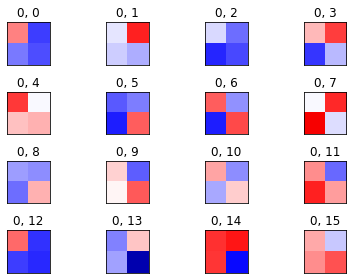

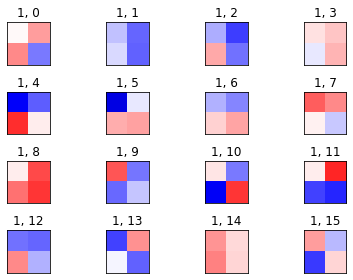

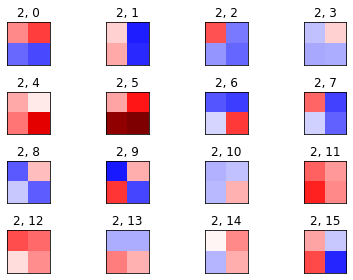

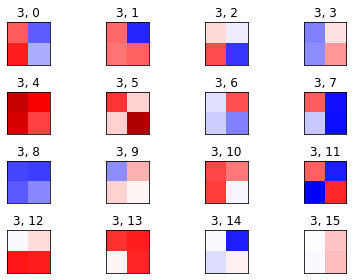

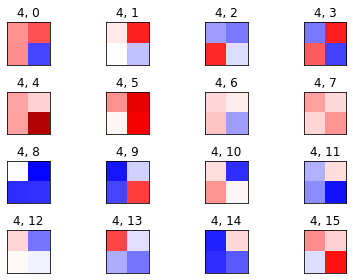

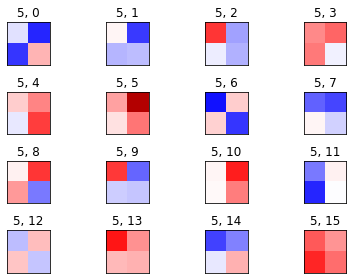

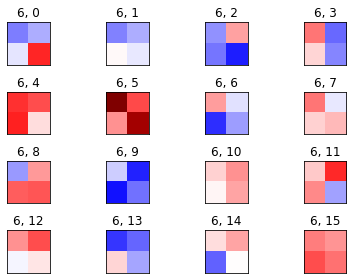

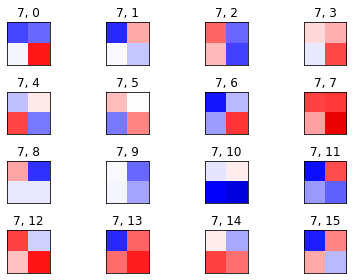

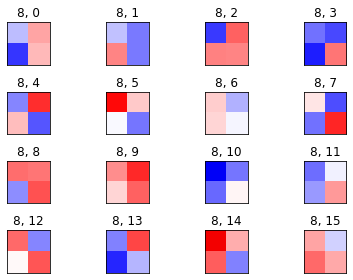

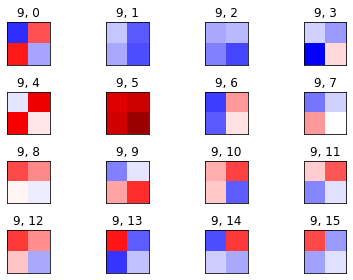

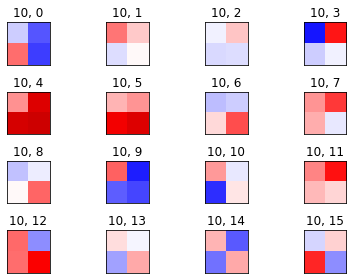

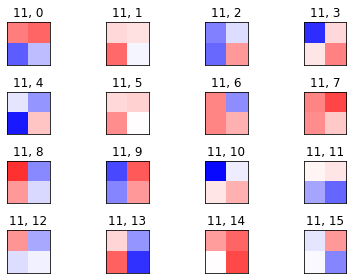

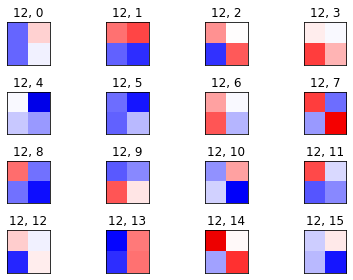

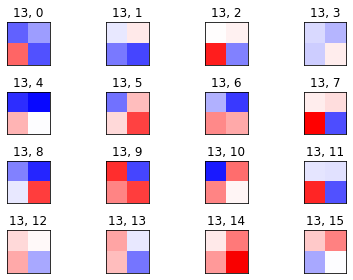

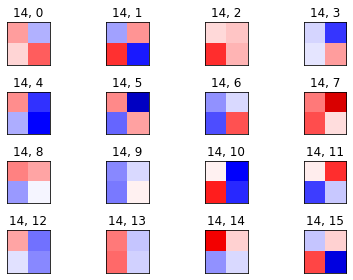

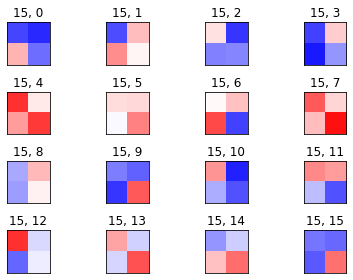

In [43]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

[]

[]

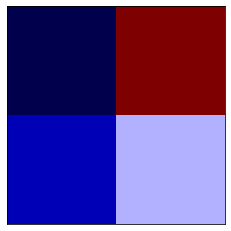

In [29]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [39]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)